# SPDR Sector ETF Analysis

What you will see in here is some high level inferential statistics, as well as many model iterations. If you prefer, you could scan this notebook, and then go to [notebook 2b](https://github.com/dvdhartsman/Stock_Market_Analysis/blob/main/2b_SPDR_Eval.ipynb) for the conclusions. This notebook will essentially be a continuation of the previous notebook that tracked the performance of market indexes qualitatively over different time horizons. This notebook will still address the same time horizons, however because these ETFs represent more specific sectors of the stock market, their performances may diverge from the behavior observed and modeled in the previous notebook.

### Notebook Analysis Layout:
- Inferential EDA/Data Understanding
- Materials 1, 3, 6, 12 Month Modeling
- Energy 1, 3, 6, 12 Month Modeling
- Financials 1, 3, 6, 12 Month Modeling
- Industrials 1, 3, 6, 12 Month Modeling
- Technology 1, 3, 6, 12 Month Modeling
- Staples 1, 3, 6, 12 Month Modeling
- Utilities 1, 3, 6, 12 Month Modeling
- Health Care 1, 3, 6, 12 Month Modeling
- Consumer Discretionary 1, 3, 6, 12 Month Modeling
- Real Estate 1, 3, 6, 12 Month Modeling
- Communication Services 1, 3, 6, 12 Month Modeling
- ##### Summation

### Disclaimer: This notebook should not be considered any kind of financial advice. It exists only for the purposes of practicing modeling and making predictions 

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve, confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier

import datetime as dt

# New import of my custom class
from classification_classes import Model
from spider_classes import Materials, Energy, Financials, Industrials, Technology, Staples, Utilities, Health, \
Consumer, Real_Estate, Communication_Services

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 50)
sns.set_style("dark")

In [2]:
import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

### New container for feature importances

In [3]:
# Class for collecting coefficients of models based on economic features

class Importance():
    df = pd.DataFrame(columns=['Adj Close', 'Close', 'High', 'Low','Open', 'Volume', 'GDP_Filled',\
                               'Interest_Rates','Mkt-RF','SMB','HML','RMW','CMA','garman_klass_vol','RSI', \
                               'lowest_bollinger_band', 'lower_bollinger_band', '20_day_SMA', \
                               'one_up_bollinger_band','upper_bollinger_band', 'ATR', 'MACD', 'dollar_volume(M)',\
                               'Quarter_1','Quarter_2','Quarter_3','Quarter_4','Month_1','Month_10','Month_11',\
                               'Month_12','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8',\
                               'Month_9','cycle_year_1','cycle_year_2','cycle_year_3','cycle_year_4',\
                               'day_of_week_Friday','day_of_week_Monday','day_of_week_Thursday',\
                               'day_of_week_Tuesday','day_of_week_Wednesday'])
    
    # Init method
    def __init__(self, coefs):
        self.dict = coefs
    
        # Add the metrics to the class dataframe
        idx = len(Importance.df)
        Importance.df.loc[idx] = self.dict
    
    
    def add_coefs(self, coefs):
        idx = len(Importance.df)
        Importance.df.loc[idx] = coefs
        
    
    def __str__(self):
      return "Feature Importance/Coefficient DataFrame"
        


<hr style="border: 3px solid black">

# SPDR Data

The term "SPDR" stands for "Standard & Poor's Depositary Receipts." These ETFs were literally the first Exchange Traded Funds offered to the public markets that allowed investors to gain access to large sectors of the market or entire indices depending on your preference. As the previous notebook analyzed the major market indices, this notebook will focus on the sector indices to provide a different perspective. The process for modeling will be largely the same. Because so many of the models from the previous notebook performed so well without overfitting, I did not tune them using GridsearchCV. Depending on performances in this notebook, there may be more tuning.

In [5]:
# Loading the data

df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/SPDR_DATA_W_ADDED.csv')
print(df.shape)
df.head(15)

(56246, 41)


Date Ticker  Adj Close      Close       High        Low       Open  \
0   1999-01-29    XLB  12.173973  21.109375  21.109375  20.953125  20.953125   
1   1999-01-29    XLE  11.670672  21.812500  21.812500  21.437500  21.687500   
2   1999-01-29    XLF  11.877566  19.369415  19.394800  18.810926  19.077478   
3   1999-01-29    XLI  15.624509  24.296875  24.406250  23.953125  24.234375   
4   1999-01-29    XLK  28.604773  37.812500  37.843750  36.937500  37.375000   
5   1999-01-29    XLP  15.135293  26.796875  26.984375  26.437500  26.812500   
6   1999-01-29    XLU  12.437774  29.484375  29.656250  29.203125  29.531250   
7   1999-01-29    XLV  19.057581  27.250000  27.281250  26.906250  27.281250   
8   1999-01-29    XLY  20.654898  27.468750  27.562500  27.187500  27.375000   
9   1999-02-01    XLB  12.273088  21.281250  21.500000  21.281250  21.281250   
10  1999-02-01    XLE  11.553638  21.593750  21.875000  21.593750  21.812500   
11  1999-02-01    XLF  11.675195  19.039398  19.445574  19.039398  19.445574   
12  1999-02-01    XLI  15.644599  24.328125  24.500000  24.328125  24.500000   
13  1999-02-01    XLK  28.628410  37.843750  38.375000  37.562500  38.156250   
14  1999-02-01    XLP  15.073517  26.687500  27.078125  26.671875  26.984375   

      Volume  GDP_Filled  Interest_Rates  Mkt-RF     SMB     HML     RMW  \
0      400.0    9411.682            4.37  0.0095  0.0010 -0.0062  0.0044   
1    18600.0    9411.682            4.37  0.0095  0.0010 -0.0062  0.0044   
2    72998.0    9411.682            4.37  0.0095  0.0010 -0.0062  0.0044   
3   109200.0    9411.682            4.37  0.0095  0.0010 -0.0062  0.0044   
4   933600.0    9411.682            4.37  0.0095  0.0010 -0.0062  0.0044   
5   167800.0    9411.682            4.37  0.0095  0.0010 -0.0062  0.0044   
6    39800.0    9411.682            4.37  0.0095  0.0010 -0.0062  0.0044   
7    13800.0    9411.682            4.37  0.0095  0.0010 -0.0062  0.0044   
8     6800.0    9411.682            4.37  0.0095  0.0010 -0.0062  0.0044   
9     2900.0    9411.682            4.42 -0.0039 -0.0002 -0.0016 -0.0015   
10   23100.0    9411.682            4.42 -0.0039 -0.0002 -0.0016 -0.0015   
11   59827.0    9411.682            4.42 -0.0039 -0.0002 -0.0016 -0.0015   
12    2400.0    9411.682            4.42 -0.0039 -0.0002 -0.0016 -0.0015   
13  913000.0    9411.682            4.42 -0.0039 -0.0002 -0.0016 -0.0015   
14   57200.0    9411.682            4.42 -0.0039 -0.0002 -0.0016 -0.0015   

       CMA  garman_klass_vol        RSI  lowest_bollinger_band  \
0  -0.0057         -0.113866  45.359196              11.895113   
1  -0.0057         -0.148177  31.112318              11.538886   
2  -0.0057         -0.086272  53.698896              11.237432   
3  -0.0057         -0.074248  54.474621              15.080736   
4  -0.0057         -0.027333  69.725520              24.579485   
5  -0.0057         -0.126109  54.912532              14.189066   
6  -0.0057         -0.288723  45.545589              12.289195   
7  -0.0057         -0.049617  61.773293              18.151676   
8  -0.0057         -0.030556  65.978046              19.308743   
9  -0.0041         -0.116979  47.631201              11.860719   
10 -0.0041         -0.155917  28.964458              11.443073   
11 -0.0041         -0.100313  49.064788              11.237432   
12 -0.0041         -0.077696  54.897092              15.075719   
13 -0.0041         -0.031654  69.830433              24.773565   
14 -0.0041         -0.130876  53.381438              14.199193   

    lower_bollinger_band  20_day_SMA  one_up_bollinger_band  \
0              12.260720   12.626326              12.991933   
1              11.886097   12.233309              12.580520   
2              11.515857   11.794283              12.072709   
3              15.377490   15.674243              15.970996   
4              25.563477   26.547469              27.531461   
5              14.545906   14.902747              15.259588   
6             

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56246 entries, 1999-01-29 to 2022-11-02
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ticker                 56246 non-null  object 
 1   Adj Close              56246 non-null  float64
 2   Close                  56246 non-null  float64
 3   High                   56246 non-null  float64
 4   Low                    56246 non-null  float64
 5   Open                   56246 non-null  float64
 6   Volume                 56246 non-null  float64
 7   GDP_Filled             56246 non-null  float64
 8   Interest_Rates         56246 non-null  float64
 9   Mkt-RF                 56246 non-null  float64
 10  SMB                    56246 non-null  float64
 11  HML                    56246 non-null  float64
 12  RMW                    56246 non-null  float64
 13  CMA                    56246 non-null  float64
 14  garman_klass_vol       56246 non-null

In [7]:
# Feature Transformations and additions

df["Date"] = pd.to_datetime(df["Date"])
df["Quarter"] = df['Quarter'].astype(str)
df["cycle_year"] = df["cycle_year"].astype(str)
df['Month'] = df['Month'].astype(str)
df.set_index("Date", inplace=True)

In [9]:
df.shape

(56246, 40)

In [10]:
# Cell creates a dataframe of the NORMALIZED value counts for each ETF and each time target

tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY',
       'XLRE', 'XLC']

# Value Counts for Targets of Each SPDR

values = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values.loc[num] = (df[df["Ticker"]==i]['One_Month_Positive'].value_counts(normalize=True)*100).round(2)

# 3 Month Target

values3 = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values3.loc[num] = (df[df["Ticker"]==i]['Three_Month_Positive'].value_counts(normalize=True)*100).round(2)

# 6 Month Target

values6 = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values6.loc[num] = (df[df["Ticker"]==i]['Six_Month_Positive'].value_counts(normalize=True)*100).round(2)

# 12 Month Target

values12 = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values12.loc[num] = (df[df["Ticker"]==i]['Twelve_Month_Positive'].value_counts(normalize=True)*100).round(2)

# Concat all DFs
    
value_cnts = pd.concat([values, values3, values6, values12], axis=1)

super_column_titles = ['One', 'Month', 'Three', 'Month', 'Six', 'Month', 'Twelve', 'Month']

multi_index = pd.MultiIndex.from_tuples(list(zip(super_column_titles, value_cnts.columns)))

value_cnts.columns = multi_index

value_cnts.rename(index={0:'XLB', 1:'XLE', 2:'XLF', 3:'XLI', 4:'XLK', 5:'XLP', 6:'XLU', 7:'XLV', 8:'XLY',
       9:'XLRE', 10:'XLC'}, inplace=True)

# Value Counts of ETFs for each time horizon

value_cnts

One  Month  Three  Month    Six  Month Twelve  Month
          0      1      0      1      0      1      0      1
XLB   39.78  60.22  35.86  64.14  32.09  67.91  29.44  70.56
XLE   42.73  57.27  37.70  62.30  35.37  64.63  33.70  66.30
XLF   41.57  58.43  35.89  64.11  35.98  64.02  36.42  63.58
XLI   39.95  60.05  34.28  65.72  32.36  67.64  25.35  74.65
XLK   39.13  60.87  33.30  66.70  30.39  69.61  24.89  75.11
XLP   37.36  62.64  31.99  68.01  26.24  73.76  18.31  81.69
XLU   38.03  61.97  33.52  66.48  29.00  71.00  22.64  77.36
XLV   38.42  61.58  32.47  67.53  31.24  68.76  23.23  76.77
XLY   37.73  62.27  34.58  65.42  30.87  69.13  25.13  74.87
XLRE  39.22  60.78  32.22  67.78  35.55  64.45  37.33  62.67
XLC   42.00  58.00  42.56  57.44  39.20  60.80  32.93  67.07

### Interpretation of the above table:

As you can see, the longer the time horizon, the more likely that any ETF will have increased in value. XLRE and XLF, real estate and financials respectively, each failed to perform better over 6 months compared to 3 months, but those are literally the only exceptions. XLRE and XLC also have not existed for as long as these other SPDR funds, and therefore there is a bit less data for those two ETFs.

# Visual Inspection

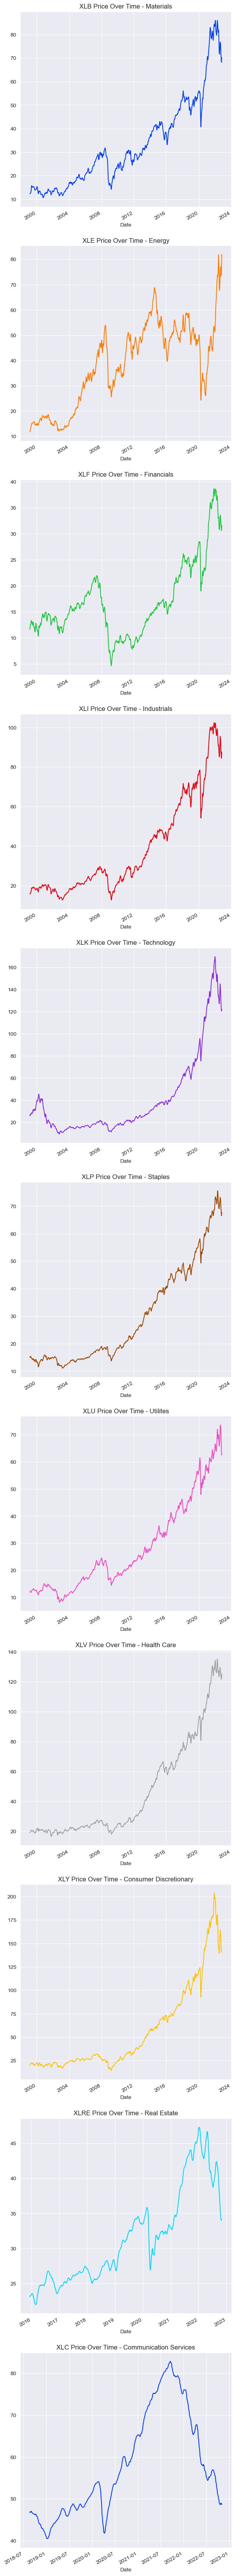

In [11]:
# Plotting price over time
sns.set_style("darkgrid")
sectors = ["Materials", "Energy", "Financials", "Industrials", "Technology", "Staples", "Utilites", "Health Care",\
          "Consumer Discretionary", "Real Estate", "Communication Services"]

palette = sns.color_palette("bright", n_colors=11)
fig, ax = plt.subplots(nrows=11, figsize=(7,96))

for num, i in enumerate(tickers):
    df[df["Ticker"]==i]["Adj Close"].rolling(window=20).mean().\
    plot(kind="line", color=palette[num], title=f"{i} Price Over Time - {sectors[num]}", ax=ax[num])

### Monthly Statistics

In [12]:
df.reset_index(inplace=True)
df.set_index(["Date", "Ticker"], inplace=True)

##### Keep in mind that XLC and XLRE do not have as much data, and so their performance might be noisy

In [13]:
# XLE has highest average monthly stock gain not accounting for dividends/expenses

# Creates multi-index columns, then re-structures the df by Monthly groups
monthly_data = df.unstack("Ticker").resample('M')

# Subtract the price at month's end from the price and month's start divided by price at month's start * 100 for %
monthly_percentage_change = monthly_data['Adj Close'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)

# Sort the last of mean percentage monthly gains
monthly_percentage_change.mean().sort_values(ascending=False)

Ticker
XLE     0.735920
XLI     0.721174
XLRE    0.699393
XLV     0.663228
XLY     0.657240
XLB     0.617715
XLU     0.592624
XLK     0.530358
XLF     0.476599
XLP     0.455981
XLC    -0.033033
dtype: float64

In [14]:
# Fuller Picture of monthly returns

monthly_percentage_change.describe()

Ticker          XLB          XLC          XLE          XLF          XLI  \
count   5937.000000  1064.000000  5937.000000  5937.000000  5937.000000   
mean       0.617715    -0.033033     0.735920     0.476599     0.721174   
std        6.058955     6.434269     7.307500     6.440171     5.437912   
min      -21.095913   -15.528110   -36.920886   -27.014185   -21.390426   
25%       -2.556932    -5.458960    -2.830115    -2.496538    -2.193283   
50%        0.636843     1.017502     0.392298     0.657145     0.795909   
75%        3.849909     3.264003     4.894544     3.906783     3.778306   
max       23.590417    18.361562    37.581425    24.977077    17.676035   

Ticker          XLK          XLP         XLRE          XLU          XLV  \
count   5937.000000  5937.000000  1732.000000  5937.000000  5937.000000   
mean       0.530358     0.455981     0.699393     0.592624     0.663228   
std        6.604844     3.570488     5.218619     4.366374     4.172537   
min      -24.865897   -13.237379   -19.129239   -14.998876   -14.104296   
25%       -2.972343    -1.581269    -1.363809    -1.622717    -1.582014   
50%        1.068224     0.862423     0.662253     1.023580     0.643060   
75%        4.274335     2.709526     3.900496     3.271154     2.853538   
max       26.440716    10.991558    16.483488    11.876673    17.040249   

Ticker          XLY  
count   5937.000000  
mean       0.657240  
std        5.678635  
min      -17.739842  
25%       -2.307290  
50%        0.776027  
75%        3.746741  
max       24.439715

### Yearly statistics - taken from year start - year end, averages of each, so can be misleading

In [15]:
# XLC has highest average yearly stock gain not accounting for dividends/expenses

yearly_data = df.unstack("Ticker").resample('Y')
yearly_percentage_change = yearly_data['Adj Close'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)
yearly_percentage_change.mean().sort_values(ascending=False)

Ticker
XLE     10.784757
XLRE    10.400698
XLC     10.121769
XLY      9.985724
XLK      9.544545
XLB      9.456045
XLI      9.273756
XLV      9.014097
XLU      8.797569
XLP      7.634534
XLF      6.754573
dtype: float64

In [16]:
# Fuller picture of stock appreciation over 1 year beginning and ending periods

yearly_percentage_change.describe()

Ticker          XLB         XLC          XLE          XLF          XLI  \
count   5937.000000  961.000000  5937.000000  5937.000000  5937.000000   
mean       9.456045   10.121769    10.784757     6.754573     9.273756   
std       19.713061   26.893940    26.136396    21.349331    17.790182   
min      -43.506975  -40.066239   -39.070508   -53.995759   -37.693408   
25%       -6.030321   17.706288   -14.037699    -6.814757    -1.803640   
50%       15.914775   25.430960    12.714321    11.017514    12.762093   
75%       22.910315   29.324749    26.888805    25.142450    23.246300   
max       42.940632   29.324749    59.942881    36.652056    37.253108   

Ticker          XLK          XLP         XLRE          XLU          XLV  \
count   5937.000000  5937.000000  1710.000000  5937.000000  5937.000000   
mean       9.544545     7.634534    10.400698     8.797569     9.014097   
std       26.936440    12.539642    23.263521    15.937055    12.770881   
min      -43.517486   -19.809942   -28.826901   -29.777632   -22.497962   
25%        0.540814     2.841735    -1.821357     1.786417     1.534577   
50%       13.688129    10.991956     5.197585    12.325605     7.664254   
75%       31.563928    13.931273    31.700130    20.746741    17.136334   
max       49.759217    28.191275    50.973792    30.744360    38.662444   

Ticker          XLY  
count   5937.000000  
mean       9.985724  
std       19.915785  
min      -34.384100  
25%        0.061198  
50%       13.662197  
75%       27.424318  
max       39.814901

### Notes
While some of these sector ETFs move in concert, there is clearly observable performance dislocation between other ETFs. Also, certain sectors spiders pay dividends. A dividend is a payout of a company's earnings given directly to its shareholders, and dividends are generally described as the percentage of the current asset price to be paid out annually. For individual assets dividend rates and schedules can change depending on performance, however when dealing with a basket of stocks, like those within an ETF, dividends and their structures are usually more reliably consistent. Each of these ETFs also has an associated expense ratio, or amount taken out of your investment to fund the operations of the ETF.
### Dividends of ETFs
- XLB 2.11%
- XLE 3.50%
- XLF 2.00%
- XLI 1.83%
- XLK 0.97%
- XLP 2.81%
- XLU 3.71%
- XLV 1.77%
- XLY 0.87%
- XLRE 3.99%
- XLC 1.06%

### Expense Ratios
Each of the sector spiders has a 0.1% expense ratio. That means that if your investment in a given spider was $1,000 at the start of the year, you would expect to pay an expense of 0.1% on that amount, or 1 dollar. 

### Adjusted Close
As you look at several of the above tables, you may wonder why we use "Adj Close" instead of "Close" for calculating a daily price. Adjusted close takes into account both dividends and future stock splits. Stock splits occur when a company chooses to artificially increase the amount of stocks that are trading by taking the current volume of stock and "splitting" it into x-number of pieces. A 10-to-1 split would mean that if you owned one share of a company or one share of an ETF before the split, afterwards you would own 10 shares, and each would be worth one tenth of the price of your original holding, so your investment is still the same size, but it is spread over more individual shares. 

<hr style="border: 2px solid green">

# Model Prep
Now that we have performed some superficial inspection of these ETFs, we can begin model iterations. 

### Splitting Data in Prep for Models

In [17]:
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)

In [18]:
# DFs for each ETF

# Materials
materials_df = df[df["Ticker"]== "XLB"]

# Energy
energy_df = df[df["Ticker"]== "XLE"]

# Financials
financial_df = df[df["Ticker"]== "XLF"]

# Industrials
industrial_df = df[df["Ticker"]== "XLI"]

# Technology
tech_df = df[df["Ticker"]== "XLK"]

# Staples
staples_df = df[df["Ticker"]== "XLP"]

# Utilities
utilities_df = df[df["Ticker"]== "XLU"]

# Health Care
health_df = df[df["Ticker"]== "XLV"]

# Consumer Discretionary
consumer_df = df[df["Ticker"]== "XLY"]

# Real Estate
real_df = df[df["Ticker"]== "XLRE"]

# Tele-com / communication services
communication_df = df[df["Ticker"]== "XLC"]

In [19]:
# Definition to handle splits using df, and string for time horizon

def select_data(df, time_horizon:str):
    
    X = df.drop(columns=["Ticker", 'one_months_later', 'three_months_later', 'six_months_later', \
                         'twelve_months_later', 'One_Month_Positive', 'Three_Month_Positive', 'Six_Month_Positive',\
                         'Twelve_Month_Positive', 'One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', \
                         'Twelve_Month_Change'])
    y = df[f'{time_horizon.title()}_Month_Positive']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=131, shuffle=False, test_size=.2)
    return X_train, X_test, y_train, y_test

In [20]:
# %%writefile other_functions.py
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


def compare_curves(list_of_models):
    sns.set_style("dark")
    # Color Palette
    colors = sns.color_palette("Paired", n_colors=8)
    # Create the plot
    fig, ax = plt.subplots(figsize=(7,7))
    for i in range(len(list_of_models)):
        # get the predict_proba values
        y_hat_hd = list_of_models[i].y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(list_of_models[i].y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr, color=colors[i], label=f'{list_of_models[i].name} | AUC: {list_of_models[i].auc:.2f})')

    ax.set_title(f"Comparison of ROC Curves")
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    plt.grid(False);

<hr style="border: 4px solid green">

# Dummy Model

In [23]:
# Preparing for our first batch of models, we will proceed index by index and from time horizons low to high

X_train, X_test, y_train, y_test = select_data(materials_df, "One")

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy1 = Materials("Dummy Model", dummy, X_train, X_test, y_train, y_test)
Materials.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.5s finished


name  train_accuracy  train_prec  train_recall  train_f1  \
0  Dummy Model        0.616941    0.616941           1.0  0.762634   

   train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
0      13.806861       0.608586   0.608586          1.0  0.756672   

   test_logloss  AUC  
0     14.107996  0.5

# Pipelines

In [24]:
# Sub-pipe for numeric transformation
num_pipe = Pipeline(steps=[
    ('knn', KNNImputer(add_indicator=True)),
    ("ss", StandardScaler())
])

# Sub-pipe for categorical transformation
cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Column Transformer object to be given to the ultimate pipeline model
ct = ColumnTransformer(transformers=[
    ("num_pipe", num_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
])

In [36]:
# Pipeline for model fitting and commented out models that will be fit 



                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    
    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)
    
#     RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
#     ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

#     XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)


                                # Normal Protocol

model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
                         tree_method="auto", n_jobs=4, random_state=13)  
     
    )])

model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('knn',
                                                                   KNNImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe1165e8580>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_co...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=1.0,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=0,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=4, num_parallel_tree=None, predictor=None,
                               random_state=13, ...))])

In [38]:
# logreg = Materials("Materials Logistic Regression 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# knn = Materials("Materials KNN 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# rfc = Materials("Materials RFC 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# etc = Materials("Materials ExtraTrees 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# adaboost = Materials("Materials AdaBoost 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# XGBoost = Materials("Materials XGBoost 1-Month", model_pipe, X_train, X_test, y_train, y_test)


Materials.model_df.sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
3                  Materials RFC 1-Month        0.460177    0.618078   
4           Materials ExtraTrees 1-Month        0.481922    0.654992   
2                  Materials KNN 1-Month        0.480657    0.614712   
6              Materials XGBoost 1-Month        0.467004    0.657103   
1  Materials Logistic Regression 1-Month        0.529709    0.686551   
5             Materials AdaBoost 1-Month        0.484703    0.668828   
0                            Dummy Model        0.616941    0.616941   

   train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
3      0.362268  0.399605       1.058584       0.476431   0.713080   
4      0.407471  0.451600       0.941556       0.500000   0.665810   
2      0.439634  0.497137       8.530930       0.560606   0.658768   
6      0.390070  0.418223       2.509071       0.601852   0.655473   
1      0.600622  0.562409       2.061664       0.501684   0.614711   
5      0.378229  0.444354       0.754839       0.493266   0.609800   
0      1.000000  0.762634      13.806861       0.608586   0.608586   

   test_recall   test_f1  test_logloss       AUC  
3     0.233748  0.352083      0.845184  0.605531  
4     0.358230  0.465827      0.719796  0.599518  
2     0.576763  0.615044      8.375298  0.581398  
6     0.728907  0.690242      1.119098  0.596193  
1     0.485477  0.542504      0.831952  0.549952  
5     0.464730  0.527473      0.722086  0.519112  
0     1.000000  0.756672     14.107996  0.500000

### GridSearch CV
Because ETC has similar stats for training and test precision and is the second most precise model, I will try to optimize its performance using grid search. 

In [40]:
# Parameters to search through

params = {"model__criterion": ['gini', 'entropy', 'log_loss'],
         'model__max_depth': [None, 7, 5],
         'model__max_features': ["auto", "sqrt", "log2"],
         "model__ccp_alpha": [0, .001, .01, .1],
         }

In [49]:
# Fitting the gridsearch model 
tsmc = TimeSeriesSplit(n_splits=5)
precision_scorer = make_scorer(precision_score, zero_division=0)

grid = GridSearchCV(estimator=etc.model, param_grid=params, cv=tsmc, n_jobs=6, scoring=precision_scorer, verbose=0)
grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('knn',
                                                                                          KNNImputer(add_indicator=True)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fe1165e8580>),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fe1165e8a30>)])),
                                       ('model',
                                        ExtraTreesClassifier(random_state=13))]),
             n_jobs=6,
             param_grid={'model__ccp_alpha': [0, 0.001, 0.01, 0.1],
                         'model__criterion': ['gini', 'entropy', 'log_loss'],
                         'model__max_depth': [None, 7, 5],
                         'model__max_features': ['auto', 'sqrt', 'log2']},
             scoring=make_scorer(precision_score, zero_division=0))

In [43]:
# Best hyperparameters 

grid.best_params_

{'model__ccp_alpha': 0.1,
 'model__criterion': 'gini',
 'model__max_depth': None,
 'model__max_features': 'sqrt'}

In [50]:
# Best hyperparameters with precision as target of cv

grid.best_params_

{'model__ccp_alpha': 0.001,
 'model__criterion': 'entropy',
 'model__max_depth': None,
 'model__max_features': 'log2'}

### Gridsearch Best Params for accuracy
- ccp_alpha = 0.1 chosen instead of default 0
- criterion: Default "gini"
- max_depth: None is the default and was chosen
- max_features: "sqrt" was the default
### Gridsearch Best Params for precision
- ccp_alpha = 0.001 default and chosen
- criterion: "entropy" instead of Default "gini"
- max_depth: None is the default and was chosen
- max_features: "log2" instead of the default "sqrt"

In [51]:
# Adding GridSearchCV searched model

# gridS_cv = Materials("GridSearched ETC, 1-Month XLB", grid.best_estimator_, X_train, X_test, y_train, y_test)
# gridS_prec_cv = Materials("GridSearched ETC-Precision, 1-Month XLB", grid.best_estimator_, X_train, X_test, y_train, y_test)

Materials.model_df.sort_values(by="test_prec", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


name  train_accuracy  train_prec  \
3                    Materials RFC 1-Month        0.460177    0.618078   
8  GridSearched ETC-Precision, 1-Month XLB        0.494058    0.668136   
4             Materials ExtraTrees 1-Month        0.481922    0.654992   
2                    Materials KNN 1-Month        0.480657    0.614712   
6                Materials XGBoost 1-Month        0.467004    0.657103   
1    Materials Logistic Regression 1-Month        0.529709    0.686551   
5               Materials AdaBoost 1-Month        0.484703    0.668828   
0                              Dummy Model        0.616941    0.616941   
7            GridSearched ETC, 1-Month XLB        0.616941    0.616941   

   train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
3      0.362268  0.399605       1.058584       0.476431   0.713080   
8      0.430967  0.466307       0.927464       0.555556   0.701863   
4      0.407471  0.451600       0.941556       0.500000   0.665810   
2      0.439634  0.497137       8.530930       0.560606   0.658768   
6      0.390070  0.418223       2.509071       0.601852   0.655473   
1      0.600622  0.562409       2.061664       0.501684   0.614711   
5      0.378229  0.444354       0.754839       0.493266   0.609800   
0      1.000000  0.762634      13.806861       0.608586   0.608586   
7      1.000000  0.762634       0.671760       0.608586   0.608586   

   test_recall   test_f1  test_logloss       AUC  
3     0.233748  0.352083      0.845184  0.605531  
8     0.468880  0.562189      0.688678  0.636519  
4     0.358230  0.465827      0.719796  0.599518  
2     0.576763  0.615044      8.375298  0.581398  
6     0.728907  0.690242      1.119098  0.596193  
1     0.485477  0.542504      0.831952  0.549952  
5     0.464730  0.527473      0.722086  0.519112  
0     1.000000  0.756672     14.107996  0.500000  
7     1.000000  0.756672      0.669511  0.500000

By conducting the grid search specifically for the purposes of improved precision, we improved the score by over 3.5%. We added 80 true positives and 14 false positives, a nearly 6 to 1 ratio. The resulting confusion matrix comparison looks like this:

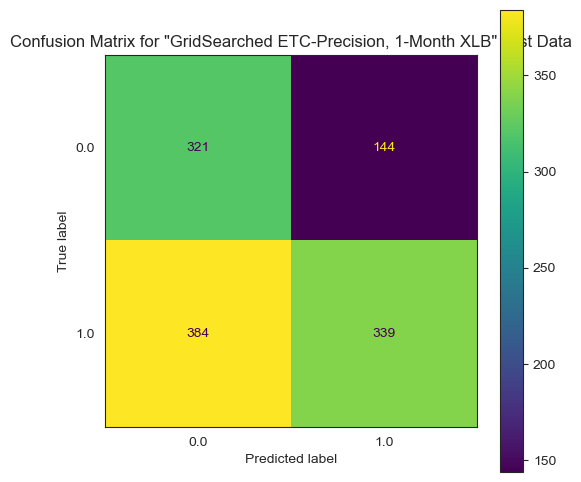

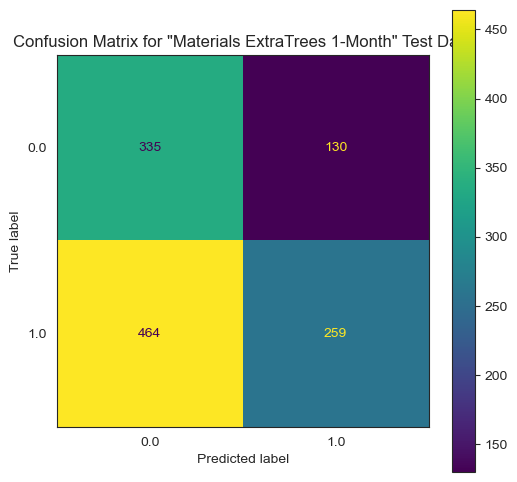

In [53]:
gridS_prec_cv.confusion_matrix(), etc.confusion_matrix();

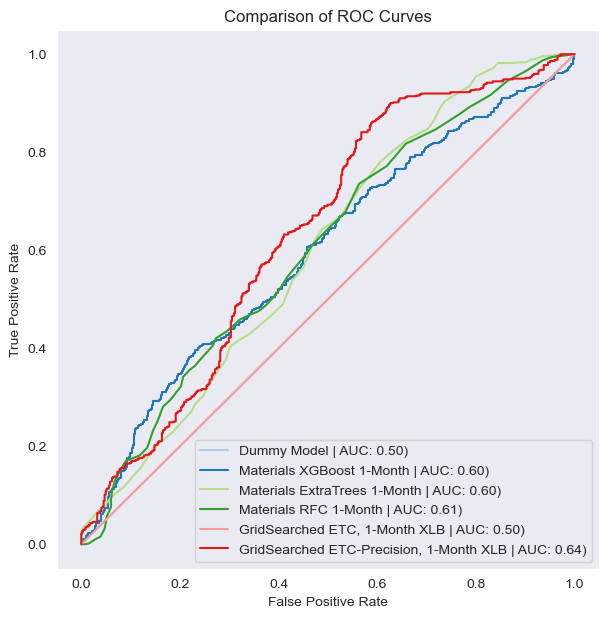

In [54]:
# Plotting the top models vs the dummy
compare_curves([dummy1, XGBoost, etc, rfc, gridS_cv, gridS_prec_cv])

### Final Observations
Small differences in the grid searched model allowed for a substantial improvement of our target metric. It is very important to always attempt to tune our models for a specific type of performance outcome.

In [55]:
def features_from_trees(model_class):

    # Extracting feature importances and adding them to a dataframe to contain them for each model

    features = list(model_class.model.get_params()["ct"].get_feature_names_out())
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]

    imp_feats = model_class.model.get_params()['model'].feature_importances_

    imp_list = list(zip(features_list, imp_feats))
    imp_dict = dict(imp_list)

    Importance(imp_dict)

    print("Top 5 Feature Importances")
    for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:5]:
        print(i)

In [56]:
# Extracts the coefficients from Logistic Regression models and pairs them with their features

def coefs_from_lr(model_class):
    features = model_class.model.named_steps["ct"].get_feature_names_out()
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]
    
    coef_feats = model_class.model.get_params()['model'].coef_[0]
    
    imp_list = list(zip(features_list, coef_feats))
    imp_dict = dict(imp_list)
    
    Importance(imp_dict)

    print("Top 5 Feature Coefficients")
    for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:5]:
        print(i)

In [57]:
# object instantiation and inspection of importances
features_from_trees(gridS_prec_cv)

Top 5 Feature Importances
('GDP_Filled', 0.04583452393362024)
('Interest_Rates', 0.04578610979186614)
('upper_bollinger_band', 0.04401936940214517)
('one_up_bollinger_band', 0.043762651327602056)
('lowest_bollinger_band', 0.04360503170809457)


In [58]:
Importance.df

Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
0   0.040699  0.040983  0.039392  0.041195  0.035829  0.012049    0.045835   

   Interest_Rates    Mkt-RF      SMB       HML       RMW      CMA  \
0        0.045786  0.001906  0.00231  0.002576  0.002658  0.00246   

   garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
0          0.024941  0.025553               0.043605              0.043188   

   20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
0    0.043402               0.043763              0.044019  0.038942   

       MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
0  0.035165          0.011002   0.014734   0.016106   0.015579   0.018743   

    Month_1  Month_10  Month_11  Month_12   Month_2   Month_3   Month_4  \
0  0.016061  0.017082  0.011786  0.011582  0.010436  0.017176  0.017889   

    Month_5   Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
0  0.013351  0.012507  0.015742  0.012322  0.014496      0.019484   

   cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
0      0.020752      0.032916      0.022602            0.000284   

   day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
0            0.000412              0.000203              0.00037   

   day_of_week_Wednesday  
0               0.000127

<hr style="border: 2px solid royalblue">

# Materials 3 Month

### Editorial Discretion
From here forward, I will not be using KNN or AdaBoost as they are not performing well on any of the data I have used them on thus far. I will keep using logisitc regression only because I find it very interesting to compare the performance of parametric models to tree based algorithms. I also will not use the voting or stacking ensembles, however, I will continue to use GridSearchCV

### Functions to expedite models

In [60]:
def dummy_model(model_type, sector_name, time_period):
    # Dummy Classifier for new time horizon
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)


    # CHANGE THE CLASS EACH TIME IT'S APPROPRIATE
    return model_type(f"Dummy {sector_name} {str(time_period)}-Month", dummy, X_train, X_test, y_train, y_test)

In [61]:
def l_regr(model_type, sector_name, time_period, threshold=0.5):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
                                    fit_intercept=True)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Logistic Regression {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test, threshold=threshold)
    

In [62]:
def r_forest(model_type, sector_name, time_period, threshold=0.5):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
                                  max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
                                  oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Random Forest {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test, threshold=threshold)
    

In [63]:
def extra_trees(model_type, sector_name, time_period, threshold=0.5):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
    min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
    bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
    ccp_alpha=0.0, max_samples=None)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Extra Trees {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test, threshold=threshold)
    

In [64]:
def x_g_b(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
                         tree_method="auto", n_jobs=4, random_state=13)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} XGBoost {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)
    

In [71]:
def best_etc_grid(estimator, model_type, sector_name, time_period):
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Parameters to search through
    params = {"model__criterion": ['gini', 'entropy', 'log_loss'],
             'model__max_depth': [None, 7, 5],
             'model__max_features': ["auto", "sqrt", "log2"],
             "model__ccp_alpha": [0, .001, .01, .1],
         }
    
    precision_scorer = make_scorer(precision_score, zero_division=0)

# Fitting the gridsearch model 

    grid = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=6, cv=tscv, verbose=1, scoring=precision_scorer)
    grid.fit(X_train, y_train)

# Adding GridSearchCV searched model
    print(grid.best_params_)

    return model_type(f"GridSearched Best-Model, {time_period}-Month {sector_name}",\
                      grid.best_estimator_, X_train, X_test, y_train, y_test)



def best_XGB_grid(estimator, model_class_type, sector_name, time_period):
    tscv = TimeSeriesSplit(n_splits=5)
    
    params_XLC = {
        'model__booster':['gbtree', 'gblinear', "dart"],
        'model__max_depth':[5, 6, 8, 10],
        'model__sampling_method': ['uniform', 'gradient_based'],
        'model__n_estimators': [100, 150, 200]
    }
    
    precision_scorer = make_scorer(precision_score, zero_division=0)
    
# Fitting the gridsearch model 

    grid = GridSearchCV(estimator=estimator, param_grid=params_XLC, n_jobs=6, cv=tscv, verbose=1, scoring=precision_scorer)
    grid.fit(X_train, y_train)

# Adding GridSearchCV searched model
    print(grid.best_params_)

    return model_class_type(f"Grid Searched XGBoost, {time_period}-Month {sector_name}",\
                      grid.best_estimator_, X_train, X_test, y_train, y_test)


def best_logreg_search(estimator, model_type, sector_name, time_period):
    tscv = TimeSeriesSplit(n_splits=5)
    
    params = {"model__C": [1.0, 2.0, 0.5, .25],
                "model__class_weight":[{0:1, 1:1}, {0:1, 1:2}],
                'model__max_iter':[100, 200, 300],
                'model__solver':['lbfgs', 'liblinear'],
                'model__tol':[.0001,.001,.01]}
    
    precision_scorer = make_scorer(precision_score, zero_division=0)
                
    grid = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=6, cv=tscv, verbose=1, scoring=precision_scorer)
    
    grid.fit(X_train, y_train)
    
    print(grid.best_params_)

    return model_type(f"Grid Searched LR, {time_period}-Month {sector_name}",\
                      grid.best_estimator_, X_train, X_test, y_train, y_test)

In [73]:
# Create variables

X_train, X_test, y_train, y_test = select_data(materials_df, "Three")

# dummy_M_3 = dummy_model(Materials, "Materials", 3)
# logreg_M_3 = l_regr(Materials, "Materials", 3)
# rfc_M_3 = r_forest(Materials, "Materials", 3)
# etc_M_3 = extra_trees(Materials, "Materials", 3)
# XGBoost_M_3 = x_g_b(Materials, "Materials", 3)

# grid_M_3 =best_etc_grid(estimator=rfc_M_3.model, model_type=Materials, sector_name="Materials", time_period=3)

Materials.model_df.iloc[9:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.001, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


name  train_accuracy  train_prec  \
11             Materials Random Forest 3-Month        0.479646    0.746665   
14  GridSearched Best-Model, 3-Month Materials        0.484197    0.753052   
12               Materials Extra Trees 3-Month        0.507459    0.697018   
13                   Materials XGBoost 3-Month        0.435651    0.652286   
10       Materials Logistic Regression 3-Month        0.544374    0.744100   
9                      Dummy Materials 3-Month        0.675348    0.675348   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
11      0.390127  0.449726       0.969973       0.552189   0.877778   
14      0.399985  0.460092       0.954680       0.552189   0.866906   
12      0.473376  0.498958       0.871477       0.492424   0.731707   
13      0.337716  0.416126       2.710353       0.532828   0.711944   
10      0.589030  0.567612       3.387567       0.567340   0.673981   
9       1.000000  0.804832      11.701656       0.619529   0.619529   

    test_recall   test_f1  test_logloss       AUC  
11     0.322011  0.471173      0.861515  0.675493  
14     0.327446  0.475345      0.838969  0.665239  
12     0.285326  0.410557      0.744076  0.659531  
13     0.413043  0.522786      2.471042  0.572708  
10     0.584239  0.625910      0.834111  0.619493  
9      1.000000  0.765073     13.713579  0.500000

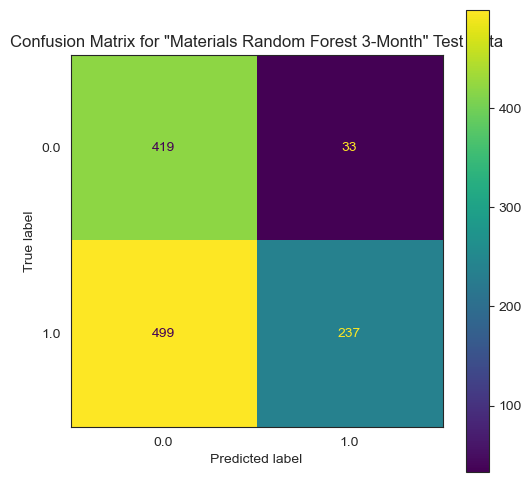

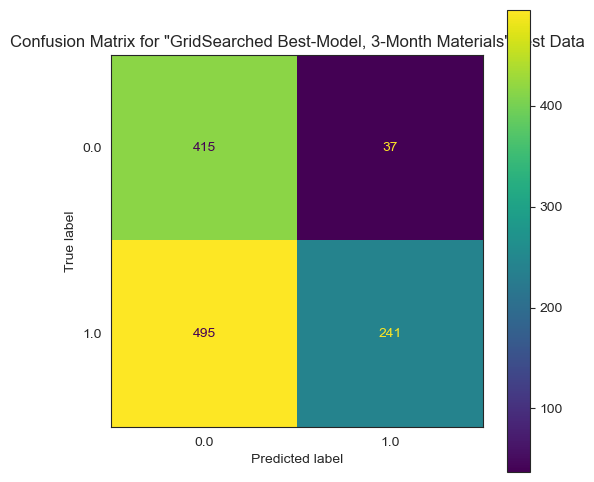

In [74]:
rfc_M_3.confusion_matrix(), grid_M_3.confusion_matrix();

In [75]:
# Feature importances
features_from_trees(grid_M_3)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.08625558456446995)
('Interest_Rates', 0.06812064713091352)
('lowest_bollinger_band', 0.06457440255888211)
('lower_bollinger_band', 0.057533345257668296)
('ATR', 0.05253497656743926)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
0   0.040699  0.040983  0.039392  0.041195  0.035829  0.012049    0.045835   
1   0.045059  0.037639  0.041243  0.041978  0.038170  0.012814    0.086256   

   Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
0        0.045786  0.001906  0.002310  0.002576  0.002658  0.002460   
1        0.068121  0.004600  0.003199  0.003487  0.002384  0.002111   

   garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
0          0.024941  0.025553               0.043605              0.043188   
1          0.043013  0.020295               0.064574              0.057533   

   20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
0    0.043402               0.043763              0.044019  0.038942   
1    0.052246               0.046677              0.046711  0.052535   

       MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
0  0.035165          0.011002   0.014734   0.016106   0.015579   0.018743   
1  0.035491          0.014280   0.014331   0.016913   0.009989   0.016217   

    Month_1  Month_10  Month_11  Month_12   Month_2   Month_3   Month_4  \
0  0.016061  0.017082  0.011786  0.011582  0.010436  0.017176  0.017889   
1  0.006128  0.005296  0.003386  0.004402  0.005992  0.010716  0.007162   

    Month_5   Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
0  0.013351  0.012507  0.015742  0.012322  0.014496      0.019484   
1  0.003985  0.003015  0.008843  0.003602  0.005495      0.013768   

   cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
0      0.020752      0.032916      0.022602            0.000284   
1      0.007219      0.021861      0.010870            0.000019   

   day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
0            0.000412              0.000203             0.000370   
1            0.000106              0.000071             0.000064   

   day_of_week_Wednesday  
0               0.000127  
1               0.000131

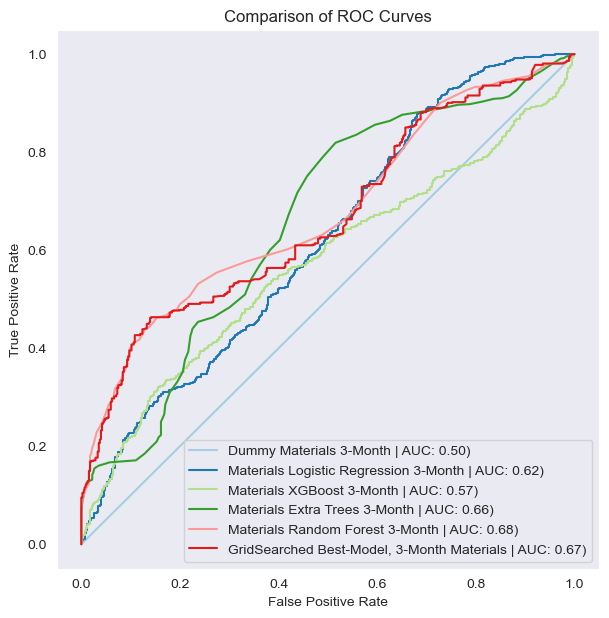

In [76]:
# Plotting the top models vs the dummy
compare_curves([dummy_M_3, logreg_M_3, XGBoost_M_3, etc_M_3, rfc_M_3, grid_M_3])

<hr style="border: 2px solid royalblue">

# Materials 6-Month XLB

In [81]:
# Create variables

X_train, X_test, y_train, y_test = select_data(materials_df, "Six")

# dummy_M_6 = dummy_model(Materials, "Materials", 6)
# logreg_M_6 = l_regr(Materials, "Materials", 6)
# rfc_M_6 = r_forest(Materials, "Materials", 6)
# etc_M_6 = extra_trees(Materials, "Materials", 6)
# XGBoost_M_6 = x_g_b(Materials, "Materials", 6)

# grid_M_6 =best_etc_grid(estimator=rfc_M_6.model, model_type=Materials, sector_name="Materials", time_period=6)

Materials.model_df.iloc[15:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.001, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


name  train_accuracy  train_prec  \
17             Materials Random Forest 6-Month        0.510493    0.848479   
18               Materials Extra Trees 6-Month        0.513021    0.846213   
20  GridSearched Best-Model, 6-Month Materials        0.556511    0.869627   
19                   Materials XGBoost 6-Month        0.559292    0.876956   
15                     Dummy Materials 6-Month        0.661947    0.597977   
16       Materials Logistic Regression 6-Month        0.552212    0.789990   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
17      0.445771  0.521992       0.970971       0.443603   0.848276   
18      0.487794  0.525619       0.994122       0.440236   0.783626   
20      0.509351  0.574209       1.576035       0.443603   0.770053   
19      0.506607  0.590849       2.047915       0.558923   0.668079   
15      0.800000  0.682891      12.184669       0.641414   0.641414   
16      0.588989  0.605049       3.039142       0.494949   0.634551   

    test_recall   test_f1  test_logloss       AUC  
17     0.161417  0.271224      0.892874  0.572585  
18     0.175853  0.287245      0.808136  0.603306  
20     0.188976  0.303477      0.847071  0.565946  
19     0.620735  0.643537      1.138286  0.564154  
15     1.000000  0.781538     12.924744  0.500000  
16     0.501312  0.560117      1.885322  0.542029

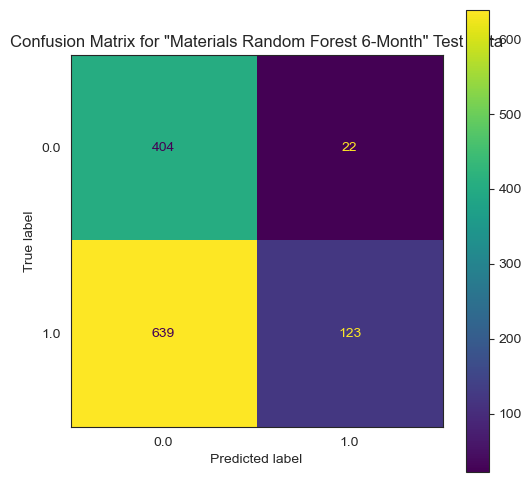

In [80]:
rfc_M_6.confusion_matrix()

In [82]:
# Feature importances
features_from_trees(rfc_M_6)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.08425946474435944)
('Interest_Rates', 0.06624483122987239)
('upper_bollinger_band', 0.05647182594119996)
('one_up_bollinger_band', 0.0559782070357368)
('ATR', 0.05414372937566589)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
0   0.040699  0.040983  0.039392  0.041195  0.035829  0.012049    0.045835   
1   0.045059  0.037639  0.041243  0.041978  0.038170  0.012814    0.086256   
2   0.044684  0.047517  0.049221  0.037692  0.038476  0.018599    0.084259   

   Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
0        0.045786  0.001906  0.002310  0.002576  0.002658  0.002460   
1        0.068121  0.004600  0.003199  0.003487  0.002384  0.002111   
2        0.066245  0.007813  0.006825  0.008300  0.007461  0.008210   

   garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
0          0.024941  0.025553               0.043605              0.043188   
1          0.043013  0.020295               0.064574              0.057533   
2          0.051423  0.026212               0.044672              0.048449   

   20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
0    0.043402               0.043763              0.044019  0.038942   
1    0.052246               0.046677              0.046711  0.052535   
2    0.050112               0.055978              0.056472  0.054144   

       MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
0  0.035165          0.011002   0.014734   0.016106   0.015579   0.018743   
1  0.035491          0.014280   0.014331   0.016913   0.009989   0.016217   
2  0.025330          0.018669   0.010301   0.006393   0.006515   0.015577   

    Month_1  Month_10  Month_11  Month_12   Month_2   Month_3   Month_4  \
0  0.016061  0.017082  0.011786  0.011582  0.010436  0.017176  0.017889   
1  0.006128  0.005296  0.003386  0.004402  0.005992  0.010716  0.007162   
2  0.006382  0.002914  0.002626  0.003457  0.003362  0.003820  0.004976   

    Month_5   Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
0  0.013351  0.012507  0.015742  0.012322  0.014496      0.019484   
1  0.003985  0.003015  0.008843  0.003602  0.005495      0.013768   
2  0.001372  0.001601  0.004396  0.002832  0.002741      0.013285   

   cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
0      0.020752      0.032916      0.022602            0.000284   
1      0.007219      0.021861      0.010870            0.000019   
2      0.007975      0.025541      0.012393            0.000835   

   day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
0            0.000412              0.000203             0.000370   
1            0.000106              0.000071             0.000064   
2            0.001254              0.000730             0.001089   

   day_of_week_Wednesday  
0               0.000127  
1               0.000131  
2               0.000871

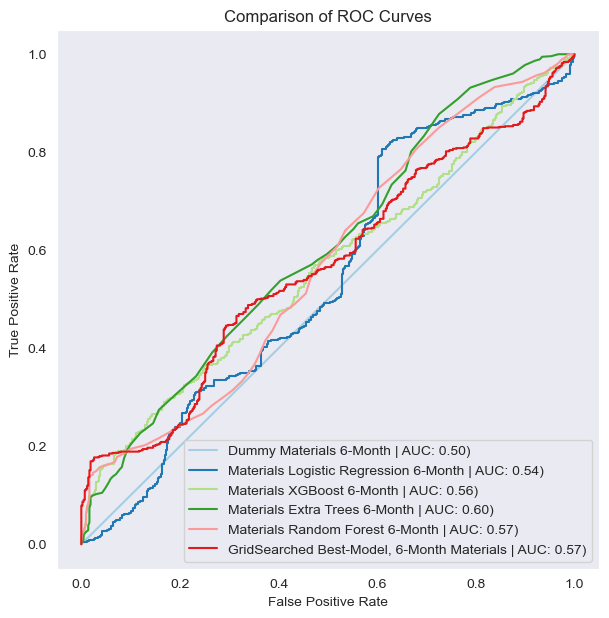

In [83]:
# Plotting the top models vs the dummy
compare_curves([dummy_M_6, logreg_M_6, XGBoost_M_6, etc_M_6, rfc_M_6, grid_M_6])

<hr style="border: 2px solid royalblue">

# Materials 12-Month XLB

In [89]:
# Create variables

X_train, X_test, y_train, y_test = select_data(materials_df, "Twelve")

# dummy_M_12 = dummy_model(Materials, "Materials", 12)
# logreg_M_12 = l_regr(Materials, "Materials", 12)
# rfc_M_12 = r_forest(Materials, "Materials", 12)
# etc_M_12 = extra_trees(Materials, "Materials", 12)
# XGBoost_M_12 = x_g_b(Materials, "Materials", 12)

# grid_M_12 = best_etc_grid(estimator=rfc_M_12.model, model_type=Materials, sector_name="Materials", time_period=12)

Materials.model_df.iloc[21:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': 7, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


name  train_accuracy  train_prec  \
24               Materials Extra Trees 12-Month        0.508217    0.920701   
26  GridSearched Best-Model, 12-Month Materials        0.465487    0.923752   
23             Materials Random Forest 12-Month        0.447282    0.916382   
25                   Materials XGBoost 12-Month        0.395449    0.934517   
22       Materials Logistic Regression 12-Month        0.624526    0.832776   
21                     Dummy Materials 12-Month        0.610367    0.590645   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
24      0.496509  0.527214       1.073965       0.426768   1.000000   
26      0.432962  0.429556       1.019392       0.417508   1.000000   
23      0.401137  0.420653       1.024766       0.478956   0.945122   
25      0.316916  0.347778       3.184510       0.486532   0.844444   
22      0.759862  0.717907       3.153911       0.617003   0.770035   
21      0.800000  0.678035      14.043810       0.643939   0.643939   

    test_recall   test_f1  test_logloss       AUC  
24     0.109804  0.197880      1.039132  0.665264  
26     0.095425  0.174224      1.186516  0.644143  
23     0.202614  0.333692      1.069748  0.618211  
25     0.248366  0.383838      2.837078  0.532899  
22     0.577778  0.660194      2.996129  0.711751  
21     1.000000  0.783410     12.833725  0.500000

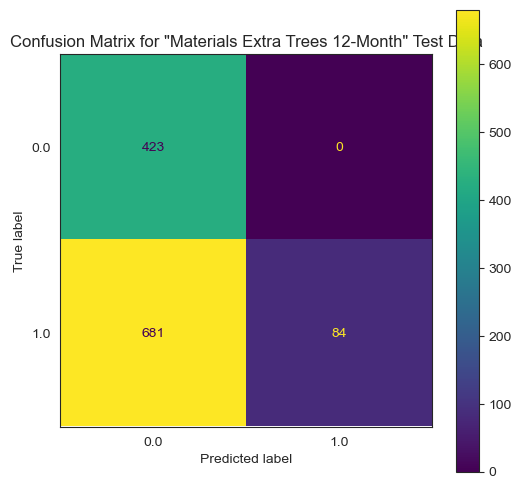

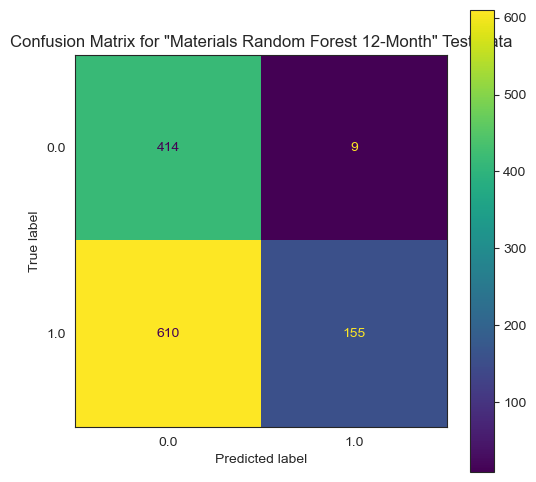

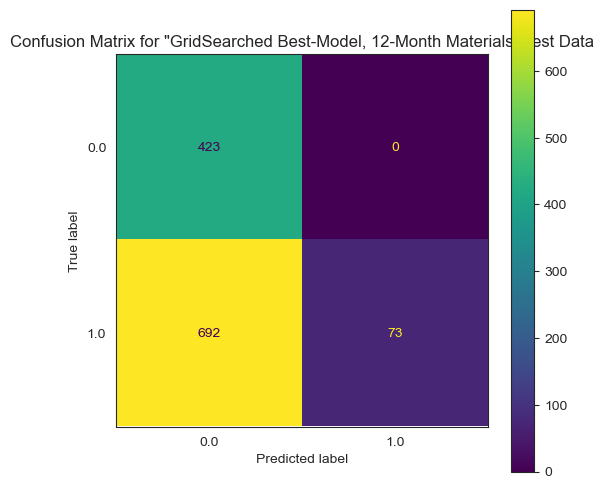

In [90]:
# rfc is willing to make more predictions, therefore will be gridsearched, 
# however, that made the model too restrictive in predicting 'buys'

etc_M_12.confusion_matrix(), rfc_M_12.confusion_matrix(), grid_M_12.confusion_matrix();

In [91]:
# Feature importances
features_from_trees(rfc_M_12)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.14289159129056794)
('garman_klass_vol', 0.08718218967590811)
('Interest_Rates', 0.08381710477547763)
('one_up_bollinger_band', 0.055495425467695404)
('Adj Close', 0.055379505311570376)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
0   0.040699  0.040983  0.039392  0.041195  0.035829  0.012049    0.045835   
1   0.045059  0.037639  0.041243  0.041978  0.038170  0.012814    0.086256   
2   0.044684  0.047517  0.049221  0.037692  0.038476  0.018599    0.084259   
3   0.055380  0.040460  0.047811  0.042939  0.042627  0.012170    0.142892   

   Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
0        0.045786  0.001906  0.002310  0.002576  0.002658  0.002460   
1        0.068121  0.004600  0.003199  0.003487  0.002384  0.002111   
2        0.066245  0.007813  0.006825  0.008300  0.007461  0.008210   
3        0.083817  0.003582  0.003404  0.003787  0.003270  0.003560   

   garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
0          0.024941  0.025553               0.043605              0.043188   
1          0.043013  0.020295               0.064574              0.057533   
2          0.051423  0.026212               0.044672              0.048449   
3          0.087182  0.010727               0.045383              0.051229   

   20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
0    0.043402               0.043763              0.044019  0.038942   
1    0.052246               0.046677              0.046711  0.052535   
2    0.050112               0.055978              0.056472  0.054144   
3    0.054337               0.055495              0.047246  0.037317   

       MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
0  0.035165          0.011002   0.014734   0.016106   0.015579   0.018743   
1  0.035491          0.014280   0.014331   0.016913   0.009989   0.016217   
2  0.025330          0.018669   0.010301   0.006393   0.006515   0.015577   
3  0.015096          0.014139   0.004136   0.008576   0.002334   0.006258   

    Month_1  Month_10  Month_11  Month_12   Month_2   Month_3   Month_4  \
0  0.016061  0.017082  0.011786  0.011582  0.010436  0.017176  0.017889   
1  0.006128  0.005296  0.003386  0.004402  0.005992  0.010716  0.007162   
2  0.006382  0.002914  0.002626  0.003457  0.003362  0.003820  0.004976   
3  0.001129  0.004226  0.001636  0.000897  0.000551  0.001103  0.000856   

    Month_5   Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
0  0.013351  0.012507  0.015742  0.012322  0.014496      0.019484   
1  0.003985  0.003015  0.008843  0.003602  0.005495      0.013768   
2  0.001372  0.001601  0.004396  0.002832  0.002741      0.013285   
3  0.002359  0.002978  0.001455  0.001493  0.002075      0.015416   

   cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
0      0.020752      0.032916      0.022602            0.000284   
1      0.007219      0.021861      0.010870            0.000019   
2      0.007975      0.025541      0.012393            0.000835   
3      0.011191      0.018374      0.007459            0.000460   

   day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
0            0.000412              0.000203             0.000370   
1            0.000106              0.000071             0.000064   
2            0.001254              0.000730             0.001089   
3            0.000371              0.000264             0.000330   

   day_of_week_Wednesday  
0               0.000127  
1               0.000131  
2               0.000871  
3               0.000222

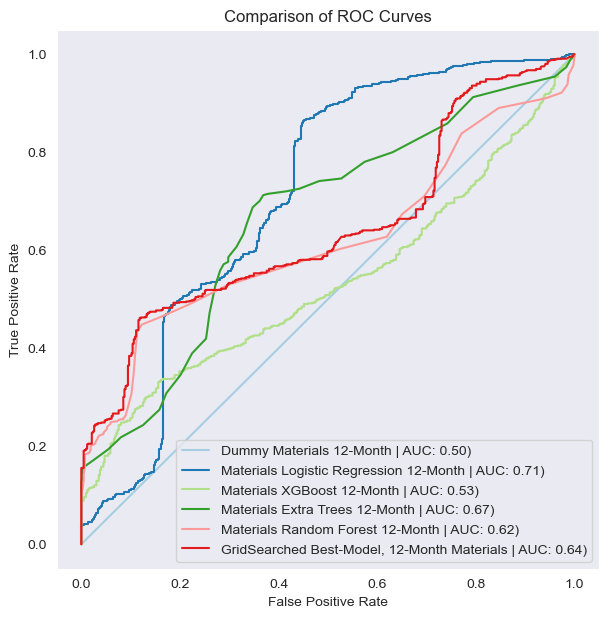

In [92]:
# Plotting the top models vs the dummy
compare_curves([dummy_M_12, logreg_M_12, XGBoost_M_12, etc_M_12, rfc_M_12, grid_M_12])

<hr style="border: 4px solid green">

# From here forward: (Materials Completed)
I will be using every function that I have created to abbreviate and expedite the process of iterating through models in different sectors. The markdown explanations will be extremely sparse, but I will summarize the findings at the end of the notebook.

In [101]:
# Create variables

X_train, X_test, y_train, y_test = select_data(energy_df, "One")

# Create Model Objects

# dummy_E = dummy_model(Energy, "Energy", 1)
# logreg3 = l_regr(Energy, "Energy", 1)
# rfc3 = r_forest(Energy, "Energy", 1)
# etc3 = extra_trees(Energy, "Energy", 1)
# XGBoost3 = x_g_b(Energy, "Energy", 1)

# grid = best_etc_grid(estimator=etc3.model, model_type=Energy, sector_name="Energy", time_period=1)
# grid = best_logreg_search(logreg3.model, Energy, "Energy", 1)
Energy.model_df.sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
5    Grid Searched LR, 1-Month Energy        0.480657    0.638938   
1  Energy Logistic Regression 1-Month        0.476106    0.594764   
4              Energy XGBoost 1-Month        0.479393    0.595046   
3          Energy Extra Trees 1-Month        0.468015    0.555999   
0                Dummy Energy 1-Month        0.579520    0.579520   
2        Energy Random Forest 1-Month        0.470291    0.650268   

   train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
5      0.636430  0.508980       2.536527       0.524411   0.598579   
1      0.625114  0.505379       2.033334       0.521886   0.594737   
4      0.412261  0.436229       2.071461       0.537879   0.588563   
3      0.421682  0.425181       0.865608       0.508418   0.570769   
0      1.000000  0.731959      15.155650       0.569024   0.569024   
2      0.417563  0.425924       0.895777       0.502525   0.555995   

   test_recall   test_f1  test_logloss       AUC  
5     0.498521  0.543987      1.220318  0.504900  
1     0.501479  0.544141      1.186381  0.505342  
4     0.624260  0.605887      1.535524  0.539819  
3     0.548817  0.559578      0.758352  0.506593  
0     1.000000  0.725322     15.533965  0.500000  
2     0.624260  0.588153      0.739038  0.507102

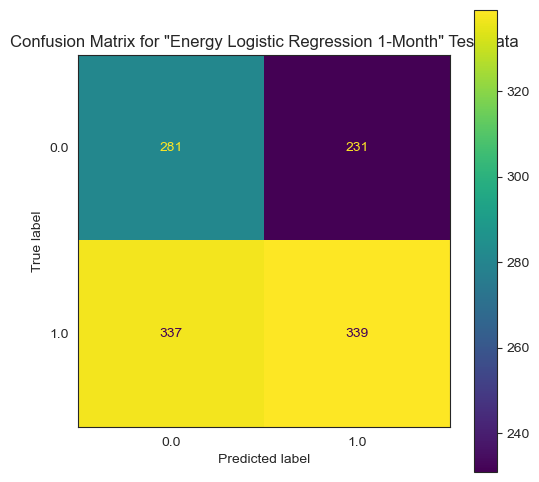

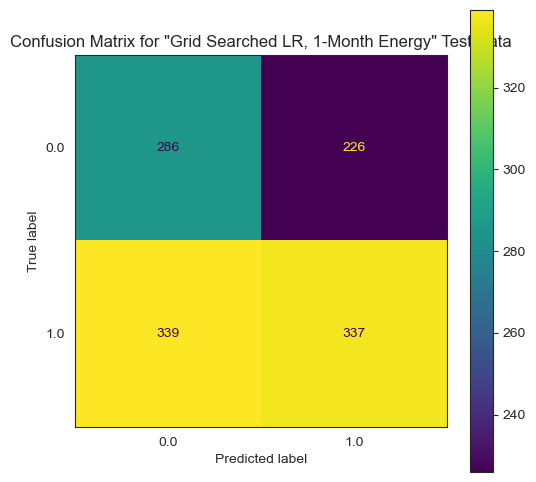

In [104]:
logreg3.confusion_matrix(), grid.confusion_matrix();

In [105]:
coefs_from_lr(grid)
Importance.df.rename(index={0:"Materials 1-Month", 1:"Materials 3-Month", 2:"Materials 6-Month", \
                            3:"Materials 12-Month", 4:"Energy 1-Month"}, inplace=True)
Importance.df[-4:]

Top 5 Feature Coefficients
('Low', 1.0841409701755764)
('Volume', 0.9215172608155845)
('High', 0.8318318223436707)
('upper_bollinger_band', 0.763237102323849)
('Close', 0.6617464465652212)


Adj Close     Close      High       Low      Open  \
Materials 3-Month    0.045059  0.037639  0.041243  0.041978  0.038170   
Materials 6-Month    0.044684  0.047517  0.049221  0.037692  0.038476   
Materials 12-Month   0.055380  0.040460  0.047811  0.042939  0.042627   
Energy 1-Month      -3.602734  0.661746  0.831832  1.084141  0.421949   

                      Volume  GDP_Filled  Interest_Rates    Mkt-RF       SMB  \
Materials 3-Month   0.012814    0.086256        0.068121  0.004600  0.003199   
Materials 6-Month   0.018599    0.084259        0.066245  0.007813  0.006825   
Materials 12-Month  0.012170    0.142892        0.083817  0.003582  0.003404   
Energy 1-Month      0.921517    0.617143       -0.015366 -0.054807  0.001270   

                         HML       RMW       CMA  garman_klass_vol       RSI  \
Materials 3-Month   0.003487  0.002384  0.002111          0.043013  0.020295   
Materials 6-Month   0.008300  0.007461  0.008210          0.051423  0.026212   
Materials 12-Month  0.003787  0.003270  0.003560          0.087182  0.010727   
Energy 1-Month      0.015740 -0.050304 -0.032324          0.333728 -0.135780   

                    lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Materials 3-Month                0.064574              0.057533    0.052246   
Materials 6-Month                0.044672              0.048449    0.050112   
Materials 12-Month               0.045383              0.051229    0.054337   
Energy 1-Month                  -0.759534             -0.359691    0.027723   

                    one_up_bollinger_band  upper_bollinger_band       ATR  \
Materials 3-Month                0.046677              0.046711  0.052535   
Materials 6-Month                0.055978              0.056472  0.054144   
Materials 12-Month               0.055495              0.047246  0.037317   
Energy 1-Month                   0.402156              0.763237 -0.501014   

                        MACD  dollar_volume(M)  Quarter_1  Quarter_2  \
Materials 3-Month   0.035491          0.014280   0.014331   0.016913   
Materials 6-Month   0.025330          0.018669   0.010301   0.006393   
Materials 12-Month  0.015096          0.014139   0.004136   0.008576   
Energy 1-Month     -0.017143         -1.017943   0.226504  -0.062688   

                    Quarter_3  Quarter_4   Month_1  Month_10  Month_11  \
Materials 3-Month    0.009989   0.016217  0.006128  0.005296  0.003386   
Materials 6-Month    0.006515   0.015577  0.006382  0.002914  0.002626   
Materials 12-Month   0.002334   0.006258  0.001129  0.004226  0.001636   
Energy 1-Month      -0.118079   0.123322 -0.240070 -0.116273  0.229782   

                    Month_12   Month_2   Month_3   Month_4   Month_5  \
Materials 3-Month   0.004402  0.005992  0.010716  0.007162  0.003985   
Materials 6-Month   0.003457  0.003362  0.003820  0.004976  0.001372   
Materials 12-Month  0.000897  0.000551  0.001103  0.000856  0.002359   
Energy 1-Month      0.009814  0.142202  0.324372  0.064943 -0.147654   

                     Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
Materials 3-Month   0.003015  0.008843  0.003602  0.005495      0.013768   
Materials 6-Month   0.001601  0.004396  0.002832  0.002741      0.013285   
Materials 12-Month  0.002978  0.001455  0.001493  0.002075      0.015416   
Energy 1-Month      0.020022 -0.214952 -0.033908  0.130782     -0.097465   

                    cycle_year_2  cycle_year_3  cycle_year_4  \
Materials 3-Month       0.007219      0.021861      0.010870   
Materials 6-Month       0.007975      0.025541      0.012393   
Materials 12-Month      0.011191      0.018374      0.007459   
Energy 1-Month         -0.202318      0.185208      0.283636   

                    day_of_week_Friday  day_of_week_Monday  \
Materials 3-Month             0.000019            0.000106   
Materials 6-Month             0.000835            0.001254   
Materials 12-Month            0.000460            0.000371   
Energy 1-Month             

<hr style="border: 2px solid darkgreen">

# XLE 3 Month

In [109]:
# Create variables

X_train, X_test, y_train, y_test = select_data(energy_df, "Three")

# Create Model Objects

# dummy_E_3month = dummy_model(Energy, "Energy", 3)
# logregE_3month = l_regr(Energy, "Energy", 3)
# rfcE_3month = r_forest(Energy, "Energy", 3)
# etcE_3month = extra_trees(Energy, "Energy", 3)
# XGBoostE_3month = x_g_b(Energy, "Energy", 3)

# grid_E_3month = best_etc_grid(estimator=etcE_3month.model, model_type=Energy, sector_name="Energy", time_period=3)

Energy.model_df.iloc[6:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.01, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


name  train_accuracy  train_prec  \
9                Energy Extra Trees 3-Month        0.553477    0.670291   
10                   Energy XGBoost 3-Month        0.548925    0.657230   
8              Energy Random Forest 3-Month        0.563338    0.679386   
11  GridSearched Best-Model, 3-Month Energy        0.601770    0.692574   
6                      Dummy Energy 3-Month        0.644501    0.644501   
7        Energy Logistic Regression 3-Month        0.563338    0.650349   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
9       0.650945  0.614124       0.946960       0.602694   0.681445   
10      0.632983  0.620070       2.201706       0.557239   0.618105   
8       0.647500  0.620616       0.886449       0.553872   0.616262   
11      0.769711  0.681793       0.744392       0.560606   0.591837   
6       1.000000  0.779999      12.813496       0.583333   0.583333   
7       0.769351  0.669038       2.804325       0.460438   0.542208   

    test_recall   test_f1  test_logloss       AUC  
9      0.598846  0.637481      0.800735  0.595156  
10     0.630592  0.624286      2.607554  0.562941  
8      0.623377  0.619799      0.846248  0.545618  
11     0.795094  0.678571      0.669803  0.596457  
6      1.000000  0.736842     15.018189  0.500000  
7      0.481962  0.510313      1.690673  0.479368

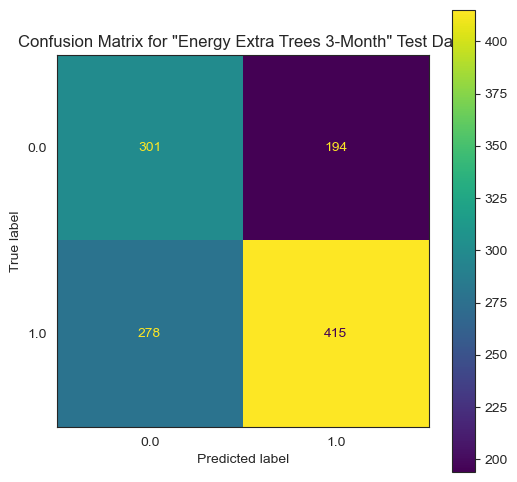

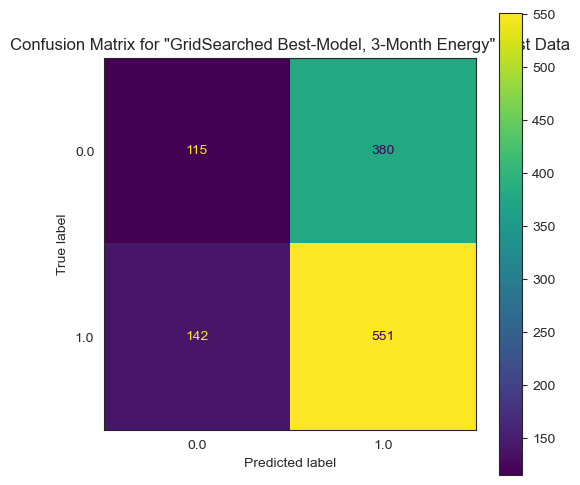

In [111]:
etcE_3month.confusion_matrix(), grid_E_3month.confusion_matrix();

In [112]:
# Feature Importances
features_from_trees(etcE_3month)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.054765497167846115)
('one_up_bollinger_band', 0.04614245732130835)
('upper_bollinger_band', 0.043523322727103554)
('Interest_Rates', 0.04309213019659832)
('Adj Close', 0.043060544883921616)


Adj Close     Close      High       Low      Open  \
Materials 6-Month    0.044684  0.047517  0.049221  0.037692  0.038476   
Materials 12-Month   0.055380  0.040460  0.047811  0.042939  0.042627   
Energy 1-Month      -3.602734  0.661746  0.831832  1.084141  0.421949   
5                    0.043061  0.041859  0.042582  0.040335  0.036844   

                      Volume  GDP_Filled  Interest_Rates    Mkt-RF       SMB  \
Materials 6-Month   0.018599    0.084259        0.066245  0.007813  0.006825   
Materials 12-Month  0.012170    0.142892        0.083817  0.003582  0.003404   
Energy 1-Month      0.921517    0.617143       -0.015366 -0.054807  0.001270   
5                   0.015475    0.054765        0.043092  0.009456  0.008871   

                         HML       RMW       CMA  garman_klass_vol       RSI  \
Materials 6-Month   0.008300  0.007461  0.008210          0.051423  0.026212   
Materials 12-Month  0.003787  0.003270  0.003560          0.087182  0.010727   
Energy 1-Month      0.015740 -0.050304 -0.032324          0.333728 -0.135780   
5                   0.009232  0.009010  0.009375          0.030239  0.026055   

                    lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Materials 6-Month                0.044672              0.048449    0.050112   
Materials 12-Month               0.045383              0.051229    0.054337   
Energy 1-Month                  -0.759534             -0.359691    0.027723   
5                                0.039053              0.039446    0.038173   

                    one_up_bollinger_band  upper_bollinger_band       ATR  \
Materials 6-Month                0.055978              0.056472  0.054144   
Materials 12-Month               0.055495              0.047246  0.037317   
Energy 1-Month                   0.402156              0.763237 -0.501014   
5                                0.046142              0.043523  0.039275   

                        MACD  dollar_volume(M)  Quarter_1  Quarter_2  \
Materials 6-Month   0.025330          0.018669   0.010301   0.006393   
Materials 12-Month  0.015096          0.014139   0.004136   0.008576   
Energy 1-Month     -0.017143         -1.017943   0.226504  -0.062688   
5                   0.028092          0.016221   0.019845   0.015638   

                    Quarter_3  Quarter_4   Month_1  Month_10  Month_11  \
Materials 6-Month    0.006515   0.015577  0.006382  0.002914  0.002626   
Materials 12-Month   0.002334   0.006258  0.001129  0.004226  0.001636   
Energy 1-Month      -0.118079   0.123322 -0.240070 -0.116273  0.229782   
5                    0.018728   0.017580  0.012812  0.010430  0.008547   

                    Month_12   Month_2   Month_3   Month_4   Month_5  \
Materials 6-Month   0.003457  0.003362  0.003820  0.004976  0.001372   
Materials 12-Month  0.000897  0.000551  0.001103  0.000856  0.002359   
Energy 1-Month      0.009814  0.142202  0.324372  0.064943 -0.147654   
5                   0.011430  0.006011  0.010435  0.006722  0.006941   

                     Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
Materials 6-Month   0.001601  0.004396  0.002832  0.002741      0.013285   
Materials 12-Month  0.002978  0.001455  0.001493  0.002075      0.015416   
Energy 1-Month      0.020022 -0.214952 -0.033908  0.130782     -0.097465   
5                   0.008028  0.006456  0.007546  0.009507      0.023272   

                    cycle_year_2  cycle_year_3  cycle_year_4  \
Materials 6-Month       0.007975      0.025541      0.012393   
Materials 12-Month      0.011191      0.018374      0.007459   
Energy 1-Month         -0.202318      0.185208      0.283636   
5                       0.018925      0.024317      0.027391   

                    day_of_week_Friday  day_of_week_Monday  \
Materials 6-Month             0.000835            0.001254   
Materials 12-Month            0.000460            0.000371   
Energy 1-Month                0.069981           -0.003960   
5                          

<hr style="border: 2px solid darkgreen">

# XLE 6 Month

In [116]:
# Create variables

X_train, X_test, y_train, y_test = select_data(energy_df, "Six")

# Create Model Objects

# dummy_E_6month = dummy_model(Energy, "Energy", 6)
# logregE_6month = l_regr(Energy, "Energy", 6)
# rfcE_6month = r_forest(Energy, "Energy", 6)
# etcE_6month = extra_trees(Energy, "Energy", 6)
# XGBoostE_6month = x_g_b(Energy, "Energy", 6)

# grid_E_6month = best_etc_grid(estimator=etcE_6month.model, model_type=Energy, sector_name="Energy", time_period=6)

Energy.model_df.iloc[12:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.01, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.2s finished


name  train_accuracy  train_prec  \
17  GridSearched Best-Model, 6-Month Energy        0.633628    0.761738   
15               Energy Extra Trees 6-Month        0.607585    0.720262   
12                     Dummy Energy 6-Month        0.692794    0.692794   
13       Energy Logistic Regression 6-Month        0.585588    0.718090   
14             Energy Random Forest 6-Month        0.548673    0.732530   
16                   Energy XGBoost 6-Month        0.528698    0.737179   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
17      0.737631  0.692901       0.840686       0.557239   0.593644   
15      0.693125  0.648924       0.874730       0.563973   0.592119   
12      1.000000  0.814016      11.072829       0.581650   0.581650   
13      0.767696  0.703172       3.572260       0.477273   0.546053   
14      0.654207  0.591113       1.794663       0.476431   0.535097   
16      0.586069  0.549979       2.611722       0.415825   0.498382   

    test_recall   test_f1  test_logloss       AUC  
17     0.756874  0.665394      0.706438  0.637641  
15     0.804631  0.682209      0.715975  0.642933  
12     1.000000  0.735498     15.078868  0.500000  
13     0.600579  0.572019      2.468886  0.466245  
14     0.761216  0.628435      0.863950  0.434468  
16     0.668596  0.571075      3.290831  0.340796

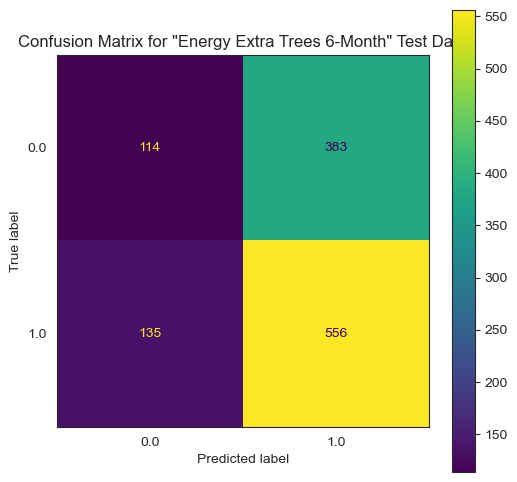

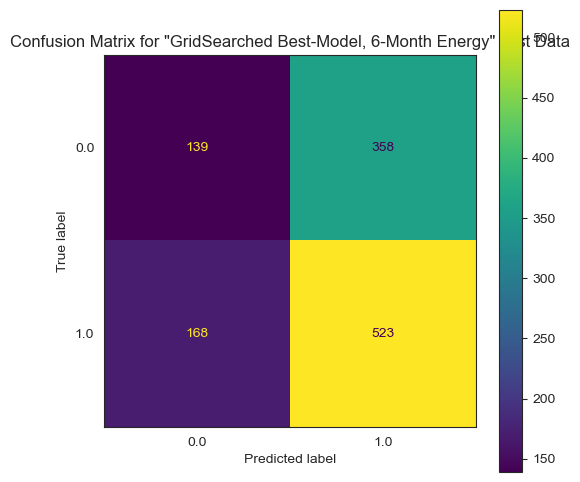

In [117]:
etcE_6month.confusion_matrix(), grid_E_6month.confusion_matrix();

In [118]:
# Importances
features_from_trees(grid_E_6month)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.08181016088659106)
('cycle_year_1', 0.07904698298218926)
('High', 0.05891990244657336)
('cycle_year_3', 0.0573663758775795)
('Low', 0.05586017894973062)


Adj Close     Close      High       Low      Open  \
Materials 12-Month   0.055380  0.040460  0.047811  0.042939  0.042627   
Energy 1-Month      -3.602734  0.661746  0.831832  1.084141  0.421949   
5                    0.043061  0.041859  0.042582  0.040335  0.036844   
6                    0.049943  0.052318  0.058920  0.055860  0.045228   

                      Volume  GDP_Filled  Interest_Rates    Mkt-RF       SMB  \
Materials 12-Month  0.012170    0.142892        0.083817  0.003582  0.003404   
Energy 1-Month      0.921517    0.617143       -0.015366 -0.054807  0.001270   
5                   0.015475    0.054765        0.043092  0.009456  0.008871   
6                   0.009921    0.081810        0.039753  0.000033  0.000020   

                         HML       RMW       CMA  garman_klass_vol       RSI  \
Materials 12-Month  0.003787  0.003270  0.003560          0.087182  0.010727   
Energy 1-Month      0.015740 -0.050304 -0.032324          0.333728 -0.135780   
5                   0.009232  0.009010  0.009375          0.030239  0.026055   
6                   0.000107  0.000089  0.000259          0.037946  0.001373   

                    lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Materials 12-Month               0.045383              0.051229    0.054337   
Energy 1-Month                  -0.759534             -0.359691    0.027723   
5                                0.039053              0.039446    0.038173   
6                                0.030413              0.040772    0.044298   

                    one_up_bollinger_band  upper_bollinger_band       ATR  \
Materials 12-Month               0.055495              0.047246  0.037317   
Energy 1-Month                   0.402156              0.763237 -0.501014   
5                                0.046142              0.043523  0.039275   
6                                0.043220              0.049754  0.028681   

                        MACD  dollar_volume(M)  Quarter_1  Quarter_2  \
Materials 12-Month  0.015096          0.014139   0.004136   0.008576   
Energy 1-Month     -0.017143         -1.017943   0.226504  -0.062688   
5                   0.028092          0.016221   0.019845   0.015638   
6                   0.003181          0.008068   0.020151   0.006071   

                    Quarter_3  Quarter_4   Month_1  Month_10  Month_11  \
Materials 12-Month   0.002334   0.006258  0.001129  0.004226  0.001636   
Energy 1-Month      -0.118079   0.123322 -0.240070 -0.116273  0.229782   
5                    0.018728   0.017580  0.012812  0.010430  0.008547   
6                    0.002654   0.036172  0.001766  0.003684  0.003242   

                    Month_12   Month_2   Month_3   Month_4   Month_5  \
Materials 12-Month  0.000897  0.000551  0.001103  0.000856  0.002359   
Energy 1-Month      0.009814  0.142202  0.324372  0.064943 -0.147654   
5                   0.011430  0.006011  0.010435  0.006722  0.006941   
6                   0.001552  0.001545  0.002331  0.004944  0.000000   

                     Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
Materials 12-Month  0.002978  0.001455  0.001493  0.002075      0.015416   
Energy 1-Month      0.020022 -0.214952 -0.033908  0.130782     -0.097465   
5                   0.008028  0.006456  0.007546  0.009507      0.023272   
6                   0.002054  0.000256  0.000503  0.000832      0.079047   

                    cycle_year_2  cycle_year_3  cycle_year_4  \
Materials 12-Month      0.011191      0.018374      0.007459   
Energy 1-Month         -0.202318      0.185208      0.283636   
5                       0.018925      0.024317      0.027391   
6                       0.046717      0.057366      0.047137   

                    day_of_week_Friday  day_of_week_Monday  \
Materials 12-Month            0.000460            0.000371   
Energy 1-Month                0.069981           -0.003960   
5                             0.003485            0.003856   
6                          

<hr style="border: 2px solid darkgreen">

# XLE 12 Month

In [124]:
# Create variables

X_train, X_test, y_train, y_test = select_data(energy_df, "Twelve")

# Create Model Objects

# dummy_E_12month = dummy_model(Energy, "Energy", 12)
# logregE_12month = l_regr(Energy, "Energy", 12)
# rfcE_12month = r_forest(Energy, "Energy", 12)
# etcE_12month = extra_trees(Energy, "Energy", 12)
# XGBoostE_12month = x_g_b(Energy, "Energy", 12)

# grid_E_12month = best_etc_grid(estimator=etcE_12month.model, model_type=Energy, sector_name="Energy", time_period=12)
# grid_E_12month = best_XGB_grid(XGBoostE_12month.model, Energy, "Energy", 12)
Energy.model_df.iloc[18:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
22                 Energy XGBoost 12-Month        0.524147    0.668951   
21             Energy Extra Trees 12-Month        0.636410    0.883401   
20           Energy Random Forest 12-Month        0.576738    0.670362   
19     Energy Logistic Regression 12-Month        0.549937    0.850298   
18                   Dummy Energy 12-Month        0.555499    0.539317   
23  Grid Searched XGBoost, 12-Month Energy        0.577750    0.859490   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
22      0.550380  0.544030       2.946381       0.641414   0.684350   
21      0.660809  0.650892       1.899941       0.606061   0.658602   
20      0.618834  0.582867       1.986396       0.617003   0.658599   
19      0.616641  0.596216       5.386415       0.515993   0.595556   
18      0.800000  0.641984      16.021427       0.592593   0.592593   
23      0.625587  0.648533       4.632931       0.496633   0.581288   

    test_recall   test_f1  test_logloss       AUC  
22     0.732955  0.707819      2.346408  0.690285  
21     0.696023  0.676796      1.097799  0.704270  
20     0.734375  0.694426      0.794680  0.696280  
19     0.571023  0.583031      3.380541  0.558755  
18     1.000000  0.744186     14.684451  0.500000  
23     0.538352  0.558997      3.225408  0.535338

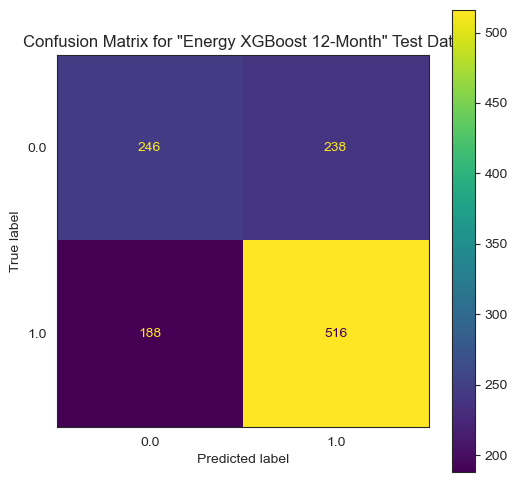

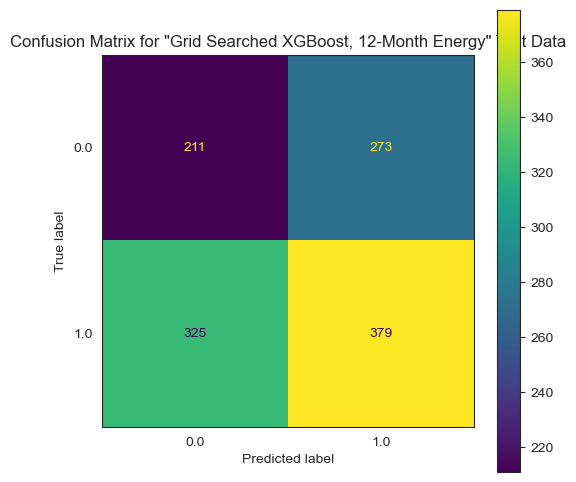

In [125]:
XGBoostE_12month.confusion_matrix(), grid_E_12month.confusion_matrix();

In [126]:
# Importances
features_from_trees(XGBoostE_12month)
Importance.df[-4:]

Top 5 Feature Importances
('High', 0.21922934)
('GDP_Filled', 0.14492995)
('cycle_year_1', 0.1318156)
('Month_12', 0.113516964)
('Month_7', 0.06460361)


Adj Close     Close      High       Low      Open    Volume  \
Energy 1-Month  -3.602734  0.661746  0.831832  1.084141  0.421949  0.921517   
5                0.043061  0.041859  0.042582  0.040335  0.036844  0.015475   
6                0.049943  0.052318  0.058920  0.055860  0.045228  0.009921   
7                0.040712  0.010563  0.219229  0.004043  0.003248  0.002477   

                GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
Energy 1-Month    0.617143       -0.015366 -0.054807  0.001270  0.015740   
5                 0.054765        0.043092  0.009456  0.008871  0.009232   
6                 0.081810        0.039753  0.000033  0.000020  0.000107   
7                 0.144930        0.019920  0.002032  0.002902  0.001423   

                     RMW       CMA  garman_klass_vol       RSI  \
Energy 1-Month -0.050304 -0.032324          0.333728 -0.135780   
5               0.009010  0.009375          0.030239  0.026055   
6               0.000089  0.000259          0.037946  0.001373   
7               0.001606  0.001173          0.004542  0.005412   

                lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Energy 1-Month              -0.759534             -0.359691    0.027723   
5                            0.039053              0.039446    0.038173   
6                            0.030413              0.040772    0.044298   
7                            0.017735              0.005673    0.007040   

                one_up_bollinger_band  upper_bollinger_band       ATR  \
Energy 1-Month               0.402156              0.763237 -0.501014   
5                            0.046142              0.043523  0.039275   
6                            0.043220              0.049754  0.028681   
7                            0.008067              0.017370  0.025171   

                    MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Energy 1-Month -0.017143         -1.017943   0.226504  -0.062688  -0.118079   
5               0.028092          0.016221   0.019845   0.015638   0.018728   
6               0.003181          0.008068   0.020151   0.006071   0.002654   
7               0.009113          0.003134   0.001003   0.006352   0.002510   

                Quarter_4   Month_1  Month_10  Month_11  Month_12   Month_2  \
Energy 1-Month   0.123322 -0.240070 -0.116273  0.229782  0.009814  0.142202   
5                0.017580  0.012812  0.010430  0.008547  0.011430  0.006011   
6                0.036172  0.001766  0.003684  0.003242  0.001552  0.001545   
7                0.000167  0.027999  0.001474  0.004997  0.113517  0.000000   

                 Month_3   Month_4   Month_5   Month_6   Month_7   Month_8  \
Energy 1-Month  0.324372  0.064943 -0.147654  0.020022 -0.214952 -0.033908   
5               0.010435  0.006722  0.006941  0.008028  0.006456  0.007546   
6               0.002331  0.004944  0.000000  0.002054  0.000256  0.000503   
7               0.006599  0.001589  0.002931  0.005359  0.064604  0.000000   

                 Month_9  cycle_year_1  cycle_year_2  cycle_year_3  \
Energy 1-Month  0.130782     -0.097465     -0.202318      0.185208   
5               0.009507      0.023272      0.018925      0.024317   
6               0.000832      0.079047      0.046717      0.057366   
7               0.029602      0.131816      0.016018      0.009649   

                cycle_year_4  day_of_week_Friday  day_of_week_Monday  \
Energy 1-Month      0.283636            0.069981           -0.003960   
5                   0.027391            0.003485            0.003856   
6                   0.047137            0.000000            0.000009   
7                   0.009653            0.000000            0.001115   

                day_of_week_Thursday  day_of_week_Tuesday  \
Energy 1-Month              0.043541             0.011222   
5                           0.004276             0.003781   
6                           0.000000             0.000000   
7                          

In [127]:
Importance.df.rename(index={5:"Energy 3-Month", 6:"Energy 6-Month", 7:"Energy 12-Month"}, inplace=True)

<hr style="border: 2px solid black">

#  Financials XLF

### 1 Month

In [135]:
# Create variables

X_train, X_test, y_train, y_test = select_data(financial_df, "One")


# Create Model Objects

# dummy_F_1 = dummy_model(Financials, "Financials", 1)
# logreg_F_1 = l_regr(Financials, "Financials", 1)
# rfc_F_1 = r_forest(Financials, "Financials", 1)
# etc_F_1 = extra_trees(Financials, "Financials", 1)
# XGBoost_F_1 = x_g_b(Financials, "Financials", 1)

# grid_F_2 = best_etc_grid(estimator=rfc_F_1.model, model_type=Financials, sector_name="Financials", time_period=1)
# grid_F_1 = best_XGB_grid(XGBoost_F_1.model, Financials, "Financials", 1)

Financials.model_df.sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
4                   Financials XGBoost 1-Month        0.470291    0.630174   
3               Financials Extra Trees 1-Month        0.469532    0.599745   
2             Financials Random Forest 1-Month        0.471808    0.645256   
6  GridSearched Best-Model, 1-Month Financials        0.471808    0.645256   
5    Grid Searched XGBoost, 1-Month Financials        0.469785    0.646752   
1       Financials Logistic Regression 1-Month        0.538812    0.597329   
0                     Dummy Financials 1-Month        0.596713    0.596713   

   train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
4      0.453053  0.448245       3.118634       0.496633   0.715953   
3      0.490559  0.488994       0.799407       0.478114   0.683128   
2      0.451991  0.452931       0.829340       0.452020   0.676829   
6      0.451991  0.452931       0.829340       0.452020   0.676829   
5      0.430243  0.436270       2.970577       0.462963   0.665116   
1      0.690691  0.612703       1.678847       0.534512   0.597015   
0      1.000000  0.745060      14.535936       0.596801   0.596801   

   test_recall   test_f1  test_logloss       AUC  
4     0.259520  0.380952      1.861044  0.560638  
3     0.234133  0.348739      0.757676  0.632323  
2     0.156559  0.254296      0.783980  0.617134  
6     0.156559  0.254296      0.783980  0.617134  
5     0.201693  0.309524      1.800344  0.555306  
1     0.677010  0.634501      0.700014  0.533672  
0     1.000000  0.747496     14.532753  0.500000

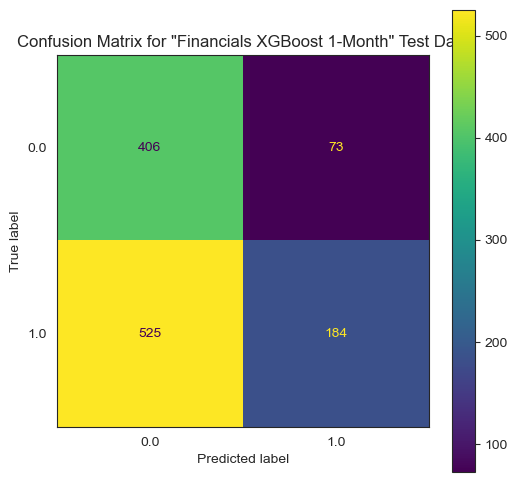

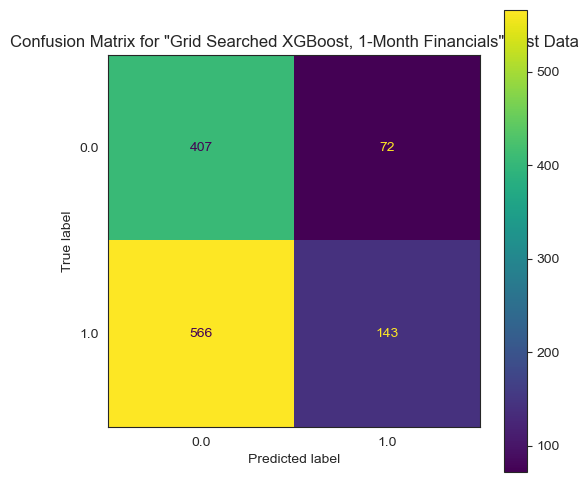

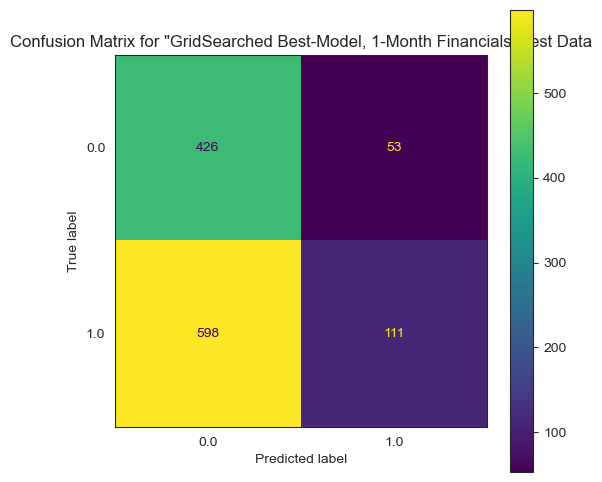

In [136]:
XGBoost_F_1.confusion_matrix(), grid_F_1.confusion_matrix(), grid_F_2.confusion_matrix();

In [137]:
# Importances
features_from_trees(XGBoost_F_1)
Importance.df[-4:]

Top 5 Feature Importances
('Month_3', 0.08182896)
('Month_1', 0.07455365)
('cycle_year_4', 0.07342589)
('Month_8', 0.062305428)
('Quarter_4', 0.043497544)


Adj Close     Close      High       Low      Open    Volume  \
Energy 3-Month    0.043061  0.041859  0.042582  0.040335  0.036844  0.015475   
Energy 6-Month    0.049943  0.052318  0.058920  0.055860  0.045228  0.009921   
Energy 12-Month   0.040712  0.010563  0.219229  0.004043  0.003248  0.002477   
8                 0.014678  0.026249  0.027709  0.017168  0.009393  0.011785   

                 GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
Energy 3-Month     0.054765        0.043092  0.009456  0.008871  0.009232   
Energy 6-Month     0.081810        0.039753  0.000033  0.000020  0.000107   
Energy 12-Month    0.144930        0.019920  0.002032  0.002902  0.001423   
8                  0.038927        0.017936  0.006451  0.004979  0.003734   

                      RMW       CMA  garman_klass_vol       RSI  \
Energy 3-Month   0.009010  0.009375          0.030239  0.026055   
Energy 6-Month   0.000089  0.000259          0.037946  0.001373   
Energy 12-Month  0.001606  0.001173          0.004542  0.005412   
8                0.004242  0.004707          0.006605  0.013711   

                 lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Energy 3-Month                0.039053              0.039446    0.038173   
Energy 6-Month                0.030413              0.040772    0.044298   
Energy 12-Month               0.017735              0.005673    0.007040   
8                             0.017239              0.015136    0.018093   

                 one_up_bollinger_band  upper_bollinger_band       ATR  \
Energy 3-Month                0.046142              0.043523  0.039275   
Energy 6-Month                0.043220              0.049754  0.028681   
Energy 12-Month               0.008067              0.017370  0.025171   
8                             0.020656              0.013465  0.015881   

                     MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Energy 3-Month   0.028092          0.016221   0.019845   0.015638   0.018728   
Energy 6-Month   0.003181          0.008068   0.020151   0.006071   0.002654   
Energy 12-Month  0.009113          0.003134   0.001003   0.006352   0.002510   
8                0.013495          0.005761   0.003165   0.043206   0.017696   

                 Quarter_4   Month_1  Month_10  Month_11  Month_12   Month_2  \
Energy 3-Month    0.017580  0.012812  0.010430  0.008547  0.011430  0.006011   
Energy 6-Month    0.036172  0.001766  0.003684  0.003242  0.001552  0.001545   
Energy 12-Month   0.000167  0.027999  0.001474  0.004997  0.113517  0.000000   
8                 0.043498  0.074554  0.039386  0.013763  0.033501  0.005972   

                  Month_3   Month_4   Month_5   Month_6   Month_7   Month_8  \
Energy 3-Month   0.010435  0.006722  0.006941  0.008028  0.006456  0.007546   
Energy 6-Month   0.002331  0.004944  0.000000  0.002054  0.000256  0.000503   
Energy 12-Month  0.006599  0.001589  0.002931  0.005359  0.064604  0.000000   
8                0.081829  0.028558  0.016841  0.010819  0.016109  0.062305   

                  Month_9  cycle_year_1  cycle_year_2  cycle_year_3  \
Energy 3-Month   0.009507      0.023272      0.018925      0.024317   
Energy 6-Month   0.000832      0.079047      0.046717      0.057366   
Energy 12-Month  0.029602      0.131816      0.016018      0.009649   
8                0.004842      0.042611      0.007198      0.028738   

                 cycle_year_4  day_of_week_Friday  day_of_week_Monday  \
Energy 3-Month       0.027391            0.003485            0.003856   
Energy 6-Month       0.047137            0.000000            0.000009   
Energy 12-Month      0.009653            0.000000            0.001115   
8                    0.073426            0.005334            0.007044   

                 day_of_week_Thursday  day_of_week_Tuesday  \
Energy 3-Month               0.004276             0.003781   
Energy 6-Month               0.000000             0.000000   
Energy 12-Month              0.00255

<hr style="border: 2px solid darkgreen">

# XLF 3 Month

In [142]:
# Create variables

X_train, X_test, y_train, y_test = select_data(financial_df, "Three")


# Create Model Objects

# dummy_F_3 = dummy_model(Financials, "Financials", 3)
# logreg_F_3 = l_regr(Financials, "Financials", 3)
# rfc_F_3 = r_forest(Financials, "Financials", 3)
# etc_F_3 = extra_trees(Financials, "Financials", 3)
# XGBoost_F_3 = x_g_b(Financials, "Financials", 3)

# grid_F_3 = best_etc_grid(estimator=etc_F_3.model, model_type=Financials, sector_name="Financials", time_period=3)

Financials.model_df.iloc[7:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.1, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.4s finished


name  train_accuracy  train_prec  \
10               Financials Extra Trees 3-Month        0.459671    0.615987   
9              Financials Random Forest 3-Month        0.452086    0.595561   
11                   Financials XGBoost 3-Month        0.415676    0.633232   
8        Financials Logistic Regression 3-Month        0.554235    0.619935   
7                      Dummy Financials 3-Month        0.645006    0.645006   
12  GridSearched Best-Model, 3-Month Financials        0.645006    0.645006   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
10      0.398116  0.445721       0.812976       0.468855   0.970930   
9       0.317126  0.361997       0.949610       0.483165   0.862348   
11      0.334558  0.400256       2.563376       0.526936   0.760722   
8       0.642176  0.612689       1.890102       0.632155   0.667608   
7       1.000000  0.774143      12.795269       0.667508   0.667508   
12      1.000000  0.774143       0.665018       0.667508   0.667508   

    test_recall   test_f1  test_logloss       AUC  
10     0.210593  0.346114      0.828621  0.733858  
9      0.268600  0.409615      0.959344  0.659845  
11     0.424968  0.545307      1.504583  0.610136  
8      0.894073  0.764420      0.834158  0.544010  
7      1.000000  0.800606     11.984211  0.500000  
12     1.000000  0.800606      0.638318  0.500000

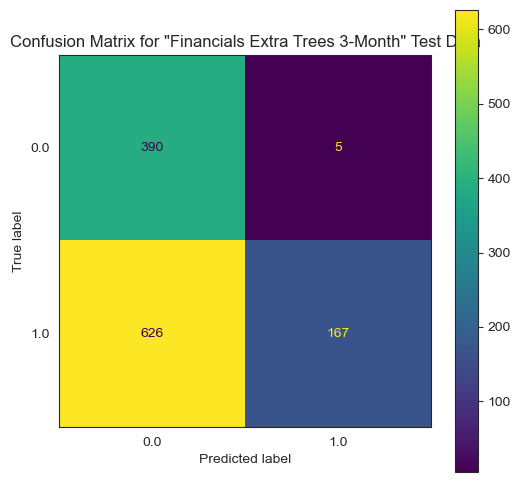

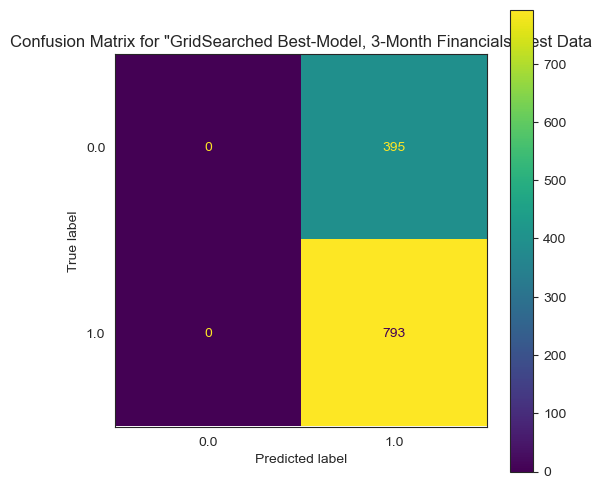

In [143]:
etc_F_3.confusion_matrix(), grid_F_3.confusion_matrix();

In [144]:
# Importances
features_from_trees(etc_F_3)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.06336575855736509)
('ATR', 0.058469107322594346)
('Interest_Rates', 0.04473396591798191)
('one_up_bollinger_band', 0.03981108563147123)
('lowest_bollinger_band', 0.03841627554793834)


Adj Close     Close      High       Low      Open    Volume  \
Energy 6-Month    0.049943  0.052318  0.058920  0.055860  0.045228  0.009921   
Energy 12-Month   0.040712  0.010563  0.219229  0.004043  0.003248  0.002477   
8                 0.014678  0.026249  0.027709  0.017168  0.009393  0.011785   
9                 0.036842  0.036193  0.037205  0.037380  0.035876  0.024085   

                 GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
Energy 6-Month     0.081810        0.039753  0.000033  0.000020  0.000107   
Energy 12-Month    0.144930        0.019920  0.002032  0.002902  0.001423   
8                  0.038927        0.017936  0.006451  0.004979  0.003734   
9                  0.063366        0.044734  0.007834  0.006990  0.008402   

                      RMW       CMA  garman_klass_vol       RSI  \
Energy 6-Month   0.000089  0.000259          0.037946  0.001373   
Energy 12-Month  0.001606  0.001173          0.004542  0.005412   
8                0.004242  0.004707          0.006605  0.013711   
9                0.006930  0.006993          0.033319  0.022585   

                 lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Energy 6-Month                0.030413              0.040772    0.044298   
Energy 12-Month               0.017735              0.005673    0.007040   
8                             0.017239              0.015136    0.018093   
9                             0.038416              0.037872    0.036697   

                 one_up_bollinger_band  upper_bollinger_band       ATR  \
Energy 6-Month                0.043220              0.049754  0.028681   
Energy 12-Month               0.008067              0.017370  0.025171   
8                             0.020656              0.013465  0.015881   
9                             0.039811              0.036862  0.058469   

                     MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Energy 6-Month   0.003181          0.008068   0.020151   0.006071   0.002654   
Energy 12-Month  0.009113          0.003134   0.001003   0.006352   0.002510   
8                0.013495          0.005761   0.003165   0.043206   0.017696   
9                0.028870          0.022627   0.022928   0.013895   0.011099   

                 Quarter_4   Month_1  Month_10  Month_11  Month_12   Month_2  \
Energy 6-Month    0.036172  0.001766  0.003684  0.003242  0.001552  0.001545   
Energy 12-Month   0.000167  0.027999  0.001474  0.004997  0.113517  0.000000   
8                 0.043498  0.074554  0.039386  0.013763  0.033501  0.005972   
9                 0.019863  0.012330  0.007318  0.012796  0.013642  0.011060   

                  Month_3   Month_4   Month_5   Month_6   Month_7   Month_8  \
Energy 6-Month   0.002331  0.004944  0.000000  0.002054  0.000256  0.000503   
Energy 12-Month  0.006599  0.001589  0.002931  0.005359  0.064604  0.000000   
8                0.081829  0.028558  0.016841  0.010819  0.016109  0.062305   
9                0.015198  0.013357  0.005560  0.007797  0.007199  0.005989   

                  Month_9  cycle_year_1  cycle_year_2  cycle_year_3  \
Energy 6-Month   0.000832      0.079047      0.046717      0.057366   
Energy 12-Month  0.029602      0.131816      0.016018      0.009649   
8                0.004842      0.042611      0.007198      0.028738   
9                0.010135      0.021088      0.015818      0.030199   

                 cycle_year_4  day_of_week_Friday  day_of_week_Monday  \
Energy 6-Month       0.047137            0.000000            0.000009   
Energy 12-Month      0.009653            0.000000            0.001115   
8                    0.073426            0.005334            0.007044   
9                    0.018302            0.002774            0.003078   

                 day_of_week_Thursday  day_of_week_Tuesday  \
Energy 6-Month               0.000000             0.000000   
Energy 12-Month              0.002552             0.002727   
8                            0.00409

<hr style="border: 2px solid darkgreen">

# XLF 6 Month

In [153]:
# Create variables

X_train, X_test, y_train, y_test = select_data(financial_df, "Six")

# Create Model Objects

# dummy_F_6month = dummy_model(Financials, "Financials", 6)
# logreg_F_6month = l_regr(Financials, "Financials", 6)
# rfc_F_6month = r_forest(Financials, "Financials", 6)
# etc_F_6month = extra_trees(Financials, "Financials", 6)
# XGBoost_F_6month = x_g_b(Financials, "Financials", 6)

# grid_F_6month = best_etc_grid(estimator=rfc_F_6month.model, model_type=Financials, sector_name="Financials", time_period=6)
# grid_F_6month2 = best_etc_grid(estimator=etc_F_6month.model, model_type=Financials, sector_name="Financials", time_period=6)

Financials.model_df.iloc[13:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.1, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.2s finished


name  train_accuracy  train_prec  \
15             Financials Random Forest 6-Month        0.408344    0.666239   
17                   Financials XGBoost 6-Month        0.447535    0.712225   
16               Financials Extra Trees 6-Month        0.468268    0.682769   
13                     Dummy Financials 6-Month        0.611884    0.550948   
18  GridSearched Best-Model, 6-Month Financials        0.649305    0.717020   
19  GridSearched Best-Model, 6-Month Financials        0.639697    0.718849   
14       Financials Logistic Regression 6-Month        0.598230    0.708903   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
15      0.298965  0.365130       1.061889       0.507576   1.000000   
17      0.390537  0.455941       3.076699       0.478114   0.991379   
16      0.474922  0.517100       0.870650       0.514310   0.938547   
13      0.800000  0.641277      13.989130       0.617845   0.617845   
18      0.867636  0.737401       0.686850       0.617845   0.617845   
19      0.849455  0.717681       0.676518       0.617845   0.617845   
14      0.643831  0.638226       3.466390       0.547138   0.615023   

    test_recall   test_f1  test_logloss       AUC  
15     0.202997  0.337486      0.944096  0.739135  
17     0.156676  0.270588      3.035870  0.630505  
16     0.228883  0.368018      0.857412  0.713623  
13     1.000000  0.763788     13.774258  0.500000  
18     1.000000  0.763788      0.666802  0.500000  
19     1.000000  0.763788      0.666801  0.500000  
14     0.713896  0.660782      0.966471  0.474748

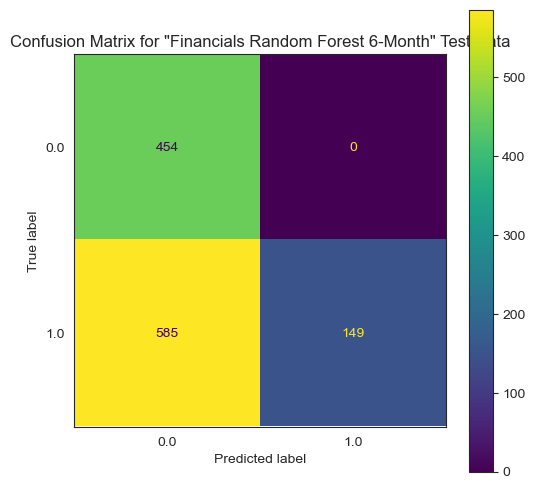

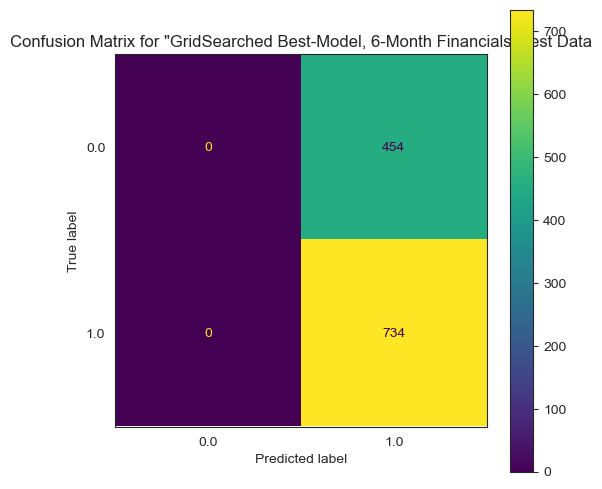

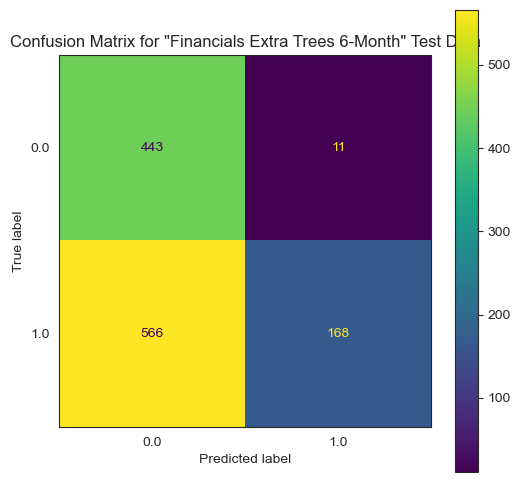

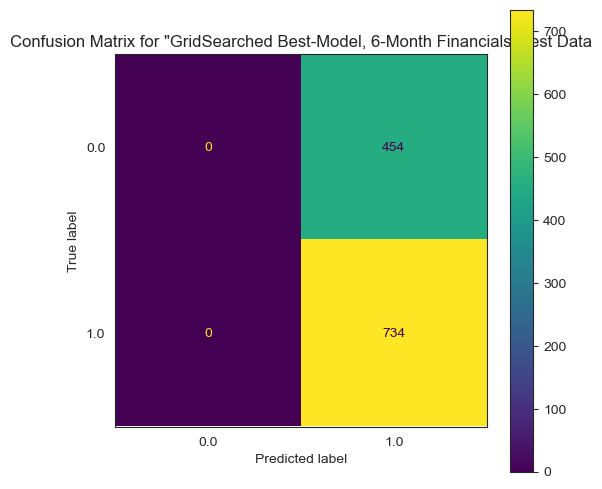

In [154]:
rfc_F_6month.confusion_matrix(), grid_F_6month.confusion_matrix(), etc_F_6month.confusion_matrix(), \
grid_F_6month2.confusion_matrix();

In [156]:
# Importance
features_from_trees(etc_F_6month)
Importance.df[-4:]

Top 5 Feature Importances
('cycle_year_3', 0.0693916942876134)
('GDP_Filled', 0.06931186080788249)
('ATR', 0.05902514899590546)
('Interest_Rates', 0.054442451232016645)
('garman_klass_vol', 0.04429958611979434)


Adj Close     Close      High       Low      Open    Volume  \
Energy 12-Month   0.040712  0.010563  0.219229  0.004043  0.003248  0.002477   
8                 0.014678  0.026249  0.027709  0.017168  0.009393  0.011785   
9                 0.036842  0.036193  0.037205  0.037380  0.035876  0.024085   
10                0.032473  0.037435  0.039508  0.039469  0.038776  0.019544   

                 GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
Energy 12-Month    0.144930        0.019920  0.002032  0.002902  0.001423   
8                  0.038927        0.017936  0.006451  0.004979  0.003734   
9                  0.063366        0.044734  0.007834  0.006990  0.008402   
10                 0.069312        0.054442  0.005097  0.005291  0.005248   

                      RMW       CMA  garman_klass_vol       RSI  \
Energy 12-Month  0.001606  0.001173          0.004542  0.005412   
8                0.004242  0.004707          0.006605  0.013711   
9                0.006930  0.006993          0.033319  0.022585   
10               0.005480  0.006170          0.044300  0.016259   

                 lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Energy 12-Month               0.017735              0.005673    0.007040   
8                             0.017239              0.015136    0.018093   
9                             0.038416              0.037872    0.036697   
10                            0.036657              0.038538    0.043285   

                 one_up_bollinger_band  upper_bollinger_band       ATR  \
Energy 12-Month               0.008067              0.017370  0.025171   
8                             0.020656              0.013465  0.015881   
9                             0.039811              0.036862  0.058469   
10                            0.037844              0.040616  0.059025   

                     MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Energy 12-Month  0.009113          0.003134   0.001003   0.006352   0.002510   
8                0.013495          0.005761   0.003165   0.043206   0.017696   
9                0.028870          0.022627   0.022928   0.013895   0.011099   
10               0.020513          0.020989   0.016971   0.008633   0.011680   

                 Quarter_4   Month_1  Month_10  Month_11  Month_12   Month_2  \
Energy 12-Month   0.000167  0.027999  0.001474  0.004997  0.113517  0.000000   
8                 0.043498  0.074554  0.039386  0.013763  0.033501  0.005972   
9                 0.019863  0.012330  0.007318  0.012796  0.013642  0.011060   
10                0.014565  0.006797  0.006581  0.007095  0.010813  0.007067   

                  Month_3   Month_4   Month_5   Month_6   Month_7   Month_8  \
Energy 12-Month  0.006599  0.001589  0.002931  0.005359  0.064604  0.000000   
8                0.081829  0.028558  0.016841  0.010819  0.016109  0.062305   
9                0.015198  0.013357  0.005560  0.007797  0.007199  0.005989   
10               0.007056  0.005256  0.003186  0.003346  0.003546  0.006477   

                  Month_9  cycle_year_1  cycle_year_2  cycle_year_3  \
Energy 12-Month  0.029602      0.131816      0.016018      0.009649   
8                0.004842      0.042611      0.007198      0.028738   
9                0.010135      0.021088      0.015818      0.030199   
10               0.006887      0.024432      0.022864      0.069392   

                 cycle_year_4  day_of_week_Friday  day_of_week_Monday  \
Energy 12-Month      0.009653            0.000000            0.001115   
8                    0.073426            0.005334            0.007044   
9                    0.018302            0.002774            0.003078   
10                   0.029781            0.002317            0.002214   

                 day_of_week_Thursday  day_of_week_Tuesday  \
Energy 12-Month              0.002552             0.002727   
8                            0.004093             0.003151   
9                            0.00353

<hr style="border: 2px solid darkgreen">

# XLF 12 Month

In [162]:
# Create variables

X_train, X_test, y_train, y_test = select_data(financial_df, "Twelve")

# Create Model Objects

# dummy_F_12month = dummy_model(Financials, "Financials", 12)
# logreg_F_12month = l_regr(Financials, "Financials", 12)
# rfc_F_12month = r_forest(Financials, "Financials", 12)
# etc_F_12month = extra_trees(Financials, "Financials", 12)
# XGBoost_F_12month = x_g_b(Financials, "Financials", 12)

# grid_F_12month = best_etc_grid(estimator=rfc_F_12month.model, model_type=Financials, sector_name="Financials", time_period=12)

Financials.model_df.iloc[20:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.1, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


name  train_accuracy  train_prec  \
23               Financials Extra Trees 12-Month        0.315297    0.691127   
22             Financials Random Forest 12-Month        0.318331    0.663155   
24                   Financials XGBoost 12-Month        0.329709    0.554144   
21       Financials Logistic Regression 12-Month        0.533249    0.735046   
20                     Dummy Financials 12-Month        0.554994    0.538306   
25  GridSearched Best-Model, 12-Month Financials        0.584829    0.825790   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
23      0.433099  0.405573       1.775857       0.634680   1.000000   
22      0.349520  0.303211       2.529491       0.667508   0.900000   
24      0.383455  0.324464       4.519128       0.694444   0.845679   
21      0.745705  0.655821       5.709282       0.505892   0.500000   
20      0.800000  0.629323      16.039654       0.494108   0.494108   
25      0.660209  0.578589       0.797096       0.494108   0.494108   

    test_recall   test_f1  test_logloss       AUC  
23     0.260647  0.413514      0.715127  0.766903  
22     0.367973  0.522370      0.820425  0.663471  
24     0.466780  0.601537      1.547164  0.668236  
21     0.833049  0.624920      0.924243  0.613798  
20     1.000000  0.661408     18.234205  0.500000  
25     1.000000  0.661408      0.759675  0.500000

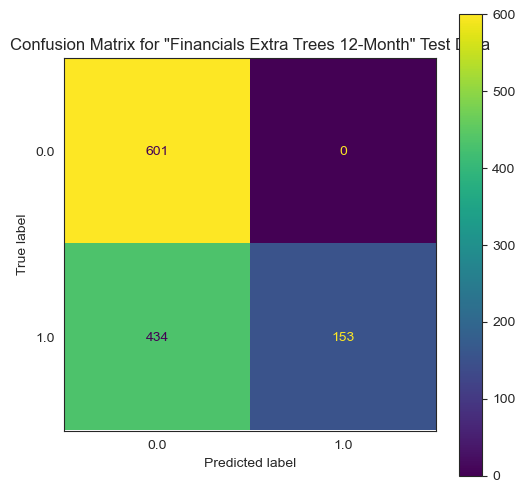

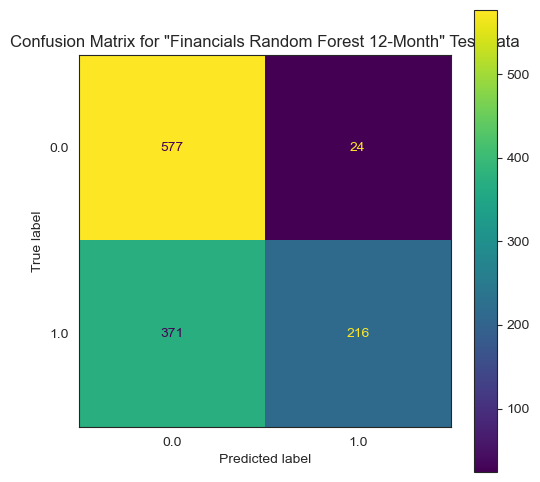

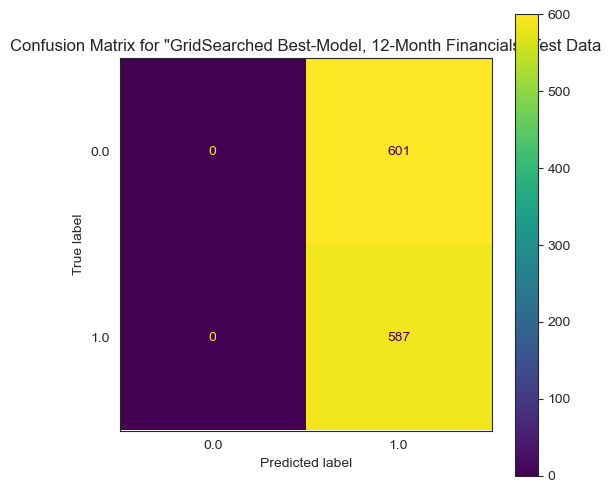

In [163]:
etc_F_12month.confusion_matrix(), rfc_F_12month.confusion_matrix(), grid_F_12month.confusion_matrix();

In [164]:
# Importance
features_from_trees(rfc_F_12month)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.1103120354375791)
('Interest_Rates', 0.06694511879628842)
('ATR', 0.06102712422218243)
('Low', 0.058113301956721715)
('garman_klass_vol', 0.05807681520735125)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
8    0.014678  0.026249  0.027709  0.017168  0.009393  0.011785    0.038927   
9    0.036842  0.036193  0.037205  0.037380  0.035876  0.024085    0.063366   
10   0.032473  0.037435  0.039508  0.039469  0.038776  0.019544    0.069312   
11   0.035300  0.056736  0.052324  0.058113  0.051705  0.031549    0.110312   

    Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
8         0.017936  0.006451  0.004979  0.003734  0.004242  0.004707   
9         0.044734  0.007834  0.006990  0.008402  0.006930  0.006993   
10        0.054442  0.005097  0.005291  0.005248  0.005480  0.006170   
11        0.066945  0.005332  0.004568  0.004922  0.003870  0.005717   

    garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
8           0.006605  0.013711               0.017239              0.015136   
9           0.033319  0.022585               0.038416              0.037872   
10          0.044300  0.016259               0.036657              0.038538   
11          0.058077  0.014156               0.048156              0.044325   

    20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
8     0.018093               0.020656              0.013465  0.015881   
9     0.036697               0.039811              0.036862  0.058469   
10    0.043285               0.037844              0.040616  0.059025   
11    0.038375               0.038614              0.045698  0.061027   

        MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
8   0.013495          0.005761   0.003165   0.043206   0.017696   0.043498   
9   0.028870          0.022627   0.022928   0.013895   0.011099   0.019863   
10  0.020513          0.020989   0.016971   0.008633   0.011680   0.014565   
11  0.019295          0.035509   0.009158   0.003927   0.003473   0.008970   

     Month_1  Month_10  Month_11  Month_12   Month_2   Month_3   Month_4  \
8   0.074554  0.039386  0.013763  0.033501  0.005972  0.081829  0.028558   
9   0.012330  0.007318  0.012796  0.013642  0.011060  0.015198  0.013357   
10  0.006797  0.006581  0.007095  0.010813  0.007067  0.007056  0.005256   
11  0.001595  0.002812  0.002599  0.001800  0.001271  0.002528  0.002709   

     Month_5   Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
8   0.016841  0.010819  0.016109  0.062305  0.004842      0.042611   
9   0.005560  0.007797  0.007199  0.005989  0.010135      0.021088   
10  0.003186  0.003346  0.003546  0.006477  0.006887      0.024432   
11  0.000459  0.001448  0.003003  0.003088  0.002402      0.010606   

    cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
8       0.007198      0.028738      0.073426            0.005334   
9       0.015818      0.030199      0.018302            0.002774   
10      0.022864      0.069392      0.029781            0.002317   
11      0.006241      0.025060      0.014118            0.000453   

    day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
8             0.007044              0.004093             0.003151   
9             0.003078              0.003531             0.003737   
10            0.002214              0.002388             0.002367   
11            0.000461              0.000580             0.000336   

    day_of_week_Wednesday  
8                0.004363  
9                0.002950  
10               0.002019  
11               0.000280

In [165]:
Importance.df.rename(index={8:"Financials 1-Month", 9:"Financials 3-Month",10:"Financials 6-Month",\
                           11:"Financials 12-Month"}, inplace=True)

<hr style="border: 2px solid black">

#  Industrials

### 1 Month

In [169]:
# Create variables

X_train, X_test, y_train, y_test = select_data(industrial_df, "One")


# Create Model Objects

# dummy_Ind_1 = dummy_model(Industrials, "Industrials", 1)
# logreg_Ind_1 = l_regr(Industrials, "Industrials", 1)
# rfc_Ind_1 = r_forest(Industrials, "Industrials", 1)
# etc_Ind_1 = extra_trees(Industrials, "Industrials", 1)
# XGBoost_Ind_1 = x_g_b(Industrials, "Industrials", 1)

# grid_Ind_1 = best_etc_grid(estimator=rfc_Ind_1.model, model_type=Industrials, sector_name="Industrials", time_period=1)

Industrials.model_df.sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.0s finished


name  train_accuracy  train_prec  \
5  GridSearched Best-Model, 1-Month Industrials        0.492035    0.713167   
2             Industrials Random Forest 1-Month        0.495828    0.711495   
3               Industrials Extra Trees 1-Month        0.512769    0.708727   
1       Industrials Logistic Regression 1-Month        0.527686    0.669961   
0                     Dummy Industrials 1-Month        0.620986    0.620986   
4                   Industrials XGBoost 1-Month        0.485967    0.700668   

   train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
5      0.411842  0.440730       1.182878       0.523569   0.763780   
2      0.420619  0.448566       1.023281       0.488215   0.750000   
3      0.474881  0.486506       0.918914       0.532828   0.677262   
1      0.586541  0.568967       1.354555       0.552189   0.602439   
0      1.000000  0.765569      13.661046       0.589226   0.589226   
4      0.432411  0.444633       2.946968       0.478956   0.587097   

   test_recall   test_f1  test_logloss       AUC  
5     0.277143  0.406709      0.835841  0.654516  
2     0.197143  0.312217      0.875377  0.647339  
3     0.395714  0.499549      0.731747  0.619890  
1     0.705714  0.650000      0.818739  0.543416  
0     1.000000  0.741525     14.805810  0.500000  
4     0.390000  0.468670      1.427548  0.487840

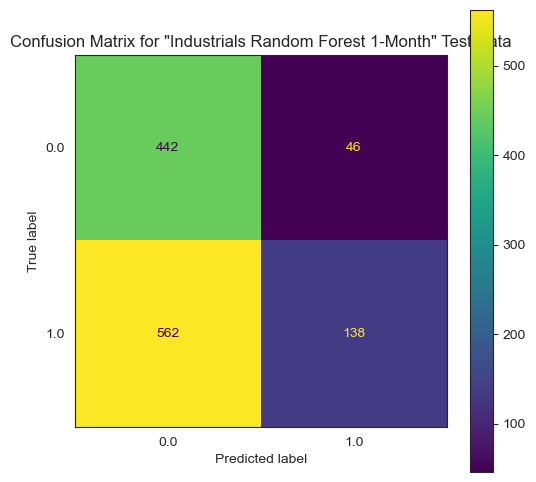

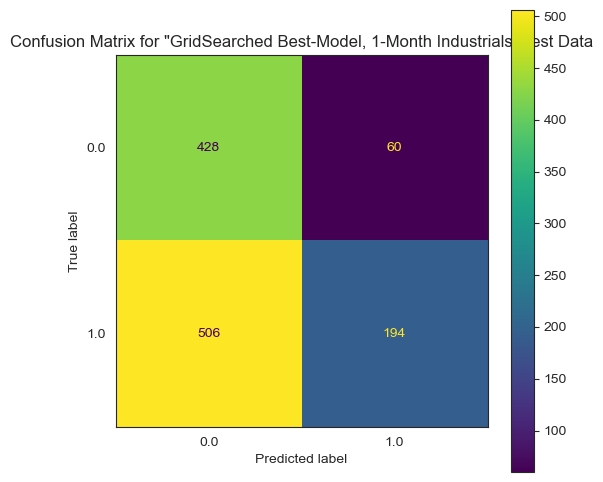

In [170]:
rfc_Ind_1.confusion_matrix(), grid_Ind_1.confusion_matrix();

In [171]:
# Importance
features_from_trees(grid_Ind_1)
Importance.df[-4:]

Top 5 Feature Importances
('ATR', 0.05618930378683538)
('one_up_bollinger_band', 0.05305819758836776)
('20_day_SMA', 0.051432377681518225)
('lower_bollinger_band', 0.04991892085179723)
('upper_bollinger_band', 0.04971519702615952)


Adj Close     Close      High       Low      Open  \
Financials 3-Month    0.036842  0.036193  0.037205  0.037380  0.035876   
Financials 6-Month    0.032473  0.037435  0.039508  0.039469  0.038776   
Financials 12-Month   0.035300  0.056736  0.052324  0.058113  0.051705   
12                    0.046148  0.045451  0.043040  0.043953  0.038952   

                       Volume  GDP_Filled  Interest_Rates    Mkt-RF       SMB  \
Financials 3-Month   0.024085    0.063366        0.044734  0.007834  0.006990   
Financials 6-Month   0.019544    0.069312        0.054442  0.005097  0.005291   
Financials 12-Month  0.031549    0.110312        0.066945  0.005332  0.004568   
12                   0.027252    0.035049        0.046597  0.018196  0.017790   

                          HML       RMW       CMA  garman_klass_vol       RSI  \
Financials 3-Month   0.008402  0.006930  0.006993          0.033319  0.022585   
Financials 6-Month   0.005248  0.005480  0.006170          0.044300  0.016259   
Financials 12-Month  0.004922  0.003870  0.005717          0.058077  0.014156   
12                   0.018697  0.017379  0.016535          0.031388  0.037953   

                     lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Financials 3-Month                0.038416              0.037872    0.036697   
Financials 6-Month                0.036657              0.038538    0.043285   
Financials 12-Month               0.048156              0.044325    0.038375   
12                                0.049165              0.049919    0.051432   

                     one_up_bollinger_band  upper_bollinger_band       ATR  \
Financials 3-Month                0.039811              0.036862  0.058469   
Financials 6-Month                0.037844              0.040616  0.059025   
Financials 12-Month               0.038614              0.045698  0.061027   
12                                0.053058              0.049715  0.056189   

                         MACD  dollar_volume(M)  Quarter_1  Quarter_2  \
Financials 3-Month   0.028870          0.022627   0.022928   0.013895   
Financials 6-Month   0.020513          0.020989   0.016971   0.008633   
Financials 12-Month  0.019295          0.035509   0.009158   0.003927   
12                   0.046925          0.026374   0.008689   0.007933   

                     Quarter_3  Quarter_4   Month_1  Month_10  Month_11  \
Financials 3-Month    0.011099   0.019863  0.012330  0.007318  0.012796   
Financials 6-Month    0.011680   0.014565  0.006797  0.006581  0.007095   
Financials 12-Month   0.003473   0.008970  0.001595  0.002812  0.002599   
12                    0.005140   0.008928  0.006805  0.006131  0.006743   

                     Month_12   Month_2   Month_3   Month_4   Month_5  \
Financials 3-Month   0.013642  0.011060  0.015198  0.013357  0.005560   
Financials 6-Month   0.010813  0.007067  0.007056  0.005256  0.003186   
Financials 12-Month  0.001800  0.001271  0.002528  0.002709  0.000459   
12                   0.003566  0.004561  0.006810  0.004798  0.006085   

                      Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
Financials 3-Month   0.007797  0.007199  0.005989  0.010135      0.021088   
Financials 6-Month   0.003346  0.003546  0.006477  0.006887      0.024432   
Financials 12-Month  0.001448  0.003003  0.003088  0.002402      0.010606   
12                   0.004403  0.006590  0.003258  0.005686      0.005143   

                     cycle_year_2  cycle_year_3  cycle_year_4  \
Financials 3-Month       0.015818      0.030199      0.018302   
Financials 6-Month       0.022864      0.069392      0.029781   
Financials 12-Month      0.006241      0.025060      0.014118   
12                       0.006827      0.007563      0.006647   

                     day_of_week_Friday  day_of_week_Monday  \
Financials 3-Month             0.002774            0.003078   
Financials 6-Month             0.002317            0.002214   
Financials 12-Month            0.0004

<hr style="border: 2px solid darkgreen">

# XLI 3 Month

In [176]:
# Create variables

X_train, X_test, y_train, y_test = select_data(industrial_df, "Three")


# Create Model Objects

# dummy_Ind_3 = dummy_model(Industrials, "Industrials", 3)
# logreg_Ind_3 = l_regr(Industrials, "Industrials", 3)
# rfc_Ind_3 = r_forest(Industrials, "Industrials", 3)
# etc_Ind_3 = extra_trees(Industrials, "Industrials", 3)
# XGBoost_Ind_3 = x_g_b(Industrials, "Industrials", 3)

# grid_Ind_3 = best_etc_grid(estimator=etc_Ind_3.model, model_type=Industrials, sector_name="Industrials", time_period=3)

Industrials.model_df.iloc[6:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.01, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


name  train_accuracy  train_prec  \
8              Industrials Random Forest 3-Month        0.488748    0.793511   
9                Industrials Extra Trees 3-Month        0.549431    0.815025   
10                   Industrials XGBoost 3-Month        0.506953    0.823563   
11  GridSearched Best-Model, 3-Month Industrials        0.543616    0.827373   
6                      Dummy Industrials 3-Month        0.649810    0.573451   
7        Industrials Logistic Regression 3-Month        0.556511    0.786290   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
8       0.437685  0.464331       0.935639       0.500000   0.966480   
9       0.531659  0.535306       0.917476       0.500842   0.855932   
10      0.439340  0.481868       2.511331       0.505051   0.668616   
11      0.543349  0.527947       0.735170       0.636364   0.657718   
6       0.800000  0.665825      12.622114       0.640572   0.640572   
7       0.575534  0.575306       1.802966       0.544613   0.613872   

    test_recall   test_f1  test_logloss       AUC  
8      0.227332  0.368085      0.914622  0.741533  
9      0.265440  0.405216      0.721921  0.755914  
10     0.450723  0.538462      1.932033  0.529803  
11     0.901445  0.760532      0.630171  0.639715  
6      1.000000  0.780913     12.955084  0.500000  
7      0.779238  0.686740      1.090605  0.480888

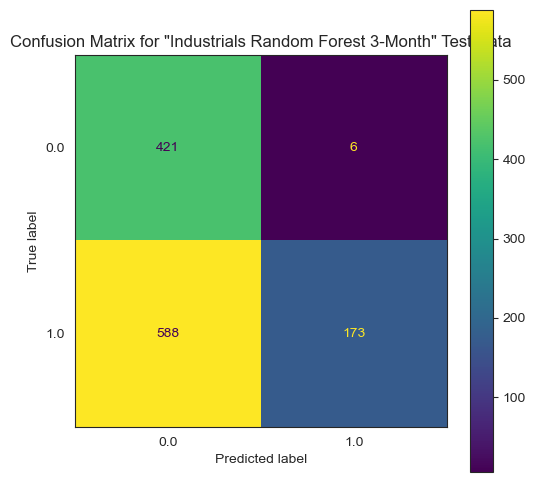

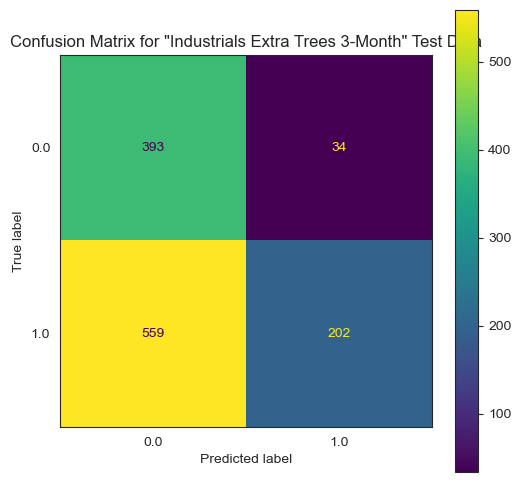

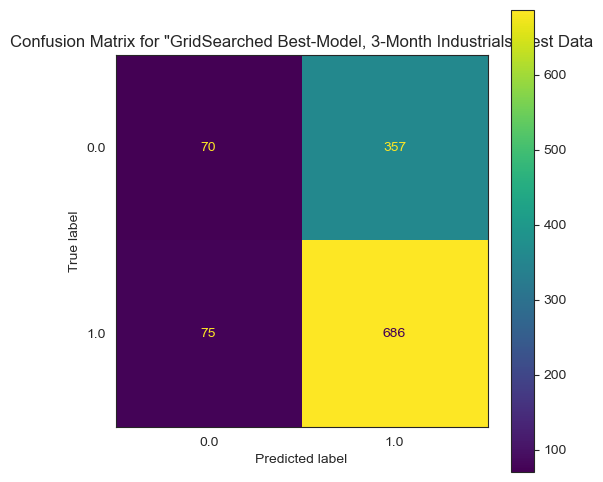

In [177]:
rfc_Ind_3.confusion_matrix(), etc_Ind_3.confusion_matrix(), grid_Ind_3.confusion_matrix();

In [178]:
# Importance
features_from_trees(etc_Ind_3)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.059581660559102634)
('Interest_Rates', 0.047080598184509076)
('one_up_bollinger_band', 0.041178263231718824)
('lower_bollinger_band', 0.039584848933903724)
('20_day_SMA', 0.03948835922023298)


Adj Close     Close      High       Low      Open  \
Financials 6-Month    0.032473  0.037435  0.039508  0.039469  0.038776   
Financials 12-Month   0.035300  0.056736  0.052324  0.058113  0.051705   
12                    0.046148  0.045451  0.043040  0.043953  0.038952   
13                    0.039215  0.037629  0.038399  0.036864  0.036082   

                       Volume  GDP_Filled  Interest_Rates    Mkt-RF       SMB  \
Financials 6-Month   0.019544    0.069312        0.054442  0.005097  0.005291   
Financials 12-Month  0.031549    0.110312        0.066945  0.005332  0.004568   
12                   0.027252    0.035049        0.046597  0.018196  0.017790   
13                   0.016254    0.059582        0.047081  0.008191  0.007254   

                          HML       RMW       CMA  garman_klass_vol       RSI  \
Financials 6-Month   0.005248  0.005480  0.006170          0.044300  0.016259   
Financials 12-Month  0.004922  0.003870  0.005717          0.058077  0.014156   
12                   0.018697  0.017379  0.016535          0.031388  0.037953   
13                   0.008188  0.007817  0.007490          0.032579  0.024043   

                     lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Financials 6-Month                0.036657              0.038538    0.043285   
Financials 12-Month               0.048156              0.044325    0.038375   
12                                0.049165              0.049919    0.051432   
13                                0.039184              0.039585    0.039488   

                     one_up_bollinger_band  upper_bollinger_band       ATR  \
Financials 6-Month                0.037844              0.040616  0.059025   
Financials 12-Month               0.038614              0.045698  0.061027   
12                                0.053058              0.049715  0.056189   
13                                0.041178              0.033998  0.038810   

                         MACD  dollar_volume(M)  Quarter_1  Quarter_2  \
Financials 6-Month   0.020513          0.020989   0.016971   0.008633   
Financials 12-Month  0.019295          0.035509   0.009158   0.003927   
12                   0.046925          0.026374   0.008689   0.007933   
13                   0.029284          0.015198   0.018186   0.022479   

                     Quarter_3  Quarter_4   Month_1  Month_10  Month_11  \
Financials 6-Month    0.011680   0.014565  0.006797  0.006581  0.007095   
Financials 12-Month   0.003473   0.008970  0.001595  0.002812  0.002599   
12                    0.005140   0.008928  0.006805  0.006131  0.006743   
13                    0.012530   0.016933  0.014295  0.009113  0.007266   

                     Month_12   Month_2   Month_3   Month_4   Month_5  \
Financials 6-Month   0.010813  0.007067  0.007056  0.005256  0.003186   
Financials 12-Month  0.001800  0.001271  0.002528  0.002709  0.000459   
12                   0.003566  0.004561  0.006810  0.004798  0.006085   
13                   0.008315  0.008006  0.014352  0.008758  0.006177   

                      Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
Financials 6-Month   0.003346  0.003546  0.006477  0.006887      0.024432   
Financials 12-Month  0.001448  0.003003  0.003088  0.002402      0.010606   
12                   0.004403  0.006590  0.003258  0.005686      0.005143   
13                   0.006902  0.011540  0.006364  0.008822      0.023164   

                     cycle_year_2  cycle_year_3  cycle_year_4  \
Financials 6-Month       0.022864      0.069392      0.029781   
Financials 12-Month      0.006241      0.025060      0.014118   
12                       0.006827      0.007563      0.006647   
13                       0.028032      0.039251      0.028750   

                     day_of_week_Friday  day_of_week_Monday  \
Financials 6-Month             0.002317            0.002214   
Financials 12-Month            0.000453            0.000461   
12                             0.0021

<hr style="border: 2px solid darkgreen">

# XLI 6 Month

In [184]:
# Create variables

X_train, X_test, y_train, y_test = select_data(industrial_df, "Six")


# Create Model Objects

# dummy_Ind_6 = dummy_model(Industrials, "Industrials", 6)
# logreg_Ind_6 = l_regr(Industrials, "Industrials", 6)
# rfc_Ind_6 = r_forest(Industrials, "Industrials", 6)
# etc_Ind_6 = extra_trees(Industrials, "Industrials", 6)
# XGBoost_Ind_6 = x_g_b(Industrials, "Industrials", 6)

# grid_Ind_6 = best_etc_grid(estimator=etc_Ind_6.model, model_type=Industrials, sector_name="Industrials", time_period=6)

Industrials.model_df.iloc[12:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.01, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.4s finished


name  train_accuracy  train_prec  \
14             Industrials Random Forest 6-Month        0.425790    0.850129   
15               Industrials Extra Trees 6-Month        0.580278    0.908441   
16                   Industrials XGBoost 6-Month        0.442225    0.844830   
12                     Dummy Industrials 6-Month        0.647788    0.594943   
17  GridSearched Best-Model, 6-Month Industrials        0.571681    0.915010   
13       Industrials Logistic Regression 6-Month        0.541846    0.846671   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
14      0.323543  0.431109       1.046989       0.497475   0.956284   
15      0.531628  0.580356       0.922551       0.494108   0.950276   
16      0.336117  0.433050       2.682815       0.462963   0.791667   
12      0.800000  0.678458      12.695021       0.643098   0.643098   
17      0.517275  0.541861       0.766558       0.643098   0.643098   
13      0.498796  0.581209       3.224565       0.579125   0.622449   

    test_recall   test_f1  test_logloss       AUC  
14     0.229058  0.369588      1.026597  0.654387  
15     0.225131  0.364021      0.786628  0.614192  
16     0.223822  0.348980      1.911585  0.560024  
12     1.000000  0.782787     12.864065  0.500000  
17     1.000000  0.782787      0.667658  0.538466  
13     0.878272  0.728556      1.601169  0.471559

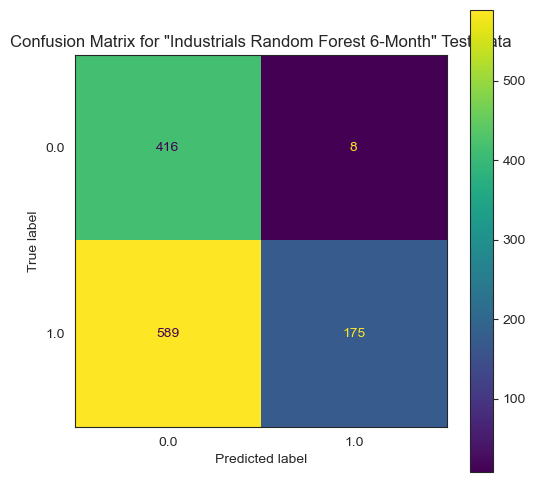

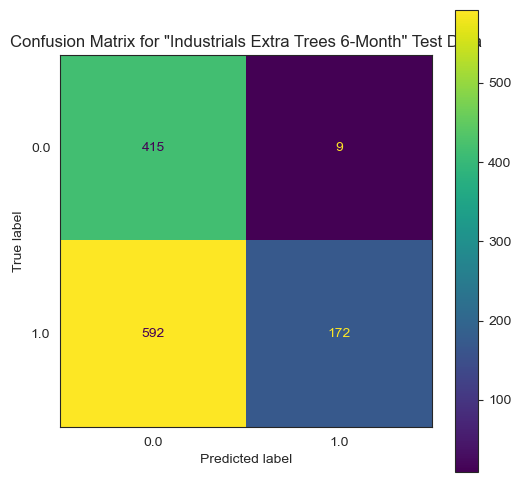

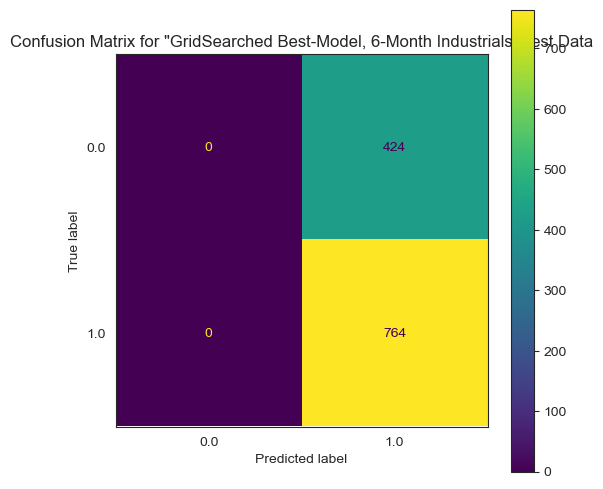

In [185]:
rfc_Ind_6.confusion_matrix(), etc_Ind_6.confusion_matrix(), grid_Ind_6.confusion_matrix();

In [187]:
# Importance
features_from_trees(etc_Ind_6)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.0851587766565511)
('Interest_Rates', 0.062048248792284336)
('garman_klass_vol', 0.04909828937425032)
('cycle_year_3', 0.04905724878350668)
('cycle_year_4', 0.046964195342513525)


Adj Close     Close      High       Low      Open  \
Financials 12-Month   0.035300  0.056736  0.052324  0.058113  0.051705   
12                    0.046148  0.045451  0.043040  0.043953  0.038952   
13                    0.039215  0.037629  0.038399  0.036864  0.036082   
14                    0.035610  0.036473  0.035471  0.036164  0.035617   

                       Volume  GDP_Filled  Interest_Rates    Mkt-RF       SMB  \
Financials 12-Month  0.031549    0.110312        0.066945  0.005332  0.004568   
12                   0.027252    0.035049        0.046597  0.018196  0.017790   
13                   0.016254    0.059582        0.047081  0.008191  0.007254   
14                   0.017075    0.085159        0.062048  0.005332  0.004850   

                          HML       RMW       CMA  garman_klass_vol       RSI  \
Financials 12-Month  0.004922  0.003870  0.005717          0.058077  0.014156   
12                   0.018697  0.017379  0.016535          0.031388  0.037953   
13                   0.008188  0.007817  0.007490          0.032579  0.024043   
14                   0.005767  0.005768  0.006137          0.049098  0.016705   

                     lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Financials 12-Month               0.048156              0.044325    0.038375   
12                                0.049165              0.049919    0.051432   
13                                0.039184              0.039585    0.039488   
14                                0.036629              0.034772    0.037916   

                     one_up_bollinger_band  upper_bollinger_band       ATR  \
Financials 12-Month               0.038614              0.045698  0.061027   
12                                0.053058              0.049715  0.056189   
13                                0.041178              0.033998  0.038810   
14                                0.034512              0.041574  0.037947   

                         MACD  dollar_volume(M)  Quarter_1  Quarter_2  \
Financials 12-Month  0.019295          0.035509   0.009158   0.003927   
12                   0.046925          0.026374   0.008689   0.007933   
13                   0.029284          0.015198   0.018186   0.022479   
14                   0.021170          0.016477   0.017375   0.010063   

                     Quarter_3  Quarter_4   Month_1  Month_10  Month_11  \
Financials 12-Month   0.003473   0.008970  0.001595  0.002812  0.002599   
12                    0.005140   0.008928  0.006805  0.006131  0.006743   
13                    0.012530   0.016933  0.014295  0.009113  0.007266   
14                    0.015196   0.022597  0.007604  0.007386  0.007129   

                     Month_12   Month_2   Month_3   Month_4   Month_5  \
Financials 12-Month  0.001800  0.001271  0.002528  0.002709  0.000459   
12                   0.003566  0.004561  0.006810  0.004798  0.006085   
13                   0.008315  0.008006  0.014352  0.008758  0.006177   
14                   0.008433  0.004338  0.006867  0.006278  0.002983   

                      Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
Financials 12-Month  0.001448  0.003003  0.003088  0.002402      0.010606   
12                   0.004403  0.006590  0.003258  0.005686      0.005143   
13                   0.006902  0.011540  0.006364  0.008822      0.023164   
14                   0.003414  0.004019  0.004321  0.007674      0.024735   

                     cycle_year_2  cycle_year_3  cycle_year_4  \
Financials 12-Month      0.006241      0.025060      0.014118   
12                       0.006827      0.007563      0.006647   
13                       0.028032      0.039251      0.028750   
14                       0.033074      0.049057      0.046964   

                     day_of_week_Friday  day_of_week_Monday  \
Financials 12-Month            0.000453            0.000461   
12                             0.002164            0.001881   
13                             0.0032

<hr style="border: 2px solid darkgreen">

# XLI 12 Month

In [203]:
# Create variables

X_train, X_test, y_train, y_test = select_data(industrial_df, "Twelve")


# Create Model Objects

# dummy_Ind_12 = dummy_model(Industrials, "Industrials", 12)
# logreg_Ind_12 = l_regr(Industrials, "Industrials", 12)
# rfc_Ind_12 = r_forest(Industrials, "Industrials", 12)
# etc_Ind_12 = extra_trees(Industrials, "Industrials", 12)
# XGBoost_Ind_12 = x_g_b(Industrials, "Industrials", 12)

# grid_Ind_12 = best_etc_grid(estimator=etc_Ind_12.model, model_type=Industrials, sector_name="Industrials", time_period=12)
# grid_Ind_12 = best_XGB_grid(XGBoost_Ind_12.model, Industrials, "Industrials", 12)

Industrials.model_df.iloc[18:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
20           Industrials Random Forest 12-Month        0.359798    0.721174   
21             Industrials Extra Trees 12-Month        0.467004    0.899688   
22                 Industrials XGBoost 12-Month        0.397724    0.689528   
23  Grid Searched XGBoost, 12-Month Industrials        0.615929    0.895925   
18                   Dummy Industrials 12-Month        0.656384    0.640202   
19     Industrials Logistic Regression 12-Month        0.511504    0.884261   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
20      0.358613  0.398701       1.452404       0.387205   1.000000   
21      0.499557  0.557977       1.114985       0.397306   1.000000   
22      0.416390  0.461026       3.215357       0.446970   0.895455   
23      0.685393  0.707138       3.829632       0.510943   0.704918   
18      0.800000  0.707609      12.385164       0.699495   0.699495   
19      0.579937  0.597692       5.379733       0.602694   0.698782   

    test_recall   test_f1  test_logloss       AUC  
20     0.123947  0.220557      2.732087  0.648921  
21     0.138387  0.243129      1.157699  0.591636  
22     0.237064  0.374881      2.019051  0.634280  
23     0.517449  0.596808      1.560707  0.519933  
18     1.000000  0.823180     10.831300  0.500000  
19     0.759326  0.727797      1.344681  0.531481

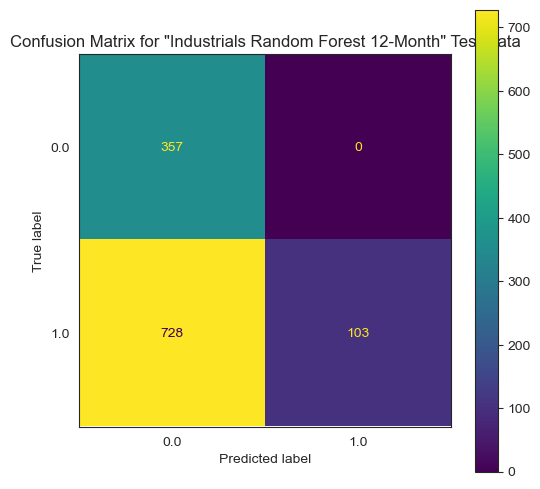

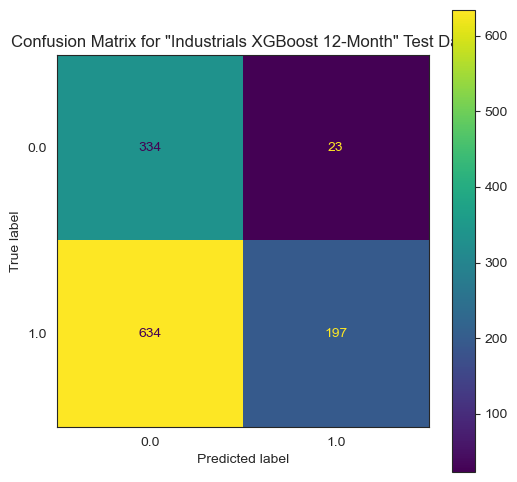

In [192]:
rfc_Ind_12.confusion_matrix(), XGBoost_Ind_12.confusion_matrix();

In [201]:
# Industrials.model_df.drop(columns="index", inplace=True)
Industrials.model_df[18:]

name  train_accuracy  train_prec  \
18                   Dummy Industrials 12-Month        0.656384    0.640202   
19     Industrials Logistic Regression 12-Month        0.511504    0.884261   
20           Industrials Random Forest 12-Month        0.359798    0.721174   
21             Industrials Extra Trees 12-Month        0.467004    0.899688   
22                 Industrials XGBoost 12-Month        0.397724    0.689528   
23  Grid Searched XGBoost, 12-Month Industrials        0.615929    0.895925   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
18      0.800000  0.707609      12.385164       0.699495   0.699495   
19      0.579937  0.597692       5.379733       0.602694   0.698782   
20      0.358613  0.398701       1.452404       0.387205   1.000000   
21      0.499557  0.557977       1.114985       0.397306   1.000000   
22      0.416390  0.461026       3.215357       0.446970   0.895455   
23      0.685393  0.707138       3.829632       0.510943   0.704918   

    test_recall   test_f1  test_logloss       AUC  
18     1.000000  0.823180     10.831300  0.500000  
19     0.759326  0.727797      1.344681  0.531481  
20     0.123947  0.220557      2.732087  0.648921  
21     0.138387  0.243129      1.157699  0.591636  
22     0.237064  0.374881      2.019051  0.634280  
23     0.517449  0.596808      1.560707  0.519933

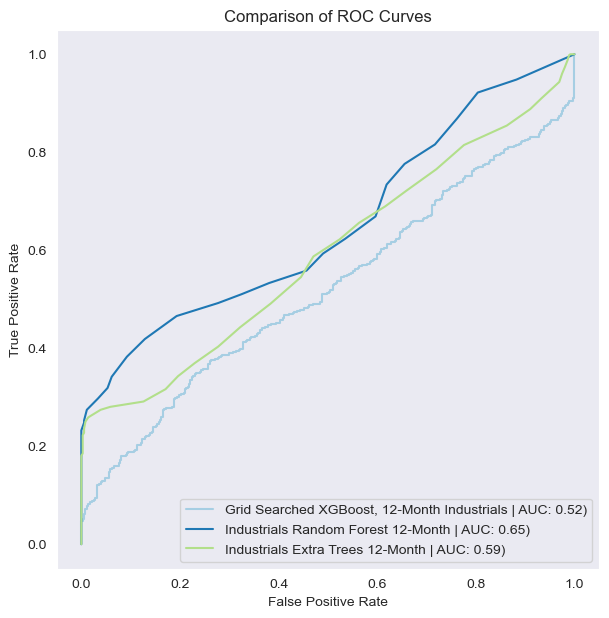

In [202]:
# 3 good models

compare_curves([grid_Ind_12, rfc_Ind_12, etc_Ind_12])

In [204]:
# Importance
features_from_trees(XGBoost_Ind_12)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.14866817)
('Month_9', 0.11470162)
('Quarter_1', 0.099935524)
('Interest_Rates', 0.07957729)
('upper_bollinger_band', 0.062181946)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
12   0.046148  0.045451  0.043040  0.043953  0.038952  0.027252    0.035049   
13   0.039215  0.037629  0.038399  0.036864  0.036082  0.016254    0.059582   
14   0.035610  0.036473  0.035471  0.036164  0.035617  0.017075    0.085159   
15   0.026283  0.009789  0.010271  0.049185  0.008152  0.002836    0.148668   

    Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
12        0.046597  0.018196  0.017790  0.018697  0.017379  0.016535   
13        0.047081  0.008191  0.007254  0.008188  0.007817  0.007490   
14        0.062048  0.005332  0.004850  0.005767  0.005768  0.006137   
15        0.079577  0.001091  0.002513  0.002162  0.002126  0.001202   

    garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
12          0.031388  0.037953               0.049165              0.049919   
13          0.032579  0.024043               0.039184              0.039585   
14          0.049098  0.016705               0.036629              0.034772   
15          0.002725  0.009936               0.009058              0.029827   

    20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
12    0.051432               0.053058              0.049715  0.056189   
13    0.039488               0.041178              0.033998  0.038810   
14    0.037916               0.034512              0.041574  0.037947   
15    0.014712               0.045655              0.062182  0.004380   

        MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
12  0.046925          0.026374   0.008689   0.007933   0.005140   0.008928   
13  0.029284          0.015198   0.018186   0.022479   0.012530   0.016933   
14  0.021170          0.016477   0.017375   0.010063   0.015196   0.022597   
15  0.009381          0.001590   0.099936   0.003549   0.002885   0.002625   

     Month_1  Month_10  Month_11  Month_12   Month_2   Month_3   Month_4  \
12  0.006805  0.006131  0.006743  0.003566  0.004561  0.006810  0.004798   
13  0.014295  0.009113  0.007266  0.008315  0.008006  0.014352  0.008758   
14  0.007604  0.007386  0.007129  0.008433  0.004338  0.006867  0.006278   
15  0.000000  0.000000  0.001687  0.000000  0.000000  0.013434  0.005227   

     Month_5   Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
12  0.006085  0.004403  0.006590  0.003258  0.005686      0.005143   
13  0.006177  0.006902  0.011540  0.006364  0.008822      0.023164   
14  0.002983  0.003414  0.004019  0.004321  0.007674      0.024735   
15  0.029495  0.021121  0.004379  0.000000  0.114702      0.000000   

    cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
12      0.006827      0.007563      0.006647            0.002164   
13      0.028032      0.039251      0.028750            0.003277   
14      0.033074      0.049057      0.046964            0.002288   
15      0.041095      0.055866      0.053267            0.011915   

    day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
12            0.001881              0.002279             0.001995   
13            0.003072              0.003724             0.003583   
14            0.002792              0.002300             0.002856   
15            0.001530              0.003158             0.000305   

    day_of_week_Wednesday  
12               0.002220  
13               0.003717  
14               0.001988  
15               0.000524

In [205]:
Importance.df.rename(index={12:"Industrials 1-Month", 13:"Industrials 3-Month", 14:"Industrials 6-Month", \
                            15:"Industrials 12-Month"}, inplace=True)

<hr style="border: 2px solid darkgreen">

#  Technology

### 1 Month

In [210]:
# Create variables

X_train, X_test, y_train, y_test = select_data(tech_df, "One")


# Create Model Objects

# dummy_tech_1 = dummy_model(Technology, "Technology", 1)
# logreg_tech_1 = l_regr(Technology, "Technology", 1)
# rfc_tech_1 = r_forest(Technology, "Technology", 1)
# etc_tech_1 = extra_trees(Technology, "Technology", 1)
# XGBoost_tech_1 = x_g_b(Technology, "Technology", 1)

# grid_tech_1 = best_etc_grid(estimator=etc_tech_1.model, model_type=Technology, \
#                             sector_name="Technology", time_period=1)

Technology.model_df.sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
5  GridSearched Best-Model, 1-Month Technology        0.532743    0.718736   
3               Technology Extra Trees 1-Month        0.523641    0.687879   
4                   Technology XGBoost 1-Month        0.472061    0.676307   
1       Technology Logistic Regression 1-Month        0.515550    0.621226   
0                     Dummy Technology 1-Month        0.579014    0.403287   
2             Technology Random Forest 1-Month        0.472566    0.705859   

   train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
5      0.499023  0.509845       0.778727       0.545455   0.715074   
3      0.510618  0.513995       0.785558       0.439394   0.675325   
4      0.346116  0.386521       2.762915       0.508418   0.672727   
1      0.485179  0.502742       1.005696       0.641414   0.658759   
0      0.600000  0.482107      15.173877       0.651515   0.651515   
2      0.441372  0.415210       0.815552       0.483165   0.649254   

   test_recall   test_f1  test_logloss       AUC  
5     0.502584  0.590288      0.685454  0.582059  
3     0.268734  0.384473      0.748093  0.543751  
4     0.478036  0.558912      1.369620  0.548322  
1     0.932817  0.772193      0.670096  0.568862  
0     1.000000  0.788991     12.560667  0.500000  
2     0.449612  0.531298      0.706821  0.503592

(None, None)

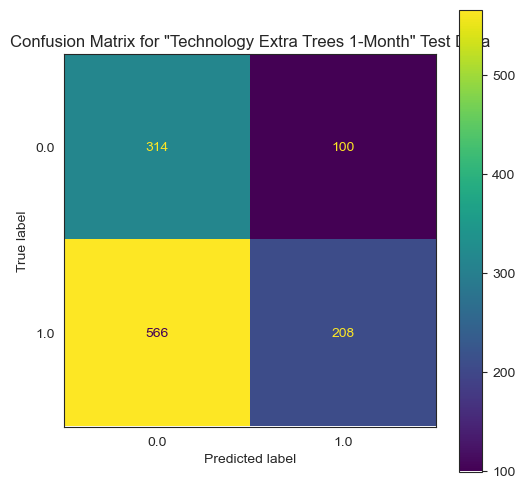

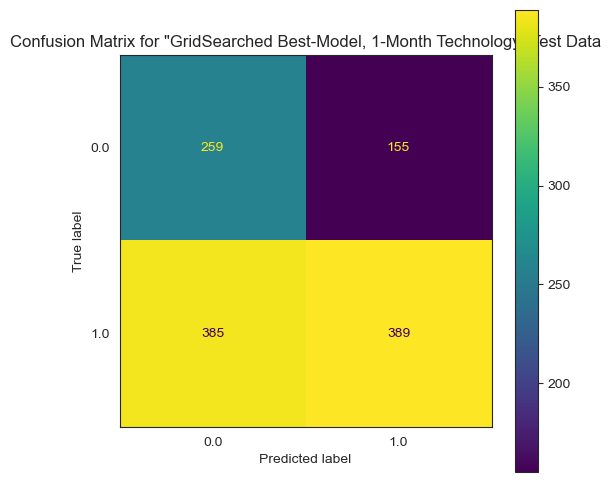

In [211]:
etc_tech_1.confusion_matrix(), grid_tech_1.confusion_matrix()

In [212]:
# Importance
features_from_trees(grid_tech_1)
Importance.df[-4:]

Top 5 Feature Importances
('Interest_Rates', 0.04376567291118359)
('20_day_SMA', 0.04341575939168073)
('one_up_bollinger_band', 0.04310725904975733)
('ATR', 0.042018212377368594)
('lowest_bollinger_band', 0.041658501709619856)


Adj Close     Close      High       Low      Open  \
Industrials 3-Month    0.039215  0.037629  0.038399  0.036864  0.036082   
Industrials 6-Month    0.035610  0.036473  0.035471  0.036164  0.035617   
Industrials 12-Month   0.026283  0.009789  0.010271  0.049185  0.008152   
16                     0.040872  0.040235  0.040102  0.038290  0.035704   

                        Volume  GDP_Filled  Interest_Rates    Mkt-RF  \
Industrials 3-Month   0.016254    0.059582        0.047081  0.008191   
Industrials 6-Month   0.017075    0.085159        0.062048  0.005332   
Industrials 12-Month  0.002836    0.148668        0.079577  0.001091   
16                    0.020820    0.034706        0.043766  0.013741   

                           SMB       HML       RMW       CMA  \
Industrials 3-Month   0.007254  0.008188  0.007817  0.007490   
Industrials 6-Month   0.004850  0.005767  0.005768  0.006137   
Industrials 12-Month  0.002513  0.002162  0.002126  0.001202   
16                    0.013592  0.014578  0.014649  0.013935   

                      garman_klass_vol       RSI  lowest_bollinger_band  \
Industrials 3-Month           0.032579  0.024043               0.039184   
Industrials 6-Month           0.049098  0.016705               0.036629   
Industrials 12-Month          0.002725  0.009936               0.009058   
16                            0.023619  0.036964               0.041659   

                      lower_bollinger_band  20_day_SMA  one_up_bollinger_band  \
Industrials 3-Month               0.039585    0.039488               0.041178   
Industrials 6-Month               0.034772    0.037916               0.034512   
Industrials 12-Month              0.029827    0.014712               0.045655   
16                                0.041262    0.043416               0.043107   

                      upper_bollinger_band       ATR      MACD  \
Industrials 3-Month               0.033998  0.038810  0.029284   
Industrials 6-Month               0.041574  0.037947  0.021170   
Industrials 12-Month              0.062182  0.004380  0.009381   
16                                0.040161  0.042018  0.040775   

                      dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Industrials 3-Month           0.015198   0.018186   0.022479   0.012530   
Industrials 6-Month           0.016477   0.017375   0.010063   0.015196   
Industrials 12-Month          0.001590   0.099936   0.003549   0.002885   
16                            0.019266   0.010035   0.013924   0.010619   

                      Quarter_4   Month_1  Month_10  Month_11  Month_12  \
Industrials 3-Month    0.016933  0.014295  0.009113  0.007266  0.008315   
Industrials 6-Month    0.022597  0.007604  0.007386  0.007129  0.008433   
Industrials 12-Month   0.002625  0.000000  0.000000  0.001687  0.000000   
16                     0.009724  0.009901  0.012805  0.007196  0.010212   

                       Month_2   Month_3   Month_4   Month_5   Month_6  \
Industrials 3-Month   0.008006  0.014352  0.008758  0.006177  0.006902   
Industrials 6-Month   0.004338  0.006867  0.006278  0.002983  0.003414   
Industrials 12-Month  0.000000  0.013434  0.005227  0.029495  0.021121   
16                    0.012626  0.010799  0.012982  0.010565  0.009900   

                       Month_7   Month_8   Month_9  cycle_year_1  \
Industrials 3-Month   0.011540  0.006364  0.008822      0.023164   
Industrials 6-Month   0.004019  0.004321  0.007674      0.024735   
Industrials 12-Month  0.004379  0.000000  0.114702      0.000000   
16                    0.010971  0.009224  0.012860      0.013734   

                      cycle_year_2  cycle_year_3  cycle_year_4  \
Industrials 3-Month       0.028032      0.039251      0.028750   
Industrials 6-Month       0.033074      0.049057      0.046964   
Industrials 12-Month      0.041095      0.055866      0.053267   
16                        0.012703      0.016329      0.013505   

                      day_of_week_Friday  day_of_week_Mo

<hr style="border: 2px solid darkgreen">

# XLK 3 Month

In [217]:
# Create variables

X_train, X_test, y_train, y_test = select_data(tech_df, "Three")


# Create Model Objects

# dummy_tech_3 = dummy_model(Technology, "Technology", 3)
# logreg_tech_3 = l_regr(Technology, "Technology", 3)
# rfc_tech_3 = r_forest(Technology, "Technology", 3)
# etc_tech_3 = extra_trees(Technology, "Technology", 3)
# XGBoost_tech_3 = x_g_b(Technology, "Technology", 3)

# grid_tech_3 = best_etc_grid(estimator=etc_tech_3.model, model_type=Technology, \
#                             sector_name="Technology", time_period=3)

Technology.model_df.iloc[6:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.001, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


name  train_accuracy  train_prec  \
8              Technology Random Forest 3-Month        0.497598    0.840695   
11  GridSearched Best-Model, 3-Month Technology        0.609861    0.836354   
9                Technology Extra Trees 3-Month        0.600506    0.829887   
6                      Dummy Technology 3-Month        0.667257    0.586852   
10                   Technology XGBoost 3-Month        0.504678    0.814147   
7        Technology Logistic Regression 3-Month        0.493047    0.566557   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
8       0.470452  0.474015       0.772140       0.335859   1.000000   
11      0.592195  0.654916       0.706309       0.621212   0.848598   
9       0.575523  0.643000       0.721289       0.476431   0.815047   
6       0.800000  0.674687      11.993286       0.692761   0.692761   
10      0.466005  0.490433       2.269902       0.491582   0.687822   
7       0.434226  0.404143       2.539061       0.649832   0.681534   

    test_recall   test_f1  test_logloss       AUC  
8      0.041312  0.079347      0.929554  0.626951  
11     0.551640  0.668630      0.660141  0.679136  
9      0.315917  0.455342      0.756312  0.661927  
6      1.000000  0.818498     11.074018  0.500000  
10     0.487242  0.570413      1.894152  0.474013  
7      0.928311  0.786008      0.834024  0.519240

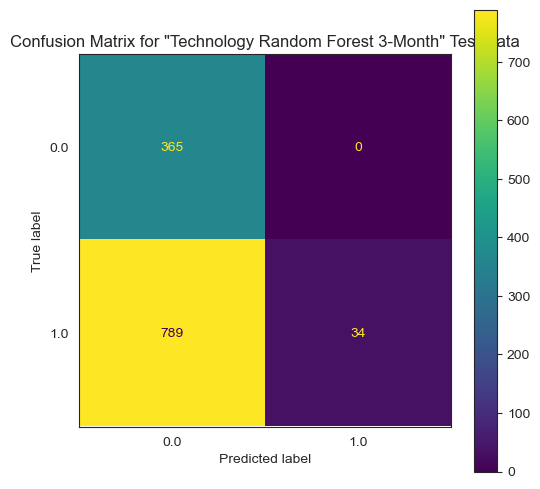

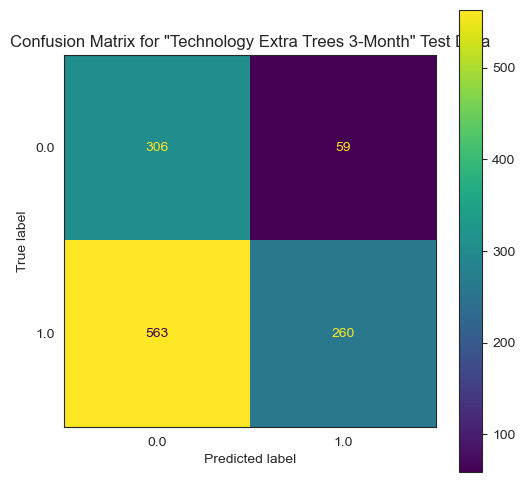

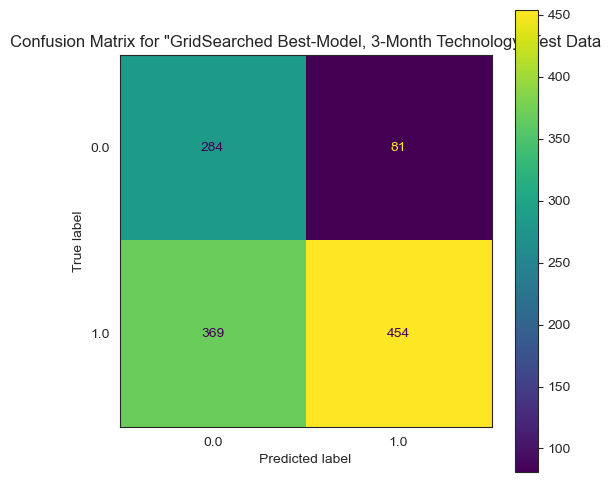

In [218]:
rfc_tech_3.confusion_matrix(), etc_tech_3.confusion_matrix(), grid_tech_3.confusion_matrix();

In [219]:
# Importance
features_from_trees(grid_tech_3)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.0815188073109795)
('Interest_Rates', 0.0525111286624808)
('cycle_year_4', 0.0491913791418691)
('cycle_year_3', 0.04247902471414039)
('Adj Close', 0.03922795363096574)


Adj Close     Close      High       Low      Open  \
Industrials 6-Month    0.035610  0.036473  0.035471  0.036164  0.035617   
Industrials 12-Month   0.026283  0.009789  0.010271  0.049185  0.008152   
16                     0.040872  0.040235  0.040102  0.038290  0.035704   
17                     0.039228  0.034636  0.033471  0.034962  0.034204   

                        Volume  GDP_Filled  Interest_Rates    Mkt-RF  \
Industrials 6-Month   0.017075    0.085159        0.062048  0.005332   
Industrials 12-Month  0.002836    0.148668        0.079577  0.001091   
16                    0.020820    0.034706        0.043766  0.013741   
17                    0.008444    0.081519        0.052511  0.001259   

                           SMB       HML       RMW       CMA  \
Industrials 6-Month   0.004850  0.005767  0.005768  0.006137   
Industrials 12-Month  0.002513  0.002162  0.002126  0.001202   
16                    0.013592  0.014578  0.014649  0.013935   
17                    0.001010  0.001668  0.001922  0.001999   

                      garman_klass_vol       RSI  lowest_bollinger_band  \
Industrials 6-Month           0.049098  0.016705               0.036629   
Industrials 12-Month          0.002725  0.009936               0.009058   
16                            0.023619  0.036964               0.041659   
17                            0.027983  0.016078               0.036114   

                      lower_bollinger_band  20_day_SMA  one_up_bollinger_band  \
Industrials 6-Month               0.034772    0.037916               0.034512   
Industrials 12-Month              0.029827    0.014712               0.045655   
16                                0.041262    0.043416               0.043107   
17                                0.035860    0.031738               0.034428   

                      upper_bollinger_band       ATR      MACD  \
Industrials 6-Month               0.041574  0.037947  0.021170   
Industrials 12-Month              0.062182  0.004380  0.009381   
16                                0.040161  0.042018  0.040775   
17                                0.037072  0.037181  0.026823   

                      dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Industrials 6-Month           0.016477   0.017375   0.010063   0.015196   
Industrials 12-Month          0.001590   0.099936   0.003549   0.002885   
16                            0.019266   0.010035   0.013924   0.010619   
17                            0.008823   0.020517   0.022580   0.020716   

                      Quarter_4   Month_1  Month_10  Month_11  Month_12  \
Industrials 6-Month    0.022597  0.007604  0.007386  0.007129  0.008433   
Industrials 12-Month   0.002625  0.000000  0.000000  0.001687  0.000000   
16                     0.009724  0.009901  0.012805  0.007196  0.010212   
17                     0.020055  0.016571  0.013387  0.007194  0.009175   

                       Month_2   Month_3   Month_4   Month_5   Month_6  \
Industrials 6-Month   0.004338  0.006867  0.006278  0.002983  0.003414   
Industrials 12-Month  0.000000  0.013434  0.005227  0.029495  0.021121   
16                    0.012626  0.010799  0.012982  0.010565  0.009900   
17                    0.006432  0.017683  0.014320  0.010730  0.009645   

                       Month_7   Month_8   Month_9  cycle_year_1  \
Industrials 6-Month   0.004019  0.004321  0.007674      0.024735   
Industrials 12-Month  0.004379  0.000000  0.114702      0.000000   
16                    0.010971  0.009224  0.012860      0.013734   
17                    0.014625  0.010703  0.015093      0.034851   

                      cycle_year_2  cycle_year_3  cycle_year_4  \
Industrials 6-Month       0.033074      0.049057      0.046964   
Industrials 12-Month      0.041095      0.055866      0.053267   
16                        0.012703      0.016329      0.013505   
17                        0.024209      0.042479      0.049191   

                      day_of_week_Friday  day_of_week_Mo

<hr style="border: 2px solid darkgreen">

# XLK 6 Month

In [227]:
# Create variables

X_train, X_test, y_train, y_test = select_data(tech_df, "Six")


# Create Model Objects

# dummy_tech_6 = dummy_model(Technology, "Technology", 6)
# logreg_tech_6 = l_regr(Technology, "Technology", 6)
# rfc_tech_6 = r_forest(Technology, "Technology", 6)
# etc_tech_6 = extra_trees(Technology, "Technology", 6)
# XGBoost_tech_6 = x_g_b(Technology, "Technology", 6)

# grid_tech_6 = best_etc_grid(estimator=rfc_tech_6.model, model_type=Technology, \
#                             sector_name="Technology", time_period=6)
# grid_tech_6 = best_logreg_search(logreg_tech_6.model, Technology, "Technology", 6)

Technology.model_df.iloc[12:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
13  Technology Logistic Regression 6-Month        0.416435    0.486935   
17    Grid Searched LR, 6-Month Technology        0.416182    0.487190   
12                Dummy Technology 6-Month        0.680657    0.620986   
14        Technology Random Forest 6-Month        0.609102    0.928631   
15          Technology Extra Trees 6-Month        0.573451    0.907799   
16              Technology XGBoost 6-Month        0.592920    0.841815   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
13      0.402293  0.345070       4.624692       0.691077   0.728990   
17      0.401460  0.344161       5.245009       0.687710   0.723305   
12      0.800000  0.693124      11.510274       0.717172   0.717172   
14      0.541440  0.635552       0.876039       0.717172   0.717172   
15      0.513869  0.634201       0.792449       0.717172   0.717172   
16      0.571947  0.667262       1.700038       0.717172   0.717172   

    test_recall   test_f1  test_logloss       AUC  
13     0.906103  0.807954      1.637293  0.495941  
17     0.914319  0.807672      1.885070  0.487170  
12     1.000000  0.835294     10.194165  0.500000  
14     1.000000  0.835294      0.660443  0.343738  
15     1.000000  0.835294      0.737935  0.317616  
16     1.000000  0.835294      2.354006  0.365123

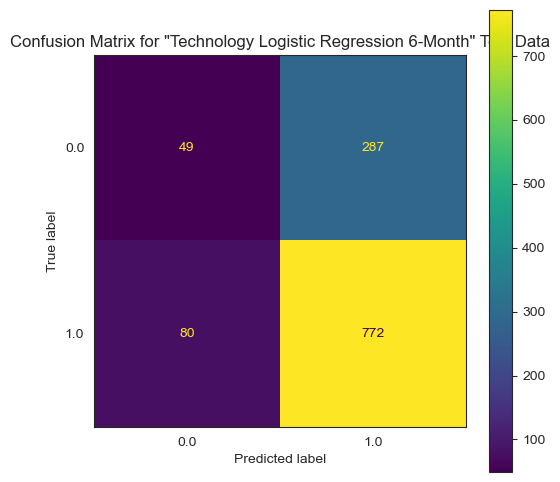

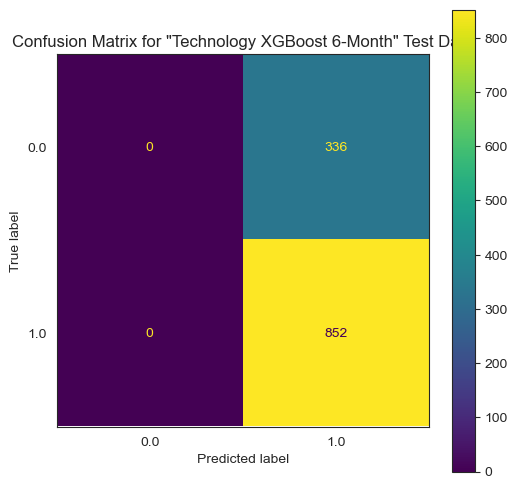

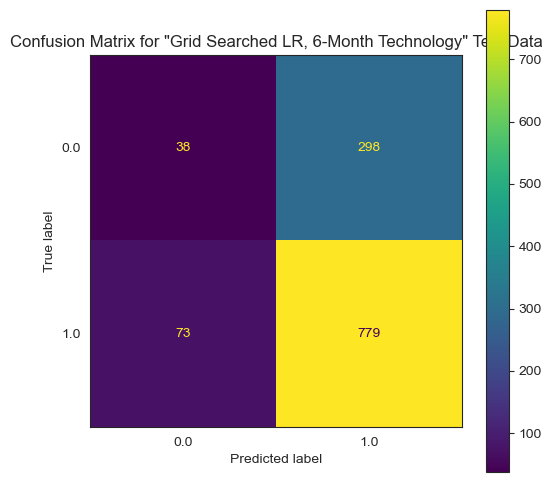

In [228]:
logreg_tech_6.confusion_matrix(), XGBoost_tech_6.confusion_matrix(), grid_tech_6.confusion_matrix();

In [229]:
# Importance
coefs_from_lr(grid_tech_6)
Importance.df[-4:]

Top 5 Feature Coefficients
('Adj Close', 6.330976825162946)
('Open', 1.9298634545443107)
('lowest_bollinger_band', 1.5247187953243104)
('garman_klass_vol', 1.4842534474326774)
('lower_bollinger_band', 0.9458253871686011)


Adj Close     Close      High       Low      Open  \
Industrials 12-Month   0.026283  0.009789  0.010271  0.049185  0.008152   
16                     0.040872  0.040235  0.040102  0.038290  0.035704   
17                     0.039228  0.034636  0.033471  0.034962  0.034204   
18                     6.330977 -5.198075 -2.830210 -1.433971  1.929863   

                        Volume  GDP_Filled  Interest_Rates    Mkt-RF  \
Industrials 12-Month  0.002836    0.148668        0.079577  0.001091   
16                    0.020820    0.034706        0.043766  0.013741   
17                    0.008444    0.081519        0.052511  0.001259   
18                    0.465459   -2.184707        0.294027 -0.187060   

                           SMB       HML       RMW       CMA  \
Industrials 12-Month  0.002513  0.002162  0.002126  0.001202   
16                    0.013592  0.014578  0.014649  0.013935   
17                    0.001010  0.001668  0.001922  0.001999   
18                   -0.062546  0.016938 -0.027993 -0.008711   

                      garman_klass_vol       RSI  lowest_bollinger_band  \
Industrials 12-Month          0.002725  0.009936               0.009058   
16                            0.023619  0.036964               0.041659   
17                            0.027983  0.016078               0.036114   
18                            1.484253 -0.241540               1.524719   

                      lower_bollinger_band  20_day_SMA  one_up_bollinger_band  \
Industrials 12-Month              0.029827    0.014712               0.045655   
16                                0.041262    0.043416               0.043107   
17                                0.035860    0.031738               0.034428   
18                                0.945825    0.379848              -0.171940   

                      upper_bollinger_band       ATR      MACD  \
Industrials 12-Month              0.062182  0.004380  0.009381   
16                                0.040161  0.042018  0.040775   
17                                0.037072  0.037181  0.026823   
18                               -0.708497 -0.457935  0.618230   

                      dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Industrials 12-Month          0.001590   0.099936   0.003549   0.002885   
16                            0.019266   0.010035   0.013924   0.010619   
17                            0.008823   0.020517   0.022580   0.020716   
18                           -0.207977  -0.236592   0.154364   0.259008   

                      Quarter_4   Month_1  Month_10  Month_11  Month_12  \
Industrials 12-Month   0.002625  0.000000  0.000000  0.001687  0.000000   
16                     0.009724  0.009901  0.012805  0.007196  0.010212   
17                     0.020055  0.016571  0.013387  0.007194  0.009175   
18                     0.071179  0.071307  0.567816 -0.165472 -0.331166   

                       Month_2   Month_3   Month_4   Month_5   Month_6  \
Industrials 12-Month  0.000000  0.013434  0.005227  0.029495  0.021121   
16                    0.012626  0.010799  0.012982  0.010565  0.009900   
17                    0.006432  0.017683  0.014320  0.010730  0.009645   
18                    0.125350 -0.433248 -0.292586 -0.015823  0.462772   

                       Month_7   Month_8   Month_9  cycle_year_1  \
Industrials 12-Month  0.004379  0.000000  0.114702      0.000000   
16                    0.010971  0.009224  0.012860      0.013734   
17                    0.014625  0.010703  0.015093      0.034851   
18                    0.051422 -0.167589  0.375175      0.238059   

                      cycle_year_2  cycle_year_3  cycle_year_4  \
Industrials 12-Month      0.041095      0.055866      0.053267   
16                        0.012703      0.016329      0.013505   
17                        0.024209      0.042479      0.049191   
18                        0.058758      0.279259     -0.328117   

                      day_of_week_Friday  day_of_week_Mo

<hr style="border: 2px solid darkgreen">

# XLK 12 Month

## Some 0% precision scores here! 

In [233]:
# Create variables

X_train, X_test, y_train, y_test = select_data(tech_df, "Twelve")


# Create Model Objects

# dummy_tech_12 = dummy_model(Technology, "Technology", 12)
# logreg_tech_12 = l_regr(Technology, "Technology", 12)
# rfc_tech_12 = r_forest(Technology, "Technology", 12)
# etc_tech_12 = extra_trees(Technology, "Technology", 12)
# XGBoost_tech_12 = x_g_b(Technology, "Technology", 12)

# grid_tech_12 = best_etc_grid(estimator=rfc_tech_12.model, model_type=Technology, \
#                             sector_name="Technology", time_period=12)
# grid_tech_12 = best_logreg_search(logreg_tech_12.model, Technology, "Technology", 12)

Technology.model_df.iloc[18:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
18                Dummy Technology 12-Month        0.705689    0.670544   
19  Technology Logistic Regression 12-Month        0.333755    0.485533   
23    Grid Searched LR, 12-Month Technology        0.333249    0.487719   
22              Technology XGBoost 12-Month        0.538559    0.682090   
20        Technology Random Forest 12-Month        0.530721    0.738300   
21          Technology Extra Trees 12-Month        0.522882    0.666412   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
18      0.800000  0.716781      10.608044       0.810606   0.810606   
19      0.397198  0.346855       7.527831       0.310606   0.800000   
23      0.391455  0.345042       8.791662       0.323232   0.782918   
22      0.603524  0.585868       2.692321       0.295455   0.610526   
20      0.437715  0.527085       4.762348       0.189394   0.000000   
21      0.514076  0.560971       2.607225       0.189394   0.000000   

    test_recall   test_f1  test_logloss       AUC  
18     1.000000  0.895397      6.826450  0.500000  
19     0.199377  0.319202      4.506678  0.572493  
23     0.228453  0.353698      4.700029  0.550119  
22     0.361371  0.454012      4.333492  0.157692  
20     0.000000  0.000000      3.001848  0.189971  
21     0.000000  0.000000      1.224911  0.334328

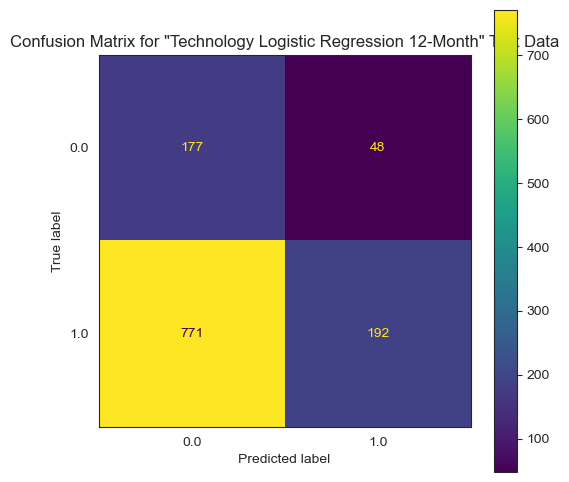

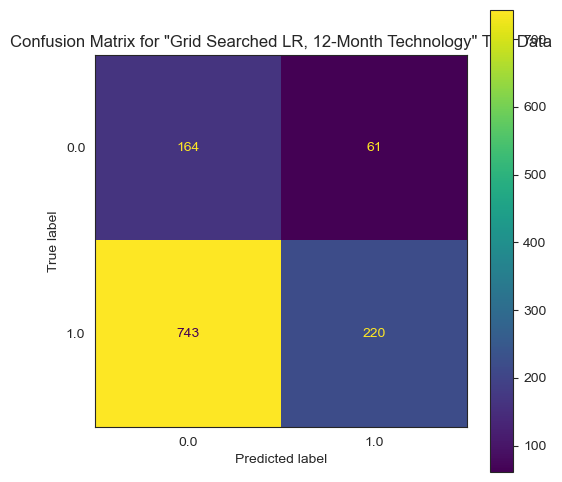

In [235]:
logreg_tech_12.confusion_matrix(), grid_tech_12.confusion_matrix();

In [236]:
# Importance
coefs_from_lr(grid_tech_12)
Importance.df[-4:]

Top 5 Feature Coefficients
('lowest_bollinger_band', 3.915277918701436)
('Adj Close', 3.6266531890017766)
('garman_klass_vol', 3.2360255803617277)
('Open', 3.027762156710705)
('Volume', 2.779966818418395)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
16   0.040872  0.040235  0.040102  0.038290  0.035704  0.020820    0.034706   
17   0.039228  0.034636  0.033471  0.034962  0.034204  0.008444    0.081519   
18   6.330977 -5.198075 -2.830210 -1.433971  1.929863  0.465459   -2.184707   
19   3.626653 -6.367175 -3.317404 -0.960520  3.027762  2.779967   -4.932735   

    Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
16        0.043766  0.013741  0.013592  0.014578  0.014649  0.013935   
17        0.052511  0.001259  0.001010  0.001668  0.001922  0.001999   
18        0.294027 -0.187060 -0.062546  0.016938 -0.027993 -0.008711   
19       -0.380182 -0.476700 -0.046248  0.134418  0.078175 -0.074792   

    garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
16          0.023619  0.036964               0.041659              0.041262   
17          0.027983  0.016078               0.036114              0.035860   
18          1.484253 -0.241540               1.524719              0.945825   
19          3.236026 -0.054959               3.915278              2.465234   

    20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
16    0.043416               0.043107              0.040161  0.042018   
17    0.031738               0.034428              0.037072  0.037181   
18    0.379848              -0.171940             -0.708497 -0.457935   
19    1.047442              -0.334900             -1.679179 -1.738609   

        MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
16  0.040775          0.019266   0.010035   0.013924   0.010619   0.009724   
17  0.026823          0.008823   0.020517   0.022580   0.020716   0.020055   
18  0.618230         -0.207977  -0.236592   0.154364   0.259008   0.071179   
19  0.354835         -1.852527  -0.467191  -0.074889   0.289233   0.569871   

     Month_1  Month_10  Month_11  Month_12   Month_2   Month_3   Month_4  \
16  0.009901  0.012805  0.007196  0.010212  0.012626  0.010799  0.012982   
17  0.016571  0.013387  0.007194  0.009175  0.006432  0.017683  0.014320   
18  0.071307  0.567816 -0.165472 -0.331166  0.125350 -0.433248 -0.292586   
19 -0.547381  0.413154  0.364789 -0.208071 -0.148846  0.229035 -0.153375   

     Month_5   Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
16  0.010565  0.009900  0.010971  0.009224  0.012860      0.013734   
17  0.010730  0.009645  0.014625  0.010703  0.015093      0.034851   
18 -0.015823  0.462772  0.051422 -0.167589  0.375175      0.238059   
19  0.114557 -0.036071  0.008848  0.029745  0.250640     -0.334266   

    cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
16      0.012703      0.016329      0.013505            0.006282   
17      0.024209      0.042479      0.049191            0.000198   
18      0.058758      0.279259     -0.328117            0.090074   
19      0.770631      0.346802     -0.466143            0.045467   

    day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
16            0.007356              0.005959             0.006639   
17            0.000307              0.000132             0.000105   
18            0.026668              0.040976             0.074847   
19            0.090133              0.040940             0.102401   

    day_of_week_Wednesday  
16               0.005912  
17               0.000167  
18               0.015394  
19               0.038083

In [237]:
Importance.df.rename(index={16:"Technology 1-Month", 17:"Technology 3-Month", 18:"Technology 6-Month", \
                            19:"Technology 12-Month"}, inplace=True)

In [238]:
Importance.df[-4:]

Adj Close     Close      High       Low      Open  \
Technology 1-Month    0.040872  0.040235  0.040102  0.038290  0.035704   
Technology 3-Month    0.039228  0.034636  0.033471  0.034962  0.034204   
Technology 6-Month    6.330977 -5.198075 -2.830210 -1.433971  1.929863   
Technology 12-Month   3.626653 -6.367175 -3.317404 -0.960520  3.027762   

                       Volume  GDP_Filled  Interest_Rates    Mkt-RF       SMB  \
Technology 1-Month   0.020820    0.034706        0.043766  0.013741  0.013592   
Technology 3-Month   0.008444    0.081519        0.052511  0.001259  0.001010   
Technology 6-Month   0.465459   -2.184707        0.294027 -0.187060 -0.062546   
Technology 12-Month  2.779967   -4.932735       -0.380182 -0.476700 -0.046248   

                          HML       RMW       CMA  garman_klass_vol       RSI  \
Technology 1-Month   0.014578  0.014649  0.013935          0.023619  0.036964   
Technology 3-Month   0.001668  0.001922  0.001999          0.027983  0.016078   
Technology 6-Month   0.016938 -0.027993 -0.008711          1.484253 -0.241540   
Technology 12-Month  0.134418  0.078175 -0.074792          3.236026 -0.054959   

                     lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Technology 1-Month                0.041659              0.041262    0.043416   
Technology 3-Month                0.036114              0.035860    0.031738   
Technology 6-Month                1.524719              0.945825    0.379848   
Technology 12-Month               3.915278              2.465234    1.047442   

                     one_up_bollinger_band  upper_bollinger_band       ATR  \
Technology 1-Month                0.043107              0.040161  0.042018   
Technology 3-Month                0.034428              0.037072  0.037181   
Technology 6-Month               -0.171940             -0.708497 -0.457935   
Technology 12-Month              -0.334900             -1.679179 -1.738609   

                         MACD  dollar_volume(M)  Quarter_1  Quarter_2  \
Technology 1-Month   0.040775          0.019266   0.010035   0.013924   
Technology 3-Month   0.026823          0.008823   0.020517   0.022580   
Technology 6-Month   0.618230         -0.207977  -0.236592   0.154364   
Technology 12-Month  0.354835         -1.852527  -0.467191  -0.074889   

                     Quarter_3  Quarter_4   Month_1  Month_10  Month_11  \
Technology 1-Month    0.010619   0.009724  0.009901  0.012805  0.007196   
Technology 3-Month    0.020716   0.020055  0.016571  0.013387  0.007194   
Technology 6-Month    0.259008   0.071179  0.071307  0.567816 -0.165472   
Technology 12-Month   0.289233   0.569871 -0.547381  0.413154  0.364789   

                     Month_12   Month_2   Month_3   Month_4   Month_5  \
Technology 1-Month   0.010212  0.012626  0.010799  0.012982  0.010565   
Technology 3-Month   0.009175  0.006432  0.017683  0.014320  0.010730   
Technology 6-Month  -0.331166  0.125350 -0.433248 -0.292586 -0.015823   
Technology 12-Month -0.208071 -0.148846  0.229035 -0.153375  0.114557   

                      Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
Technology 1-Month   0.009900  0.010971  0.009224  0.012860      0.013734   
Technology 3-Month   0.009645  0.014625  0.010703  0.015093      0.034851   
Technology 6-Month   0.462772  0.051422 -0.167589  0.375175      0.238059   
Technology 12-Month -0.036071  0.008848  0.029745  0.250640     -0.334266   

                     cycle_year_2  cycle_year_3  cycle_year_4  \
Technology 1-Month       0.012703      0.016329      0.013505   
Technology 3-Month       0.024209      0.042479      0.049191   
Technology 6-Month       0.058758      0.279259     -0.328117   
Technology 12-Month      0.770631      0.346802     -0.466143   

                     day_of_week_Friday  day_of_week_Monday  \
Technology 1-Month             0.006282            0.007356   
Technology 3-Month             0.000198            0.000307   
Technology 6-Month             0.0900

<hr style="border: 2px solid darkgreen">

#  Staples - XLP

### 1 Month

In [242]:
# Create variables

X_train, X_test, y_train, y_test = select_data(staples_df, "One")


# Create Model Objects

# dummy_stap_1 = dummy_model(Staples, "Staples", 1)
# logreg_stap_1 = l_regr(Staples, "Staples", 1)
# rfc_stap_1 = r_forest(Staples, "Staples", 1)
# etc_stap_1 = extra_trees(Staples, "Staples", 1)
# XGBoost_stap_1 = x_g_b(Staples, "Staples", 1)

# grid_stap_1 = best_etc_grid(estimator=etc_stap_1.model, model_type=Staples, \
#                             sector_name="Staples", time_period=1)
# grid_stap_1 = best_logreg_search(logreg_stap_1.model, Staples, "Staples", 1)

Staples.model_df.sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
1  Staples Logistic Regression 1-Month        0.518078    0.641894   
2        Staples Random Forest 1-Month        0.453097    0.777331   
4              Staples XGBoost 1-Month        0.437421    0.676234   
5    Grid Searched LR, 1-Month Staples        0.577244    0.649716   
3          Staples Extra Trees 1-Month        0.457649    0.733956   
0                Dummy Staples 1-Month        0.637927    0.637927   

   train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
1      0.622861  0.569672       1.136280       0.604377   0.697297   
2      0.400256  0.389916       0.899113       0.449495   0.691489   
4      0.411754  0.403498       2.555716       0.525253   0.686792   
5      0.771297  0.662908       1.018767       0.668350   0.683633   
3      0.435691  0.428541       0.879378       0.422559   0.654472   
0      1.000000  0.776675      13.050445       0.641414   0.641414   

   test_recall   test_f1  test_logloss       AUC  
1     0.677165  0.687084      0.691961  0.586121  
2     0.255906  0.373563      0.931222  0.580690  
4     0.477690  0.563467      1.630768  0.557225  
5     0.898950  0.776644      0.660992  0.590493  
3     0.211286  0.319444      0.872543  0.588975  
0     1.000000  0.781538     12.924744  0.500000

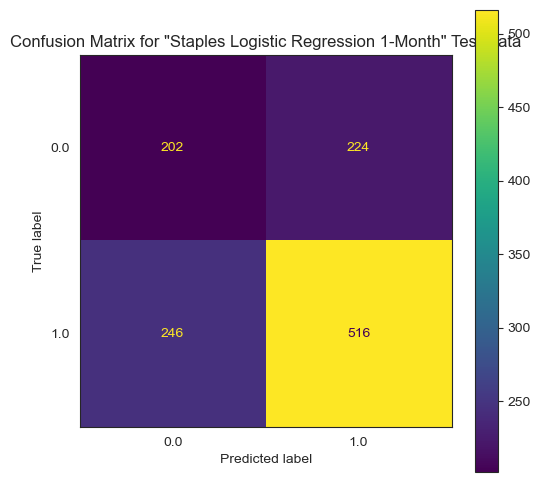

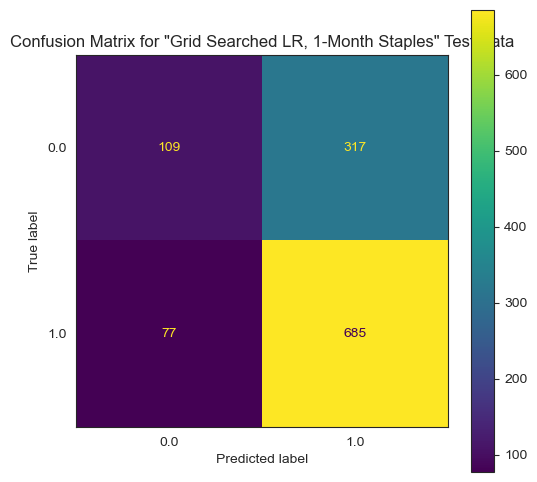

In [243]:
logreg_stap_1.confusion_matrix(), grid_stap_1.confusion_matrix();

In [244]:
# Feature importance for the best model

coefs_from_lr(grid_stap_1)
Importance.df[-4:]

Top 5 Feature Coefficients
('garman_klass_vol', 1.7631257583240052)
('upper_bollinger_band', 1.310588234060795)
('one_up_bollinger_band', 0.8574579536907162)
('Adj Close', 0.6235641792425173)
('Interest_Rates', 0.43311122643837985)


Adj Close     Close      High       Low      Open  \
Technology 3-Month    0.039228  0.034636  0.033471  0.034962  0.034204   
Technology 6-Month    6.330977 -5.198075 -2.830210 -1.433971  1.929863   
Technology 12-Month   3.626653 -6.367175 -3.317404 -0.960520  3.027762   
20                    0.623564 -1.017020 -0.596937 -0.711028 -0.478672   

                       Volume  GDP_Filled  Interest_Rates    Mkt-RF       SMB  \
Technology 3-Month   0.008444    0.081519        0.052511  0.001259  0.001010   
Technology 6-Month   0.465459   -2.184707        0.294027 -0.187060 -0.062546   
Technology 12-Month  2.779967   -4.932735       -0.380182 -0.476700 -0.046248   
20                   0.028267   -1.041940        0.433111 -0.073296 -0.031532   

                          HML       RMW       CMA  garman_klass_vol       RSI  \
Technology 3-Month   0.001668  0.001922  0.001999          0.027983  0.016078   
Technology 6-Month   0.016938 -0.027993 -0.008711          1.484253 -0.241540   
Technology 12-Month  0.134418  0.078175 -0.074792          3.236026 -0.054959   
20                   0.083186 -0.019512 -0.017331          1.763126 -0.256223   

                     lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Technology 3-Month                0.036114              0.035860    0.031738   
Technology 6-Month                1.524719              0.945825    0.379848   
Technology 12-Month               3.915278              2.465234    1.047442   
20                               -0.547322             -0.071557    0.396726   

                     one_up_bollinger_band  upper_bollinger_band       ATR  \
Technology 3-Month                0.034428              0.037072  0.037181   
Technology 6-Month               -0.171940             -0.708497 -0.457935   
Technology 12-Month              -0.334900             -1.679179 -1.738609   
20                                0.857458              1.310588 -0.220763   

                         MACD  dollar_volume(M)  Quarter_1  Quarter_2  \
Technology 3-Month   0.026823          0.008823   0.020517   0.022580   
Technology 6-Month   0.618230         -0.207977  -0.236592   0.154364   
Technology 12-Month  0.354835         -1.852527  -0.467191  -0.074889   
20                   0.007134         -0.066164   0.095634  -0.087112   

                     Quarter_3  Quarter_4   Month_1  Month_10  Month_11  \
Technology 3-Month    0.020716   0.020055  0.016571  0.013387  0.007194   
Technology 6-Month    0.259008   0.071179  0.071307  0.567816 -0.165472   
Technology 12-Month   0.289233   0.569871 -0.547381  0.413154  0.364789   
20                   -0.207783   0.203905 -0.232063  0.188658  0.271294   

                     Month_12   Month_2   Month_3   Month_4   Month_5  \
Technology 3-Month   0.009175  0.006432  0.017683  0.014320  0.010730   
Technology 6-Month  -0.331166  0.125350 -0.433248 -0.292586 -0.015823   
Technology 12-Month -0.208071 -0.148846  0.229035 -0.153375  0.114557   
20                  -0.256048  0.055543  0.272153  0.380805 -0.320701   

                      Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
Technology 3-Month   0.009645  0.014625  0.010703  0.015093      0.034851   
Technology 6-Month   0.462772  0.051422 -0.167589  0.375175      0.238059   
Technology 12-Month -0.036071  0.008848  0.029745  0.250640     -0.334266   
20                  -0.147217 -0.221168 -0.010686  0.024071      0.078129   

                     cycle_year_2  cycle_year_3  cycle_year_4  \
Technology 3-Month       0.024209      0.042479      0.049191   
Technology 6-Month       0.058758      0.279259     -0.328117   
Technology 12-Month      0.770631      0.346802     -0.466143   
20                      -0.101026     -0.001708      0.029248   

                     day_of_week_Friday  day_of_week_Monday  \
Technology 3-Month             0.000198            0.000307   
Technology 6-Month             0.090074            0.026668   
Technology 12-Month            0.0454

<hr style="border: 2px solid darkgreen">

# XLP 3 Month

In [248]:
# Create variables

X_train, X_test, y_train, y_test = select_data(staples_df, "Three")


# Create Model Objects

# dummy_stap_3 = dummy_model(Staples, "Staples", 3)
# logreg_stap_3 = l_regr(Staples, "Staples", 3)
# rfc_stap_3 = r_forest(Staples, "Staples", 3)
# etc_stap_3 = extra_trees(Staples, "Staples", 3)
# XGBoost_stap_3 = x_g_b(Staples, "Staples", 3)

# grid_stap_3 = best_etc_grid(estimator=rfc_stap_3.model, model_type=Staples, \
#                             sector_name="Staples", time_period=3)

Staples.model_df.iloc[6:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': 7, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


name  train_accuracy  train_prec  \
8              Staples Random Forest 3-Month        0.456131    0.781747   
9                Staples Extra Trees 3-Month        0.457143    0.750902   
11  GridSearched Best-Model, 3-Month Staples        0.459418    0.782855   
10                   Staples XGBoost 3-Month        0.467509    0.766708   
6                      Dummy Staples 3-Month        0.667509    0.587611   
7        Staples Logistic Regression 3-Month        0.547661    0.744956   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
8       0.533627  0.485260       0.998850       0.354377   0.827815   
9       0.540291  0.504438       0.980113       0.332492   0.787402   
11      0.538617  0.487306       0.990376       0.359428   0.766497   
10      0.493248  0.502963       2.346138       0.344276   0.740331   
6       0.800000  0.674943      11.984173       0.728956   0.728956   
7       0.654891  0.625991       1.988502       0.473064   0.726415   

    test_recall   test_f1  test_logloss       AUC  
8      0.144342  0.245821      3.489443  0.569928  
9      0.115473  0.201410      1.378126  0.590431  
11     0.174365  0.284102      1.867876  0.559085  
10     0.154734  0.255969      3.477147  0.526039  
6      1.000000  0.843233      9.769408  0.500000  
7      0.444573  0.551576      1.027732  0.543202

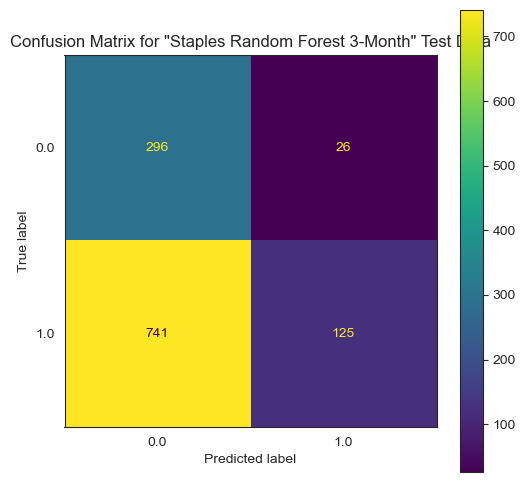

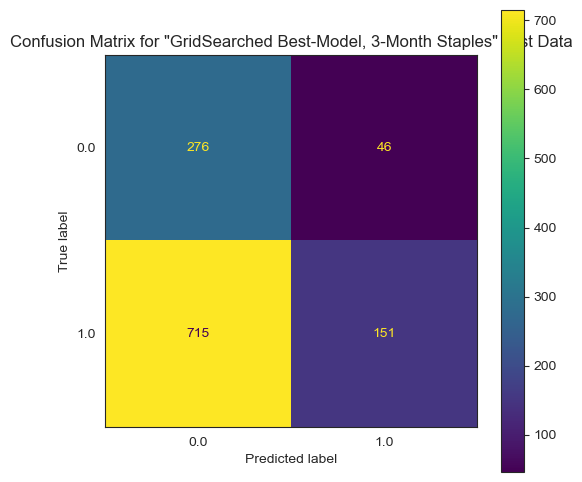

In [249]:
rfc_stap_3.confusion_matrix(), grid_stap_3.confusion_matrix();

In [250]:
# Feature importances of the best models

features_from_trees(grid_stap_3)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.09205544807257376)
('Interest_Rates', 0.07005686739054302)
('garman_klass_vol', 0.06730086540176554)
('High', 0.060722561699139185)
('ATR', 0.05919906736519298)


Adj Close     Close      High       Low      Open  \
Technology 6-Month    6.330977 -5.198075 -2.830210 -1.433971  1.929863   
Technology 12-Month   3.626653 -6.367175 -3.317404 -0.960520  3.027762   
20                    0.623564 -1.017020 -0.596937 -0.711028 -0.478672   
21                    0.048369  0.054899  0.060723  0.057336  0.049922   

                       Volume  GDP_Filled  Interest_Rates    Mkt-RF       SMB  \
Technology 6-Month   0.465459   -2.184707        0.294027 -0.187060 -0.062546   
Technology 12-Month  2.779967   -4.932735       -0.380182 -0.476700 -0.046248   
20                   0.028267   -1.041940        0.433111 -0.073296 -0.031532   
21                   0.026380    0.092055        0.070057  0.005053  0.002187   

                          HML       RMW       CMA  garman_klass_vol       RSI  \
Technology 6-Month   0.016938 -0.027993 -0.008711          1.484253 -0.241540   
Technology 12-Month  0.134418  0.078175 -0.074792          3.236026 -0.054959   
20                   0.083186 -0.019512 -0.017331          1.763126 -0.256223   
21                   0.005513  0.003319  0.004349          0.067301  0.016125   

                     lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Technology 6-Month                1.524719              0.945825    0.379848   
Technology 12-Month               3.915278              2.465234    1.047442   
20                               -0.547322             -0.071557    0.396726   
21                                0.046483              0.037300    0.042609   

                     one_up_bollinger_band  upper_bollinger_band       ATR  \
Technology 6-Month               -0.171940             -0.708497 -0.457935   
Technology 12-Month              -0.334900             -1.679179 -1.738609   
20                                0.857458              1.310588 -0.220763   
21                                0.044029              0.036709  0.059199   

                         MACD  dollar_volume(M)  Quarter_1  Quarter_2  \
Technology 6-Month   0.618230         -0.207977  -0.236592   0.154364   
Technology 12-Month  0.354835         -1.852527  -0.467191  -0.074889   
20                   0.007134         -0.066164   0.095634  -0.087112   
21                   0.024920          0.021668   0.007228   0.007986   

                     Quarter_3  Quarter_4   Month_1  Month_10  Month_11  \
Technology 6-Month    0.259008   0.071179  0.071307  0.567816 -0.165472   
Technology 12-Month   0.289233   0.569871 -0.547381  0.413154  0.364789   
20                   -0.207783   0.203905 -0.232063  0.188658  0.271294   
21                    0.007882   0.006425  0.005341  0.000835  0.001664   

                     Month_12   Month_2   Month_3   Month_4   Month_5  \
Technology 6-Month  -0.331166  0.125350 -0.433248 -0.292586 -0.015823   
Technology 12-Month -0.208071 -0.148846  0.229035 -0.153375  0.114557   
20                  -0.256048  0.055543  0.272153  0.380805 -0.320701   
21                   0.002853  0.001401  0.003326  0.000864  0.004245   

                      Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
Technology 6-Month   0.462772  0.051422 -0.167589  0.375175      0.238059   
Technology 12-Month -0.036071  0.008848  0.029745  0.250640     -0.334266   
20                  -0.147217 -0.221168 -0.010686  0.024071      0.078129   
21                   0.004035  0.003513  0.004128  0.003139      0.011596   

                     cycle_year_2  cycle_year_3  cycle_year_4  \
Technology 6-Month       0.058758      0.279259     -0.328117   
Technology 12-Month      0.770631      0.346802     -0.466143   
20                      -0.101026     -0.001708      0.029248   
21                       0.015984      0.008006      0.021713   

                     day_of_week_Friday  day_of_week_Monday  \
Technology 6-Month             0.090074            0.026668   
Technology 12-Month            0.045467            0.090133   
20                             0.0026

<hr style="border: 2px solid darkgreen">

# XLP 6 Month

In [257]:
# Create variables

X_train, X_test, y_train, y_test = select_data(staples_df, "Six")


# Create Model Objects

# dummy_stap_6 = dummy_model(Staples, "Staples", 6)
# logreg_stap_6 = l_regr(Staples, "Staples", 6)
# rfc_stap_6 = r_forest(Staples, "Staples", 6)
# etc_stap_6 = extra_trees(Staples, "Staples", 6)
# XGBoost_stap_6 = x_g_b(Staples, "Staples", 6)

# grid_stap_6 = best_etc_grid(estimator=etc_stap_6.model, model_type=Staples, \
#                             sector_name="Staples", time_period=6)
# grid_stap_6 = best_logreg_search(logreg_stap_6.model, Staples, "Staples", 6)

Staples.model_df.iloc[12:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
15          Staples Extra Trees 6-Month        0.586852    0.824416   
16              Staples XGBoost 6-Month        0.474842    0.838947   
13  Staples Logistic Regression 6-Month        0.573451    0.821671   
17    Grid Searched LR, 6-Month Staples        0.505183    0.824387   
14        Staples Random Forest 6-Month        0.600506    0.830166   
12                Dummy Staples 6-Month        0.721113    0.651833   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
15      0.655801  0.662899       1.384548       0.241582   1.000000   
16      0.455912  0.518531       2.618379       0.255892   0.929825   
13      0.673091  0.664355       4.155321       0.473064   0.911528   
17      0.602951  0.609610       2.872770       0.472222   0.896373   
14      0.692740  0.671341       1.252444       0.243266   0.826923   
12      0.800000  0.714081      10.052124       0.785354   0.785354   

    test_recall   test_f1  test_logloss       AUC  
15     0.034298  0.066321      1.137789  0.806921  
16     0.056806  0.107071      4.129593  0.572259  
13     0.364416  0.520674      1.973365  0.635967  
17     0.370847  0.524640      1.642240  0.621537  
14     0.046088  0.087310      1.326023  0.762165  
12     1.000000  0.879774      7.736643  0.500000

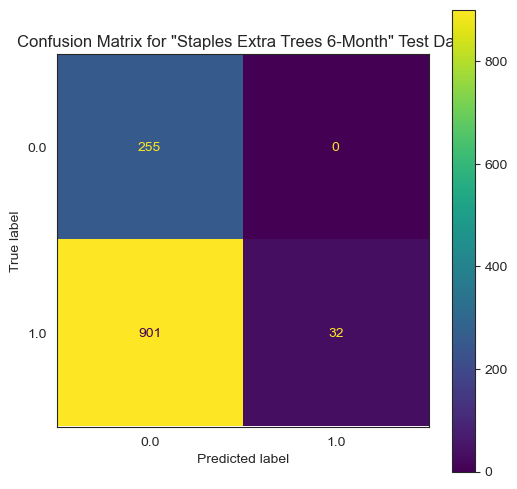

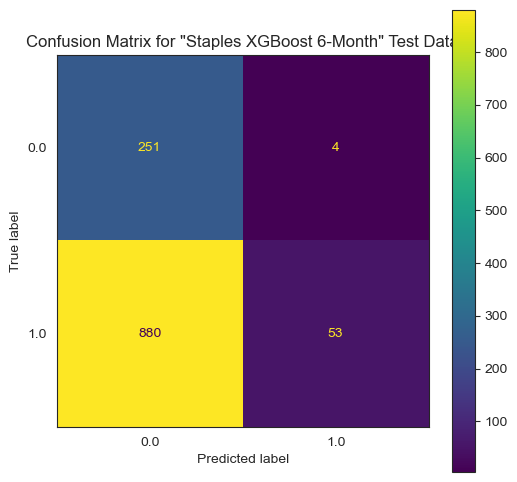

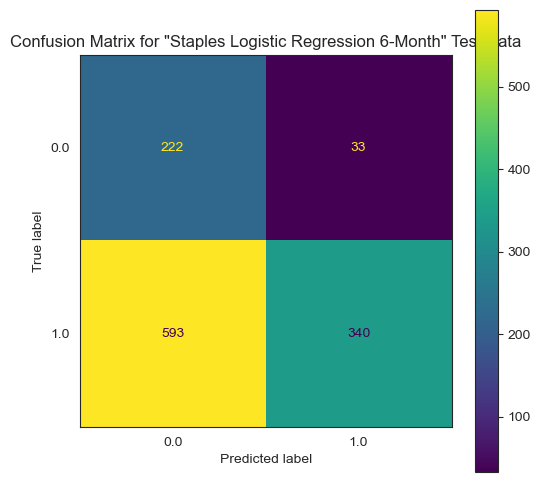

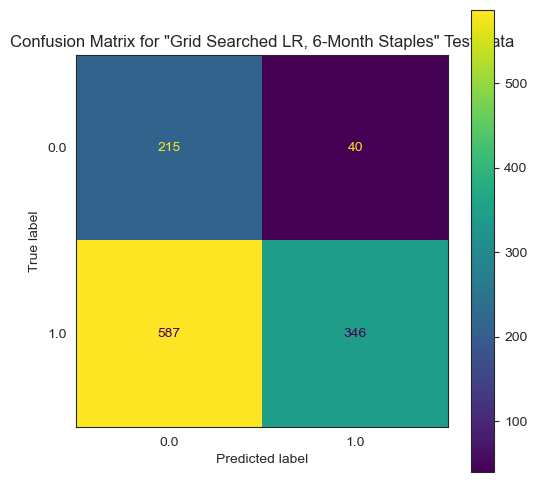

In [258]:
etc_stap_6.confusion_matrix(), XGBoost_stap_6.confusion_matrix(), logreg_stap_6.confusion_matrix(),\
grid_stap_6.confusion_matrix();

In [259]:
# Importance
coefs_from_lr(grid_stap_6)
Importance.df[-4:]

Top 5 Feature Coefficients
('garman_klass_vol', 4.179568192384737)
('Interest_Rates', 0.8225902071516453)
('upper_bollinger_band', 0.7681509477338982)
('Adj Close', 0.6706349757114801)
('one_up_bollinger_band', 0.5230079317009002)


Adj Close     Close      High       Low      Open  \
Technology 12-Month   3.626653 -6.367175 -3.317404 -0.960520  3.027762   
20                    0.623564 -1.017020 -0.596937 -0.711028 -0.478672   
21                    0.048369  0.054899  0.060723  0.057336  0.049922   
22                    0.670635 -1.173837 -1.063513 -0.784607 -0.597992   

                       Volume  GDP_Filled  Interest_Rates    Mkt-RF       SMB  \
Technology 12-Month  2.779967   -4.932735       -0.380182 -0.476700 -0.046248   
20                   0.028267   -1.041940        0.433111 -0.073296 -0.031532   
21                   0.026380    0.092055        0.070057  0.005053  0.002187   
22                   0.176673   -1.937848        0.822590 -0.167380  0.004755   

                          HML       RMW       CMA  garman_klass_vol       RSI  \
Technology 12-Month  0.134418  0.078175 -0.074792          3.236026 -0.054959   
20                   0.083186 -0.019512 -0.017331          1.763126 -0.256223   
21                   0.005513  0.003319  0.004349          0.067301  0.016125   
22                   0.038127 -0.143508 -0.047115          4.179568 -0.307944   

                     lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Technology 12-Month               3.915278              2.465234    1.047442   
20                               -0.547322             -0.071557    0.396726   
21                                0.046483              0.037300    0.042609   
22                               -0.237039              0.020381    0.273742   

                     one_up_bollinger_band  upper_bollinger_band       ATR  \
Technology 12-Month              -0.334900             -1.679179 -1.738609   
20                                0.857458              1.310588 -0.220763   
21                                0.044029              0.036709  0.059199   
22                                0.523008              0.768151 -0.447077   

                         MACD  dollar_volume(M)  Quarter_1  Quarter_2  \
Technology 12-Month  0.354835         -1.852527  -0.467191  -0.074889   
20                   0.007134         -0.066164   0.095634  -0.087112   
21                   0.024920          0.021668   0.007228   0.007986   
22                   0.172811          0.107723   0.220543   0.148519   

                     Quarter_3  Quarter_4   Month_1  Month_10  Month_11  \
Technology 12-Month   0.289233   0.569871 -0.547381  0.413154  0.364789   
20                   -0.207783   0.203905 -0.232063  0.188658  0.271294   
21                    0.007882   0.006425  0.005341  0.000835  0.001664   
22                    0.238874   0.108871  0.099953  0.056102  0.012348   

                     Month_12   Month_2   Month_3   Month_4   Month_5  \
Technology 12-Month -0.208071 -0.148846  0.229035 -0.153375  0.114557   
20                  -0.256048  0.055543  0.272153  0.380805 -0.320701   
21                   0.002853  0.001401  0.003326  0.000864  0.004245   
22                   0.040421  0.062191  0.058399 -0.007908  0.029720   

                      Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
Technology 12-Month -0.036071  0.008848  0.029745  0.250640     -0.334266   
20                  -0.147217 -0.221168 -0.010686  0.024071      0.078129   
21                   0.004035  0.003513  0.004128  0.003139      0.011596   
22                   0.126707  0.203150  0.045080 -0.009356      0.380542   

                     cycle_year_2  cycle_year_3  cycle_year_4  \
Technology 12-Month      0.770631      0.346802     -0.466143   
20                      -0.101026     -0.001708      0.029248   
21                       0.015984      0.008006      0.021713   
22                      -0.033600      0.386474     -0.016609   

                     day_of_week_Friday  day_of_week_Monday  \
Technology 12-Month            0.045467            0.090133   
20                             0.002694           -0.050823   
21                             0.0001

<hr style="border: 2px solid darkgreen">

# XLP 12 Month

In [265]:
# Create variables

X_train, X_test, y_train, y_test = select_data(staples_df, "Twelve")


# Create Model Objects

# dummy_stap_12 = dummy_model(Staples, "Staples", 12)
# logreg_stap_12 = l_regr(Staples, "Staples", 12)
# rfc_stap_12 = r_forest(Staples, "Staples", 12)
# etc_stap_12 = extra_trees(Staples, "Staples", 12)
# XGBoost_stap_12 = x_g_b(Staples, "Staples", 12)

# grid_stap_12 = best_etc_grid(estimator=etc_stap_12.model, model_type=Staples, \
#                             sector_name="Staples", time_period=12)
# grid_stap_12 = best_logreg_search(logreg_stap_12.model, Staples, "Staples", 12)

Staples.model_df.iloc[18:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
20        Staples Random Forest 12-Month        0.707206    0.945162   
21          Staples Extra Trees 12-Month        0.702655    0.946276   
22              Staples XGBoost 12-Month        0.497345    0.891943   
23    Grid Searched LR, 12-Month Staples        0.613906    0.947064   
19  Staples Logistic Regression 12-Month        0.588875    0.946635   
18                Dummy Staples 12-Month        0.724399    0.696334   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
20      0.712891  0.756944            NaN       0.238215   1.000000   
21      0.704716  0.747391            NaN       0.261785   1.000000   
22      0.460355  0.530349            NaN       0.314815   0.992832   
23      0.621605  0.684687            NaN       0.688552   0.985155   
19      0.600563  0.665279            NaN       0.702020   0.984190   
18      0.800000  0.741708            NaN       0.916667   0.916667   

    test_recall   test_f1  test_logloss       AUC  
20     0.168962  0.289081      1.976692  0.648788  
21     0.194674  0.325903      1.196163  0.764277  
22     0.254362  0.404971      2.196744  0.640334  
23     0.670340  0.797814      1.192832  0.835453  
19     0.685950  0.808442      0.953197  0.830769  
18     1.000000  0.956522      3.003638  0.500000

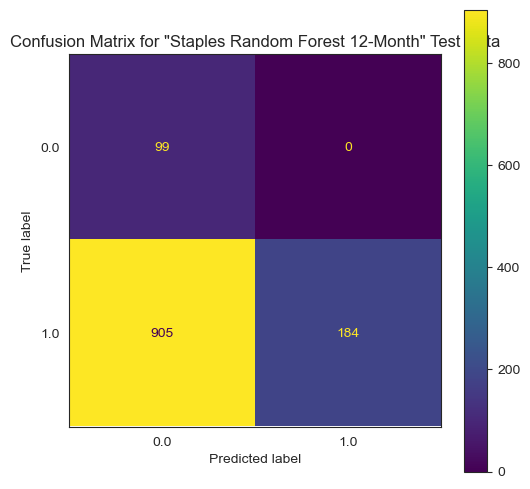

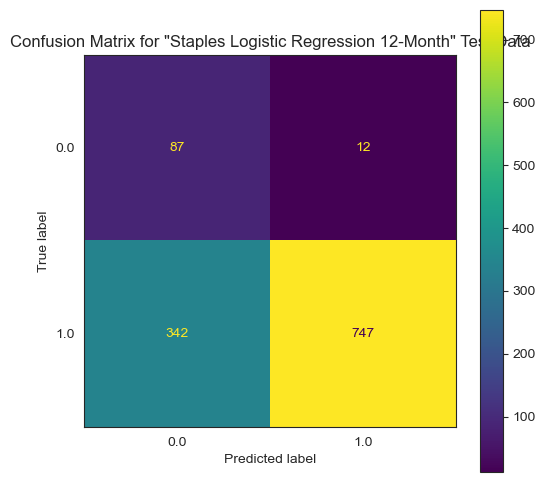

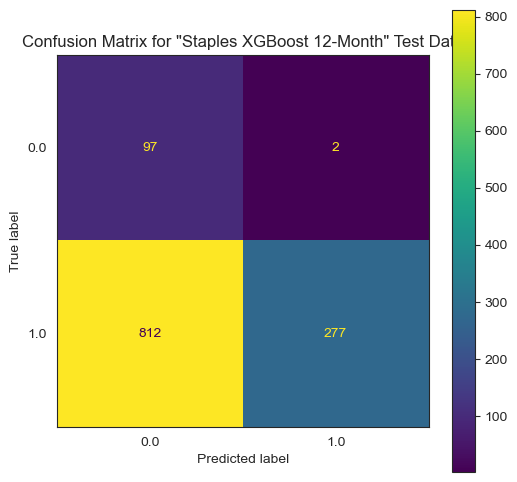

In [263]:
rfc_stap_12.confusion_matrix(), logreg_stap_12.confusion_matrix(), XGBoost_stap_12.confusion_matrix();

In [266]:
# Top 5 feature importances for the best model

coefs_from_lr(grid_stap_12)
Importance.df[-4:]

Top 5 Feature Coefficients
('garman_klass_vol', 9.832318758981)
('Adj Close', 6.152667780309538)
('upper_bollinger_band', 5.092530203728685)
('one_up_bollinger_band', 3.507068280460469)
('20_day_SMA', 1.8949223368825905)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
20   0.623564 -1.017020 -0.596937 -0.711028 -0.478672  0.028267   -1.041940   
21   0.048369  0.054899  0.060723  0.057336  0.049922  0.026380    0.092055   
22   0.670635 -1.173837 -1.063513 -0.784607 -0.597992  0.176673   -1.937848   
23   6.152668 -8.143817 -5.035870 -3.833596  0.765252  0.035256   -8.196188   

    Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
20        0.433111 -0.073296 -0.031532  0.083186 -0.019512 -0.017331   
21        0.070057  0.005053  0.002187  0.005513  0.003319  0.004349   
22        0.822590 -0.167380  0.004755  0.038127 -0.143508 -0.047115   
23        1.132290 -0.426937  0.139661  0.121276 -0.257004 -0.214158   

    garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
20          1.763126 -0.256223              -0.547322             -0.071557   
21          0.067301  0.016125               0.046483              0.037300   
22          4.179568 -0.307944              -0.237039              0.020381   
23          9.832319  0.016209              -1.408665              0.256266   

    20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
20    0.396726               0.857458              1.310588 -0.220763   
21    0.042609               0.044029              0.036709  0.059199   
22    0.273742               0.523008              0.768151 -0.447077   
23    1.894922               3.507068              5.092530 -0.474131   

        MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
20  0.007134         -0.066164   0.095634  -0.087112  -0.207783   0.203905   
21  0.024920          0.021668   0.007228   0.007986   0.007882   0.006425   
22  0.172811          0.107723   0.220543   0.148519   0.238874   0.108871   
23  0.187857          0.262332   0.119758   0.003084  -0.071920   0.456340   

     Month_1  Month_10  Month_11  Month_12   Month_2   Month_3   Month_4  \
20 -0.232063  0.188658  0.271294 -0.256048  0.055543  0.272153  0.380805   
21  0.005341  0.000835  0.001664  0.002853  0.001401  0.003326  0.000864   
22  0.099953  0.056102  0.012348  0.040421  0.062191  0.058399 -0.007908   
23 -0.235026  0.179603  0.399940 -0.123203  0.186895  0.167890  0.347188   

     Month_5   Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
20 -0.320701 -0.147217 -0.221168 -0.010686  0.024071      0.078129   
21  0.004245  0.004035  0.003513  0.004128  0.003139      0.011596   
22  0.029720  0.126707  0.203150  0.045080 -0.009356      0.380542   
23  0.092770 -0.436874 -0.419779  0.221076  0.126783     -0.565646   

    cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
20     -0.101026     -0.001708      0.029248            0.002694   
21      0.015984      0.008006      0.021713            0.000180   
22     -0.033600      0.386474     -0.016609            0.085754   
23     -0.115577      0.849765      0.338720            0.073273   

    day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
20           -0.050823              0.059091            -0.045850   
21            0.000240              0.000202             0.000473   
22            0.156677              0.158855             0.181120   
23            0.116940              0.043193             0.180667   

    day_of_week_Wednesday  
20               0.039531  
21               0.000237  
22               0.134401  
23               0.093189

In [269]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

Adj Close     Close      High       Low      Open    Volume  \
Staples 1-Month    0.623564 -1.017020 -0.596937 -0.711028 -0.478672  0.028267   
Staples 3-Month    0.048369  0.054899  0.060723  0.057336  0.049922  0.026380   
Staples 6-Month    0.670635 -1.173837 -1.063513 -0.784607 -0.597992  0.176673   
Staples 12-Month   6.152668 -8.143817 -5.035870 -3.833596  0.765252  0.035256   

                  GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
Staples 1-Month    -1.041940        0.433111 -0.073296 -0.031532  0.083186   
Staples 3-Month     0.092055        0.070057  0.005053  0.002187  0.005513   
Staples 6-Month    -1.937848        0.822590 -0.167380  0.004755  0.038127   
Staples 12-Month   -8.196188        1.132290 -0.426937  0.139661  0.121276   

                       RMW       CMA  garman_klass_vol       RSI  \
Staples 1-Month  -0.019512 -0.017331          1.763126 -0.256223   
Staples 3-Month   0.003319  0.004349          0.067301  0.016125   
Staples 6-Month  -0.143508 -0.047115          4.179568 -0.307944   
Staples 12-Month -0.257004 -0.214158          9.832319  0.016209   

                  lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Staples 1-Month               -0.547322             -0.071557    0.396726   
Staples 3-Month                0.046483              0.037300    0.042609   
Staples 6-Month               -0.237039              0.020381    0.273742   
Staples 12-Month              -1.408665              0.256266    1.894922   

                  one_up_bollinger_band  upper_bollinger_band       ATR  \
Staples 1-Month                0.857458              1.310588 -0.220763   
Staples 3-Month                0.044029              0.036709  0.059199   
Staples 6-Month                0.523008              0.768151 -0.447077   
Staples 12-Month               3.507068              5.092530 -0.474131   

                      MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Staples 1-Month   0.007134         -0.066164   0.095634  -0.087112  -0.207783   
Staples 3-Month   0.024920          0.021668   0.007228   0.007986   0.007882   
Staples 6-Month   0.172811          0.107723   0.220543   0.148519   0.238874   
Staples 12-Month  0.187857          0.262332   0.119758   0.003084  -0.071920   

                  Quarter_4   Month_1  Month_10  Month_11  Month_12   Month_2  \
Staples 1-Month    0.203905 -0.232063  0.188658  0.271294 -0.256048  0.055543   
Staples 3-Month    0.006425  0.005341  0.000835  0.001664  0.002853  0.001401   
Staples 6-Month    0.108871  0.099953  0.056102  0.012348  0.040421  0.062191   
Staples 12-Month   0.456340 -0.235026  0.179603  0.399940 -0.123203  0.186895   

                   Month_3   Month_4   Month_5   Month_6   Month_7   Month_8  \
Staples 1-Month   0.272153  0.380805 -0.320701 -0.147217 -0.221168 -0.010686   
Staples 3-Month   0.003326  0.000864  0.004245  0.004035  0.003513  0.004128   
Staples 6-Month   0.058399 -0.007908  0.029720  0.126707  0.203150  0.045080   
Staples 12-Month  0.167890  0.347188  0.092770 -0.436874 -0.419779  0.221076   

                   Month_9  cycle_year_1  cycle_year_2  cycle_year_3  \
Staples 1-Month   0.024071      0.078129     -0.101026     -0.001708   
Staples 3-Month   0.003139      0.011596      0.015984      0.008006   
Staples 6-Month  -0.009356      0.380542     -0.033600      0.386474   
Staples 12-Month  0.126783     -0.565646     -0.115577      0.849765   

                  cycle_year_4  day_of_week_Friday  day_of_week_Monday  \
Staples 1-Month       0.029248            0.002694           -0.050823   
Staples 3-Month       0.021713            0.000180            0.000240   
Staples 6-Month      -0.016609            0.085754            0.156677   
Staples 12-Month      0.338720            0.073273            0.116940   

                  day_of_week_Thursday  day_of_week_Tuesday  \
Staples 1-Month               0.059091            -0.045850   
Staples 3-Month               0.000202         

In [268]:
Importance.df.rename(index={20:"Staples 1-Month", 21:"Staples 3-Month", 22:"Staples 6-Month", \
                            23:"Staples 12-Month"}, inplace=True)

<hr style="border: 2px solid darkred">

# Utilites - XLU

### 1 Month

In [276]:
# Create variables

X_train, X_test, y_train, y_test = select_data(utilities_df, "One")


# Create Model Objects
                            
# dummy_U_1 = dummy_model(Utilities, "Utilities", 1)
# logreg_U_1 = l_regr(Utilities, "Utilities", 1)
# rfc_U_1 = r_forest(Utilities, "Utilities", 1)
# etc_U_1 = extra_trees(Utilities, "Utilities", 1)
# XGBoost_U_1 = x_g_b(Utilities, "Utilities", 1)

# grid_U_1 = best_etc_grid(estimator=rfc_U_1.model, model_type=Utilities, \
#                             sector_name="Utilities", time_period=1)
# grid_U_1 = best_logreg_search(logreg_U_1.model, Utilities, "Utilities", 1)

Utilities.model_df.sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
3          Utilities Extra Trees 1-Month        0.517826    0.651071   
4              Utilities XGBoost 1-Month        0.515550    0.654395   
5    Grid Searched LR, 1-Month Utilities        0.565613    0.647052   
1  Utilities Logistic Regression 1-Month        0.545386    0.640856   
0                Dummy Utilities 1-Month        0.574463    0.509482   
2        Utilities Random Forest 1-Month        0.530215    0.637389   

   train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
3      0.618672  0.581556       0.741474       0.375421   1.000000   
4      0.581357  0.586978       1.763233       0.408249   0.833333   
5      0.727456  0.675554       0.847614       0.692761   0.710817   
1      0.661277  0.632434       1.028724       0.670875   0.688161   
0      0.800000  0.621995      15.337919       0.628788   0.628788   
2      0.670474  0.592112       0.781475       0.371212   0.000000   

   test_recall   test_f1  test_logloss       AUC  
3     0.006693  0.013298      1.104187  0.557781  
4     0.073628  0.135301      2.974106  0.592095  
5     0.862115  0.779189      0.617215  0.685770  
1     0.871486  0.769049      0.637496  0.670176  
0     1.000000  0.772093     13.379841  0.500000  
2     0.000000  0.000000      1.678049  0.507926

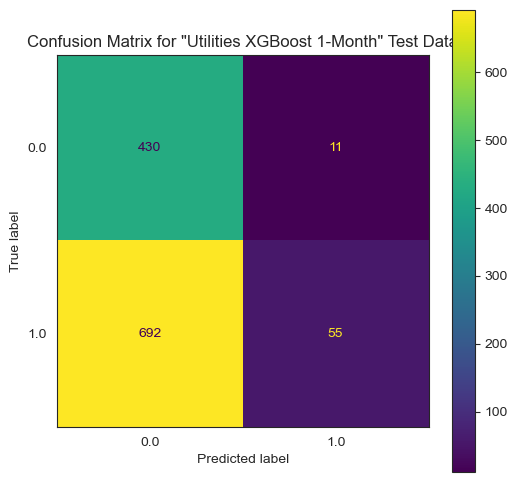

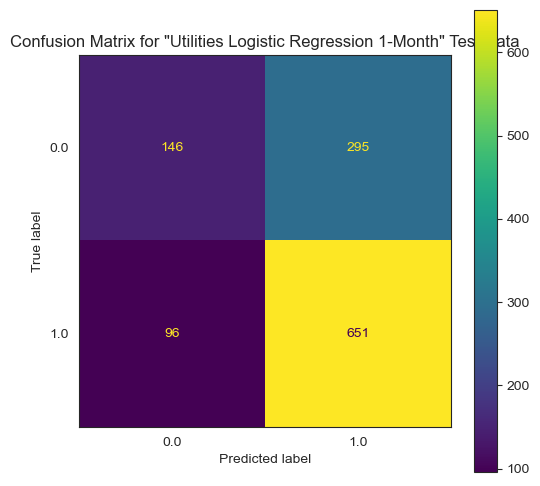

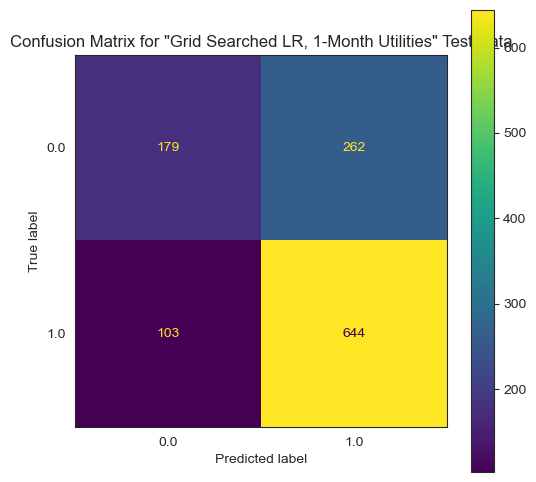

In [277]:
XGBoost_U_1.confusion_matrix(), logreg_U_1.confusion_matrix(), grid_U_1.confusion_matrix();

In [278]:
# Feature importance for the best model

coefs_from_lr(grid_U_1)
Importance.df[-4:]

Top 5 Feature Coefficients
('GDP_Filled', 2.326981811554737)
('Interest_Rates', 1.0345909352173672)
('Adj Close', 1.015576307636498)
('Month_3', 0.6218241649281242)
('lowest_bollinger_band', 0.40600474050494434)


Adj Close     Close      High       Low      Open    Volume  \
Staples 3-Month    0.048369  0.054899  0.060723  0.057336  0.049922  0.026380   
Staples 6-Month    0.670635 -1.173837 -1.063513 -0.784607 -0.597992  0.176673   
Staples 12-Month   6.152668 -8.143817 -5.035870 -3.833596  0.765252  0.035256   
24                 1.015576 -0.669647 -0.580329 -0.645025 -0.477082  0.106430   

                  GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
Staples 3-Month     0.092055        0.070057  0.005053  0.002187  0.005513   
Staples 6-Month    -1.937848        0.822590 -0.167380  0.004755  0.038127   
Staples 12-Month   -8.196188        1.132290 -0.426937  0.139661  0.121276   
24                  2.326982        1.034591 -0.052504 -0.021921 -0.015615   

                       RMW       CMA  garman_klass_vol       RSI  \
Staples 3-Month   0.003319  0.004349          0.067301  0.016125   
Staples 6-Month  -0.143508 -0.047115          4.179568 -0.307944   
Staples 12-Month -0.257004 -0.214158          9.832319  0.016209   
24                0.021540 -0.016334         -0.207828 -0.020652   

                  lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Staples 3-Month                0.046483              0.037300    0.042609   
Staples 6-Month               -0.237039              0.020381    0.273742   
Staples 12-Month              -1.408665              0.256266    1.894922   
24                             0.406005              0.157289   -0.086324   

                  one_up_bollinger_band  upper_bollinger_band       ATR  \
Staples 3-Month                0.044029              0.036709  0.059199   
Staples 6-Month                0.523008              0.768151 -0.447077   
Staples 12-Month               3.507068              5.092530 -0.474131   
24                            -0.324715             -0.557794 -0.082248   

                      MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Staples 3-Month   0.024920          0.021668   0.007228   0.007986   0.007882   
Staples 6-Month   0.172811          0.107723   0.220543   0.148519   0.238874   
Staples 12-Month  0.187857          0.262332   0.119758   0.003084  -0.071920   
24                0.016537         -0.032060   0.057583   0.252254  -0.057254   

                  Quarter_4   Month_1  Month_10  Month_11  Month_12   Month_2  \
Staples 3-Month    0.006425  0.005341  0.000835  0.001664  0.002853  0.001401   
Staples 6-Month    0.108871  0.099953  0.056102  0.012348  0.040421  0.062191   
Staples 12-Month   0.456340 -0.235026  0.179603  0.399940 -0.123203  0.186895   
24                 0.034426 -0.544544 -0.106844  0.082287  0.058983 -0.019697   

                   Month_3   Month_4   Month_5   Month_6   Month_7   Month_8  \
Staples 3-Month   0.003326  0.000864  0.004245  0.004035  0.003513  0.004128   
Staples 6-Month   0.058399 -0.007908  0.029720  0.126707  0.203150  0.045080   
Staples 12-Month  0.167890  0.347188  0.092770 -0.436874 -0.419779  0.221076   
24                0.621824  0.215508 -0.054025  0.090771 -0.386070 -0.013760   

                   Month_9  cycle_year_1  cycle_year_2  cycle_year_3  \
Staples 3-Month   0.003139      0.011596      0.015984      0.008006   
Staples 6-Month  -0.009356      0.380542     -0.033600      0.386474   
Staples 12-Month  0.126783     -0.565646     -0.115577      0.849765   
24                0.342576      0.249695     -0.225546      0.056065   

                  cycle_year_4  day_of_week_Friday  day_of_week_Monday  \
Staples 3-Month       0.021713            0.000180            0.000240   
Staples 6-Month      -0.016609            0.085754            0.156677   
Staples 12-Month      0.338720            0.073273            0.116940   
24                    0.206796            0.078585            0.062261   

                  day_of_week_Thursday  day_of_week_Tuesday  \
Staples 3-Month               0.000202             0.000473   
Staples 6-Month               0.158855         

<hr style="border: 2px solid darkgreen">

# XLU 3 Month 

In [286]:
# Create variables

X_train, X_test, y_train, y_test = select_data(utilities_df, "Three")


# Create Model Objects
                            
# dummy_U_3 = dummy_model(Utilities, "Utilities", 3)
# logreg_U_3 = l_regr(Utilities, "Utilities", 3)
# rfc_U_3 = r_forest(Utilities, "Utilities", 3)
# etc_U_3 = extra_trees(Utilities, "Utilities", 3)
# XGBoost_U_3 = x_g_b(Utilities, "Utilities", 3)

# grid_U_3 = best_etc_grid(estimator=rfc_U_3.model, model_type=Utilities, \
#                             sector_name="Utilities", time_period=3)
# grid_U_3 = best_logreg_search(logreg_U_3.model, Utilities, "Utilities", 3)

Utilities.model_df.iloc[6:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
8         Utilities Random Forest 3-Month        0.519090    0.671392   
9           Utilities Extra Trees 3-Month        0.541593    0.713039   
10              Utilities XGBoost 3-Month        0.561568    0.689244   
11    Grid Searched LR, 3-Month Utilities        0.587358    0.664738   
7   Utilities Logistic Regression 3-Month        0.577497    0.654824   
6                 Dummy Utilities 3-Month        0.597472    0.537547   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
8       0.609332  0.555249       0.832238       0.325758   0.911504   
9       0.629322  0.617432       0.712508       0.316498   0.841667   
10      0.706119  0.669343       1.714542       0.312290   0.818182   
11      0.769000  0.692362       1.280781       0.713805   0.816934   
7       0.754651  0.669034       1.975126       0.739057   0.798569   
6       0.800000  0.642185      14.508596       0.752525   0.752525   

    test_recall   test_f1  test_logloss       AUC  
8      0.115213  0.204568      1.492251  0.533627  
9      0.112975  0.199211      1.020218  0.483197  
10     0.110738  0.195074      3.660003  0.421795  
11     0.798658  0.807692      0.632844  0.665864  
7      0.873602  0.834402      0.733540  0.622548  
6      1.000000  0.858790      8.919894  0.500000

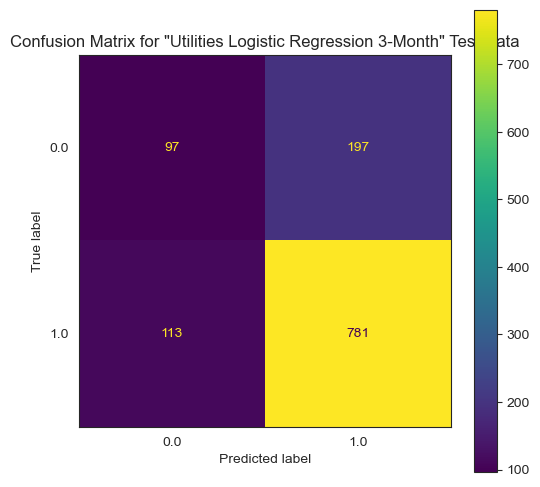

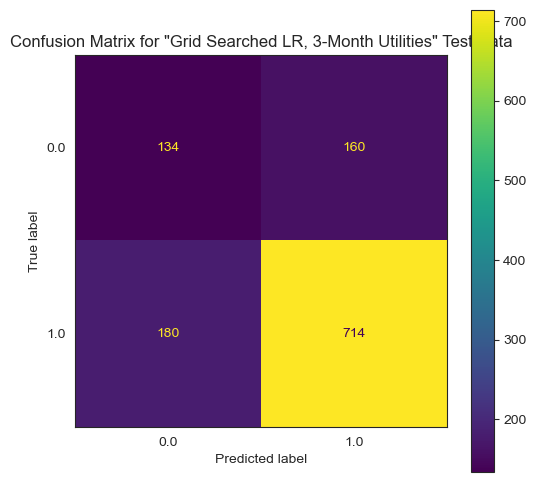

In [288]:
logreg_U_3.confusion_matrix(), grid_U_3.confusion_matrix();

In [289]:
# Feature importances of the best model

coefs_from_lr(grid_U_3)
Importance.df[-4:]

Top 5 Feature Coefficients
('GDP_Filled', 2.4584751667932982)
('Interest_Rates', 1.8493889554326846)
('Adj Close', 1.7224149911241025)
('lowest_bollinger_band', 0.591342824388825)
('Month_2', 0.5805910516143388)


Adj Close     Close      High       Low      Open    Volume  \
Staples 6-Month    0.670635 -1.173837 -1.063513 -0.784607 -0.597992  0.176673   
Staples 12-Month   6.152668 -8.143817 -5.035870 -3.833596  0.765252  0.035256   
24                 1.015576 -0.669647 -0.580329 -0.645025 -0.477082  0.106430   
25                 1.722415 -0.999006 -1.160766 -0.890582 -1.180156  0.449843   

                  GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
Staples 6-Month    -1.937848        0.822590 -0.167380  0.004755  0.038127   
Staples 12-Month   -8.196188        1.132290 -0.426937  0.139661  0.121276   
24                  2.326982        1.034591 -0.052504 -0.021921 -0.015615   
25                  2.458475        1.849389 -0.038830 -0.021983 -0.013662   

                       RMW       CMA  garman_klass_vol       RSI  \
Staples 6-Month  -0.143508 -0.047115          4.179568 -0.307944   
Staples 12-Month -0.257004 -0.214158          9.832319  0.016209   
24                0.021540 -0.016334         -0.207828 -0.020652   
25               -0.010424  0.031236          0.348004 -0.201259   

                  lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Staples 6-Month               -0.237039              0.020381    0.273742   
Staples 12-Month              -1.408665              0.256266    1.894922   
24                             0.406005              0.157289   -0.086324   
25                             0.591343              0.346799    0.107198   

                  one_up_bollinger_band  upper_bollinger_band       ATR  \
Staples 6-Month                0.523008              0.768151 -0.447077   
Staples 12-Month               3.507068              5.092530 -0.474131   
24                            -0.324715             -0.557794 -0.082248   
25                            -0.127339             -0.356719 -0.253782   

                      MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Staples 6-Month   0.172811          0.107723   0.220543   0.148519   0.238874   
Staples 12-Month  0.187857          0.262332   0.119758   0.003084  -0.071920   
24                0.016537         -0.032060   0.057583   0.252254  -0.057254   
25                0.102129         -0.362915   0.421302   0.179159  -0.096993   

                  Quarter_4   Month_1  Month_10  Month_11  Month_12   Month_2  \
Staples 6-Month    0.108871  0.099953  0.056102  0.012348  0.040421  0.062191   
Staples 12-Month   0.456340 -0.235026  0.179603  0.399940 -0.123203  0.186895   
24                 0.034426 -0.544544 -0.106844  0.082287  0.058983 -0.019697   
25                -0.109729 -0.574024  0.113995  0.095242 -0.318966  0.580591   

                   Month_3   Month_4   Month_5   Month_6   Month_7   Month_8  \
Staples 6-Month   0.058399 -0.007908  0.029720  0.126707  0.203150  0.045080   
Staples 12-Month  0.167890  0.347188  0.092770 -0.436874 -0.419779  0.221076   
24                0.621824  0.215508 -0.054025  0.090771 -0.386070 -0.013760   
25                0.414734  0.334041 -0.017192 -0.137690 -0.048019 -0.177471   

                   Month_9  cycle_year_1  cycle_year_2  cycle_year_3  \
Staples 6-Month  -0.009356      0.380542     -0.033600      0.386474   
Staples 12-Month  0.126783     -0.565646     -0.115577      0.849765   
24                0.342576      0.249695     -0.225546      0.056065   
25                0.128497      0.093221     -0.279008      0.221670   

                  cycle_year_4  day_of_week_Friday  day_of_week_Monday  \
Staples 6-Month      -0.016609            0.085754            0.156677   
Staples 12-Month      0.338720            0.073273            0.116940   
24                    0.206796            0.078585            0.062261   
25                    0.357854            0.057776            0.057813   

                  day_of_week_Thursday  day_of_week_Tuesday  \
Staples 6-Month               0.158855             0.181120   
Staples 12-Month              0.043193         

<hr style="border: 2px solid darkgreen">

# XLU 6 Month

In [295]:
# Create variables

X_train, X_test, y_train, y_test = select_data(utilities_df, "Six")


# Create Model Objects
                            
# dummy_U_6 = dummy_model(Utilities, "Utilities", 6)
# logreg_U_6 = l_regr(Utilities, "Utilities", 6)
# rfc_U_6 = r_forest(Utilities, "Utilities", 6)
# etc_U_6 = extra_trees(Utilities, "Utilities", 6)
# XGBoost_U_6 = x_g_b(Utilities, "Utilities", 6)

# grid_U_6 = best_etc_grid(estimator=etc_U_6.model, model_type=Utilities, \
#                             sector_name="Utilities", time_period=6)

Utilities.model_df.iloc[12:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
14             Utilities Random Forest 6-Month        0.460936    0.695637   
17  GridSearched Best-Model, 6-Month Utilities        0.520607    0.872435   
16                   Utilities XGBoost 6-Month        0.519343    0.730022   
15               Utilities Extra Trees 6-Month        0.558786    0.864044   
12                     Dummy Utilities 6-Month        0.607332    0.579014   
13       Utilities Logistic Regression 6-Month        0.662200    0.772124   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
14      0.421033  0.423809       0.859993       0.318182   1.000000   
17      0.506966  0.542419       0.724431       0.332492   1.000000   
16      0.592715  0.582059       2.126204       0.298822   0.970874   
15      0.547521  0.577545       0.728913       0.358586   0.924242   
12      0.800000  0.669374      14.153172       0.782828   0.782828   
13      0.828166  0.769346       2.212506       0.529461   0.775632   

    test_recall   test_f1  test_logloss       AUC  
14     0.129032  0.228571      1.109118  0.543482  
17     0.147312  0.256795      1.055865  0.539285  
16     0.107527  0.193611      3.695586  0.654876  
15     0.196774  0.324468      1.080193  0.501673  
12     1.000000  0.878187      7.827662  0.500000  
13     0.561290  0.651279      1.467688  0.576132

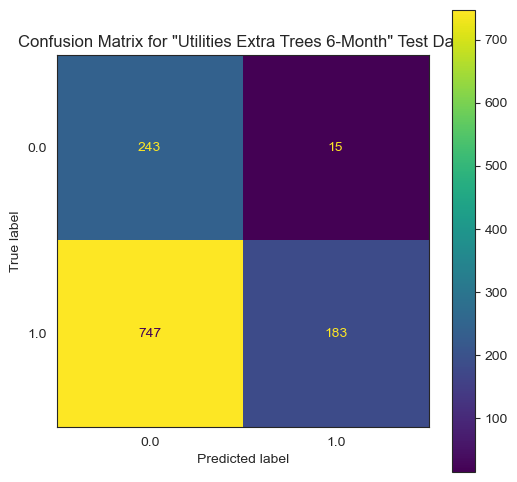

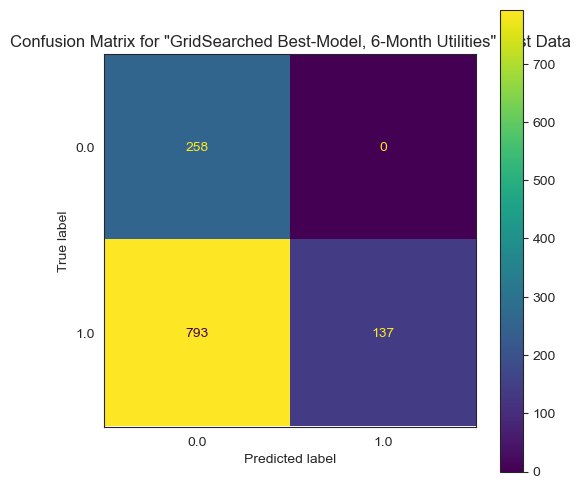

In [296]:
etc_U_6.confusion_matrix(), grid_U_6.confusion_matrix();

In [297]:
# Top 5 important features from the best model

features_from_trees(etc_U_6)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.08047135686818603)
('garman_klass_vol', 0.056609466769647544)
('cycle_year_4', 0.048186761934705336)
('Interest_Rates', 0.04762229422729849)
('ATR', 0.04554880103470808)


Adj Close     Close      High       Low      Open    Volume  \
Staples 12-Month   6.152668 -8.143817 -5.035870 -3.833596  0.765252  0.035256   
24                 1.015576 -0.669647 -0.580329 -0.645025 -0.477082  0.106430   
25                 1.722415 -0.999006 -1.160766 -0.890582 -1.180156  0.449843   
26                 0.039810  0.041571  0.041207  0.037620  0.038929  0.014646   

                  GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
Staples 12-Month   -8.196188        1.132290 -0.426937  0.139661  0.121276   
24                  2.326982        1.034591 -0.052504 -0.021921 -0.015615   
25                  2.458475        1.849389 -0.038830 -0.021983 -0.013662   
26                  0.080471        0.047622  0.005826  0.004715  0.006150   

                       RMW       CMA  garman_klass_vol       RSI  \
Staples 12-Month -0.257004 -0.214158          9.832319  0.016209   
24                0.021540 -0.016334         -0.207828 -0.020652   
25               -0.010424  0.031236          0.348004 -0.201259   
26                0.005671  0.005584          0.056609  0.018672   

                  lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Staples 12-Month              -1.408665              0.256266    1.894922   
24                             0.406005              0.157289   -0.086324   
25                             0.591343              0.346799    0.107198   
26                             0.039205              0.039696    0.041596   

                  one_up_bollinger_band  upper_bollinger_band       ATR  \
Staples 12-Month               3.507068              5.092530 -0.474131   
24                            -0.324715             -0.557794 -0.082248   
25                            -0.127339             -0.356719 -0.253782   
26                             0.038517              0.036829  0.045549   

                      MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Staples 12-Month  0.187857          0.262332   0.119758   0.003084  -0.071920   
24                0.016537         -0.032060   0.057583   0.252254  -0.057254   
25                0.102129         -0.362915   0.421302   0.179159  -0.096993   
26                0.026461          0.015756   0.016584   0.017411   0.012501   

                  Quarter_4   Month_1  Month_10  Month_11  Month_12   Month_2  \
Staples 12-Month   0.456340 -0.235026  0.179603  0.399940 -0.123203  0.186895   
24                 0.034426 -0.544544 -0.106844  0.082287  0.058983 -0.019697   
25                -0.109729 -0.574024  0.113995  0.095242 -0.318966  0.580591   
26                 0.017134  0.005456  0.006348  0.005055  0.008281  0.003212   

                   Month_3   Month_4   Month_5   Month_6   Month_7   Month_8  \
Staples 12-Month  0.167890  0.347188  0.092770 -0.436874 -0.419779  0.221076   
24                0.621824  0.215508 -0.054025  0.090771 -0.386070 -0.013760   
25                0.414734  0.334041 -0.017192 -0.137690 -0.048019 -0.177471   
26                0.006069  0.004898  0.007321  0.006577  0.009838  0.004654   

                   Month_9  cycle_year_1  cycle_year_2  cycle_year_3  \
Staples 12-Month  0.126783     -0.565646     -0.115577      0.849765   
24                0.342576      0.249695     -0.225546      0.056065   
25                0.128497      0.093221     -0.279008      0.221670   
26                0.009766      0.016184      0.032618      0.021966   

                  cycle_year_4  day_of_week_Friday  day_of_week_Monday  \
Staples 12-Month      0.338720            0.073273            0.116940   
24                    0.206796            0.078585            0.062261   
25                    0.357854            0.057776            0.057813   
26                    0.048187            0.002303            0.002251   

                  day_of_week_Thursday  day_of_week_Tuesday  \
Staples 12-Month              0.043193             0.180667   
24                            0.030462         

<hr style="border: 2px solid darkgreen">

# XLU 12 Month

In [302]:
# Create variables

X_train, X_test, y_train, y_test = select_data(utilities_df, "Twelve")


# Create Model Objects
                            
# dummy_U_12 = dummy_model(Utilities, "Utilities", 12)
# logreg_U_12 = l_regr(Utilities, "Utilities", 12)
# rfc_U_12 = r_forest(Utilities, "Utilities", 12)
# etc_U_12 = extra_trees(Utilities, "Utilities", 12)
# XGBoost_U_12 = x_g_b(Utilities, "Utilities", 12)

# grid_U_12 = best_etc_grid(estimator=etc_U_12.model, model_type=Utilities, \
#                             sector_name="Utilities", time_period=12)
# grid_U_12 = best_XGB_grid(XGBoost_U_12.model, Utilities, "Utilities", 12)

Utilities.model_df.iloc[18:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
22                 Utilities XGBoost 12-Month        0.501138    0.910417   
23  Grid Searched XGBoost, 12-Month Utilities        0.649810    0.980004   
20           Utilities Random Forest 12-Month        0.409608    0.919317   
19     Utilities Logistic Regression 12-Month        0.777244    0.916801   
21             Utilities Extra Trees 12-Month        0.492541    0.918683   
18                   Dummy Utilities 12-Month        0.699115    0.681416   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
22      0.537615  0.576841       2.023900       0.808923   0.853348   
23      0.603936  0.718533       3.556441       0.631313   0.811813   
20      0.441880  0.452144       1.529397       0.793771   0.810759   
19      0.835022  0.859369       1.432941       0.643939   0.791304   
21      0.524184  0.576306       1.188787       0.754209   0.756410   
18      0.800000  0.731161      10.844993       0.750842   0.750842   

    test_recall   test_f1  test_logloss       AUC  
22     0.900224  0.876159      0.586135  0.825459  
23     0.662556  0.729630      1.915462  0.636518  
20     0.946188  0.873254      0.473997  0.822480  
19     0.714126  0.750737      1.617341  0.606006  
21     0.992152  0.858390      0.521451  0.682993  
18     1.000000  0.857692      8.980574  0.500000

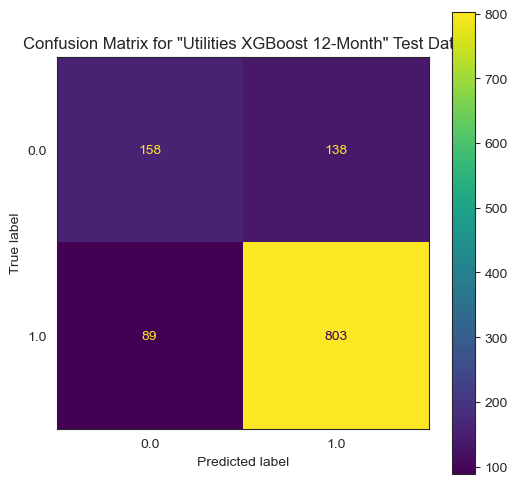

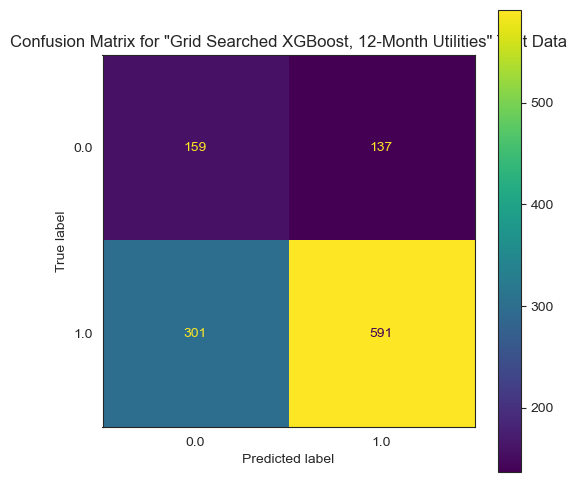

In [303]:
XGBoost_U_12.confusion_matrix(), grid_U_12.confusion_matrix();

In [304]:
# Top 5 feature importances for the best model

features_from_trees(XGBoost_U_12)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.29062757)
('Adj Close', 0.07115119)
('High', 0.0625839)
('upper_bollinger_band', 0.05930276)
('Month_9', 0.057842597)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
24   1.015576 -0.669647 -0.580329 -0.645025 -0.477082  0.106430    2.326982   
25   1.722415 -0.999006 -1.160766 -0.890582 -1.180156  0.449843    2.458475   
26   0.039810  0.041571  0.041207  0.037620  0.038929  0.014646    0.080471   
27   0.071151  0.039428  0.062584  0.005687  0.015223  0.007560    0.290628   

    Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
24        1.034591 -0.052504 -0.021921 -0.015615  0.021540 -0.016334   
25        1.849389 -0.038830 -0.021983 -0.013662 -0.010424  0.031236   
26        0.047622  0.005826  0.004715  0.006150  0.005671  0.005584   
27        0.057211  0.002821  0.001056  0.004323  0.002738  0.002093   

    garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
24         -0.207828 -0.020652               0.406005              0.157289   
25          0.348004 -0.201259               0.591343              0.346799   
26          0.056609  0.018672               0.039205              0.039696   
27          0.002257  0.015952               0.017147              0.000748   

    20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
24   -0.086324              -0.324715             -0.557794 -0.082248   
25    0.107198              -0.127339             -0.356719 -0.253782   
26    0.041596               0.038517              0.036829  0.045549   
27    0.000417               0.018998              0.059303  0.050856   

        MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
24  0.016537         -0.032060   0.057583   0.252254  -0.057254   0.034426   
25  0.102129         -0.362915   0.421302   0.179159  -0.096993  -0.109729   
26  0.026461          0.015756   0.016584   0.017411   0.012501   0.017134   
27  0.015074          0.009818   0.000846   0.049339   0.000351   0.000000   

     Month_1  Month_10  Month_11  Month_12   Month_2   Month_3   Month_4  \
24 -0.544544 -0.106844  0.082287  0.058983 -0.019697  0.621824  0.215508   
25 -0.574024  0.113995  0.095242 -0.318966  0.580591  0.414734  0.334041   
26  0.005456  0.006348  0.005055  0.008281  0.003212  0.006069  0.004898   
27  0.000000  0.041704  0.019808  0.016000  0.014327  0.000000  0.005440   

     Month_5   Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
24 -0.054025  0.090771 -0.386070 -0.013760  0.342576      0.249695   
25 -0.017192 -0.137690 -0.048019 -0.177471  0.128497      0.093221   
26  0.007321  0.006577  0.009838  0.004654  0.009766      0.016184   
27  0.000572  0.000000  0.000000  0.000000  0.057843      0.001880   

    cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
24     -0.225546      0.056065      0.206796            0.078585   
25     -0.279008      0.221670      0.357854            0.057776   
26      0.032618      0.021966      0.048187            0.002303   
27      0.026445      0.001688      0.005882            0.004354   

    day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
24            0.062261              0.030462             0.050409   
25            0.057813              0.093498             0.076860   
26            0.002251              0.002184             0.002164   
27            0.000000              0.000000             0.000000   

    day_of_week_Wednesday  
24               0.065292  
25               0.107790  
26               0.002327  
27               0.000449

In [305]:
Importance.df.rename(index={24:"Utilities 1-Month", 25:"Utilities 3-Month", 26:"Utilities 6-Month", \
                            27:"Utilities 12-Month"}, inplace=True)

In [306]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

Adj Close     Close      High       Low      Open  \
Utilities 1-Month    1.015576 -0.669647 -0.580329 -0.645025 -0.477082   
Utilities 3-Month    1.722415 -0.999006 -1.160766 -0.890582 -1.180156   
Utilities 6-Month    0.039810  0.041571  0.041207  0.037620  0.038929   
Utilities 12-Month   0.071151  0.039428  0.062584  0.005687  0.015223   

                      Volume  GDP_Filled  Interest_Rates    Mkt-RF       SMB  \
Utilities 1-Month   0.106430    2.326982        1.034591 -0.052504 -0.021921   
Utilities 3-Month   0.449843    2.458475        1.849389 -0.038830 -0.021983   
Utilities 6-Month   0.014646    0.080471        0.047622  0.005826  0.004715   
Utilities 12-Month  0.007560    0.290628        0.057211  0.002821  0.001056   

                         HML       RMW       CMA  garman_klass_vol       RSI  \
Utilities 1-Month  -0.015615  0.021540 -0.016334         -0.207828 -0.020652   
Utilities 3-Month  -0.013662 -0.010424  0.031236          0.348004 -0.201259   
Utilities 6-Month   0.006150  0.005671  0.005584          0.056609  0.018672   
Utilities 12-Month  0.004323  0.002738  0.002093          0.002257  0.015952   

                    lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Utilities 1-Month                0.406005              0.157289   -0.086324   
Utilities 3-Month                0.591343              0.346799    0.107198   
Utilities 6-Month                0.039205              0.039696    0.041596   
Utilities 12-Month               0.017147              0.000748    0.000417   

                    one_up_bollinger_band  upper_bollinger_band       ATR  \
Utilities 1-Month               -0.324715             -0.557794 -0.082248   
Utilities 3-Month               -0.127339             -0.356719 -0.253782   
Utilities 6-Month                0.038517              0.036829  0.045549   
Utilities 12-Month               0.018998              0.059303  0.050856   

                        MACD  dollar_volume(M)  Quarter_1  Quarter_2  \
Utilities 1-Month   0.016537         -0.032060   0.057583   0.252254   
Utilities 3-Month   0.102129         -0.362915   0.421302   0.179159   
Utilities 6-Month   0.026461          0.015756   0.016584   0.017411   
Utilities 12-Month  0.015074          0.009818   0.000846   0.049339   

                    Quarter_3  Quarter_4   Month_1  Month_10  Month_11  \
Utilities 1-Month   -0.057254   0.034426 -0.544544 -0.106844  0.082287   
Utilities 3-Month   -0.096993  -0.109729 -0.574024  0.113995  0.095242   
Utilities 6-Month    0.012501   0.017134  0.005456  0.006348  0.005055   
Utilities 12-Month   0.000351   0.000000  0.000000  0.041704  0.019808   

                    Month_12   Month_2   Month_3   Month_4   Month_5  \
Utilities 1-Month   0.058983 -0.019697  0.621824  0.215508 -0.054025   
Utilities 3-Month  -0.318966  0.580591  0.414734  0.334041 -0.017192   
Utilities 6-Month   0.008281  0.003212  0.006069  0.004898  0.007321   
Utilities 12-Month  0.016000  0.014327  0.000000  0.005440  0.000572   

                     Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
Utilities 1-Month   0.090771 -0.386070 -0.013760  0.342576      0.249695   
Utilities 3-Month  -0.137690 -0.048019 -0.177471  0.128497      0.093221   
Utilities 6-Month   0.006577  0.009838  0.004654  0.009766      0.016184   
Utilities 12-Month  0.000000  0.000000  0.000000  0.057843      0.001880   

                    cycle_year_2  cycle_year_3  cycle_year_4  \
Utilities 1-Month      -0.225546      0.056065      0.206796   
Utilities 3-Month      -0.279008      0.221670      0.357854   
Utilities 6-Month       0.032618      0.021966      0.048187   
Utilities 12-Month      0.026445      0.001688      0.005882   

                    day_of_week_Friday  day_of_week_Monday  \
Utilities 1-Month             0.078585            0.062261   
Utilities 3-Month             0.057776            0.057813   
Utilities 6-Month             0.002303            0.002251   
Utilities 12-Month         

<hr style="border: 2px solid darkred">

# Health Care - XLV

### 1 Month

In [313]:
# Create variables

X_train, X_test, y_train, y_test = select_data(health_df, "One")


# Create Model Objects
                            
# dummy_H_1 = dummy_model(Health, "Health", 1)
# logreg_H_1 = l_regr(Health, "Health", 1)
# rfc_H_1 = r_forest(Health, "Health", 1)
# etc_H_1 = extra_trees(Health, "Health", 1)
# XGBoost_H_1 = x_g_b(Health, "Health", 1)

# grid_H_1 = best_etc_grid(estimator=etc_H_1.model, model_type=Health, \
#                             sector_name="Health", time_period=1)
# grid_H_1 = best_logreg_search(logreg_H_1.model, Health, "Health", 1)

Health.model_df.sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
2        Health Random Forest 1-Month        0.520354    0.705112   
3          Health Extra Trees 1-Month        0.512263    0.667623   
5    Grid Searched LR, 1-Month Health        0.526928    0.709680   
1  Health Logistic Regression 1-Month        0.532238    0.707119   
0                Dummy Health 1-Month        0.630847    0.630847   
4              Health XGBoost 1-Month        0.508723    0.671932   

   train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
2      0.443755  0.494029       0.743176       0.399832   0.851852   
3      0.449051  0.458810       0.858527       0.418350   0.711340   
5      0.550021  0.523818       1.797421       0.558923   0.645658   
1      0.562207  0.532744       1.849455       0.576599   0.628219   
0      1.000000  0.770757      13.305622       0.616162   0.616162   
4      0.471304  0.469450       2.256337       0.383838   0.500000   

   test_recall   test_f1  test_logloss       AUC  
2     0.031421  0.060606      1.022858  0.561392  
3     0.094262  0.166466      0.936781  0.646800  
5     0.629781  0.637621      0.770286  0.551571  
1     0.766393  0.690462      0.802268  0.535279  
0     1.000000  0.762500     13.834938  0.500000  
4     0.019126  0.036842      4.205947  0.528038

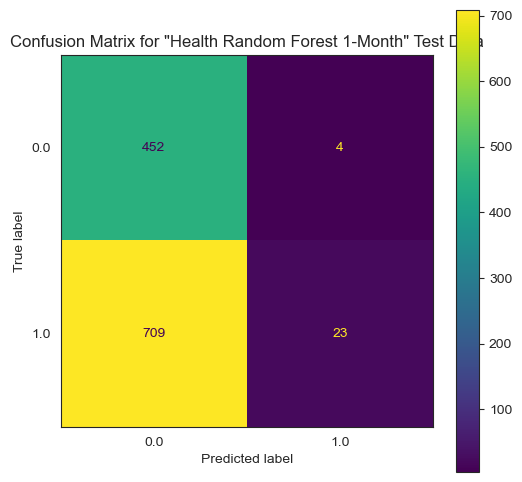

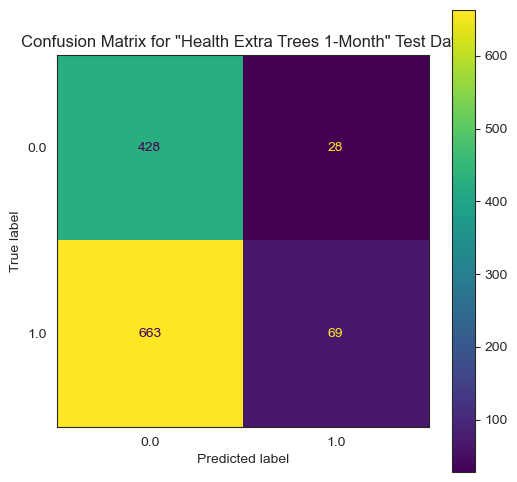

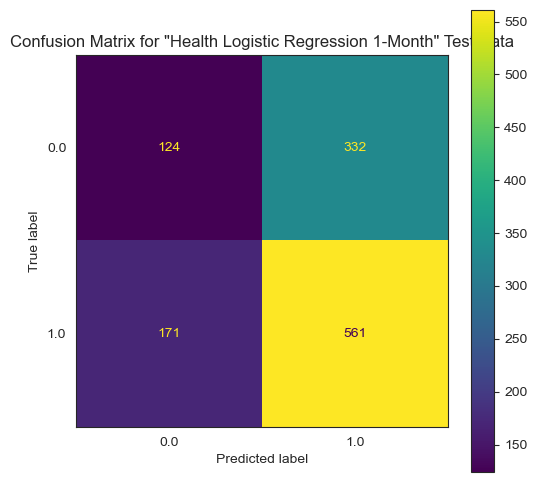

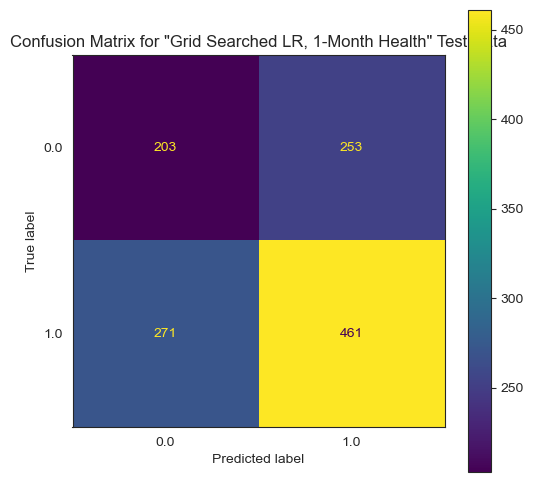

In [314]:
rfc_H_1.confusion_matrix(), etc_H_1.confusion_matrix(), logreg_H_1.confusion_matrix(), grid_H_1.confusion_matrix();

In [315]:
# Feature importance for the best model

coefs_from_lr(grid_H_1)
Importance.df[-4:]

Top 5 Feature Coefficients
('garman_klass_vol', 0.7227528493494022)
('upper_bollinger_band', 0.6685325943766304)
('Adj Close', 0.5264244379913119)
('Month_12', 0.5026636491354467)
('one_up_bollinger_band', 0.4778452051882897)


Adj Close     Close      High       Low      Open  \
Utilities 3-Month    1.722415 -0.999006 -1.160766 -0.890582 -1.180156   
Utilities 6-Month    0.039810  0.041571  0.041207  0.037620  0.038929   
Utilities 12-Month   0.071151  0.039428  0.062584  0.005687  0.015223   
28                   0.526424 -0.772243 -0.512589 -0.497993 -0.218742   

                      Volume  GDP_Filled  Interest_Rates    Mkt-RF       SMB  \
Utilities 3-Month   0.449843    2.458475        1.849389 -0.038830 -0.021983   
Utilities 6-Month   0.014646    0.080471        0.047622  0.005826  0.004715   
Utilities 12-Month  0.007560    0.290628        0.057211  0.002821  0.001056   
28                 -0.436955   -0.311096       -0.132291 -0.106200 -0.042532   

                         HML       RMW       CMA  garman_klass_vol       RSI  \
Utilities 3-Month  -0.013662 -0.010424  0.031236          0.348004 -0.201259   
Utilities 6-Month   0.006150  0.005671  0.005584          0.056609  0.018672   
Utilities 12-Month  0.004323  0.002738  0.002093          0.002257  0.015952   
28                  0.033452 -0.034622 -0.033876          0.722753 -0.061447   

                    lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Utilities 3-Month                0.591343              0.346799    0.107198   
Utilities 6-Month                0.039205              0.039696    0.041596   
Utilities 12-Month               0.017147              0.000748    0.000417   
28                              -0.120932              0.083105    0.282703   

                    one_up_bollinger_band  upper_bollinger_band       ATR  \
Utilities 3-Month               -0.127339             -0.356719 -0.253782   
Utilities 6-Month                0.038517              0.036829  0.045549   
Utilities 12-Month               0.018998              0.059303  0.050856   
28                               0.477845              0.668533 -0.296634   

                        MACD  dollar_volume(M)  Quarter_1  Quarter_2  \
Utilities 3-Month   0.102129         -0.362915   0.421302   0.179159   
Utilities 6-Month   0.026461          0.015756   0.016584   0.017411   
Utilities 12-Month  0.015074          0.009818   0.000846   0.049339   
28                 -0.300790          0.378944   0.046538  -0.038751   

                    Quarter_3  Quarter_4   Month_1  Month_10  Month_11  \
Utilities 3-Month   -0.096993  -0.109729 -0.574024  0.113995  0.095242   
Utilities 6-Month    0.012501   0.017134  0.005456  0.006348  0.005055   
Utilities 12-Month   0.000351   0.000000  0.000000  0.041704  0.019808   
28                  -0.371526   0.366364 -0.082617 -0.521616  0.385317   

                    Month_12   Month_2   Month_3   Month_4   Month_5  \
Utilities 3-Month  -0.318966  0.580591  0.414734  0.334041 -0.017192   
Utilities 6-Month   0.008281  0.003212  0.006069  0.004898  0.007321   
Utilities 12-Month  0.016000  0.014327  0.000000  0.005440  0.000572   
28                  0.502664 -0.069641  0.198795  0.269596 -0.285188   

                     Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
Utilities 3-Month  -0.137690 -0.048019 -0.177471  0.128497      0.093221   
Utilities 6-Month   0.006577  0.009838  0.004654  0.009766      0.016184   
Utilities 12-Month  0.000000  0.000000  0.000000  0.057843      0.001880   
28                 -0.023159 -0.172566  0.137972 -0.336932      0.436496   

                    cycle_year_2  cycle_year_3  cycle_year_4  \
Utilities 3-Month      -0.279008      0.221670      0.357854   
Utilities 6-Month       0.032618      0.021966      0.048187   
Utilities 12-Month      0.026445      0.001688      0.005882   
28                     -0.099941      0.073563     -0.407493   

                    day_of_week_Friday  day_of_week_Monday  \
Utilities 3-Month             0.057776            0.057813   
Utilities 6-Month             0.002303            0.002251   
Utilities 12-Month            0.004354            0.000000   
28                         

<hr style="border: 2px solid darkgreen">

# XLV 3 Month 

In [320]:
# Create variables

X_train, X_test, y_train, y_test = select_data(health_df, "Three")


# Create Model Objects
                            
# dummy_H_3 = dummy_model(Health, "Health", 3)
# logreg_H_3 = l_regr(Health, "Health", 3)
# rfc_H_3 = r_forest(Health, "Health", 3)
# etc_H_3 = extra_trees(Health, "Health", 3)
# XGBoost_H_3 = x_g_b(Health, "Health", 3)

# grid_H_3 = best_etc_grid(estimator=etc_H_3.model, model_type=Health, \
#                             sector_name="Health", time_period=3)

Health.model_df.iloc[6:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


name  train_accuracy  train_prec  \
10                   Health XGBoost 3-Month        0.479899    0.764065   
9                Health Extra Trees 3-Month        0.537042    0.836567   
11  GridSearched Best-Model, 3-Month Health        0.537042    0.836567   
6                      Dummy Health 3-Month        0.700126    0.700126   
7        Health Logistic Regression 3-Month        0.558028    0.806475   
8              Health Random Forest 3-Month        0.520607    0.816305   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
10      0.446311  0.491550       2.697904       0.357744   0.865979   
9       0.509274  0.522203       0.952535       0.399832   0.807107   
11      0.509274  0.522203       0.952535       0.399832   0.807107   
6       1.000000  0.815604      10.808539       0.702020   0.702020   
7       0.613258  0.590468       3.227454       0.664141   0.691630   
8       0.482123  0.524994       0.994740       0.297980   0.000000   

    test_recall   test_f1  test_logloss       AUC  
10     0.100719  0.180451      3.693161  0.539196  
9      0.190647  0.308438      1.113184  0.633928  
11     0.190647  0.308438      1.113184  0.633928  
6      1.000000  0.824926     10.740281  0.500000  
7      0.941247  0.797359      1.035548  0.536374  
8      0.000000  0.000000      1.608132  0.637219

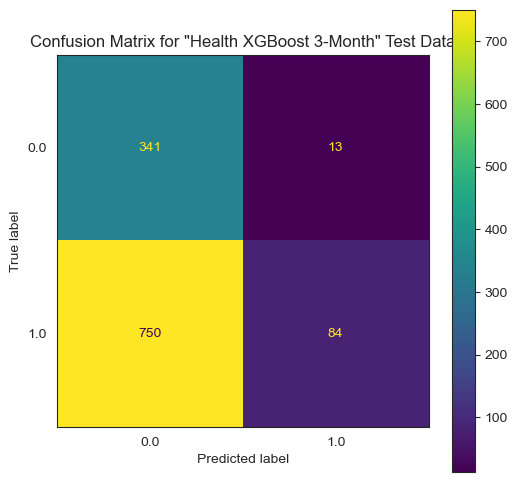

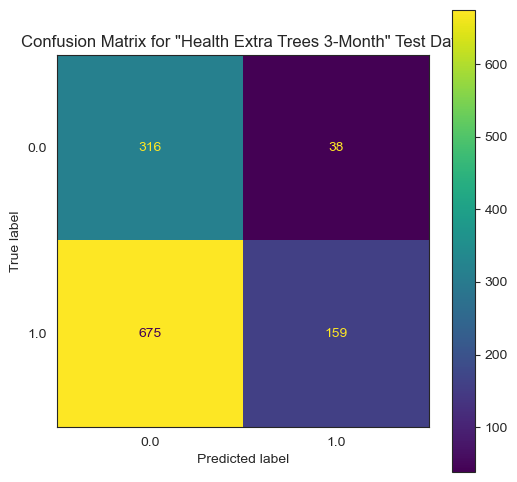

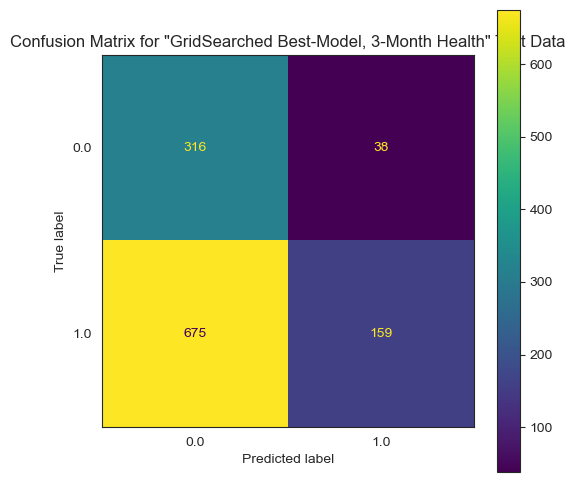

In [321]:
XGBoost_H_3.confusion_matrix(), etc_H_3.confusion_matrix(), grid_H_3.confusion_matrix();

In [322]:
# Feature importances of the best model

features_from_trees(etc_H_3)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.05470484973201946)
('lowest_bollinger_band', 0.04605294598888658)
('20_day_SMA', 0.044016132657005255)
('lower_bollinger_band', 0.043488668925872026)
('Close', 0.04275127072980455)


Adj Close     Close      High       Low      Open  \
Utilities 6-Month    0.039810  0.041571  0.041207  0.037620  0.038929   
Utilities 12-Month   0.071151  0.039428  0.062584  0.005687  0.015223   
28                   0.526424 -0.772243 -0.512589 -0.497993 -0.218742   
29                   0.042129  0.042751  0.036917  0.038144  0.036087   

                      Volume  GDP_Filled  Interest_Rates    Mkt-RF       SMB  \
Utilities 6-Month   0.014646    0.080471        0.047622  0.005826  0.004715   
Utilities 12-Month  0.007560    0.290628        0.057211  0.002821  0.001056   
28                 -0.436955   -0.311096       -0.132291 -0.106200 -0.042532   
29                  0.014202    0.054705        0.041522  0.006645  0.006267   

                         HML       RMW       CMA  garman_klass_vol       RSI  \
Utilities 6-Month   0.006150  0.005671  0.005584          0.056609  0.018672   
Utilities 12-Month  0.004323  0.002738  0.002093          0.002257  0.015952   
28                  0.033452 -0.034622 -0.033876          0.722753 -0.061447   
29                  0.007289  0.007636  0.007948          0.032664  0.018131   

                    lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Utilities 6-Month                0.039205              0.039696    0.041596   
Utilities 12-Month               0.017147              0.000748    0.000417   
28                              -0.120932              0.083105    0.282703   
29                               0.046053              0.043489    0.044016   

                    one_up_bollinger_band  upper_bollinger_band       ATR  \
Utilities 6-Month                0.038517              0.036829  0.045549   
Utilities 12-Month               0.018998              0.059303  0.050856   
28                               0.477845              0.668533 -0.296634   
29                               0.041235              0.042490  0.029334   

                        MACD  dollar_volume(M)  Quarter_1  Quarter_2  \
Utilities 6-Month   0.026461          0.015756   0.016584   0.017411   
Utilities 12-Month  0.015074          0.009818   0.000846   0.049339   
28                 -0.300790          0.378944   0.046538  -0.038751   
29                  0.023032          0.013478   0.021212   0.016724   

                    Quarter_3  Quarter_4   Month_1  Month_10  Month_11  \
Utilities 6-Month    0.012501   0.017134  0.005456  0.006348  0.005055   
Utilities 12-Month   0.000351   0.000000  0.000000  0.041704  0.019808   
28                  -0.371526   0.366364 -0.082617 -0.521616  0.385317   
29                   0.022712   0.021106  0.009787  0.006154  0.006892   

                    Month_12   Month_2   Month_3   Month_4   Month_5  \
Utilities 6-Month   0.008281  0.003212  0.006069  0.004898  0.007321   
Utilities 12-Month  0.016000  0.014327  0.000000  0.005440  0.000572   
28                  0.502664 -0.069641  0.198795  0.269596 -0.285188   
29                  0.009179  0.005994  0.009397  0.008179  0.008886   

                     Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
Utilities 6-Month   0.006577  0.009838  0.004654  0.009766      0.016184   
Utilities 12-Month  0.000000  0.000000  0.000000  0.057843      0.001880   
28                 -0.023159 -0.172566  0.137972 -0.336932      0.436496   
29                  0.011735  0.014198  0.008341  0.009901      0.031567   

                    cycle_year_2  cycle_year_3  cycle_year_4  \
Utilities 6-Month       0.032618      0.021966      0.048187   
Utilities 12-Month      0.026445      0.001688      0.005882   
28                     -0.099941      0.073563     -0.407493   
29                      0.024407      0.032563      0.030621   

                    day_of_week_Friday  day_of_week_Monday  \
Utilities 6-Month             0.002303            0.002251   
Utilities 12-Month            0.004354            0.000000   
28                            0.005109            0.045273   
29                         

<hr style="border: 2px solid darkgreen">

# XLV 6 Month

In [327]:
# Create variables

X_train, X_test, y_train, y_test = select_data(health_df, "Six")


# Create Model Objects
                            
# dummy_H_6 = dummy_model(Health, "Health", 6)
# logreg_H_6 = l_regr(Health, "Health", 6)
# rfc_H_6 = r_forest(Health, "Health", 6)
# etc_H_6 = extra_trees(Health, "Health", 6)
# XGBoost_H_6 = x_g_b(Health, "Health", 6)

# grid_H_6 = best_etc_grid(estimator=rfc_H_6.model, model_type=Health, \
#                             sector_name="Health", time_period=6)

Health.model_df.iloc[12:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
14             Health Random Forest 6-Month        0.462705    0.825016   
16                   Health XGBoost 6-Month        0.490518    0.766551   
12                     Dummy Health 6-Month        0.640455    0.574463   
17  GridSearched Best-Model, 6-Month Health        0.451327    0.877300   
15               Health Extra Trees 6-Month        0.481922    0.738634   
13       Health Logistic Regression 6-Month        0.493552    0.793847   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
14      0.401086  0.422490            NaN       0.370370   0.966346   
16      0.465549  0.523609            NaN       0.441077   0.871658   
12      0.800000  0.660612            NaN       0.792929   0.792929   
17      0.373526  0.389257            NaN       0.792929   0.792929   
15      0.490679  0.490618            NaN       0.539562   0.786647   
13      0.593578  0.532383            NaN       0.653199   0.764471   

    test_recall   test_f1  test_logloss       AUC  
14     0.213376  0.349565      0.749420  0.620952  
16     0.346072  0.495441      1.833425  0.593259  
12     1.000000  0.884507      7.463585  0.500000  
17     1.000000  0.884507      0.571422  0.364289  
15     0.575372  0.664623      0.733317  0.515656  
13     0.813163  0.788066      1.013591  0.378157

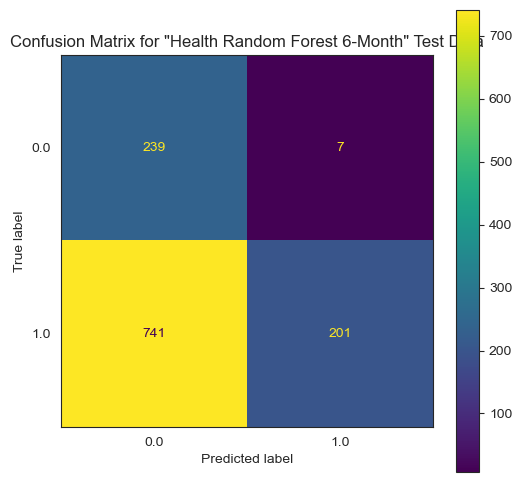

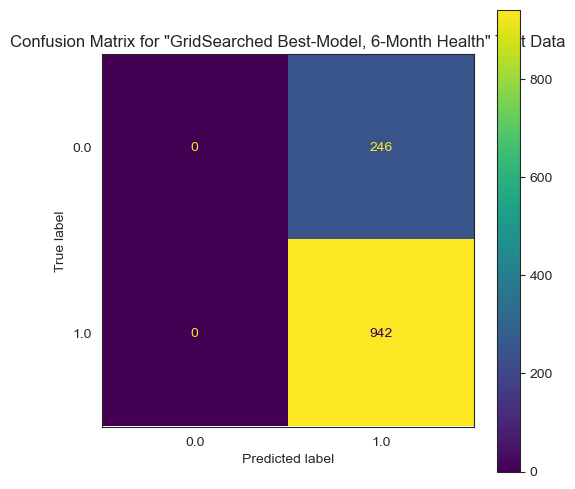

In [329]:
rfc_H_6.confusion_matrix(), grid_H_6.confusion_matrix();

In [330]:
# Top 5 important features from the best model

features_from_trees(rfc_H_6)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.08881397785707154)
('Interest_Rates', 0.07045688572670335)
('Close', 0.058329332177280806)
('High', 0.05367322026769989)
('ATR', 0.04895544878660121)


Adj Close     Close      High       Low      Open  \
Utilities 12-Month   0.071151  0.039428  0.062584  0.005687  0.015223   
28                   0.526424 -0.772243 -0.512589 -0.497993 -0.218742   
29                   0.042129  0.042751  0.036917  0.038144  0.036087   
30                   0.042974  0.058329  0.053673  0.045603  0.041312   

                      Volume  GDP_Filled  Interest_Rates    Mkt-RF       SMB  \
Utilities 12-Month  0.007560    0.290628        0.057211  0.002821  0.001056   
28                 -0.436955   -0.311096       -0.132291 -0.106200 -0.042532   
29                  0.014202    0.054705        0.041522  0.006645  0.006267   
30                  0.021763    0.088814        0.070457  0.008912  0.008093   

                         HML       RMW       CMA  garman_klass_vol       RSI  \
Utilities 12-Month  0.004323  0.002738  0.002093          0.002257  0.015952   
28                  0.033452 -0.034622 -0.033876          0.722753 -0.061447   
29                  0.007289  0.007636  0.007948          0.032664  0.018131   
30                  0.009602  0.007559  0.008627          0.045837  0.026224   

                    lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Utilities 12-Month               0.017147              0.000748    0.000417   
28                              -0.120932              0.083105    0.282703   
29                               0.046053              0.043489    0.044016   
30                               0.032223              0.041828    0.045933   

                    one_up_bollinger_band  upper_bollinger_band       ATR  \
Utilities 12-Month               0.018998              0.059303  0.050856   
28                               0.477845              0.668533 -0.296634   
29                               0.041235              0.042490  0.029334   
30                               0.041816              0.048143  0.048955   

                        MACD  dollar_volume(M)  Quarter_1  Quarter_2  \
Utilities 12-Month  0.015074          0.009818   0.000846   0.049339   
28                 -0.300790          0.378944   0.046538  -0.038751   
29                  0.023032          0.013478   0.021212   0.016724   
30                  0.030722          0.025858   0.007387   0.012070   

                    Quarter_3  Quarter_4   Month_1  Month_10  Month_11  \
Utilities 12-Month   0.000351   0.000000  0.000000  0.041704  0.019808   
28                  -0.371526   0.366364 -0.082617 -0.521616  0.385317   
29                   0.022712   0.021106  0.009787  0.006154  0.006892   
30                   0.007798   0.014042  0.003147  0.001790  0.001572   

                    Month_12   Month_2   Month_3   Month_4   Month_5  \
Utilities 12-Month  0.016000  0.014327  0.000000  0.005440  0.000572   
28                  0.502664 -0.069641  0.198795  0.269596 -0.285188   
29                  0.009179  0.005994  0.009397  0.008179  0.008886   
30                  0.004543  0.002856  0.004814  0.004123  0.002637   

                     Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
Utilities 12-Month  0.000000  0.000000  0.000000  0.057843      0.001880   
28                 -0.023159 -0.172566  0.137972 -0.336932      0.436496   
29                  0.011735  0.014198  0.008341  0.009901      0.031567   
30                  0.003035  0.003518  0.001367  0.002749      0.010316   

                    cycle_year_2  cycle_year_3  cycle_year_4  \
Utilities 12-Month      0.026445      0.001688      0.005882   
28                     -0.099941      0.073563     -0.407493   
29                      0.024407      0.032563      0.030621   
30                      0.008627      0.021293      0.024996   

                    day_of_week_Friday  day_of_week_Monday  \
Utilities 12-Month            0.004354            0.000000   
28                            0.005109            0.045273   
29                            0.003087            0.003027   
30                         

<hr style="border: 2px solid darkgreen">

# XLV 12 Month

In [336]:
# Create variables

X_train, X_test, y_train, y_test = select_data(health_df, "Twelve")


# Create Model Objects
                            
# dummy_H_12 = dummy_model(Health, "Health", 12)
# logreg_H_12 = l_regr(Health, "Health", 12)
# rfc_H_12 = r_forest(Health, "Health", 12)
# etc_H_12 = extra_trees(Health, "Health", 12)
# XGBoost_H_12 = x_g_b(Health, "Health", 12)

# grid_H_12 = best_etc_grid(estimator=rfc_H_12.model, model_type=Health, \
#                             sector_name="Health", time_period=12)

Health.model_df.iloc[18:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
20             Health Random Forest 12-Month        0.640961    0.907582   
23  GridSearched Best-Model, 12-Month Health        0.677370    0.916384   
18                     Dummy Health 12-Month        0.674083    0.637927   
21               Health Extra Trees 12-Month        0.674842    0.866299   
19       Health Logistic Regression 12-Month        0.390392    0.816899   
22                   Health XGBoost 12-Month        0.541846    0.870875   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
20      0.572817  0.633259            NaN       0.430135   0.958115   
23      0.620282  0.685663            NaN       0.856061   0.867067   
18      0.800000  0.697545            NaN       0.864478   0.864478   
21      0.622383  0.681069            NaN       0.771886   0.860687   
19      0.376293  0.423243            NaN       0.802189   0.856115   
22      0.479580  0.566687            NaN       0.483165   0.826224   

    test_recall   test_f1  test_logloss       AUC  
20     0.356378  0.519517      0.692242  0.636803  
23     0.984421  0.922025      0.519852  0.616479  
18     1.000000  0.927314      4.884704  0.500000  
21     0.878286  0.869398      0.483776  0.564464  
19     0.926972  0.890136      0.957972  0.381150  
22     0.509250  0.630120      2.148450  0.400098

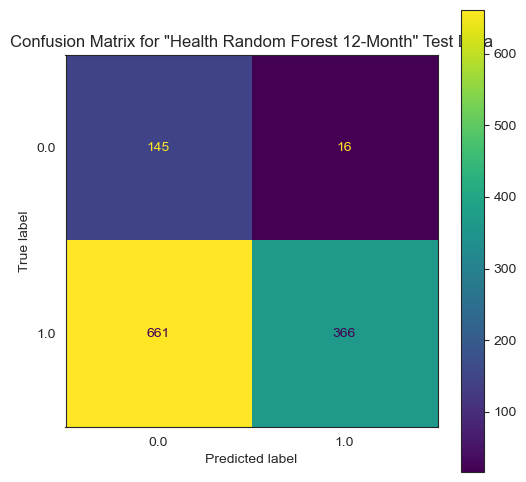

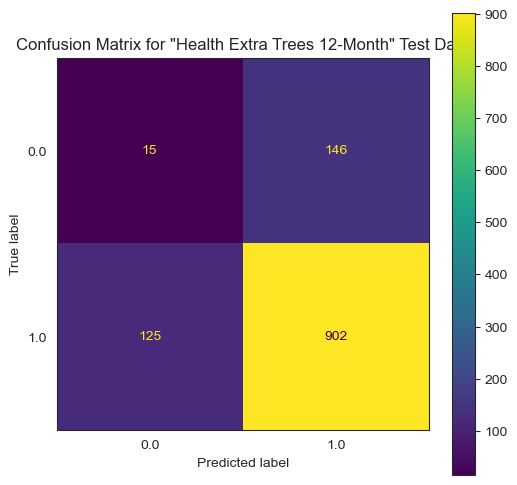

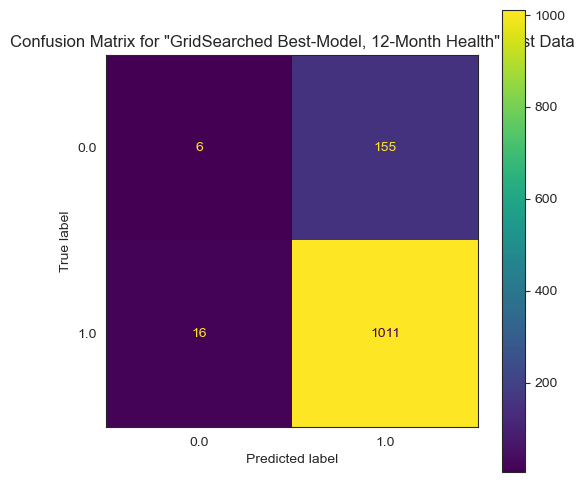

In [337]:
rfc_H_12.confusion_matrix(), etc_H_12.confusion_matrix(), grid_H_12.confusion_matrix();

In [338]:
# Top 5 feature importances for the best model

features_from_trees(rfc_H_12)
Importance.df[-4:]

Top 5 Feature Importances
('Interest_Rates', 0.1108992221652457)
('GDP_Filled', 0.10578706862241577)
('garman_klass_vol', 0.06415008201118956)
('High', 0.05224660521086144)
('Close', 0.04683864593299518)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
28   0.526424 -0.772243 -0.512589 -0.497993 -0.218742 -0.436955   -0.311096   
29   0.042129  0.042751  0.036917  0.038144  0.036087  0.014202    0.054705   
30   0.042974  0.058329  0.053673  0.045603  0.041312  0.021763    0.088814   
31   0.045736  0.046839  0.052247  0.038846  0.041206  0.031406    0.105787   

    Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
28       -0.132291 -0.106200 -0.042532  0.033452 -0.034622 -0.033876   
29        0.041522  0.006645  0.006267  0.007289  0.007636  0.007948   
30        0.070457  0.008912  0.008093  0.009602  0.007559  0.008627   
31        0.110899  0.006596  0.006417  0.007718  0.009094  0.007820   

    garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
28          0.722753 -0.061447              -0.120932              0.083105   
29          0.032664  0.018131               0.046053              0.043489   
30          0.045837  0.026224               0.032223              0.041828   
31          0.064150  0.018633               0.035893              0.036288   

    20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
28    0.282703               0.477845              0.668533 -0.296634   
29    0.044016               0.041235              0.042490  0.029334   
30    0.045933               0.041816              0.048143  0.048955   
31    0.037019               0.038851              0.043995  0.034791   

        MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
28 -0.300790          0.378944   0.046538  -0.038751  -0.371526   0.366364   
29  0.023032          0.013478   0.021212   0.016724   0.022712   0.021106   
30  0.030722          0.025858   0.007387   0.012070   0.007798   0.014042   
31  0.021023          0.031886   0.003906   0.006968   0.003816   0.005693   

     Month_1  Month_10  Month_11  Month_12   Month_2   Month_3   Month_4  \
28 -0.082617 -0.521616  0.385317  0.502664 -0.069641  0.198795  0.269596   
29  0.009787  0.006154  0.006892  0.009179  0.005994  0.009397  0.008179   
30  0.003147  0.001790  0.001572  0.004543  0.002856  0.004814  0.004123   
31  0.002333  0.000711  0.001324  0.002698  0.001756  0.001487  0.001085   

     Month_5   Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
28 -0.285188 -0.023159 -0.172566  0.137972 -0.336932      0.436496   
29  0.008886  0.011735  0.014198  0.008341  0.009901      0.031567   
30  0.002637  0.003035  0.003518  0.001367  0.002749      0.010316   
31  0.003300  0.003436  0.002155  0.001147  0.001220      0.005442   

    cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
28     -0.099941      0.073563     -0.407493            0.005109   
29      0.024407      0.032563      0.030621            0.003087   
30      0.008627      0.021293      0.024996            0.000959   
31      0.011309      0.035504      0.028091            0.000861   

    day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
28            0.045273             -0.039297             0.042773   
29            0.003027              0.002893             0.002544   
30            0.000763              0.000831             0.000901   
31            0.000622              0.000710             0.000537   

    day_of_week_Wednesday  
28              -0.051232  
29               0.002731  
30               0.000612  
31               0.000750

In [339]:
Importance.df.rename(index={28:"Health Care 1-Month", 29:"Health Care 3-Month", 30:"Health Care 6-Month", \
                            31:"Health Care 12-Month"}, inplace=True)

In [340]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

Adj Close     Close      High       Low      Open  \
Health Care 1-Month    0.526424 -0.772243 -0.512589 -0.497993 -0.218742   
Health Care 3-Month    0.042129  0.042751  0.036917  0.038144  0.036087   
Health Care 6-Month    0.042974  0.058329  0.053673  0.045603  0.041312   
Health Care 12-Month   0.045736  0.046839  0.052247  0.038846  0.041206   

                        Volume  GDP_Filled  Interest_Rates    Mkt-RF  \
Health Care 1-Month  -0.436955   -0.311096       -0.132291 -0.106200   
Health Care 3-Month   0.014202    0.054705        0.041522  0.006645   
Health Care 6-Month   0.021763    0.088814        0.070457  0.008912   
Health Care 12-Month  0.031406    0.105787        0.110899  0.006596   

                           SMB       HML       RMW       CMA  \
Health Care 1-Month  -0.042532  0.033452 -0.034622 -0.033876   
Health Care 3-Month   0.006267  0.007289  0.007636  0.007948   
Health Care 6-Month   0.008093  0.009602  0.007559  0.008627   
Health Care 12-Month  0.006417  0.007718  0.009094  0.007820   

                      garman_klass_vol       RSI  lowest_bollinger_band  \
Health Care 1-Month           0.722753 -0.061447              -0.120932   
Health Care 3-Month           0.032664  0.018131               0.046053   
Health Care 6-Month           0.045837  0.026224               0.032223   
Health Care 12-Month          0.064150  0.018633               0.035893   

                      lower_bollinger_band  20_day_SMA  one_up_bollinger_band  \
Health Care 1-Month               0.083105    0.282703               0.477845   
Health Care 3-Month               0.043489    0.044016               0.041235   
Health Care 6-Month               0.041828    0.045933               0.041816   
Health Care 12-Month              0.036288    0.037019               0.038851   

                      upper_bollinger_band       ATR      MACD  \
Health Care 1-Month               0.668533 -0.296634 -0.300790   
Health Care 3-Month               0.042490  0.029334  0.023032   
Health Care 6-Month               0.048143  0.048955  0.030722   
Health Care 12-Month              0.043995  0.034791  0.021023   

                      dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Health Care 1-Month           0.378944   0.046538  -0.038751  -0.371526   
Health Care 3-Month           0.013478   0.021212   0.016724   0.022712   
Health Care 6-Month           0.025858   0.007387   0.012070   0.007798   
Health Care 12-Month          0.031886   0.003906   0.006968   0.003816   

                      Quarter_4   Month_1  Month_10  Month_11  Month_12  \
Health Care 1-Month    0.366364 -0.082617 -0.521616  0.385317  0.502664   
Health Care 3-Month    0.021106  0.009787  0.006154  0.006892  0.009179   
Health Care 6-Month    0.014042  0.003147  0.001790  0.001572  0.004543   
Health Care 12-Month   0.005693  0.002333  0.000711  0.001324  0.002698   

                       Month_2   Month_3   Month_4   Month_5   Month_6  \
Health Care 1-Month  -0.069641  0.198795  0.269596 -0.285188 -0.023159   
Health Care 3-Month   0.005994  0.009397  0.008179  0.008886  0.011735   
Health Care 6-Month   0.002856  0.004814  0.004123  0.002637  0.003035   
Health Care 12-Month  0.001756  0.001487  0.001085  0.003300  0.003436   

                       Month_7   Month_8   Month_9  cycle_year_1  \
Health Care 1-Month  -0.172566  0.137972 -0.336932      0.436496   
Health Care 3-Month   0.014198  0.008341  0.009901      0.031567   
Health Care 6-Month   0.003518  0.001367  0.002749      0.010316   
Health Care 12-Month  0.002155  0.001147  0.001220      0.005442   

                      cycle_year_2  cycle_year_3  cycle_year_4  \
Health Care 1-Month      -0.099941      0.073563     -0.407493   
Health Care 3-Month       0.024407      0.032563      0.030621   
Health Care 6-Month       0.008627      0.021293      0.024996   
Health Care 12-Month      0.011309      0.035504      0.028091   

                      day_of_week_Friday  day_of_week_Mo

<hr style="border: 4px solid darkred">

# Consumer Discretionary - XLY

### 1 Month

In [345]:
# Create variables

X_train, X_test, y_train, y_test = select_data(consumer_df, "One")


# Create Model Objects
                            
# dummy_CD_1 = dummy_model(Consumer, "Consumer", 1)
# logreg_CD_1 = l_regr(Consumer, "Consumer", 1)
# rfc_CD_1 = r_forest(Consumer, "Consumer", 1)
# etc_CD_1 = extra_trees(Consumer, "Consumer", 1)
# XGBoost_CD_1 = x_g_b(Consumer, "Consumer", 1)

# grid_CD_1 = best_etc_grid(estimator=etc_CD_1.model, model_type=Consumer, \
#                             sector_name="Consumer", time_period=1)

Consumer.model_df.sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
2             Consumer Random Forest 1-Month        0.453350    0.661459   
3               Consumer Extra Trees 1-Month        0.484450    0.681339   
5  GridSearched Best-Model, 1-Month Consumer        0.486726    0.705015   
4                   Consumer XGBoost 1-Month        0.473072    0.656925   
1       Consumer Logistic Regression 1-Month        0.523388    0.653651   
0                     Dummy Consumer 1-Month        0.636662    0.636662   

   train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
2      0.323308  0.396286       1.020031       0.388889   0.909091   
3      0.380093  0.441904       0.885031       0.440236   0.659091   
5      0.389199  0.449709       0.911369       0.468013   0.645070   
4      0.364518  0.422505       2.473874       0.435185   0.637931   
1      0.540632  0.551123       1.679550       0.487374   0.626000   
0      1.000000  0.775943      13.096013       0.618687   0.618687   

   test_recall   test_f1  test_logloss       AUC  
2     0.013605  0.026810      1.034222  0.560923  
3     0.197279  0.303665      0.848707  0.578608  
5     0.311565  0.420183      0.783279  0.548224  
4     0.201361  0.306101      1.743126  0.505275  
1     0.425850  0.506883      1.155620  0.511514  
0     1.000000  0.764431     13.743918  0.500000

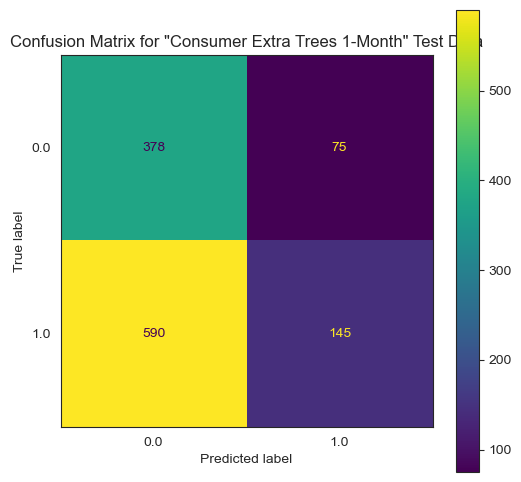

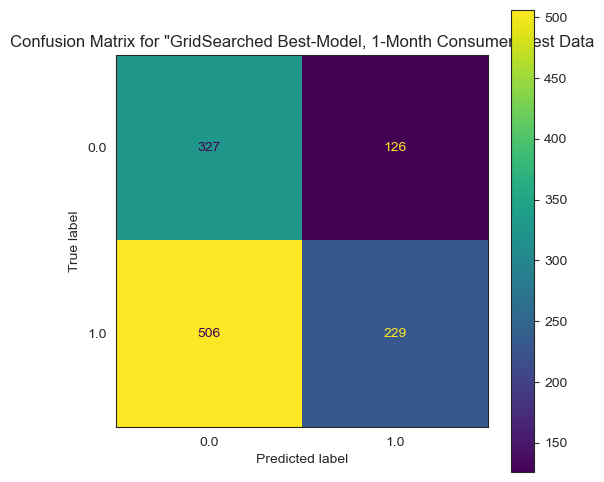

In [346]:
etc_CD_1.confusion_matrix(), grid_CD_1.confusion_matrix();

In [347]:
# Feature importance for the best model

features_from_trees(grid_CD_1)
Importance.df[-4:]

Top 5 Feature Importances
('MACD', 0.045287636477644735)
('one_up_bollinger_band', 0.04467472803744867)
('lower_bollinger_band', 0.043708292238836516)
('upper_bollinger_band', 0.04365389315126115)
('20_day_SMA', 0.04318862920177352)


Adj Close     Close      High       Low      Open  \
Health Care 3-Month    0.042129  0.042751  0.036917  0.038144  0.036087   
Health Care 6-Month    0.042974  0.058329  0.053673  0.045603  0.041312   
Health Care 12-Month   0.045736  0.046839  0.052247  0.038846  0.041206   
32                     0.041610  0.041910  0.038958  0.039996  0.036512   

                        Volume  GDP_Filled  Interest_Rates    Mkt-RF  \
Health Care 3-Month   0.014202    0.054705        0.041522  0.006645   
Health Care 6-Month   0.021763    0.088814        0.070457  0.008912   
Health Care 12-Month  0.031406    0.105787        0.110899  0.006596   
32                    0.021032    0.030493        0.042150  0.013379   

                           SMB       HML       RMW       CMA  \
Health Care 3-Month   0.006267  0.007289  0.007636  0.007948   
Health Care 6-Month   0.008093  0.009602  0.007559  0.008627   
Health Care 12-Month  0.006417  0.007718  0.009094  0.007820   
32                    0.013838  0.014103  0.014793  0.014325   

                      garman_klass_vol       RSI  lowest_bollinger_band  \
Health Care 3-Month           0.032664  0.018131               0.046053   
Health Care 6-Month           0.045837  0.026224               0.032223   
Health Care 12-Month          0.064150  0.018633               0.035893   
32                            0.023712  0.033578               0.041879   

                      lower_bollinger_band  20_day_SMA  one_up_bollinger_band  \
Health Care 3-Month               0.043489    0.044016               0.041235   
Health Care 6-Month               0.041828    0.045933               0.041816   
Health Care 12-Month              0.036288    0.037019               0.038851   
32                                0.043708    0.043189               0.044675   

                      upper_bollinger_band       ATR      MACD  \
Health Care 3-Month               0.042490  0.029334  0.023032   
Health Care 6-Month               0.048143  0.048955  0.030722   
Health Care 12-Month              0.043995  0.034791  0.021023   
32                                0.043654  0.041319  0.045288   

                      dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Health Care 3-Month           0.013478   0.021212   0.016724   0.022712   
Health Care 6-Month           0.025858   0.007387   0.012070   0.007798   
Health Care 12-Month          0.031886   0.003906   0.006968   0.003816   
32                            0.020025   0.008239   0.013192   0.011311   

                      Quarter_4   Month_1  Month_10  Month_11  Month_12  \
Health Care 3-Month    0.021106  0.009787  0.006154  0.006892  0.009179   
Health Care 6-Month    0.014042  0.003147  0.001790  0.001572  0.004543   
Health Care 12-Month   0.005693  0.002333  0.000711  0.001324  0.002698   
32                     0.012226  0.009025  0.011741  0.007920  0.007738   

                       Month_2   Month_3   Month_4   Month_5   Month_6  \
Health Care 3-Month   0.005994  0.009397  0.008179  0.008886  0.011735   
Health Care 6-Month   0.002856  0.004814  0.004123  0.002637  0.003035   
Health Care 12-Month  0.001756  0.001487  0.001085  0.003300  0.003436   
32                    0.008671  0.010970  0.009259  0.008873  0.010744   

                       Month_7   Month_8   Month_9  cycle_year_1  \
Health Care 3-Month   0.014198  0.008341  0.009901      0.031567   
Health Care 6-Month   0.003518  0.001367  0.002749      0.010316   
Health Care 12-Month  0.002155  0.001147  0.001220      0.005442   
32                    0.009723  0.008876  0.009495      0.017350   

                      cycle_year_2  cycle_year_3  cycle_year_4  \
Health Care 3-Month       0.024407      0.032563      0.030621   
Health Care 6-Month       0.008627      0.021293      0.024996   
Health Care 12-Month      0.011309      0.035504      0.028091   
32                        0.018145      0.015942      0.013337   

                      day_of_week_Friday  day_of_week_Mo

<hr style="border: 2px solid darkgreen">

# XLY 3 Month 

In [352]:
# Create variables

X_train, X_test, y_train, y_test = select_data(consumer_df, "Three")


# Create Model Objects
                            
# dummy_CD_3 = dummy_model(Consumer, "Consumer", 3)
# logreg_CD_3 = l_regr(Consumer, "Consumer", 3)
# rfc_CD_3 = r_forest(Consumer, "Consumer", 3)
# etc_CD_3 = extra_trees(Consumer, "Consumer", 3)
# XGBoost_CD_3 = x_g_b(Consumer, "Consumer", 3)

# grid_CD_3 = best_etc_grid(estimator=etc_CD_3.model, model_type=Consumer, \
#                             sector_name="Consumer", time_period=3)

Consumer.model_df.iloc[6:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
8              Consumer Random Forest 3-Month        0.564602    0.792703   
11  GridSearched Best-Model, 3-Month Consumer        0.580784    0.786494   
9                Consumer Extra Trees 3-Month        0.559039    0.762418   
10                   Consumer XGBoost 3-Month        0.550948    0.790269   
6                      Dummy Consumer 3-Month        0.677370    0.677370   
7        Consumer Logistic Regression 3-Month        0.525664    0.734548   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
8       0.534682  0.569540       0.979981       0.349327   1.000000   
11      0.511174  0.568732       0.877708       0.507576   0.823899   
9       0.476567  0.540431       0.882256       0.485690   0.796053   
10      0.511902  0.558589       2.327797       0.504209   0.723451   
6       1.000000  0.798414      11.628749       0.665825   0.665825   
7       0.474021  0.500222       2.003709       0.429293   0.615071   

    test_recall   test_f1  test_logloss       AUC  
8      0.022756  0.044499      1.307216  0.587134  
11     0.331226  0.472498      0.769674  0.632460  
9      0.305942  0.442009      0.801115  0.627140  
10     0.413401  0.526146      1.463795  0.575622  
6      1.000000  0.799394     12.044891  0.500000  
7      0.381795  0.471139      1.640919  0.441331

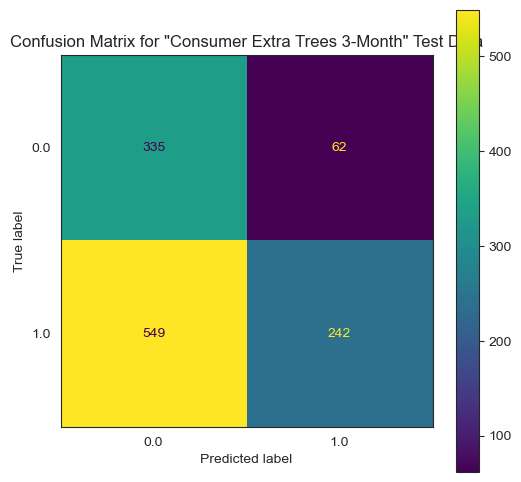

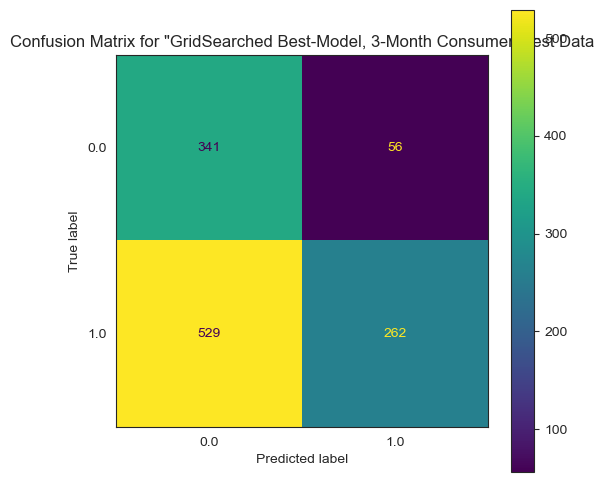

In [353]:
etc_CD_3.confusion_matrix(), grid_CD_3.confusion_matrix();

In [354]:
# Feature importances of the best model

features_from_trees(grid_CD_3)
Importance.df[-4:]

Top 5 Feature Importances
('Interest_Rates', 0.06033881521023621)
('GDP_Filled', 0.0506885713759742)
('one_up_bollinger_band', 0.04186945299382936)
('lowest_bollinger_band', 0.04096577066542577)
('20_day_SMA', 0.04074306999329072)


Adj Close     Close      High       Low      Open  \
Health Care 6-Month    0.042974  0.058329  0.053673  0.045603  0.041312   
Health Care 12-Month   0.045736  0.046839  0.052247  0.038846  0.041206   
32                     0.041610  0.041910  0.038958  0.039996  0.036512   
33                     0.037955  0.037715  0.037415  0.034104  0.033950   

                        Volume  GDP_Filled  Interest_Rates    Mkt-RF  \
Health Care 6-Month   0.021763    0.088814        0.070457  0.008912   
Health Care 12-Month  0.031406    0.105787        0.110899  0.006596   
32                    0.021032    0.030493        0.042150  0.013379   
33                    0.015773    0.050689        0.060339  0.009102   

                           SMB       HML       RMW       CMA  \
Health Care 6-Month   0.008093  0.009602  0.007559  0.008627   
Health Care 12-Month  0.006417  0.007718  0.009094  0.007820   
32                    0.013838  0.014103  0.014793  0.014325   
33                    0.008607  0.008615  0.008586  0.009540   

                      garman_klass_vol       RSI  lowest_bollinger_band  \
Health Care 6-Month           0.045837  0.026224               0.032223   
Health Care 12-Month          0.064150  0.018633               0.035893   
32                            0.023712  0.033578               0.041879   
33                            0.024765  0.025429               0.040966   

                      lower_bollinger_band  20_day_SMA  one_up_bollinger_band  \
Health Care 6-Month               0.041828    0.045933               0.041816   
Health Care 12-Month              0.036288    0.037019               0.038851   
32                                0.043708    0.043189               0.044675   
33                                0.040386    0.040743               0.041869   

                      upper_bollinger_band       ATR      MACD  \
Health Care 6-Month               0.048143  0.048955  0.030722   
Health Care 12-Month              0.043995  0.034791  0.021023   
32                                0.043654  0.041319  0.045288   
33                                0.039135  0.038224  0.030878   

                      dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Health Care 6-Month           0.025858   0.007387   0.012070   0.007798   
Health Care 12-Month          0.031886   0.003906   0.006968   0.003816   
32                            0.020025   0.008239   0.013192   0.011311   
33                            0.014776   0.016546   0.024591   0.014692   

                      Quarter_4   Month_1  Month_10  Month_11  Month_12  \
Health Care 6-Month    0.014042  0.003147  0.001790  0.001572  0.004543   
Health Care 12-Month   0.005693  0.002333  0.000711  0.001324  0.002698   
32                     0.012226  0.009025  0.011741  0.007920  0.007738   
33                     0.016526  0.010446  0.008100  0.005153  0.006884   

                       Month_2   Month_3   Month_4   Month_5   Month_6  \
Health Care 6-Month   0.002856  0.004814  0.004123  0.002637  0.003035   
Health Care 12-Month  0.001756  0.001487  0.001085  0.003300  0.003436   
32                    0.008671  0.010970  0.009259  0.008873  0.010744   
33                    0.006757  0.012617  0.014237  0.012969  0.012422   

                       Month_7   Month_8   Month_9  cycle_year_1  \
Health Care 6-Month   0.003518  0.001367  0.002749      0.010316   
Health Care 12-Month  0.002155  0.001147  0.001220      0.005442   
32                    0.009723  0.008876  0.009495      0.017350   
33                    0.014764  0.006812  0.007627      0.031862   

                      cycle_year_2  cycle_year_3  cycle_year_4  \
Health Care 6-Month       0.008627      0.021293      0.024996   
Health Care 12-Month      0.011309      0.035504      0.028091   
32                        0.018145      0.015942      0.013337   
33                        0.020639      0.025025      0.020928   

                      day_of_week_Friday  day_of_week_Mo

<hr style="border: 2px solid darkgreen">

# XLY 6 Month

In [359]:
# Create variables

X_train, X_test, y_train, y_test = select_data(consumer_df, "Six")


# Create Model Objects
                            
# dummy_CD_6 = dummy_model(Consumer, "Consumer", 6)
# logreg_CD_6 = l_regr(Consumer, "Consumer", 6)
# rfc_CD_6 = r_forest(Consumer, "Consumer", 6)
# etc_CD_6 = extra_trees(Consumer, "Consumer", 6)
# XGBoost_CD_6 = x_g_b(Consumer, "Consumer", 6)

# grid_CD_6 = best_etc_grid(estimator=etc_CD_6.model, model_type=Consumer, \
#                             sector_name="Consumer", time_period=6)
# grid_CD_6 = best_logreg_search(logreg_CD_6.model, Consumer, "Consumer", 6)

Consumer.model_df.iloc[12:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
13  Consumer Logistic Regression 6-Month        0.456131    0.766514   
12                Dummy Consumer 6-Month        0.687737    0.616435   
14        Consumer Random Forest 6-Month        0.639191    0.816626   
15          Consumer Extra Trees 6-Month        0.581290    0.762287   
17    Grid Searched LR, 6-Month Consumer        0.469027    0.776793   
16              Consumer XGBoost 6-Month        0.638938    0.827417   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
13      0.404739  0.441664       3.194378       0.626263   0.653195   
12      0.800000  0.680455      11.255098       0.648148   0.648148   
14      0.546669  0.627148       0.829433       0.648148   0.648148   
15      0.517881  0.594418       0.815530       0.648148   0.648148   
17      0.422054  0.463730       2.642305       0.586700   0.646688   
16      0.539269  0.627918       1.879111       0.590909   0.632959   

    test_recall   test_f1  test_logloss       AUC  
13     0.902597  0.757906      1.809597  0.361785  
12     1.000000  0.786517     12.682026  0.500000  
14     1.000000  0.786517      0.989911  0.414368  
15     1.000000  0.786517      1.170199  0.402866  
17     0.798701  0.714701      1.237743  0.385040  
16     0.877922  0.735582      1.522062  0.426499

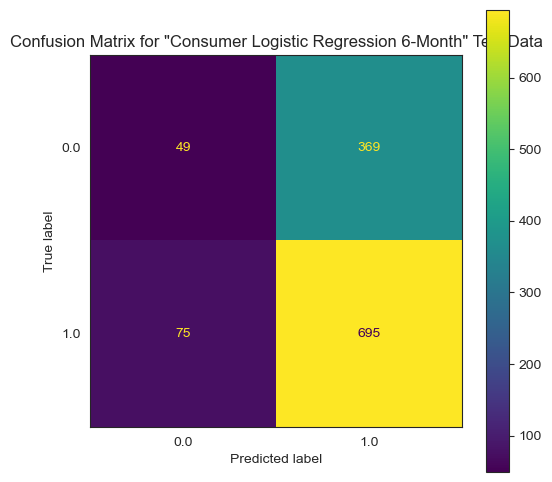

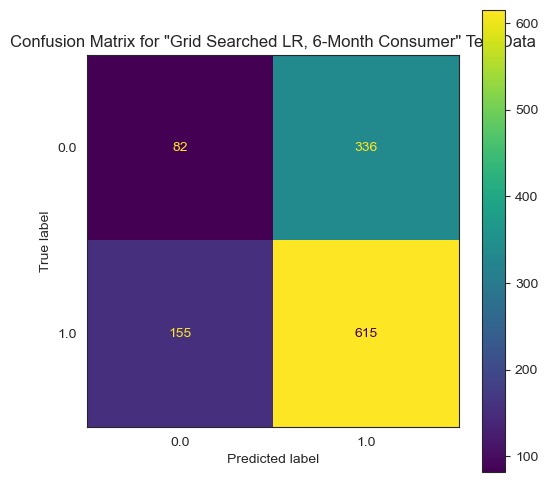

In [360]:
logreg_CD_6.confusion_matrix(), grid_CD_6.confusion_matrix();

In [361]:
# Top 5 important features from the best model

coefs_from_lr(logreg_CD_6)
Importance.df[-4:]

Top 5 Feature Coefficients
('Adj Close', 5.330166064962693)
('upper_bollinger_band', 3.879903674865043)
('one_up_bollinger_band', 2.8148119387135573)
('20_day_SMA', 1.7326431589231204)
('garman_klass_vol', 1.1798304737051115)


Adj Close     Close      High       Low      Open  \
Health Care 12-Month   0.045736  0.046839  0.052247  0.038846  0.041206   
32                     0.041610  0.041910  0.038958  0.039996  0.036512   
33                     0.037955  0.037715  0.037415  0.034104  0.033950   
34                     5.330166 -4.546046 -3.979245 -2.953315 -2.395406   

                        Volume  GDP_Filled  Interest_Rates    Mkt-RF  \
Health Care 12-Month  0.031406    0.105787        0.110899  0.006596   
32                    0.021032    0.030493        0.042150  0.013379   
33                    0.015773    0.050689        0.060339  0.009102   
34                   -0.873307   -0.668654       -0.226101 -0.196922   

                           SMB       HML       RMW       CMA  \
Health Care 12-Month  0.006417  0.007718  0.009094  0.007820   
32                    0.013838  0.014103  0.014793  0.014325   
33                    0.008607  0.008615  0.008586  0.009540   
34                   -0.011164  0.031269 -0.031912 -0.010758   

                      garman_klass_vol       RSI  lowest_bollinger_band  \
Health Care 12-Month          0.064150  0.018633               0.035893   
32                            0.023712  0.033578               0.041879   
33                            0.024765  0.025429               0.040966   
34                            1.179830  0.148442              -0.480917   

                      lower_bollinger_band  20_day_SMA  one_up_bollinger_band  \
Health Care 12-Month              0.036288    0.037019               0.038851   
32                                0.043708    0.043189               0.044675   
33                                0.040386    0.040743               0.041869   
34                                0.633882    1.732643               2.814812   

                      upper_bollinger_band       ATR      MACD  \
Health Care 12-Month              0.043995  0.034791  0.021023   
32                                0.043654  0.041319  0.045288   
33                                0.039135  0.038224  0.030878   
34                                3.879904 -0.606649  0.025268   

                      dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Health Care 12-Month          0.031886   0.003906   0.006968   0.003816   
32                            0.020025   0.008239   0.013192   0.011311   
33                            0.014776   0.016546   0.024591   0.014692   
34                            1.164251  -0.449232  -0.246839   0.190866   

                      Quarter_4   Month_1  Month_10  Month_11  Month_12  \
Health Care 12-Month   0.005693  0.002333  0.000711  0.001324  0.002698   
32                     0.012226  0.009025  0.011741  0.007920  0.007738   
33                     0.016526  0.010446  0.008100  0.005153  0.006884   
34                     0.711261 -0.034966  0.947482  0.183803 -0.420024   

                       Month_2   Month_3   Month_4   Month_5   Month_6  \
Health Care 12-Month  0.001756  0.001487  0.001085  0.003300  0.003436   
32                    0.008671  0.010970  0.009259  0.008873  0.010744   
33                    0.006757  0.012617  0.014237  0.012969  0.012422   
34                   -0.061401 -0.352865 -0.719251 -0.065152  0.537563   

                       Month_7   Month_8   Month_9  cycle_year_1  \
Health Care 12-Month  0.002155  0.001147  0.001220      0.005442   
32                    0.009723  0.008876  0.009495      0.017350   
33                    0.014764  0.006812  0.007627      0.031862   
34                   -0.321097  0.036277  0.475687      0.742573   

                      cycle_year_2  cycle_year_3  cycle_year_4  \
Health Care 12-Month      0.011309      0.035504      0.028091   
32                        0.018145      0.015942      0.013337   
33                        0.020639      0.025025      0.020928   
34                        0.266251     -0.554743     -0.248025   

                      day_of_week_Friday  day_of_week_Mo

<hr style="border: 2px solid darkgreen">

# XLY 12 Month

In [367]:
# Create variables

X_train, X_test, y_train, y_test = select_data(consumer_df, "Twelve")


# Create Model Objects
                            
# dummy_CD_12 = dummy_model(Consumer, "Consumer", 12)
# logreg_CD_12 = l_regr(Consumer, "Consumer", 12)
# rfc_CD_12 = r_forest(Consumer, "Consumer", 12)
# etc_CD_12 = extra_trees(Consumer, "Consumer", 12)
# XGBoost_CD_12 = x_g_b(Consumer, "Consumer", 12)

# grid_CD_12 = best_etc_grid(estimator=rfc_CD_12.model, model_type=Consumer, \
#                             sector_name="Consumer", time_period=12)

Consumer.model_df.iloc[18:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
20             Consumer Random Forest 12-Month        0.613148    0.904434   
23  GridSearched Best-Model, 12-Month Consumer        0.613148    0.904434   
21               Consumer Extra Trees 12-Month        0.656637    0.883574   
18                     Dummy Consumer 12-Month        0.693300    0.653856   
19       Consumer Logistic Regression 12-Month        0.476359    0.863515   
22                   Consumer XGBoost 12-Month        0.538053    0.881781   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
20      0.587018  0.595741            NaN       0.622896   0.748252   
23      0.587018  0.595741            NaN       0.622896   0.748252   
21      0.605845  0.654974            NaN       0.737374   0.736931   
18      0.800000  0.698013            NaN       0.735690   0.735690   
19      0.546607  0.561632            NaN       0.578283   0.699465   
22      0.560941  0.584587            NaN       0.367003   0.595611   

    test_recall   test_f1  test_logloss       AUC  
20     0.734554  0.741339      0.626359  0.546036  
23     0.734554  0.741339      0.626359  0.546036  
21     1.000000  0.848544      0.600953  0.433376  
18     1.000000  0.847721      9.526690  0.500000  
19     0.748284  0.723051      3.054219  0.329705  
22     0.434783  0.502646      2.248640  0.244684

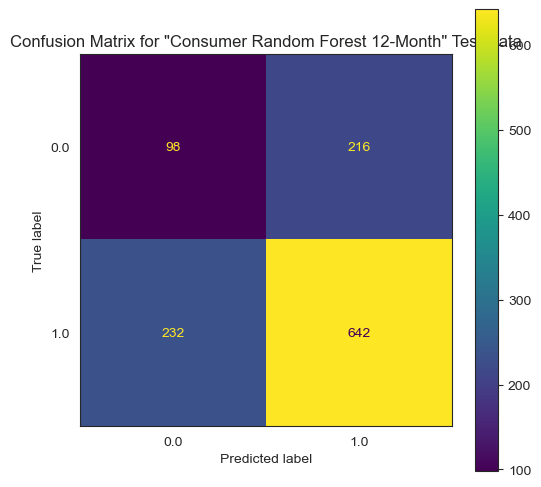

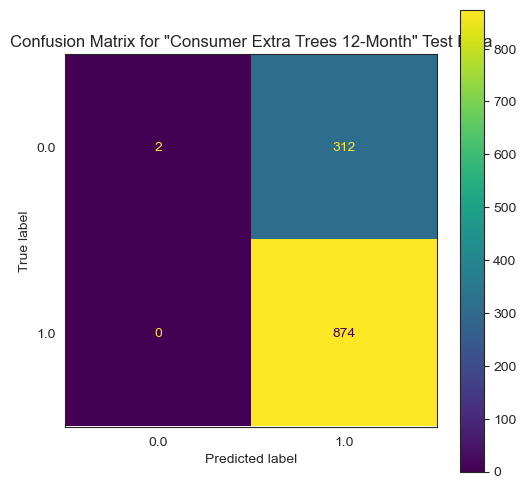

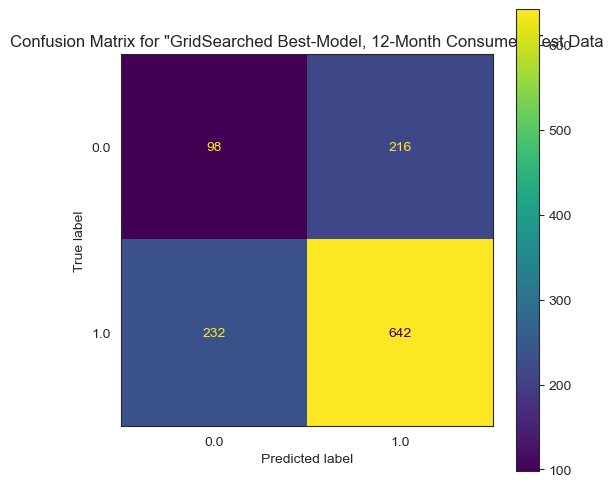

In [368]:
rfc_CD_12.confusion_matrix(), etc_CD_12.confusion_matrix(), grid_CD_12.confusion_matrix();

In [369]:
# Top 5 feature importances for the best model

features_from_trees(rfc_CD_12)
Importance.df[-4:]

Top 5 Feature Importances
('Interest_Rates', 0.14726875751094318)
('GDP_Filled', 0.09536860255940027)
('upper_bollinger_band', 0.06413775327765381)
('garman_klass_vol', 0.05430631528200796)
('Close', 0.050646292205582144)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
32   0.041610  0.041910  0.038958  0.039996  0.036512  0.021032    0.030493   
33   0.037955  0.037715  0.037415  0.034104  0.033950  0.015773    0.050689   
34   5.330166 -4.546046 -3.979245 -2.953315 -2.395406 -0.873307   -0.668654   
35   0.042148  0.050646  0.039939  0.041573  0.045065  0.027356    0.095369   

    Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
32        0.042150  0.013379  0.013838  0.014103  0.014793  0.014325   
33        0.060339  0.009102  0.008607  0.008615  0.008586  0.009540   
34       -0.226101 -0.196922 -0.011164  0.031269 -0.031912 -0.010758   
35        0.147269  0.004318  0.004752  0.005769  0.005347  0.005192   

    garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
32          0.023712  0.033578               0.041879              0.043708   
33          0.024765  0.025429               0.040966              0.040386   
34          1.179830  0.148442              -0.480917              0.633882   
35          0.054306  0.016009               0.034508              0.046655   

    20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
32    0.043189               0.044675              0.043654  0.041319   
33    0.040743               0.041869              0.039135  0.038224   
34    1.732643               2.814812              3.879904 -0.606649   
35    0.049361               0.036578              0.064138  0.047101   

        MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
32  0.045288          0.020025   0.008239   0.013192   0.011311   0.012226   
33  0.030878          0.014776   0.016546   0.024591   0.014692   0.016526   
34  0.025268          1.164251  -0.449232  -0.246839   0.190866   0.711261   
35  0.019700          0.025489   0.002427   0.004314   0.003393   0.007053   

     Month_1  Month_10  Month_11  Month_12   Month_2   Month_3   Month_4  \
32  0.009025  0.011741  0.007920  0.007738  0.008671  0.010970  0.009259   
33  0.010446  0.008100  0.005153  0.006884  0.006757  0.012617  0.014237   
34 -0.034966  0.947482  0.183803 -0.420024 -0.061401 -0.352865 -0.719251   
35  0.001011  0.003518  0.001666  0.001761  0.002494  0.000916  0.001773   

     Month_5   Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
32  0.008873  0.010744  0.009723  0.008876  0.009495      0.017350   
33  0.012969  0.012422  0.014764  0.006812  0.007627      0.031862   
34 -0.065152  0.537563 -0.321097  0.036277  0.475687      0.742573   
35  0.001768  0.001084  0.001449  0.001173  0.004894      0.008723   

    cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
32      0.018145      0.015942      0.013337            0.006159   
33      0.020639      0.025025      0.020928            0.004328   
34      0.266251     -0.554743     -0.248025            0.067489   
35      0.016270      0.013157      0.009846            0.000644   

    day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
32            0.007259              0.005944             0.007140   
33            0.004431              0.004595             0.003830   
34            0.059155              0.063194            -0.000005   
35            0.000561              0.000538             0.000500   

    day_of_week_Wednesday  
32               0.006596  
33               0.003658  
34               0.016222  
35               0.000478

In [370]:
Importance.df.rename(index={32:"Consumer Discretionary 1-Month", 33:"Consumer Discretionary 3-Month", 34:"Consumer Discretionary 6-Month", \
                            35:"Consumer Discretionary 12-Month"}, inplace=True)

In [371]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

Adj Close     Close      High       Low  \
Consumer Discretionary 1-Month    0.041610  0.041910  0.038958  0.039996   
Consumer Discretionary 3-Month    0.037955  0.037715  0.037415  0.034104   
Consumer Discretionary 6-Month    5.330166 -4.546046 -3.979245 -2.953315   
Consumer Discretionary 12-Month   0.042148  0.050646  0.039939  0.041573   

                                     Open    Volume  GDP_Filled  \
Consumer Discretionary 1-Month   0.036512  0.021032    0.030493   
Consumer Discretionary 3-Month   0.033950  0.015773    0.050689   
Consumer Discretionary 6-Month  -2.395406 -0.873307   -0.668654   
Consumer Discretionary 12-Month  0.045065  0.027356    0.095369   

                                 Interest_Rates    Mkt-RF       SMB       HML  \
Consumer Discretionary 1-Month         0.042150  0.013379  0.013838  0.014103   
Consumer Discretionary 3-Month         0.060339  0.009102  0.008607  0.008615   
Consumer Discretionary 6-Month        -0.226101 -0.196922 -0.011164  0.031269   
Consumer Discretionary 12-Month        0.147269  0.004318  0.004752  0.005769   

                                      RMW       CMA  garman_klass_vol  \
Consumer Discretionary 1-Month   0.014793  0.014325          0.023712   
Consumer Discretionary 3-Month   0.008586  0.009540          0.024765   
Consumer Discretionary 6-Month  -0.031912 -0.010758          1.179830   
Consumer Discretionary 12-Month  0.005347  0.005192          0.054306   

                                      RSI  lowest_bollinger_band  \
Consumer Discretionary 1-Month   0.033578               0.041879   
Consumer Discretionary 3-Month   0.025429               0.040966   
Consumer Discretionary 6-Month   0.148442              -0.480917   
Consumer Discretionary 12-Month  0.016009               0.034508   

                                 lower_bollinger_band  20_day_SMA  \
Consumer Discretionary 1-Month               0.043708    0.043189   
Consumer Discretionary 3-Month               0.040386    0.040743   
Consumer Discretionary 6-Month               0.633882    1.732643   
Consumer Discretionary 12-Month              0.046655    0.049361   

                                 one_up_bollinger_band  upper_bollinger_band  \
Consumer Discretionary 1-Month                0.044675              0.043654   
Consumer Discretionary 3-Month                0.041869              0.039135   
Consumer Discretionary 6-Month                2.814812              3.879904   
Consumer Discretionary 12-Month               0.036578              0.064138   

                                      ATR      MACD  dollar_volume(M)  \
Consumer Discretionary 1-Month   0.041319  0.045288          0.020025   
Consumer Discretionary 3-Month   0.038224  0.030878          0.014776   
Consumer Discretionary 6-Month  -0.606649  0.025268          1.164251   
Consumer Discretionary 12-Month  0.047101  0.019700          0.025489   

                                 Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
Consumer Discretionary 1-Month    0.008239   0.013192   0.011311   0.012226   
Consumer Discretionary 3-Month    0.016546   0.024591   0.014692   0.016526   
Consumer Discretionary 6-Month   -0.449232  -0.246839   0.190866   0.711261   
Consumer Discretionary 12-Month   0.002427   0.004314   0.003393   0.007053   

                                  Month_1  Month_10  Month_11  Month_12  \
Consumer Discretionary 1-Month   0.009025  0.011741  0.007920  0.007738   
Consumer Discretionary 3-Month   0.010446  0.008100  0.005153  0.006884   
Consumer Discretionary 6-Month  -0.034966  0.947482  0.183803 -0.420024   
Consumer Discretionary 12-Month  0.001011  0.003518  0.001666  0.001761   

                                  Month_2   Month_3   Month_4   Month_5  \
Consumer Discretionary 1-Month   0.008671  0.010970  0.009259  0.008873   
Consumer Discretionary 3-Month   0.006757  0.012617  0.014237  0.012969   
Consumer Discretionary 6-Month  -0.061401 -0.352865 -0.719251 -0.065152   
Consumer Discretio

<hr style="border: 4px solid darkred">

# Real Estate - XLRE

### 1 Month

In [376]:
# Create variables

X_train, X_test, y_train, y_test = select_data(real_df, "One")


# Create Model Objects
                            
# dummy_RE_1 = dummy_model(Real_Estate, "Real_Estate", 1)
# logreg_RE_1 = l_regr(Real_Estate, "Real_Estate", 1)
# rfc_RE_1 = r_forest(Real_Estate, "Real_Estate", 1)
# etc_RE_1 = extra_trees(Real_Estate, "Real_Estate", 1)
# XGBoost_RE_1 = x_g_b(Real_Estate, "Real_Estate", 1)

# grid_RE_1 = best_etc_grid(estimator=etc_RE_1.model, model_type=Real_Estate, \
#                             sector_name="Real_Estate", time_period=1)
# grid_RE_1 = best_XGB_grid(XGBoost_RE_1.model, Real_Estate, "Real Estate", 1)

Real_Estate.model_df.sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
4                 Real_Estate XGBoost 1-Month        0.505172    0.670998   
1     Real_Estate Logistic Regression 1-Month        0.585345    0.733793   
5  Grid Searched XGBoost, 1-Month Real Estate        0.549138    0.842132   
0                   Dummy Real_Estate 1-Month        0.652586    0.652586   
2           Real_Estate Random Forest 1-Month        0.500862    0.661925   
3             Real_Estate Extra Trees 1-Month        0.491379    0.672495   

   train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
4      0.503405  0.558020       1.691689       0.621777   0.619048   
1      0.589295  0.583283       1.809050       0.581662   0.582569   
5      0.464999  0.472996       3.346059       0.570201   0.577670   
0      1.000000  0.789079      12.522062       0.521490   0.521490   
2      0.489533  0.520656       0.811910       0.518625   0.520115   
3      0.459328  0.501258       0.816064       0.518625   0.520115   

   test_recall   test_f1  test_logloss       AUC  
4     0.714286  0.663265      0.939186  0.664802  
1     0.697802  0.635000      1.518962  0.601829  
5     0.653846  0.613402      1.766349  0.610285  
0     1.000000  0.685499     17.247250  0.500000  
2     0.994505  0.683019      0.752472  0.565473  
3     0.994505  0.683019      0.815848  0.462756

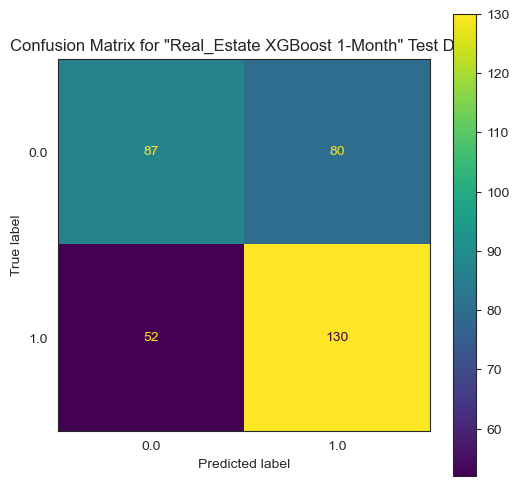

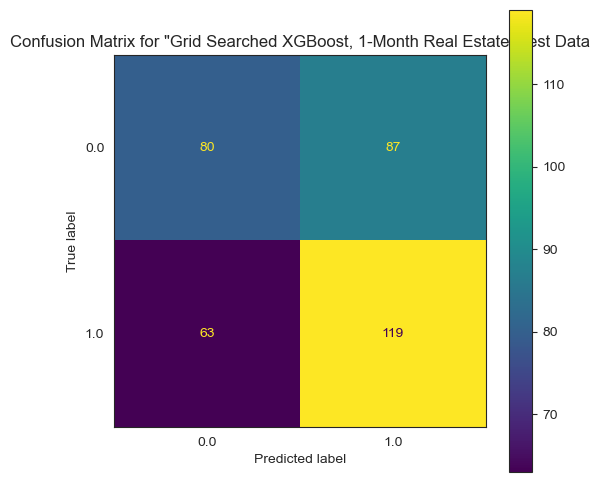

In [377]:
XGBoost_RE_1.confusion_matrix(), grid_RE_1.confusion_matrix();

In [378]:
# Feature importance for the best model

features_from_trees(XGBoost_RE_1)
Importance.df[-4:]

Top 5 Feature Importances
('Month_5', 0.1776062)
('cycle_year_4', 0.1342224)
('cycle_year_1', 0.067844465)
('Open', 0.055964313)
('GDP_Filled', 0.050639413)


Adj Close     Close      High       Low  \
Consumer Discretionary 3-Month    0.037955  0.037715  0.037415  0.034104   
Consumer Discretionary 6-Month    5.330166 -4.546046 -3.979245 -2.953315   
Consumer Discretionary 12-Month   0.042148  0.050646  0.039939  0.041573   
36                                0.011480  0.044854  0.018834  0.011954   

                                     Open    Volume  GDP_Filled  \
Consumer Discretionary 3-Month   0.033950  0.015773    0.050689   
Consumer Discretionary 6-Month  -2.395406 -0.873307   -0.668654   
Consumer Discretionary 12-Month  0.045065  0.027356    0.095369   
36                               0.055964  0.007790    0.050639   

                                 Interest_Rates    Mkt-RF       SMB       HML  \
Consumer Discretionary 3-Month         0.060339  0.009102  0.008607  0.008615   
Consumer Discretionary 6-Month        -0.226101 -0.196922 -0.011164  0.031269   
Consumer Discretionary 12-Month        0.147269  0.004318  0.004752  0.005769   
36                                     0.023766  0.003776  0.008986  0.004320   

                                      RMW       CMA  garman_klass_vol  \
Consumer Discretionary 3-Month   0.008586  0.009540          0.024765   
Consumer Discretionary 6-Month  -0.031912 -0.010758          1.179830   
Consumer Discretionary 12-Month  0.005347  0.005192          0.054306   
36                               0.005411  0.005326          0.005071   

                                      RSI  lowest_bollinger_band  \
Consumer Discretionary 3-Month   0.025429               0.040966   
Consumer Discretionary 6-Month   0.148442              -0.480917   
Consumer Discretionary 12-Month  0.016009               0.034508   
36                               0.016191               0.029860   

                                 lower_bollinger_band  20_day_SMA  \
Consumer Discretionary 3-Month               0.040386    0.040743   
Consumer Discretionary 6-Month               0.633882    1.732643   
Consumer Discretionary 12-Month              0.046655    0.049361   
36                                           0.009785    0.017959   

                                 one_up_bollinger_band  upper_bollinger_band  \
Consumer Discretionary 3-Month                0.041869              0.039135   
Consumer Discretionary 6-Month                2.814812              3.879904   
Consumer Discretionary 12-Month               0.036578              0.064138   
36                                            0.020838              0.020044   

                                      ATR      MACD  dollar_volume(M)  \
Consumer Discretionary 3-Month   0.038224  0.030878          0.014776   
Consumer Discretionary 6-Month  -0.606649  0.025268          1.164251   
Consumer Discretionary 12-Month  0.047101  0.019700          0.025489   
36                               0.025775  0.016166          0.002976   

                                 Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
Consumer Discretionary 3-Month    0.016546   0.024591   0.014692   0.016526   
Consumer Discretionary 6-Month   -0.449232  -0.246839   0.190866   0.711261   
Consumer Discretionary 12-Month   0.002427   0.004314   0.003393   0.007053   
36                                0.020786   0.003479   0.021453   0.010066   

                                  Month_1  Month_10  Month_11  Month_12  \
Consumer Discretionary 3-Month   0.010446  0.008100  0.005153  0.006884   
Consumer Discretionary 6-Month  -0.034966  0.947482  0.183803 -0.420024   
Consumer Discretionary 12-Month  0.001011  0.003518  0.001666  0.001761   
36                               0.021484  0.000000  0.014812  0.039925   

                                  Month_2   Month_3   Month_4   Month_5  \
Consumer Discretionary 3-Month   0.006757  0.012617  0.014237  0.012969   
Consumer Discretionary 6-Month  -0.061401 -0.352865 -0.719251 -0.065152   
Consumer Discretionary 12-Month  0.002494  0.000916  0.001773  0.001768   
36                

<hr style="border: 2px solid darkgreen">

# XLRE 3 Month 

In [380]:
# Create variables

X_train, X_test, y_train, y_test = select_data(real_df, "Three")


# Create Model Objects
                            
# dummy_RE_3 = dummy_model(Real_Estate, "Real_Estate", 3)
# logreg_RE_3 = l_regr(Real_Estate, "Real_Estate", 3)
# rfc_RE_3 = r_forest(Real_Estate, "Real_Estate", 3)
# etc_RE_3 = extra_trees(Real_Estate, "Real_Estate", 3)
# XGBoost_RE_3 = x_g_b(Real_Estate, "Real_Estate", 3)

# grid_RE_3 = best_etc_grid(estimator=etc_RE_3.model, model_type=Real_Estate, \
#                             sector_name="Real_Estate", time_period=3)

Real_Estate.model_df.iloc[6:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
9                Real_Estate Extra Trees 3-Month        0.443103    0.668978   
11  GridSearched Best-Model, 3-Month Real_Estate        0.489655    0.786926   
6                      Dummy Real_Estate 3-Month        0.762069    0.762069   
8              Real_Estate Random Forest 3-Month        0.411207    0.712139   
10                   Real_Estate XGBoost 3-Month        0.428448    0.739573   
7        Real_Estate Logistic Regression 3-Month        0.569828    0.771155   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
9       0.593942  0.547281       1.264158       0.512894   0.464052   
11      0.654075  0.590098       0.941107       0.461318   0.440476   
6       1.000000  0.851352       8.575904       0.424069   0.424069   
8       0.579173  0.532168       0.981248       0.424069   0.424069   
10      0.575380  0.545450       1.886207       0.409742   0.413174   
7       0.665759  0.631127       3.287411       0.426934   0.339506   

    test_recall   test_f1  test_logloss       AUC  
9      0.959459  0.625551      0.814746  0.656767  
11     1.000000  0.611570      0.852430  0.613756  
6      1.000000  0.595573     20.758666  0.500000  
8      1.000000  0.595573      1.047174  0.689004  
10     0.932432  0.572614      2.671690  0.510017  
7      0.371622  0.354839      2.148531  0.423692

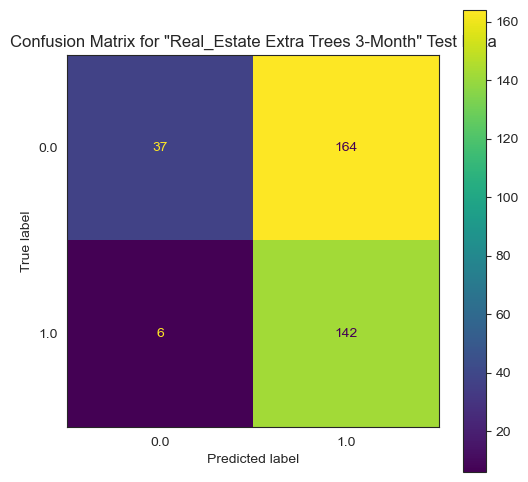

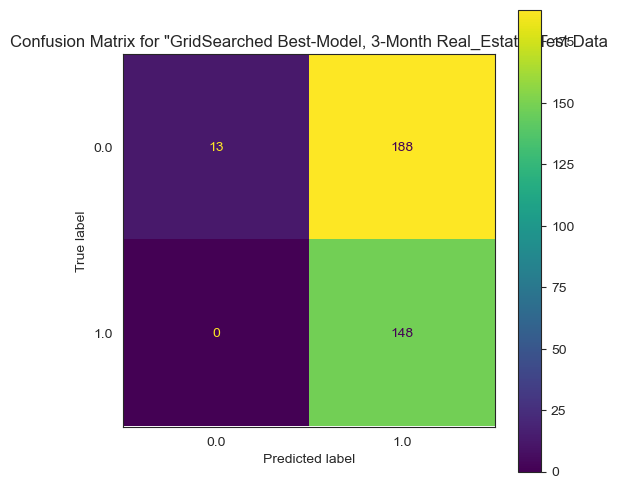

In [381]:
etc_RE_3.confusion_matrix(), grid_RE_3.confusion_matrix();

In [382]:
# Feature importances of the best model

features_from_trees(etc_RE_3)
Importance.df[-4:]

Top 5 Feature Importances
('Interest_Rates', 0.05385402752250327)
('GDP_Filled', 0.04569105414319461)
('ATR', 0.04106900301999126)
('20_day_SMA', 0.03967095575944006)
('High', 0.03789053204589958)


Adj Close     Close      High       Low  \
Consumer Discretionary 6-Month    5.330166 -4.546046 -3.979245 -2.953315   
Consumer Discretionary 12-Month   0.042148  0.050646  0.039939  0.041573   
36                                0.011480  0.044854  0.018834  0.011954   
37                                0.033184  0.034580  0.037891  0.032568   

                                     Open    Volume  GDP_Filled  \
Consumer Discretionary 6-Month  -2.395406 -0.873307   -0.668654   
Consumer Discretionary 12-Month  0.045065  0.027356    0.095369   
36                               0.055964  0.007790    0.050639   
37                               0.026831  0.020350    0.045691   

                                 Interest_Rates    Mkt-RF       SMB       HML  \
Consumer Discretionary 6-Month        -0.226101 -0.196922 -0.011164  0.031269   
Consumer Discretionary 12-Month        0.147269  0.004318  0.004752  0.005769   
36                                     0.023766  0.003776  0.008986  0.004320   
37                                     0.053854  0.010441  0.010236  0.010031   

                                      RMW       CMA  garman_klass_vol  \
Consumer Discretionary 6-Month  -0.031912 -0.010758          1.179830   
Consumer Discretionary 12-Month  0.005347  0.005192          0.054306   
36                               0.005411  0.005326          0.005071   
37                               0.007854  0.008975          0.030788   

                                      RSI  lowest_bollinger_band  \
Consumer Discretionary 6-Month   0.148442              -0.480917   
Consumer Discretionary 12-Month  0.016009               0.034508   
36                               0.016191               0.029860   
37                               0.023754               0.035350   

                                 lower_bollinger_band  20_day_SMA  \
Consumer Discretionary 6-Month               0.633882    1.732643   
Consumer Discretionary 12-Month              0.046655    0.049361   
36                                           0.009785    0.017959   
37                                           0.036426    0.039671   

                                 one_up_bollinger_band  upper_bollinger_band  \
Consumer Discretionary 6-Month                2.814812              3.879904   
Consumer Discretionary 12-Month               0.036578              0.064138   
36                                            0.020838              0.020044   
37                                            0.034725              0.036899   

                                      ATR      MACD  dollar_volume(M)  \
Consumer Discretionary 6-Month  -0.606649  0.025268          1.164251   
Consumer Discretionary 12-Month  0.047101  0.019700          0.025489   
36                               0.025775  0.016166          0.002976   
37                               0.041069  0.021270          0.019084   

                                 Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
Consumer Discretionary 6-Month   -0.449232  -0.246839   0.190866   0.711261   
Consumer Discretionary 12-Month   0.002427   0.004314   0.003393   0.007053   
36                                0.020786   0.003479   0.021453   0.010066   
37                                0.011665   0.035254   0.035505   0.027850   

                                  Month_1  Month_10  Month_11  Month_12  \
Consumer Discretionary 6-Month  -0.034966  0.947482  0.183803 -0.420024   
Consumer Discretionary 12-Month  0.001011  0.003518  0.001666  0.001761   
36                               0.021484  0.000000  0.014812  0.039925   
37                               0.013720  0.012150  0.018655  0.012322   

                                  Month_2   Month_3   Month_4   Month_5  \
Consumer Discretionary 6-Month  -0.061401 -0.352865 -0.719251 -0.065152   
Consumer Discretionary 12-Month  0.002494  0.000916  0.001773  0.001768   
36                               0.014714  0.004867  0.000949  0.177606   
37                

<hr style="border: 2px solid darkgreen">

# XLRE 6 Month

In [387]:
# Create variables

X_train, X_test, y_train, y_test = select_data(real_df, "Six")


# Create Model Objects
                            
# dummy_RE_6 = dummy_model(Real_Estate, "Real_Estate", 6)
# logreg_RE_6 = l_regr(Real_Estate, "Real_Estate", 6)
# rfc_RE_6 = r_forest(Real_Estate, "Real_Estate", 6)
# etc_RE_6 = extra_trees(Real_Estate, "Real_Estate", 6)
# XGBoost_RE_6 = x_g_b(Real_Estate, "Real_Estate", 6)

# grid_RE_6 = best_etc_grid(estimator=etc_RE_6.model, model_type=Real_Estate, \
#                             sector_name="Real_Estate", time_period=6)
# grid_RE_6 = best_XGB_grid(XGBoost_RE_6.model, Real_Estate, "Real Estate", 6)

Real_Estate.model_df.iloc[12:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
17  Grid Searched XGBoost, 6-Month Real Estate        0.632759    0.852349   
16                 Real_Estate XGBoost 6-Month        0.643103    0.850899   
14           Real_Estate Random Forest 6-Month        0.697414    0.888793   
12                   Dummy Real_Estate 6-Month        0.662931    0.622414   
15             Real_Estate Extra Trees 6-Month        0.586207    0.827432   
13     Real_Estate Logistic Regression 6-Month        0.514655    0.673964   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
17      0.619012  0.700483            NaN       0.375358   0.322981   
16      0.631310  0.707500            NaN       0.361032   0.318043   
14      0.769896  0.780312            NaN       0.318052   0.302941   
12      0.800000  0.683584            NaN       0.297994   0.297994   
15      0.708472  0.714368            NaN       0.297994   0.297994   
13      0.580844  0.590306            NaN       0.312321   0.179245   

    test_recall   test_f1  test_logloss       AUC  
17     1.000000  0.488263      2.939398  0.724352  
16     1.000000  0.482599      2.795418  0.734635  
14     0.990385  0.463964      1.096489  0.787834  
12     1.000000  0.459161     25.302851  0.500000  
15     1.000000  0.459161      1.102450  0.706829  
13     0.365385  0.240506      4.314588  0.443603

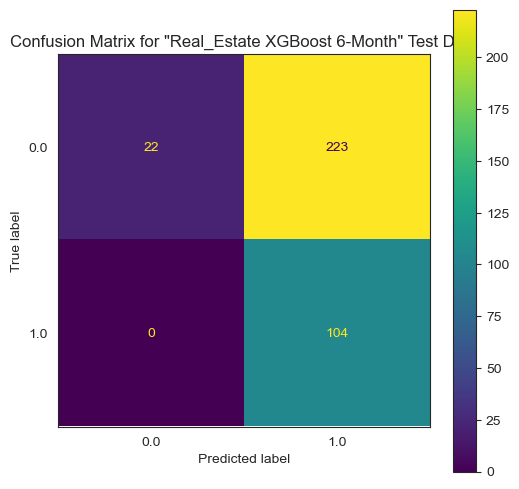

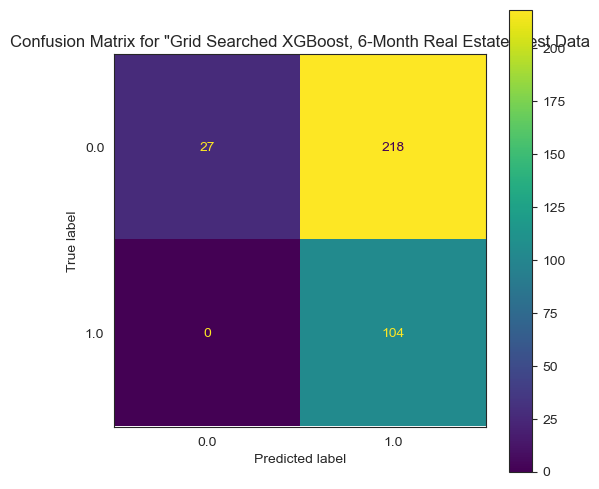

In [388]:
XGBoost_RE_6.confusion_matrix(), grid_RE_6.confusion_matrix();

In [389]:
# Top 5 important features from the best model

features_from_trees(grid_RE_6)
Importance.df[-4:]

Top 5 Feature Importances
('Low', 0.23917137)
('Interest_Rates', 0.13869339)
('ATR', 0.08539483)
('GDP_Filled', 0.07941173)
('High', 0.07289464)


Adj Close     Close      High       Low  \
Consumer Discretionary 12-Month   0.042148  0.050646  0.039939  0.041573   
36                                0.011480  0.044854  0.018834  0.011954   
37                                0.033184  0.034580  0.037891  0.032568   
38                                0.031415  0.004094  0.072895  0.239171   

                                     Open    Volume  GDP_Filled  \
Consumer Discretionary 12-Month  0.045065  0.027356    0.095369   
36                               0.055964  0.007790    0.050639   
37                               0.026831  0.020350    0.045691   
38                               0.007618  0.021927    0.079412   

                                 Interest_Rates    Mkt-RF       SMB       HML  \
Consumer Discretionary 12-Month        0.147269  0.004318  0.004752  0.005769   
36                                     0.023766  0.003776  0.008986  0.004320   
37                                     0.053854  0.010441  0.010236  0.010031   
38                                     0.138693  0.006454  0.003263  0.002465   

                                      RMW       CMA  garman_klass_vol  \
Consumer Discretionary 12-Month  0.005347  0.005192          0.054306   
36                               0.005411  0.005326          0.005071   
37                               0.007854  0.008975          0.030788   
38                               0.001475  0.002127          0.019959   

                                      RSI  lowest_bollinger_band  \
Consumer Discretionary 12-Month  0.016009               0.034508   
36                               0.016191               0.029860   
37                               0.023754               0.035350   
38                               0.027500               0.043580   

                                 lower_bollinger_band  20_day_SMA  \
Consumer Discretionary 12-Month              0.046655    0.049361   
36                                           0.009785    0.017959   
37                                           0.036426    0.039671   
38                                           0.061292    0.026871   

                                 one_up_bollinger_band  upper_bollinger_band  \
Consumer Discretionary 12-Month               0.036578              0.064138   
36                                            0.020838              0.020044   
37                                            0.034725              0.036899   
38                                            0.005564              0.035716   

                                      ATR      MACD  dollar_volume(M)  \
Consumer Discretionary 12-Month  0.047101  0.019700          0.025489   
36                               0.025775  0.016166          0.002976   
37                               0.041069  0.021270          0.019084   
38                               0.085395  0.008165          0.001250   

                                 Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
Consumer Discretionary 12-Month   0.002427   0.004314   0.003393   0.007053   
36                                0.020786   0.003479   0.021453   0.010066   
37                                0.011665   0.035254   0.035505   0.027850   
38                                0.015077   0.005637   0.001244   0.000000   

                                  Month_1  Month_10  Month_11  Month_12  \
Consumer Discretionary 12-Month  0.001011  0.003518  0.001666  0.001761   
36                               0.021484  0.000000  0.014812  0.039925   
37                               0.013720  0.012150  0.018655  0.012322   
38                               0.000000  0.000000  0.000000  0.000000   

                                  Month_2   Month_3   Month_4   Month_5  \
Consumer Discretionary 12-Month  0.002494  0.000916  0.001773  0.001768   
36                               0.014714  0.004867  0.000949  0.177606   
37                               0.004582  0.014202  0.005989  0.010483   
38                

<hr style="border: 2px solid darkgreen">

# XLRE 12 Month

In [394]:
# Create variables

X_train, X_test, y_train, y_test = select_data(real_df, "Twelve")


# Create Model Objects
                            
# dummy_RE_12 = dummy_model(Real_Estate, "Real_Estate", 12)
# logreg_RE_12 = l_regr(Real_Estate, "Real_Estate", 12)
# rfc_RE_12 = r_forest(Real_Estate, "Real_Estate", 12)
# etc_RE_12 = extra_trees(Real_Estate, "Real_Estate", 12)
# XGBoost_RE_12 = x_g_b(Real_Estate, "Real_Estate", 12)

# grid_RE_12 = best_etc_grid(estimator=rfc_RE_12.model, model_type=Real_Estate, \
#                             sector_name="Real_Estate", time_period=12)

Real_Estate.model_df.iloc[18:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.01, 'model__criterion': 'gini', 'model__max_depth': 7, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


name  train_accuracy  train_prec  \
20             Real_Estate Random Forest 12-Month        0.779310    0.894988   
19       Real_Estate Logistic Regression 12-Month        0.783621    0.960905   
22                   Real_Estate XGBoost 12-Month        0.759483    0.878579   
21               Real_Estate Extra Trees 12-Month        0.754310    0.882486   
18                     Dummy Real_Estate 12-Month        0.760345    0.760345   
23  GridSearched Best-Model, 12-Month Real_Estate        0.704310    0.956762   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
20      0.820438  0.833535       0.473277       0.851003   0.132075   
19      0.764361  0.837090       1.500871       0.618911   0.058824   
22      0.815330  0.812633       0.874682       0.338109   0.042017   
21      0.811547  0.809322       0.553760       0.455587   0.041451   
18      1.000000  0.845054       8.638048       0.037249   0.037249   
23      0.663194  0.726378       0.540476       0.037249   0.037249   

    test_recall   test_f1  test_logloss       AUC  
20     0.538462  0.212121      0.515754  0.698718  
19     0.615385  0.107383      3.312463  0.657051  
22     0.769231  0.079681      1.414984  0.651099  
21     0.615385  0.077670      0.773645  0.675252  
18     1.000000  0.071823     34.701053  0.500000  
23     1.000000  0.071823      1.679817  0.496337

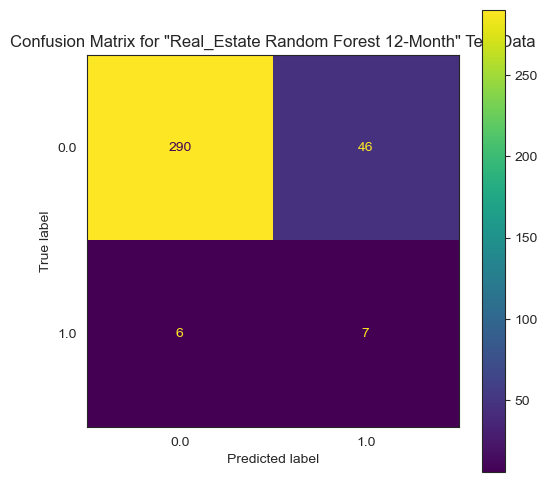

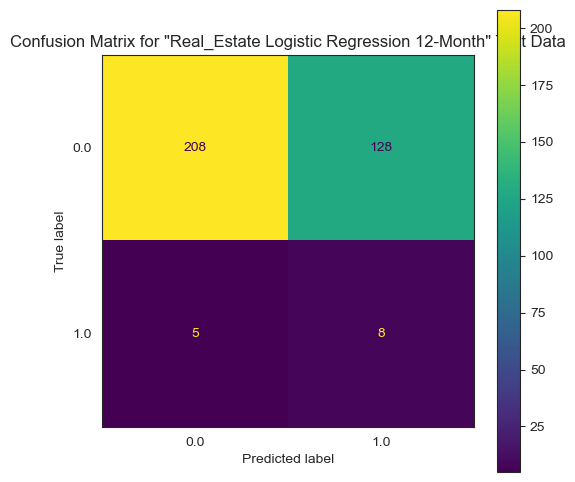

In [393]:
rfc_RE_12.confusion_matrix(), logreg_RE_12.confusion_matrix(), grid_RE_12.confusion_matrix();

In [395]:
# Top 5 feature importances for the best model

features_from_trees(rfc_RE_12)
Importance.df[-4:]

Top 5 Feature Importances
('Interest_Rates', 0.09519531930280517)
('cycle_year_3', 0.07800130780934283)
('Low', 0.057003958135309826)
('ATR', 0.05617727360048401)
('20_day_SMA', 0.05430921229261482)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
36   0.011480  0.044854  0.018834  0.011954  0.055964  0.007790    0.050639   
37   0.033184  0.034580  0.037891  0.032568  0.026831  0.020350    0.045691   
38   0.031415  0.004094  0.072895  0.239171  0.007618  0.021927    0.079412   
39   0.050198  0.051755  0.050876  0.057004  0.050928  0.014496    0.043289   

    Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
36        0.023766  0.003776  0.008986  0.004320  0.005411  0.005326   
37        0.053854  0.010441  0.010236  0.010031  0.007854  0.008975   
38        0.138693  0.006454  0.003263  0.002465  0.001475  0.002127   
39        0.095195  0.008111  0.007198  0.006671  0.006838  0.006933   

    garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
36          0.005071  0.016191               0.029860              0.009785   
37          0.030788  0.023754               0.035350              0.036426   
38          0.019959  0.027500               0.043580              0.061292   
39          0.049807  0.024621               0.042438              0.044626   

    20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
36    0.017959               0.020838              0.020044  0.025775   
37    0.039671               0.034725              0.036899  0.041069   
38    0.026871               0.005564              0.035716  0.085395   
39    0.054309               0.033874              0.050897  0.056177   

        MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
36  0.016166          0.002976   0.020786   0.003479   0.021453   0.010066   
37  0.021270          0.019084   0.011665   0.035254   0.035505   0.027850   
38  0.008165          0.001250   0.015077   0.005637   0.001244   0.000000   
39  0.028089          0.015753   0.006552   0.002667   0.003169   0.000773   

     Month_1  Month_10  Month_11  Month_12   Month_2   Month_3   Month_4  \
36  0.021484   0.00000  0.014812  0.039925  0.014714  0.004867  0.000949   
37  0.013720   0.01215  0.018655  0.012322  0.004582  0.014202  0.005989   
38  0.000000   0.00000  0.000000  0.000000  0.000000  0.000000  0.001467   
39  0.001807   0.00141  0.000961  0.001358  0.004904  0.000919  0.001772   

     Month_5   Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
36  0.177606  0.015514  0.004139  0.000000  0.011877      0.067844   
37  0.010483  0.002960  0.009452  0.007844  0.017805      0.029556   
38  0.009924  0.000000  0.002646  0.000000  0.020305      0.002229   
39  0.000404  0.003020  0.001937  0.000759  0.000599      0.022189   

    cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
36      0.004604      0.000000      0.134222            0.003610   
37      0.015493      0.016494      0.025208            0.004257   
38      0.000000      0.000000      0.004036            0.001081   
39      0.001487      0.078001      0.010266            0.001666   

    day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
36            0.003839              0.000000             0.005048   
37            0.003943              0.003965             0.004793   
38            0.010054              0.000000             0.000000   
39            0.000763              0.000725             0.000690   

    day_of_week_Wednesday  
36               0.001399  
37               0.004333  
38               0.000000  
39               0.001117

In [396]:
Importance.df.rename(index={36:"Real Estate 1-Month", 37:"Real Estate 3-Month", 38:"Real Estate 6-Month", \
                            39:"Real Estate 12-Month"}, inplace=True)

In [397]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

Adj Close     Close      High       Low      Open  \
Real Estate 1-Month    0.011480  0.044854  0.018834  0.011954  0.055964   
Real Estate 3-Month    0.033184  0.034580  0.037891  0.032568  0.026831   
Real Estate 6-Month    0.031415  0.004094  0.072895  0.239171  0.007618   
Real Estate 12-Month   0.050198  0.051755  0.050876  0.057004  0.050928   

                        Volume  GDP_Filled  Interest_Rates    Mkt-RF  \
Real Estate 1-Month   0.007790    0.050639        0.023766  0.003776   
Real Estate 3-Month   0.020350    0.045691        0.053854  0.010441   
Real Estate 6-Month   0.021927    0.079412        0.138693  0.006454   
Real Estate 12-Month  0.014496    0.043289        0.095195  0.008111   

                           SMB       HML       RMW       CMA  \
Real Estate 1-Month   0.008986  0.004320  0.005411  0.005326   
Real Estate 3-Month   0.010236  0.010031  0.007854  0.008975   
Real Estate 6-Month   0.003263  0.002465  0.001475  0.002127   
Real Estate 12-Month  0.007198  0.006671  0.006838  0.006933   

                      garman_klass_vol       RSI  lowest_bollinger_band  \
Real Estate 1-Month           0.005071  0.016191               0.029860   
Real Estate 3-Month           0.030788  0.023754               0.035350   
Real Estate 6-Month           0.019959  0.027500               0.043580   
Real Estate 12-Month          0.049807  0.024621               0.042438   

                      lower_bollinger_band  20_day_SMA  one_up_bollinger_band  \
Real Estate 1-Month               0.009785    0.017959               0.020838   
Real Estate 3-Month               0.036426    0.039671               0.034725   
Real Estate 6-Month               0.061292    0.026871               0.005564   
Real Estate 12-Month              0.044626    0.054309               0.033874   

                      upper_bollinger_band       ATR      MACD  \
Real Estate 1-Month               0.020044  0.025775  0.016166   
Real Estate 3-Month               0.036899  0.041069  0.021270   
Real Estate 6-Month               0.035716  0.085395  0.008165   
Real Estate 12-Month              0.050897  0.056177  0.028089   

                      dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Real Estate 1-Month           0.002976   0.020786   0.003479   0.021453   
Real Estate 3-Month           0.019084   0.011665   0.035254   0.035505   
Real Estate 6-Month           0.001250   0.015077   0.005637   0.001244   
Real Estate 12-Month          0.015753   0.006552   0.002667   0.003169   

                      Quarter_4   Month_1  Month_10  Month_11  Month_12  \
Real Estate 1-Month    0.010066  0.021484   0.00000  0.014812  0.039925   
Real Estate 3-Month    0.027850  0.013720   0.01215  0.018655  0.012322   
Real Estate 6-Month    0.000000  0.000000   0.00000  0.000000  0.000000   
Real Estate 12-Month   0.000773  0.001807   0.00141  0.000961  0.001358   

                       Month_2   Month_3   Month_4   Month_5   Month_6  \
Real Estate 1-Month   0.014714  0.004867  0.000949  0.177606  0.015514   
Real Estate 3-Month   0.004582  0.014202  0.005989  0.010483  0.002960   
Real Estate 6-Month   0.000000  0.000000  0.001467  0.009924  0.000000   
Real Estate 12-Month  0.004904  0.000919  0.001772  0.000404  0.003020   

                       Month_7   Month_8   Month_9  cycle_year_1  \
Real Estate 1-Month   0.004139  0.000000  0.011877      0.067844   
Real Estate 3-Month   0.009452  0.007844  0.017805      0.029556   
Real Estate 6-Month   0.002646  0.000000  0.020305      0.002229   
Real Estate 12-Month  0.001937  0.000759  0.000599      0.022189   

                      cycle_year_2  cycle_year_3  cycle_year_4  \
Real Estate 1-Month       0.004604      0.000000      0.134222   
Real Estate 3-Month       0.015493      0.016494      0.025208   
Real Estate 6-Month       0.000000      0.000000      0.004036   
Real Estate 12-Month      0.001487      0.078001      0.010266   

                      day_of_week_Friday  day_of_week_Mo

<hr style="border: 4px solid darkred">

# Communication Services - XLC

### 1 Month

In [402]:
# Create variables

X_train, X_test, y_train, y_test = select_data(communication_df, "One")


# Create Model Objects
                            
# dummy_CSrv_1 = dummy_model(Communication_Services, "Communication_Services", 1)
# logreg_CSrv_1 = l_regr(Communication_Services, "Communication_Services", 1)
# rfc_CSrv_1 = r_forest(Communication_Services, "Communication_Services", 1)
# etc_CSrv_1 = extra_trees(Communication_Services, "Communication_Services", 1)
# XGBoost_CSrv_1 = x_g_b(Communication_Services, "Communication_Services", 1)

# grid_CSrv_1 = best_etc_grid(estimator=etc_CSrv_1.model, model_type=Communication_Services, \
#                             sector_name="Communication_Services", time_period=1)
# grid_CSrv_1 = best_XGB_grid(XGBoost_CSrv_1.model, Communication_Services, "Communication Services", 1)

Communication_Services.model_df.sort_values(by="test_prec", ascending=False)

name  train_accuracy  \
4             Communication_Services XGBoost 1-Month        0.474648   
3         Communication_Services Extra Trees 1-Month        0.447887   
2       Communication_Services Random Forest 1-Month        0.463380   
0               Dummy Communication_Services 1-Month        0.659155   
5  Grid Searched XGBoost, 1-Month Communication S...        0.526761   
1  Communication_Services Logistic Regression 1-M...        0.466197   

   train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
4    0.697197      0.483857  0.513190       1.822947       0.616822   
3    0.708941      0.490603  0.517264       0.944017       0.509346   
2    0.752047      0.482205  0.517872       0.957942       0.383178   
0    0.580282      0.800000  0.667048      12.285302       0.299065   
5    0.816074      0.460551  0.515824       4.130850       0.621495   
1    0.750668      0.388725  0.490408       1.429726       0.612150   

   test_prec  test_recall   test_f1  test_logloss       AUC  
4   0.390244     0.500000  0.438356      0.894319  0.640208  
3   0.352518     0.765625  0.482759      0.694784  0.615000  
2   0.317204     0.921875  0.472000      0.784621  0.535313  
0   0.299065     1.000000  0.460432     25.264243  0.500000  
5   0.292683     0.187500  0.228571      3.031008  0.537396  
1   0.000000     0.000000  0.000000      1.991115  0.497500

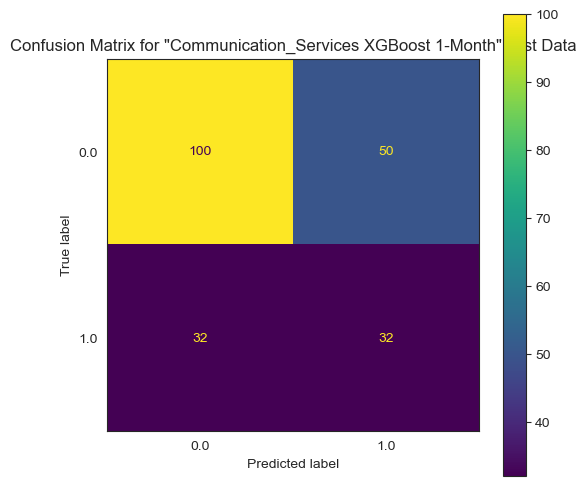

In [400]:
XGBoost_CSrv_1.confusion_matrix()

In [403]:
# Feature importance for the best model

features_from_trees(XGBoost_CSrv_1)
Importance.df[-4:]

Top 5 Feature Importances
('cycle_year_2', 0.15469712)
('Quarter_1', 0.1333199)
('Month_11', 0.07440692)
('20_day_SMA', 0.06651221)
('Month_7', 0.061764672)


Adj Close     Close      High       Low      Open  \
Real Estate 3-Month    0.033184  0.034580  0.037891  0.032568  0.026831   
Real Estate 6-Month    0.031415  0.004094  0.072895  0.239171  0.007618   
Real Estate 12-Month   0.050198  0.051755  0.050876  0.057004  0.050928   
40                     0.061402  0.021477  0.024108  0.004267  0.003960   

                        Volume  GDP_Filled  Interest_Rates    Mkt-RF  \
Real Estate 3-Month   0.020350    0.045691        0.053854  0.010441   
Real Estate 6-Month   0.021927    0.079412        0.138693  0.006454   
Real Estate 12-Month  0.014496    0.043289        0.095195  0.008111   
40                    0.005177    0.021996        0.023731  0.004989   

                           SMB       HML       RMW       CMA  \
Real Estate 3-Month   0.010236  0.010031  0.007854  0.008975   
Real Estate 6-Month   0.003263  0.002465  0.001475  0.002127   
Real Estate 12-Month  0.007198  0.006671  0.006838  0.006933   
40                    0.004905  0.002063  0.004587  0.002731   

                      garman_klass_vol       RSI  lowest_bollinger_band  \
Real Estate 3-Month           0.030788  0.023754               0.035350   
Real Estate 6-Month           0.019959  0.027500               0.043580   
Real Estate 12-Month          0.049807  0.024621               0.042438   
40                            0.002556  0.024114               0.053695   

                      lower_bollinger_band  20_day_SMA  one_up_bollinger_band  \
Real Estate 3-Month               0.036426    0.039671               0.034725   
Real Estate 6-Month               0.061292    0.026871               0.005564   
Real Estate 12-Month              0.044626    0.054309               0.033874   
40                                0.040054    0.066512               0.025207   

                      upper_bollinger_band       ATR      MACD  \
Real Estate 3-Month               0.036899  0.041069  0.021270   
Real Estate 6-Month               0.035716  0.085395  0.008165   
Real Estate 12-Month              0.050897  0.056177  0.028089   
40                                0.015995  0.007717  0.011748   

                      dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Real Estate 3-Month           0.019084   0.011665   0.035254   0.035505   
Real Estate 6-Month           0.001250   0.015077   0.005637   0.001244   
Real Estate 12-Month          0.015753   0.006552   0.002667   0.003169   
40                            0.004405   0.133320   0.000000   0.003597   

                      Quarter_4   Month_1  Month_10  Month_11  Month_12  \
Real Estate 3-Month    0.027850  0.013720  0.012150  0.018655  0.012322   
Real Estate 6-Month    0.000000  0.000000  0.000000  0.000000  0.000000   
Real Estate 12-Month   0.000773  0.001807  0.001410  0.000961  0.001358   
40                     0.003970  0.000000  0.001685  0.074407  0.014798   

                       Month_2   Month_3   Month_4   Month_5   Month_6  \
Real Estate 3-Month   0.004582  0.014202  0.005989  0.010483  0.002960   
Real Estate 6-Month   0.000000  0.000000  0.001467  0.009924  0.000000   
Real Estate 12-Month  0.004904  0.000919  0.001772  0.000404  0.003020   
40                    0.000000  0.000000  0.031227  0.000000  0.020771   

                       Month_7   Month_8   Month_9  cycle_year_1  \
Real Estate 3-Month   0.009452  0.007844  0.017805      0.029556   
Real Estate 6-Month   0.002646  0.000000  0.020305      0.002229   
Real Estate 12-Month  0.001937  0.000759  0.000599      0.022189   
40                    0.061765  0.000000  0.046764      0.000000   

                      cycle_year_2  cycle_year_3  cycle_year_4  \
Real Estate 3-Month       0.015493      0.016494      0.025208   
Real Estate 6-Month       0.000000      0.000000      0.004036   
Real Estate 12-Month      0.001487      0.078001      0.010266   
40                        0.154697      0.006325      0.000000   

                      day_of_week_Friday  day_of_week_Mo

<hr style="border: 2px solid darkgreen">

# XLC 3 Month 

In [409]:
# Create variables

X_train, X_test, y_train, y_test = select_data(communication_df, "Three")


# Create Model Objects
                            
# dummy_CSrv_3 = dummy_model(Communication_Services, "Communication_Services", 3)
# logreg_CSrv_3 = l_regr(Communication_Services, "Communication_Services", 3)
# rfc_CSrv_3 = r_forest(Communication_Services, "Communication_Services", 3)
# etc_CSrv_3 = extra_trees(Communication_Services, "Communication_Services", 3)
# XGBoost_CSrv_3 = x_g_b(Communication_Services, "Communication_Services", 3)

# grid_CSrv_3 = best_etc_grid(estimator=etc_CSrv_3.model, model_type=Communication_Services, \
#                             sector_name="Communication_Services", time_period=3)
# grid_CSrv_3 = best_logreg_search(logreg_CSrv_3.model, Communication_Services, "Communication_Services", 3)

Communication_Services.model_df.iloc[6:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  \
6                Dummy Communication_Services 3-Month        0.723944   
8        Communication_Services Random Forest 3-Month        0.463380   
7   Communication_Services Logistic Regression 3-M...        0.357746   
11   Grid Searched LR, 3-Month Communication_Services        0.322535   
9          Communication_Services Extra Trees 3-Month        0.453521   
10             Communication_Services XGBoost 3-Month        0.404225   

    train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
6     0.723944      1.000000  0.790665            NaN       0.121495   
8     0.762586      0.624198  0.502694            NaN       0.528037   
7     0.790059      0.430301  0.382706            NaN       0.509346   
11    0.798754      0.455353  0.382850            NaN       0.504673   
9     0.745188      0.677453  0.535965            NaN       0.556075   
10    0.543988      0.584048  0.444963            NaN       0.719626   

    test_prec  test_recall   test_f1  test_logloss       AUC  
6    0.121495     1.000000  0.216667     31.664518  0.500000  
8    0.068966     0.230769  0.106195      0.712721  0.201821  
7    0.065934     0.230769  0.102564      1.812979  0.203560  
11   0.065217     0.230769  0.101695      1.274771  0.250205  
9    0.000000     0.000000  0.000000      0.677217  0.177885  
10   0.000000     0.000000  0.000000      0.815341  0.201923

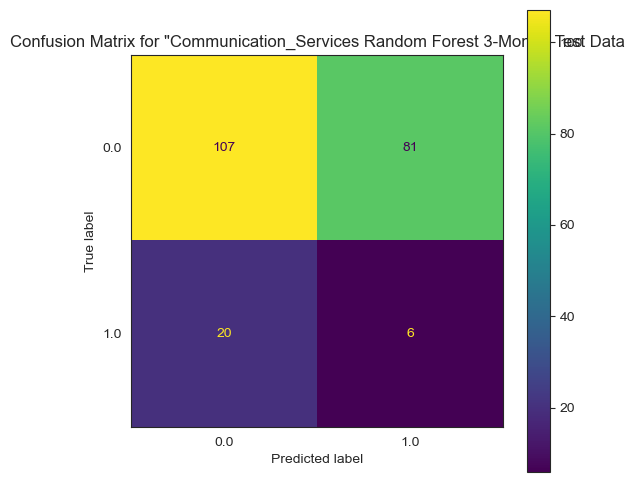

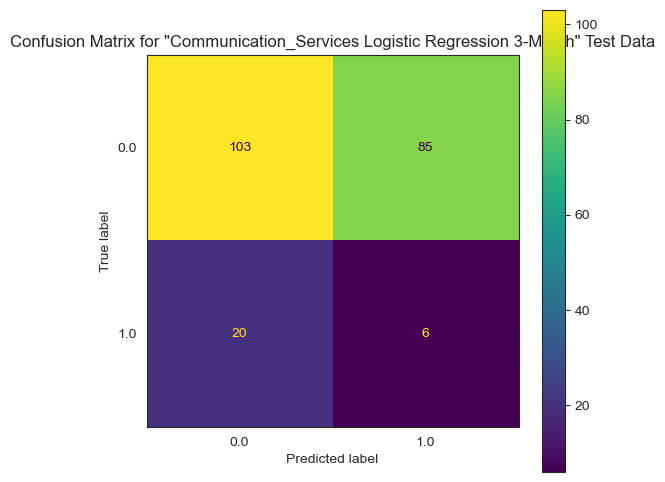

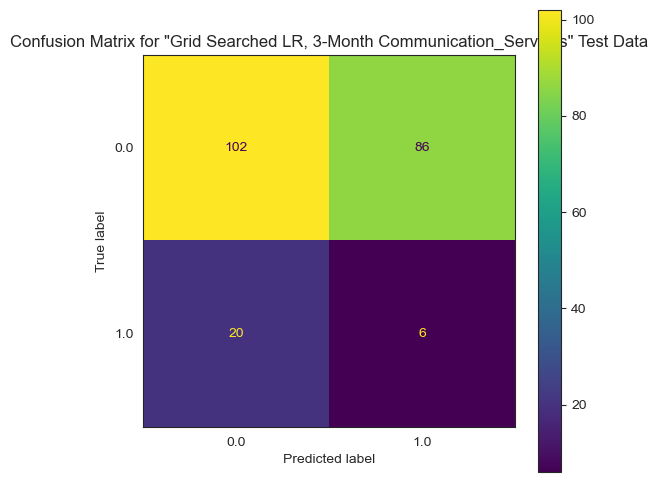

In [410]:
rfc_CSrv_3.confusion_matrix(), logreg_CSrv_3.confusion_matrix(), grid_CSrv_3.confusion_matrix();

### Special Cell

In [411]:
# Feature importances of the best model

coefs_from_lr(logreg_CSrv_3)
Importance.df[-4:]

Top 5 Feature Coefficients
('ATR', 3.9443060252530397)
('MACD', 2.4193160996833822)
('cycle_year_3', 1.9687108193185852)
('Month_4', 1.5512980717808924)
('Quarter_2', 1.4715941658705265)


Adj Close     Close      High       Low      Open  \
Real Estate 6-Month    0.031415  0.004094  0.072895  0.239171  0.007618   
Real Estate 12-Month   0.050198  0.051755  0.050876  0.057004  0.050928   
40                     0.061402  0.021477  0.024108  0.004267  0.003960   
41                    -0.393757 -0.560919 -0.570486 -0.439171 -0.516365   

                        Volume  GDP_Filled  Interest_Rates    Mkt-RF  \
Real Estate 6-Month   0.021927    0.079412        0.138693  0.006454   
Real Estate 12-Month  0.014496    0.043289        0.095195  0.008111   
40                    0.005177    0.021996        0.023731  0.004989   
41                    0.130450   -0.703113       -3.380667 -0.073505   

                           SMB       HML       RMW       CMA  \
Real Estate 6-Month   0.003263  0.002465  0.001475  0.002127   
Real Estate 12-Month  0.007198  0.006671  0.006838  0.006933   
40                    0.004905  0.002063  0.004587  0.002731   
41                   -0.129329  0.067967 -0.154492 -0.253184   

                      garman_klass_vol       RSI  lowest_bollinger_band  \
Real Estate 6-Month           0.019959  0.027500               0.043580   
Real Estate 12-Month          0.049807  0.024621               0.042438   
40                            0.002556  0.024114               0.053695   
41                           -0.197953 -0.780213              -0.242638   

                      lower_bollinger_band  20_day_SMA  one_up_bollinger_band  \
Real Estate 6-Month               0.061292    0.026871               0.005564   
Real Estate 12-Month              0.044626    0.054309               0.033874   
40                                0.040054    0.066512               0.025207   
41                               -0.349067   -0.454665              -0.558760   

                      upper_bollinger_band       ATR      MACD  \
Real Estate 6-Month               0.035716  0.085395  0.008165   
Real Estate 12-Month              0.050897  0.056177  0.028089   
40                                0.015995  0.007717  0.011748   
41                               -0.660717  3.944306  2.419316   

                      dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Real Estate 6-Month           0.001250   0.015077   0.005637   0.001244   
Real Estate 12-Month          0.015753   0.006552   0.002667   0.003169   
40                            0.004405   0.133320   0.000000   0.003597   
41                           -0.203971  -0.318917   1.471594  -0.739317   

                      Quarter_4   Month_1  Month_10  Month_11  Month_12  \
Real Estate 6-Month    0.000000  0.000000  0.000000  0.000000  0.000000   
Real Estate 12-Month   0.000773  0.001807  0.001410  0.000961  0.001358   
40                     0.003970  0.000000  0.001685  0.074407  0.014798   
41                    -0.413066 -0.676905 -0.669693  0.833016 -0.576389   

                       Month_2   Month_3   Month_4   Month_5   Month_6  \
Real Estate 6-Month   0.000000  0.000000  0.001467  0.009924  0.000000   
Real Estate 12-Month  0.004904  0.000919  0.001772  0.000404  0.003020   
40                    0.000000  0.000000  0.031227  0.000000  0.020771   
41                   -0.565837  0.923825  1.551298 -0.738227  0.658523   

                       Month_7   Month_8   Month_9  cycle_year_1  \
Real Estate 6-Month   0.002646  0.000000  0.020305      0.002229   
Real Estate 12-Month  0.001937  0.000759  0.000599      0.022189   
40                    0.061765  0.000000  0.046764      0.000000   
41                   -0.757320 -0.366131  0.384135      1.086032   

                      cycle_year_2  cycle_year_3  cycle_year_4  \
Real Estate 6-Month       0.000000      0.000000      0.004036   
Real Estate 12-Month      0.001487      0.078001      0.010266   
40                        0.154697      0.006325      0.000000   
41                       -2.117540      1.968711     -0.936909   

                      day_of_week_Friday  day_of_week_Mo

<hr style="border: 2px solid darkgreen">

# XLC 6 Month

In [419]:
# Create variables

X_train, X_test, y_train, y_test = select_data(communication_df, "Six")


# Create Model Objects
                            
# dummy_CSrv_6 = dummy_model(Communication_Services, "Communication_Services", 6)
# logreg_CSrv_6 = l_regr(Communication_Services, "Communication_Services", 6)
# rfc_CSrv_6 = r_forest(Communication_Services, "Communication_Services", 6)
# etc_CSrv_6 = extra_trees(Communication_Services, "Communication_Services", 6)
# XGBoost_CSrv_6 = x_g_b(Communication_Services, "Communication_Services", 6)

# grid_CSrv_6 = best_etc_grid(estimator=rfc_CSrv_6.model, model_type=Communication_Services, \
#                             sector_name="Communication_Services", time_period=6)
# grid_CSrv_6 = best_XGB_grid(XGBoost_CSrv_6.model, Communication_Services, "Communication_Services", 6)

Communication_Services.model_df.iloc[13:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  \
16             Communication_Services XGBoost 6-Month        0.756338   
18  Grid Searched XGBoost, 6-Month Communication_S...        0.750704   
14       Communication_Services Random Forest 6-Month        0.754930   
17               Dummy Communication_Services 6-Month        0.722535   
15         Communication_Services Extra Trees 6-Month        0.688732   
13  Communication_Services Logistic Regression 6-M...        0.560563   

    train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
16    0.731034      0.687065  0.696398            NaN       0.336449   
18    0.731034      0.689882  0.697900            NaN       0.336449   
14    0.728391      0.616099  0.636128            NaN       0.308411   
17    0.722535      0.800000  0.756351            NaN       0.196262   
15    0.739375      0.690226  0.690036            NaN       0.196262   
13    0.674476      0.392997  0.442423            NaN       0.219626   

    test_prec  test_recall   test_f1  test_logloss       AUC  
16   0.228261     1.000000  0.371681      2.735514  0.300803  
18   0.228261     1.000000  0.371681      3.274133  0.681824  
14   0.205556     0.880952  0.333333      1.110360  0.226675  
17   0.196262     1.000000  0.328125     28.969665  0.500000  
15   0.138889     0.595238  0.225225      1.071315  0.160991  
13   0.111801     0.428571  0.177340      2.230579  0.213870

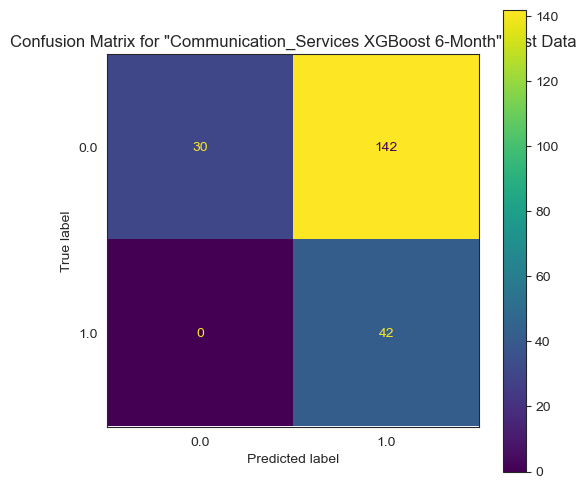

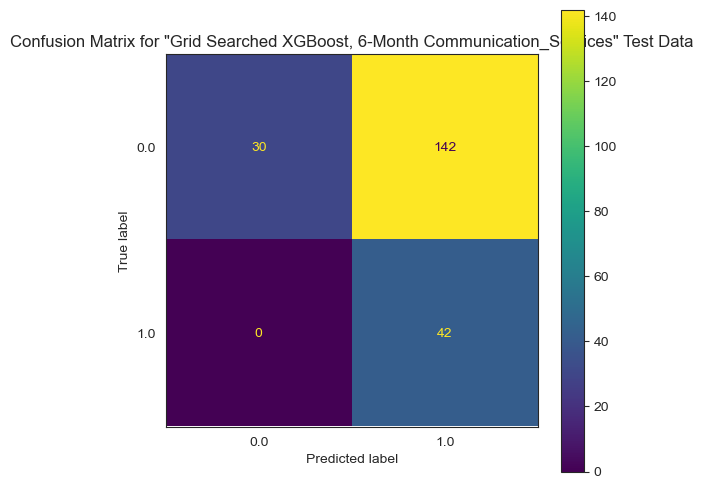

In [420]:
XGBoost_CSrv_6.confusion_matrix(), grid_CSrv_6.confusion_matrix();

In [421]:
# Top 5 important features from the best model

features_from_trees(grid_CSrv_6)
Importance.df[-4:]

Top 5 Feature Importances
('upper_bollinger_band', 0.20441055)
('Volume', 0.17895311)
('Month_10', 0.16454823)
('Quarter_2', 0.10246779)
('Month_9', 0.10079312)


Adj Close     Close      High       Low      Open  \
Real Estate 12-Month   0.050198  0.051755  0.050876  0.057004  0.050928   
40                     0.061402  0.021477  0.024108  0.004267  0.003960   
41                    -0.393757 -0.560919 -0.570486 -0.439171 -0.516365   
42                     0.001949  0.000000  0.000964  0.000221  0.000592   

                        Volume  GDP_Filled  Interest_Rates    Mkt-RF  \
Real Estate 12-Month  0.014496    0.043289        0.095195  0.008111   
40                    0.005177    0.021996        0.023731  0.004989   
41                    0.130450   -0.703113       -3.380667 -0.073505   
42                    0.178953    0.000674        0.004549  0.001025   

                           SMB       HML       RMW       CMA  \
Real Estate 12-Month  0.007198  0.006671  0.006838  0.006933   
40                    0.004905  0.002063  0.004587  0.002731   
41                   -0.129329  0.067967 -0.154492 -0.253184   
42                    0.002609  0.000672  0.004349  0.002045   

                      garman_klass_vol       RSI  lowest_bollinger_band  \
Real Estate 12-Month          0.049807  0.024621               0.042438   
40                            0.002556  0.024114               0.053695   
41                           -0.197953 -0.780213              -0.242638   
42                            0.000000  0.002316               0.008796   

                      lower_bollinger_band  20_day_SMA  one_up_bollinger_band  \
Real Estate 12-Month              0.044626    0.054309               0.033874   
40                                0.040054    0.066512               0.025207   
41                               -0.349067   -0.454665              -0.558760   
42                                0.002552    0.008824               0.001655   

                      upper_bollinger_band       ATR      MACD  \
Real Estate 12-Month              0.050897  0.056177  0.028089   
40                                0.015995  0.007717  0.011748   
41                               -0.660717  3.944306  2.419316   
42                                0.204411  0.024805  0.021868   

                      dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  \
Real Estate 12-Month          0.015753   0.006552   0.002667   0.003169   
40                            0.004405   0.133320   0.000000   0.003597   
41                           -0.203971  -0.318917   1.471594  -0.739317   
42                            0.017245   0.000000   0.102468   0.000822   

                      Quarter_4   Month_1  Month_10  Month_11  Month_12  \
Real Estate 12-Month   0.000773  0.001807  0.001410  0.000961  0.001358   
40                     0.003970  0.000000  0.001685  0.074407  0.014798   
41                    -0.413066 -0.676905 -0.669693  0.833016 -0.576389   
42                     0.003897  0.000000  0.164548  0.032685  0.000000   

                       Month_2   Month_3   Month_4   Month_5   Month_6  \
Real Estate 12-Month  0.004904  0.000919  0.001772  0.000404  0.003020   
40                    0.000000  0.000000  0.031227  0.000000  0.020771   
41                   -0.565837  0.923825  1.551298 -0.738227  0.658523   
42                    0.000000  0.000000  0.000000  0.000000  0.000000   

                       Month_7   Month_8   Month_9  cycle_year_1  \
Real Estate 12-Month  0.001937  0.000759  0.000599      0.022189   
40                    0.061765  0.000000  0.046764      0.000000   
41                   -0.757320 -0.366131  0.384135      1.086032   
42                    0.000000  0.000000  0.100793      0.000000   

                      cycle_year_2  cycle_year_3  cycle_year_4  \
Real Estate 12-Month      0.001487      0.078001      0.010266   
40                        0.154697      0.006325      0.000000   
41                       -2.117540      1.968711     -0.936909   
42                        0.003271      0.062255      0.038186   

                      day_of_week_Friday  day_of_week_Mo

<hr style="border: 2px solid darkgreen">

# XLC 12 Month

In [427]:
# Create variables

X_train, X_test, y_train, y_test = select_data(communication_df, "Twelve")


# Create Model Objects
                            
# dummy_CSrv_12 = dummy_model(Communication_Services, "Communication_Services", 12)
# logreg_CSrv_12 = l_regr(Communication_Services, "Communication_Services", 12)
# rfc_CSrv_12 = r_forest(Communication_Services, "Communication_Services", 12)
# etc_CSrv_12 = extra_trees(Communication_Services, "Communication_Services", 12)
# XGBoost_CSrv_12 = x_g_b(Communication_Services, "Communication_Services", 12)

# grid_CSrv_12 = best_etc_grid(estimator=etc_CSrv_12.model, model_type=Communication_Services, \
#                             sector_name="Communication_Services", time_period=12)
# grid_CSrv_12 = best_logreg_search(logreg_CSrv_12.model, Communication_Services, "Communication_Services", 12)

Communication_Services.model_df.iloc[19:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  \
20  Communication_Services Logistic Regression 12-...        0.807042   
24  Grid Searched LR, 12-Month Communication_Services        0.809859   
22        Communication_Services Extra Trees 12-Month        0.830986   
21      Communication_Services Random Forest 12-Month        0.791549   
23            Communication_Services XGBoost 12-Month        0.833803   
19              Dummy Communication_Services 12-Month        0.639437   

    train_prec  train_recall  train_f1  train_logloss  test_accuracy  \
20    0.639842      0.796296  0.693229            NaN       0.789720   
24    0.640515      0.800000  0.695063            NaN       0.794393   
22    0.637324      0.788889  0.688782            NaN       0.761682   
21    0.634524      0.743610  0.665169            NaN       0.752336   
23    0.638795      0.790741  0.690421            NaN       0.724299   
19    0.639437      0.800000  0.694369            NaN       0.588785   

    test_prec  test_recall   test_f1  test_logloss       AUC  
20   0.909091     0.714286  0.800000      0.480459  0.898719  
24   0.866071     0.769841  0.815126      0.434271  0.899982  
22   0.711864     1.000000  0.831683      0.467283  0.975424  
21   0.703911     1.000000  0.826230      0.517828  0.882846  
23   0.681081     1.000000  0.810289      1.489212  0.932630  
19   0.588785     1.000000  0.741176     14.821689  0.500000

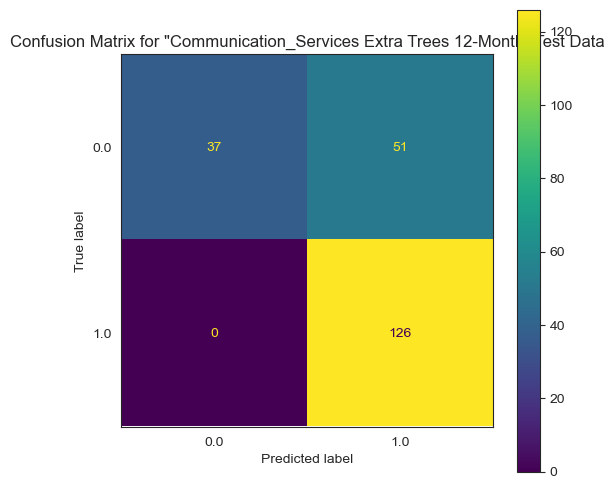

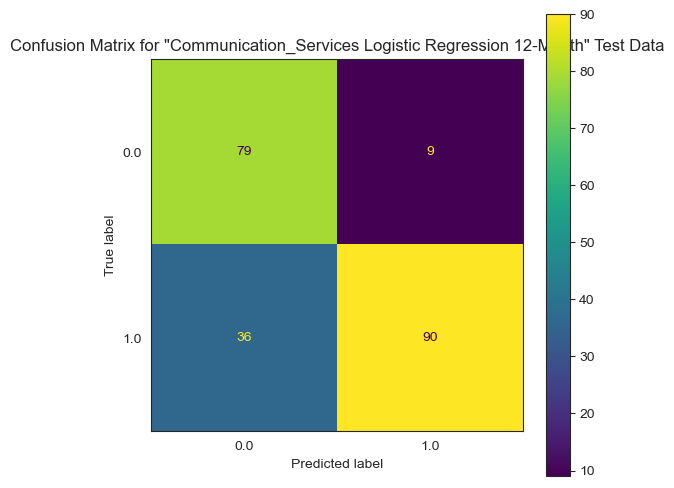

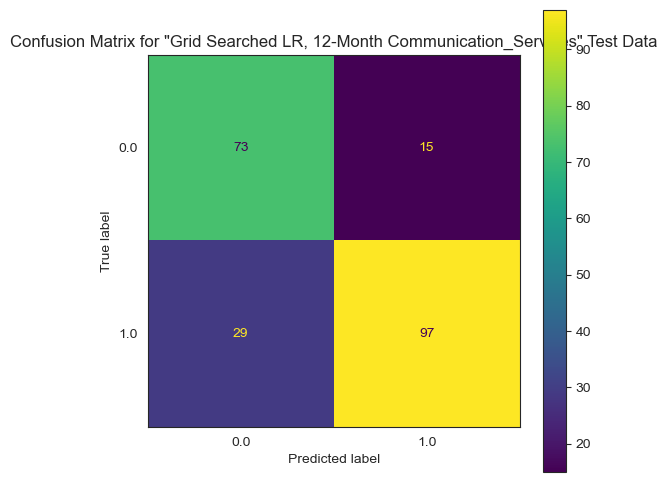

In [428]:
etc_CSrv_12.confusion_matrix(), logreg_CSrv_12.confusion_matrix(), grid_CSrv_12.confusion_matrix();

In [429]:
# Top 5 feature importances for the best model

coefs_from_lr(grid_CSrv_12)
Importance.df[-4:]

Top 5 Feature Coefficients
('Month_1', 2.5341587074644565)
('cycle_year_4', 1.9216886842024565)
('ATR', 1.3586902664046066)
('Month_9', 0.9889571168264364)
('Month_5', 0.9884252370699689)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
40   0.061402  0.021477  0.024108  0.004267  0.003960  0.005177    0.021996   
41  -0.393757 -0.560919 -0.570486 -0.439171 -0.516365  0.130450   -0.703113   
42   0.001949  0.000000  0.000964  0.000221  0.000592  0.178953    0.000674   
43  -0.637905 -0.692239 -0.685691 -0.704512 -0.671738  0.419765   -0.198252   

    Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
40        0.023731  0.004989  0.004905  0.002063  0.004587  0.002731   
41       -3.380667 -0.073505 -0.129329  0.067967 -0.154492 -0.253184   
42        0.004549  0.001025  0.002609  0.000672  0.004349  0.002045   
43       -2.603841 -0.212446  0.055573 -0.034352 -0.365202  0.069058   

    garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
40          0.002556  0.024114               0.053695              0.040054   
41         -0.197953 -0.780213              -0.242638             -0.349067   
42          0.000000  0.002316               0.008796              0.002552   
43          0.528107 -0.606625              -0.607622             -0.621644   

    20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
40    0.066512               0.025207              0.015995  0.007717   
41   -0.454665              -0.558760             -0.660717  3.944306   
42    0.008824               0.001655              0.204411  0.024805   
43   -0.634314              -0.645561             -0.655345  1.358690   

        MACD  dollar_volume(M)  Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
40  0.011748          0.004405   0.133320   0.000000   0.003597   0.003970   
41  2.419316         -0.203971  -0.318917   1.471594  -0.739317  -0.413066   
42  0.021868          0.017245   0.000000   0.102468   0.000822   0.003897   
43  0.498998         -0.505308  -0.349743  -0.978476   0.497813   0.830590   

     Month_1  Month_10  Month_11  Month_12   Month_2   Month_3   Month_4  \
40  0.000000  0.001685  0.074407  0.014798  0.000000  0.000000  0.031227   
41 -0.676905 -0.669693  0.833016 -0.576389 -0.565837  0.923825  1.551298   
42  0.000000  0.164548  0.032685  0.000000  0.000000  0.000000  0.000000   
43  2.534159 -0.088121  0.394639  0.524073  0.401495 -3.285397 -2.660129   

     Month_5   Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
40  0.000000  0.020771  0.061765  0.000000  0.046764      0.000000   
41 -0.738227  0.658523 -0.757320 -0.366131  0.384135      1.086032   
42  0.000000  0.000000  0.000000  0.000000  0.100793      0.000000   
43  0.988425  0.693227  0.323790 -0.814934  0.988957     -0.683638   

    cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
40      0.154697      0.006325      0.000000            0.000000   
41     -2.117540      1.968711     -0.936909           -0.020679   
42      0.003271      0.062255      0.038186            0.000000   
43     -1.420655      0.182788      1.921689           -0.110095   

    day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
40            0.000000              0.002547             0.000000   
41           -0.113615              0.142457             0.022032   
42            0.000000              0.000000             0.000000   
43            0.017751              0.061626             0.049742   

    day_of_week_Wednesday  
40               0.006732  
41              -0.029900  
42               0.000000  
43              -0.018840

In [430]:
Importance.df.rename(index={40:"Communication Services 1-Month", 41:"Communication Services 3-Month", 42:"Communication Services 6-Month", \
                            43:"Communication Services 12-Month"}, inplace=True)

In [431]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

Adj Close     Close      High       Low  \
Communication Services 1-Month    0.061402  0.021477  0.024108  0.004267   
Communication Services 3-Month   -0.393757 -0.560919 -0.570486 -0.439171   
Communication Services 6-Month    0.001949  0.000000  0.000964  0.000221   
Communication Services 12-Month  -0.637905 -0.692239 -0.685691 -0.704512   

                                     Open    Volume  GDP_Filled  \
Communication Services 1-Month   0.003960  0.005177    0.021996   
Communication Services 3-Month  -0.516365  0.130450   -0.703113   
Communication Services 6-Month   0.000592  0.178953    0.000674   
Communication Services 12-Month -0.671738  0.419765   -0.198252   

                                 Interest_Rates    Mkt-RF       SMB       HML  \
Communication Services 1-Month         0.023731  0.004989  0.004905  0.002063   
Communication Services 3-Month        -3.380667 -0.073505 -0.129329  0.067967   
Communication Services 6-Month         0.004549  0.001025  0.002609  0.000672   
Communication Services 12-Month       -2.603841 -0.212446  0.055573 -0.034352   

                                      RMW       CMA  garman_klass_vol  \
Communication Services 1-Month   0.004587  0.002731          0.002556   
Communication Services 3-Month  -0.154492 -0.253184         -0.197953   
Communication Services 6-Month   0.004349  0.002045          0.000000   
Communication Services 12-Month -0.365202  0.069058          0.528107   

                                      RSI  lowest_bollinger_band  \
Communication Services 1-Month   0.024114               0.053695   
Communication Services 3-Month  -0.780213              -0.242638   
Communication Services 6-Month   0.002316               0.008796   
Communication Services 12-Month -0.606625              -0.607622   

                                 lower_bollinger_band  20_day_SMA  \
Communication Services 1-Month               0.040054    0.066512   
Communication Services 3-Month              -0.349067   -0.454665   
Communication Services 6-Month               0.002552    0.008824   
Communication Services 12-Month             -0.621644   -0.634314   

                                 one_up_bollinger_band  upper_bollinger_band  \
Communication Services 1-Month                0.025207              0.015995   
Communication Services 3-Month               -0.558760             -0.660717   
Communication Services 6-Month                0.001655              0.204411   
Communication Services 12-Month              -0.645561             -0.655345   

                                      ATR      MACD  dollar_volume(M)  \
Communication Services 1-Month   0.007717  0.011748          0.004405   
Communication Services 3-Month   3.944306  2.419316         -0.203971   
Communication Services 6-Month   0.024805  0.021868          0.017245   
Communication Services 12-Month  1.358690  0.498998         -0.505308   

                                 Quarter_1  Quarter_2  Quarter_3  Quarter_4  \
Communication Services 1-Month    0.133320   0.000000   0.003597   0.003970   
Communication Services 3-Month   -0.318917   1.471594  -0.739317  -0.413066   
Communication Services 6-Month    0.000000   0.102468   0.000822   0.003897   
Communication Services 12-Month  -0.349743  -0.978476   0.497813   0.830590   

                                  Month_1  Month_10  Month_11  Month_12  \
Communication Services 1-Month   0.000000  0.001685  0.074407  0.014798   
Communication Services 3-Month  -0.676905 -0.669693  0.833016 -0.576389   
Communication Services 6-Month   0.000000  0.164548  0.032685  0.000000   
Communication Services 12-Month  2.534159 -0.088121  0.394639  0.524073   

                                  Month_2   Month_3   Month_4   Month_5  \
Communication Services 1-Month   0.000000  0.000000  0.031227  0.000000   
Communication Services 3-Month  -0.565837  0.923825  1.551298 -0.738227   
Communication Services 6-Month   0.000000  0.000000  0.000000  0.000000   
Communication Serv

<hr style="border: 6px solid red">

# Post-Modeling Protocol

- Save DFs as csv files
- Export Classes as .pkl files

In [432]:
Communication_Services.model_df.head(1)

name  train_accuracy  train_prec  \
0  Dummy Communication_Services 1-Month        0.659155    0.580282   

   train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
0           0.8  0.667048      12.285302       0.299065   0.299065   

   test_recall   test_f1  test_logloss  AUC  
0          1.0  0.460432     25.264243  0.5

In [433]:
# # Exporting the dfs of each class

# # Feature Importances
# Importance.df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Feature_Importances.csv')

# # Sectors

# #1
# Materials.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Materials.csv')
# #2
# Energy.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Energy.csv')
# #3
# Financials.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Financials.csv')
# #4
# Industrials.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Industrials.csv')
# #5
# Technology.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Technology.csv')
# #6
# Staples.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Staples.csv')
# #7
# Utilities.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Utilities.csv')
# #8
# Health.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Health_Care.csv')
# #9
# Consumer.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Consumer_Disc.csv')
# #10
# Real_Estate.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Real_Estate.csv')
# #11
# Communication_Services.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Communication_Services.csv')

In [434]:
# import pickle 

# with open('/Users/samalainabayeva/Desktop/Capstone Project/SPDR_classes.pkl', 'wb') as file:
#     pickle.dump([Materials.model_list, Energy.model_list, Financials.model_list, Industrials.model_list,\
#                  Technology.model_list, Staples.model_list, Utilities.model_list, Health.model_list,\
#                  Consumer.model_list, Real_Estate.model_list, Communication_Services.model_list], file)

In [435]:
all_data = pd.concat([Materials.model_df, Energy.model_df, Financials.model_df, Industrials.model_df, Technology.model_df,\
          Staples.model_df, Utilities.model_df, Health.model_df, Consumer.model_df, Real_Estate.model_df,\
          Communication_Services.model_df]).reset_index().drop(columns='index')

In [436]:
# all_data.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/ALL_MODEL_DATA.csv')

In [439]:
# Best overall models have 1.0 precision, but they are not good use cases, because they under-predict

all_data.sort_values(by="test_prec", ascending=False)[15:20]

name  train_accuracy  train_prec  \
68             Financials XGBoost 6-Month        0.447535    0.712225   
148    Grid Searched LR, 12-Month Staples        0.613906    0.947064   
144  Staples Logistic Regression 12-Month        0.588875    0.946635   
61         Financials Extra Trees 3-Month        0.459671    0.615987   
165             Utilities XGBoost 6-Month        0.519343    0.730022   

     train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
68       0.390537  0.455941       3.076699       0.478114   0.991379   
148      0.621605  0.684687            NaN       0.688552   0.985155   
144      0.600563  0.665279            NaN       0.702020   0.984190   
61       0.398116  0.445721       0.812976       0.468855   0.970930   
165      0.592715  0.582059       2.126204       0.298822   0.970874   

     test_recall   test_f1  test_logloss       AUC  
68      0.156676  0.270588      3.035870  0.630505  
148     0.670340  0.797814      1.192832  0.835453  
144     0.685950  0.808442      0.953197  0.830769  
61      0.210593  0.346114      0.828621  0.733858  
165     0.107527  0.193611      3.695586  0.654876

In [440]:
Importance.df

Adj Close     Close      High       Low  \
Materials 1-Month                 0.040699  0.040983  0.039392  0.041195   
Materials 3-Month                 0.045059  0.037639  0.041243  0.041978   
Materials 6-Month                 0.044684  0.047517  0.049221  0.037692   
Materials 12-Month                0.055380  0.040460  0.047811  0.042939   
Energy 1-Month                   -3.602734  0.661746  0.831832  1.084141   
...                                    ...       ...       ...       ...   
Real Estate 12-Month              0.050198  0.051755  0.050876  0.057004   
Communication Services 1-Month    0.061402  0.021477  0.024108  0.004267   
Communication Services 3-Month   -0.393757 -0.560919 -0.570486 -0.439171   
Communication Services 6-Month    0.001949  0.000000  0.000964  0.000221   
Communication Services 12-Month  -0.637905 -0.692239 -0.685691 -0.704512   

                                     Open    Volume  GDP_Filled  \
Materials 1-Month                0.035829  0.012049    0.045835   
Materials 3-Month                0.038170  0.012814    0.086256   
Materials 6-Month                0.038476  0.018599    0.084259   
Materials 12-Month               0.042627  0.012170    0.142892   
Energy 1-Month                   0.421949  0.921517    0.617143   
...                                   ...       ...         ...   
Real Estate 12-Month             0.050928  0.014496    0.043289   
Communication Services 1-Month   0.003960  0.005177    0.021996   
Communication Services 3-Month  -0.516365  0.130450   -0.703113   
Communication Services 6-Month   0.000592  0.178953    0.000674   
Communication Services 12-Month -0.671738  0.419765   -0.198252   

                                 Interest_Rates    Mkt-RF       SMB       HML  \
Materials 1-Month                      0.045786  0.001906  0.002310  0.002576   
Materials 3-Month                      0.068121  0.004600  0.003199  0.003487   
Materials 6-Month                      0.066245  0.007813  0.006825  0.008300   
Materials 12-Month                     0.083817  0.003582  0.003404  0.003787   
Energy 1-Month                        -0.015366 -0.054807  0.001270  0.015740   
...                                         ...       ...       ...       ...   
Real Estate 12-Month                   0.095195  0.008111  0.007198  0.006671   
Communication Services 1-Month         0.023731  0.004989  0.004905  0.002063   
Communication Services 3-Month        -3.380667 -0.073505 -0.129329  0.067967   
Communication Services 6-Month         0.004549  0.001025  0.002609  0.000672   
Communication Services 12-Month       -2.603841 -0.212446  0.055573 -0.034352   

                                      RMW       CMA  garman_klass_vol  \
Materials 1-Month                0.002658  0.002460          0.024941   
Materials 3-Month                0.002384  0.002111          0.043013   
Materials 6-Month                0.007461  0.008210          0.051423   
Materials 12-Month               0.003270  0.003560          0.087182   
Energy 1-Month                  -0.050304 -0.032324          0.333728   
...                                   ...       ...               ...   
Real Estate 12-Month             0.006838  0.006933          0.049807   
Communication Services 1-Month   0.004587  0.002731          0.002556   
Communication Services 3-Month  -0.154492 -0.253184         -0.197953   
Communication Services 6-Month   0.004349  0.002045          0.000000   
Communication Services 12-Month -0.365202  0.069058          0.528107   

                                      RSI  lowest_bollinger_band  \
Materials 1-Month                0.025553               0.043605   
Materials 3-Month                0.020295               0.064574   
Materials 6-Month                0.026212               0.044672   
Materials 12-Month               0.010727               0.045383   
Energy 1-Month                  -0.135780              -0.759534   
...                                   ...                

In [441]:
# 12 Month Materials most important features

Importance.df.loc[Importance.df.index.str.contains("Materials")].T['Materials 12-Month'].sort_values(ascending=False)[:10]

GDP_Filled               0.142892
garman_klass_vol         0.087182
Interest_Rates           0.083817
one_up_bollinger_band    0.055495
Adj Close                0.055380
20_day_SMA               0.054337
lower_bollinger_band     0.051229
High                     0.047811
upper_bollinger_band     0.047246
lowest_bollinger_band    0.045383
Name: Materials 12-Month, dtype: float64

In [442]:
# 6 Month Comms Services most important factors

Importance.df.loc[Importance.df.index.str.contains("Communication")].T["Communication Services 6-Month"].sort_values(ascending=False)[:10]

upper_bollinger_band    0.204411
Volume                  0.178953
Month_10                0.164548
Quarter_2               0.102468
Month_9                 0.100793
cycle_year_3            0.062255
cycle_year_4            0.038186
Month_11                0.032685
ATR                     0.024805
MACD                    0.021868
Name: Communication Services 6-Month, dtype: float64

In [443]:
# 12 Month Comms Services most important factors - LR coefs

Importance.df.loc[Importance.df.index.str.contains("Communication")].T["Communication Services 12-Month"].sort_values(ascending=False)[:10]

Month_1             2.534159
cycle_year_4        1.921689
ATR                 1.358690
Month_9             0.988957
Month_5             0.988425
Quarter_4           0.830590
Month_6             0.693227
garman_klass_vol    0.528107
Month_12            0.524073
MACD                0.498998
Name: Communication Services 12-Month, dtype: float64

# Summation

There were several occassions where the imbalance or lack of data made modeling extremely challenging. In all but two cases, I was able to improve upon the precision of the dummy model. The following notebook will handle the analysis component of this modeling exercise.